The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j122816m1132'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1227-11.2-c1b-10-179.0-F105W 4
CL1227-11.2-c1b-10-179.0-G102 4

 == Grism groups ==

ic1b-179.0-f105w 4 ic1b-179.0-g102 4


ic1b-179.0-f105w                4
ic1b-179.0-g102                 4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1227-11.2-c1b-10-179.0-F105W 4
CL1227-11.2-c1b-10-179.0-G102 4

 == Grism groups ==

cl1227-11.2-c1b-10-179.0-f105w 4 cl1227-11.2-c1b-10-179.0-g102 4


cl1227-11.2-c1b-10-179.0-f105w  4
cl1227-11.2-c1b-10-179.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1227-11.2-c1b-10-179.0-f105w 4 cl1227-11.2-c1b-10-179.0-g102 4
Skip cl1227-11.2-c1b-10-179.0-f105w
Skip cl1227-11.2-c1b-10-179.0-f105w
Skip cl1227-11.2-c1b-10-179.0-g102
utils.fix_flt_nan: ic1b10ijq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b10isq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b10ilq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b10ieq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b10icq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b10i7q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b10iqq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b10i4q_flt.fits[SCI,1] NaNPixels=0


In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1227-11.2-c1b-10-179.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b10i4q_flt.fits'] = ['ic1b10i7q_flt.fits']
# match['ic1b10icq_flt.fits'] = ['ic1b10ieq_flt.fits']
# match['ic1b10ijq_flt.fits'] = ['ic1b10ilq_flt.fits']
# match['ic1b10iqq_flt.fits'] = ['ic1b10isq_flt.fits']
ic1b10i4q_flt.fits  -0.000  -0.000  0.00000  1.00000    50  0.000  0.000
ic1b10icq_flt.fits  -0.009   0.040  0.00000  1.00000    43  0.063  0.057
ic1b10ijq_flt.fits  -0.069  -0.007  0.00000  1.00000    41  0.094  0.051
ic1b10iqq_flt.fits  -0.041   0.012  0.00000  1.00000    39  0.046  0.042


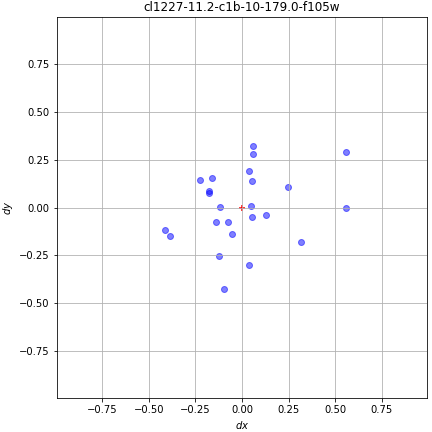

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1227-11.2-c1b-10-179.0-f105w_wcs.png") 


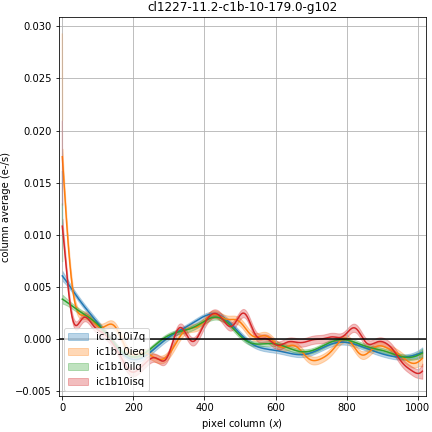

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1227-11.2-c1b-10-179.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 -1.7745 2.1786 0.0018 1.00025 0.142 24


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

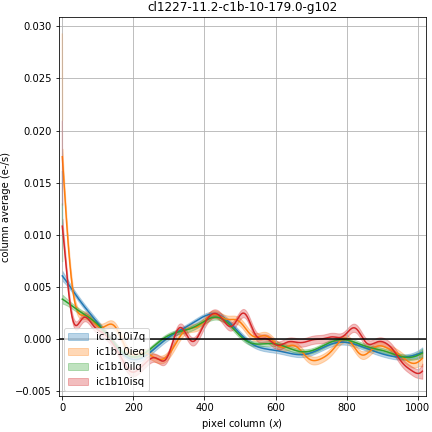

In [18]:
from IPython.display import Image
Image(filename = "./cl1227-11.2-c1b-10-179.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1227-11.2-c1b-10-179.0-f105w        -0.13   -0.09


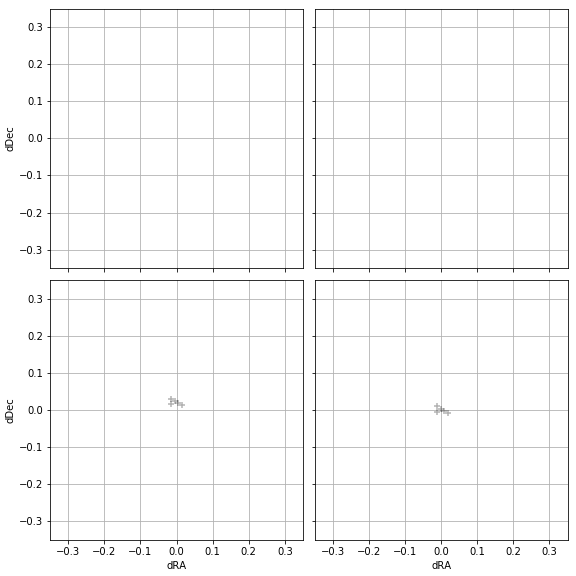

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j122816m1132-f105w_drz_sci.fits
j122816m1132-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j122816m1132-ir.cat.fits
j122816m1132-ir_drz_sci.fits
j122816m1132-ir_drz_wht.fits
j122816m1132-ir_seg.fits
j122816m1132-ir_bkg.fits
j122816m1132_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j122816m1132-ir_drz_sci.fits
WHT_FILE:	j122816m1132-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5153335332870483
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j122816m1132-f105w_drz_sci.fits
F105W_WHT_FILE:	j122816m1132-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5153335332870483
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [24]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b10ieq.01.GrismFLT.fits!
Load ic1b10i7q.01.GrismFLT.fits!
Load ic1b10ilq.01.GrismFLT.fits!
Load ic1b10isq.01.GrismFLT.fits!
Files loaded - 4.51 sec.


### The final contamination model ###

IndexError: list index out of range

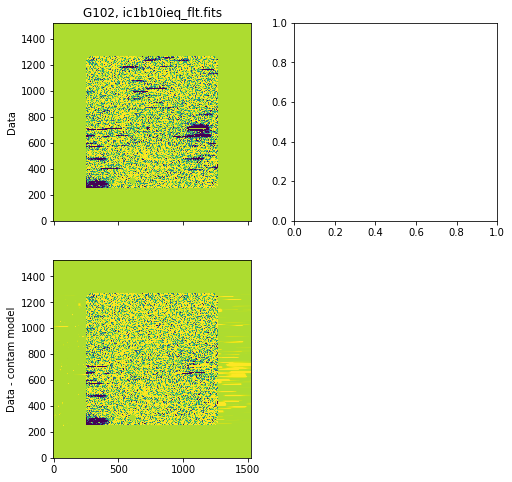

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [41]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j122816m1132/Extractions/a_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 


array([-11.54178093, -11.52902272, -11.54088591, -11.53807246,
       -11.53150447, -11.53089597, -11.52966063, -11.52755951,
       -11.52627067, -11.52479378, -11.51927551, -11.51831977])

In [42]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [43]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

 
j122816m1132 LINE1  / 0.100" / pixf: 0.2 / point    / f105w
j122816m1132 LINE2  / 0.050" / pixf: 0.2 / point    / f105w
j122816m1132 LINE4  / 0.025" / pixf: 0.2 / point    / f105w
j122816m1132 DRIZ1  / 0.060" / pixf: 0.6 / square   / f105w
j122816m1132 DRIZ2  / 0.030" / pixf: 0.6 / square   / f105w
j122816m1132 DRIZ4  / 0.015" / pixf: 0.6 / square   / f105w


['j122816m1132-f105w_psf.fits'] 

Filename: j122816m1132-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


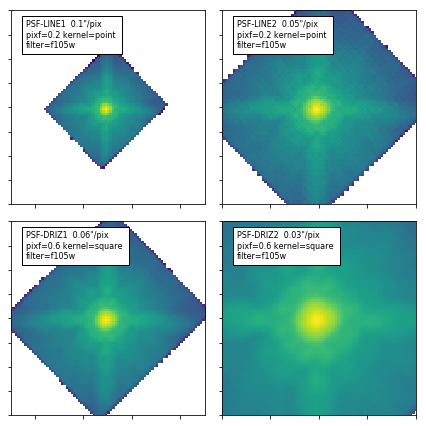

In [44]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [45]:
os.chdir('../Extractions')

In [46]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [49]:
for id_i in idx:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/144: 162 4
j122816m1132_00162.beams.fits
1/144: 161 4
j122816m1132_00161.beams.fits
2/144: 163 4
j122816m1132_00163.beams.fits
3/144: 218 4
j122816m1132_00218.beams.fits
4/144: 147 4
j122816m1132_00147.beams.fits
5/144: 115 4
j122816m1132_00115.beams.fits
6/144: 173 4
j122816m1132_00173.beams.fits
7/144: 258 4
j122816m1132_00258.beams.fits
8/144: 16 4
j122816m1132_00016.beams.fits
9/144: 200 4
j122816m1132_00200.beams.fits
10/144: 60 4
j122816m1132_00060.beams.fits
11/144: 76 0
12/144: 278 4
j122816m1132_00278.beams.fits
13/144: 216 4
j122816m1132_00216.beams.fits
14/144: 223 4
j122816m1132_00223.beams.fits
15/144: 154 4
j122816m1132_00154.beams.fits
16/144: 449 4
j122816m1132_00449.beams.fits
17/144: 438 4
j122816m1132_00438.beams.fits
18/144: 92 4
j122816m1132_00092.beams.fits
19/144: 81 4
j122816m1132_00081.beams.fits
20/144: 397 4
j122816m1132_00397.beams.fits
21/144: 55 2
j122816m1132_00055.beams.fits
22/144: 221 4
j122816m1132_00221.beams.fits
23/144: 83 4
j122816m1132_00083.be

  0.3652  500825.3 (0.2304) 55/341
  0.3707  500654.0 (0.2304) 56/341
  0.3762  500310.9 (0.2304) 57/341
  0.3817  499865.3 (0.2304) 58/341
  0.3872  499126.2 (0.2304) 59/341
  0.3928  498749.4 (0.3928) 60/341
  0.3984  498502.2 (0.3984) 61/341
  0.4040  498531.8 (0.3984) 62/341
  0.4096  498590.4 (0.3984) 63/341
  0.4153  498790.4 (0.3984) 64/341
  0.4209  498973.5 (0.3984) 65/341
  0.4266  499112.5 (0.3984) 66/341
  0.4323  499190.4 (0.3984) 67/341
  0.4381  499338.4 (0.3984) 68/341
  0.4438  499417.8 (0.3984) 69/341
  0.4496  499578.1 (0.3984) 70/341
  0.4554  499771.6 (0.3984) 71/341
  0.4613  500016.9 (0.3984) 72/341
  0.4671  500235.5 (0.3984) 73/341
  0.4730  500339.1 (0.3984) 74/341
  0.4789  500420.7 (0.3984) 75/341
  0.4848  500462.7 (0.3984) 76/341
  0.4908  500535.2 (0.3984) 77/341
  0.4968  500719.7 (0.3984) 78/341
  0.5028  500726.9 (0.3984) 79/341
  0.5088  500728.8 (0.3984) 80/341
  0.5148  500805.1 (0.3984) 81/341
  0.5209  500868.6 (0.3984) 82/341
  0.5270  500838.3 (

  1.9192  494591.1 (1.9075) 245/341
  1.9309  495470.3 (1.9075) 246/341
  1.9426  495717.6 (1.9075) 247/341
  1.9544  496211.4 (1.9075) 248/341
  1.9663  496712.5 (1.9075) 249/341
  1.9782  496817.0 (1.9075) 250/341
  1.9901  497170.9 (1.9075) 251/341
  2.0021  497823.5 (1.9075) 252/341
  2.0141  498493.4 (1.9075) 253/341
  2.0262  499022.1 (1.9075) 254/341
  2.0383  499491.7 (1.9075) 255/341
  2.0505  499791.3 (1.9075) 256/341
  2.0627  499977.8 (1.9075) 257/341
  2.0750  500389.0 (1.9075) 258/341
  2.0873  500446.7 (1.9075) 259/341
  2.0997  500504.2 (1.9075) 260/341
  2.1121  500600.6 (1.9075) 261/341
  2.1246  500697.7 (1.9075) 262/341
  2.1371  500760.8 (1.9075) 263/341
  2.1497  500787.3 (1.9075) 264/341
  2.1623  500796.7 (1.9075) 265/341
  2.1750  500798.4 (1.9075) 266/341
  2.1877  500688.3 (1.9075) 267/341
  2.2005  500948.7 (1.9075) 268/341
  2.2133  501096.4 (1.9075) 269/341
  2.2262  501133.9 (1.9075) 270/341
  2.2391  501170.4 (1.9075) 271/341
  2.2521  501147.7 (1.9075) 

  0.3652  306300.1 (0.3169) 55/341
  0.3707  306385.6 (0.3169) 56/341
  0.3762  306480.2 (0.3169) 57/341
  0.3817  306563.4 (0.3169) 58/341
  0.3872  306621.1 (0.3169) 59/341
  0.3928  306643.3 (0.3169) 60/341
  0.3984  306750.6 (0.3169) 61/341
  0.4040  307022.6 (0.3169) 62/341
  0.4096  307553.4 (0.3169) 63/341
  0.4153  307807.9 (0.3169) 64/341
  0.4209  307956.5 (0.3169) 65/341
  0.4266  307708.6 (0.3169) 66/341
  0.4323  307515.1 (0.3169) 67/341
  0.4381  307216.1 (0.3169) 68/341
  0.4438  307034.4 (0.3169) 69/341
  0.4496  306979.9 (0.3169) 70/341
  0.4554  307006.0 (0.3169) 71/341
  0.4613  307038.4 (0.3169) 72/341
  0.4671  307011.7 (0.3169) 73/341
  0.4730  307059.0 (0.3169) 74/341
  0.4789  307146.1 (0.3169) 75/341
  0.4848  307274.5 (0.3169) 76/341
  0.4908  307344.7 (0.3169) 77/341
  0.4968  307441.3 (0.3169) 78/341
  0.5028  307527.8 (0.3169) 79/341
  0.5088  307522.6 (0.3169) 80/341
  0.5148  307490.7 (0.3169) 81/341
  0.5209  307466.4 (0.3169) 82/341
  0.5270  307440.9 (

  1.9426  308474.4 (0.3169) 247/341
  1.9544  308086.2 (0.3169) 248/341
  1.9663  307921.6 (0.3169) 249/341
  1.9782  307791.3 (0.3169) 250/341
  1.9901  307794.8 (0.3169) 251/341
  2.0021  307801.5 (0.3169) 252/341
  2.0141  307910.2 (0.3169) 253/341
  2.0262  308143.7 (0.3169) 254/341
  2.0383  308161.8 (0.3169) 255/341
  2.0505  308049.5 (0.3169) 256/341
  2.0627  307983.6 (0.3169) 257/341
  2.0750  307535.7 (0.3169) 258/341
  2.0873  307242.6 (0.3169) 259/341
  2.0997  307119.6 (0.3169) 260/341
  2.1121  307046.8 (0.3169) 261/341
  2.1246  307050.2 (0.3169) 262/341
  2.1371  307007.3 (0.3169) 263/341
  2.1497  306967.9 (0.3169) 264/341
  2.1623  306915.3 (0.3169) 265/341
  2.1750  306860.8 (0.3169) 266/341
  2.1877  306810.9 (0.3169) 267/341
  2.2005  306580.3 (0.3169) 268/341
  2.2133  306325.5 (0.3169) 269/341
  2.2262  306246.1 (0.3169) 270/341
  2.2391  306225.0 (0.3169) 271/341
  2.2521  306312.6 (0.3169) 272/341
  2.2652  306418.3 (0.3169) 273/341
  2.2783  306450.6 (0.3169) 

  0.3872  449487.1 (0.1964) 59/341
  0.3928  449383.8 (0.1964) 60/341
  0.3984  449300.4 (0.1964) 61/341
  0.4040  449220.8 (0.4040) 62/341
  0.4096  449134.3 (0.4096) 63/341
  0.4153  449044.5 (0.4153) 64/341
  0.4209  448941.0 (0.4209) 65/341
  0.4266  448854.4 (0.4266) 66/341
  0.4323  448750.4 (0.4323) 67/341
  0.4381  448645.7 (0.4381) 68/341
  0.4438  448542.9 (0.4438) 69/341
  0.4496  448425.1 (0.4496) 70/341
  0.4554  448287.9 (0.4554) 71/341
  0.4613  448117.4 (0.4613) 72/341
  0.4671  447924.8 (0.4671) 73/341
  0.4730  447807.2 (0.4730) 74/341
  0.4789  447741.3 (0.4789) 75/341
  0.4848  447194.6 (0.4848) 76/341
  0.4908  447090.9 (0.4908) 77/341
  0.4968  446935.4 (0.4968) 78/341
  0.5028  446902.4 (0.5028) 79/341
  0.5088  446793.8 (0.5088) 80/341
  0.5148  446857.3 (0.5088) 81/341
  0.5209  446858.7 (0.5088) 82/341
  0.5270  446984.6 (0.5088) 83/341
  0.5331  447053.5 (0.5088) 84/341
  0.5393  447217.7 (0.5088) 85/341
  0.5454  447417.0 (0.5088) 86/341
  0.5516  447462.8 (

  1.9426  449224.1 (0.5088) 247/341
  1.9544  448511.2 (0.5088) 248/341
  1.9663  447702.6 (0.5088) 249/341
  1.9782  446985.8 (0.5088) 250/341
  1.9901  446429.9 (1.9901) 251/341
  2.0021  445899.3 (2.0021) 252/341
  2.0141  445457.4 (2.0141) 253/341
  2.0262  445021.5 (2.0262) 254/341
  2.0383  445061.7 (2.0262) 255/341
  2.0505  445475.2 (2.0262) 256/341
  2.0627  445849.0 (2.0262) 257/341
  2.0750  446425.8 (2.0262) 258/341
  2.0873  446912.4 (2.0262) 259/341
  2.0997  447274.0 (2.0262) 260/341
  2.1121  447811.1 (2.0262) 261/341
  2.1246  448206.2 (2.0262) 262/341
  2.1371  448489.4 (2.0262) 263/341
  2.1497  448777.0 (2.0262) 264/341
  2.1623  448968.9 (2.0262) 265/341
  2.1750  449104.4 (2.0262) 266/341
  2.1877  449199.7 (2.0262) 267/341
  2.2005  449302.4 (2.0262) 268/341
  2.2133  449394.9 (2.0262) 269/341
  2.2262  449456.0 (2.0262) 270/341
  2.2391  449528.7 (2.0262) 271/341
  2.2521  449605.5 (2.0262) 272/341
  2.2652  449652.2 (2.0262) 273/341
  2.2783  449686.4 (2.0262) 

  0.4040  199817.4 (0.2603) 62/341
  0.4096  199957.5 (0.2603) 63/341
  0.4153  200089.7 (0.2603) 64/341
  0.4209  200209.9 (0.2603) 65/341
  0.4266  200258.1 (0.2603) 66/341
  0.4323  200273.0 (0.2603) 67/341
  0.4381  200301.4 (0.2603) 68/341
  0.4438  200326.0 (0.2603) 69/341
  0.4496  200319.1 (0.2603) 70/341
  0.4554  200313.4 (0.2603) 71/341
  0.4613  200214.5 (0.2603) 72/341
  0.4671  200154.7 (0.2603) 73/341
  0.4730  200124.9 (0.2603) 74/341
  0.4789  200065.1 (0.2603) 75/341
  0.4848  199931.2 (0.2603) 76/341
  0.4908  199782.8 (0.2603) 77/341
  0.4968  199696.3 (0.2603) 78/341
  0.5028  199649.9 (0.2603) 79/341
  0.5088  199586.1 (0.2603) 80/341
  0.5148  199544.8 (0.2603) 81/341
  0.5209  199575.0 (0.2603) 82/341
  0.5270  199603.6 (0.2603) 83/341
  0.5331  199601.6 (0.2603) 84/341
  0.5393  199587.3 (0.2603) 85/341
  0.5454  199609.9 (0.2603) 86/341
  0.5516  199629.3 (0.2603) 87/341
  0.5579  199646.9 (0.2603) 88/341
  0.5641  199674.2 (0.2603) 89/341
  0.5704  199737.2 (

  2.0262  200505.8 (0.2603) 254/341
  2.0383  200347.7 (0.2603) 255/341
  2.0505  200208.2 (0.2603) 256/341
  2.0627  200071.7 (0.2603) 257/341
  2.0750  199994.6 (0.2603) 258/341
  2.0873  199813.5 (0.2603) 259/341
  2.0997  199662.6 (0.2603) 260/341
  2.1121  199571.7 (0.2603) 261/341
  2.1246  199537.9 (0.2603) 262/341
  2.1371  199533.6 (0.2603) 263/341
  2.1497  199515.3 (0.2603) 264/341
  2.1623  199520.1 (0.2603) 265/341
  2.1750  199538.7 (0.2603) 266/341
  2.1877  199576.8 (0.2603) 267/341
  2.2005  199644.5 (0.2603) 268/341
  2.2133  199700.3 (0.2603) 269/341
  2.2262  199759.6 (0.2603) 270/341
  2.2391  199830.0 (0.2603) 271/341
  2.2521  199886.7 (0.2603) 272/341
  2.2652  199938.8 (0.2603) 273/341
  2.2783  199989.9 (0.2603) 274/341
  2.2914  200013.8 (0.2603) 275/341
  2.3046  200004.4 (0.2603) 276/341
  2.3178  199964.0 (0.2603) 277/341
  2.3311  199931.0 (0.2603) 278/341
  2.3445  199917.5 (0.2603) 279/341
  2.3579  199883.0 (0.2603) 280/341
  2.3713  199811.5 (0.2603) 

  0.4209   47768.0 (0.2502) 65/341
  0.4266   47791.1 (0.2502) 66/341
  0.4323   47809.4 (0.2502) 67/341
  0.4381   47784.1 (0.2502) 68/341
  0.4438   47716.0 (0.2502) 69/341
  0.4496   47630.3 (0.2502) 70/341
  0.4554   47586.3 (0.2502) 71/341
  0.4613   47604.5 (0.2502) 72/341
  0.4671   47631.9 (0.2502) 73/341
  0.4730   47640.4 (0.2502) 74/341
  0.4789   47622.4 (0.2502) 75/341
  0.4848   47620.2 (0.2502) 76/341
  0.4908   47615.4 (0.2502) 77/341
  0.4968   47599.0 (0.2502) 78/341
  0.5028   47570.0 (0.2502) 79/341
  0.5088   47573.8 (0.2502) 80/341
  0.5148   47579.4 (0.2502) 81/341
  0.5209   47568.2 (0.2502) 82/341
  0.5270   47565.6 (0.2502) 83/341
  0.5331   47599.9 (0.2502) 84/341
  0.5393   47632.6 (0.2502) 85/341
  0.5454   47654.3 (0.2502) 86/341
  0.5516   47646.6 (0.2502) 87/341
  0.5579   47654.3 (0.2502) 88/341
  0.5641   47633.7 (0.2502) 89/341
  0.5704   47572.6 (0.2502) 90/341
  0.5767   47559.1 (0.2502) 91/341
  0.5830   47626.5 (0.2502) 92/341
  0.5893   47653.7 (

  2.0873   47558.8 (0.2502) 259/341
  2.0997   47507.7 (0.2502) 260/341
  2.1121   47562.9 (0.2502) 261/341
  2.1246   47651.9 (0.2502) 262/341
  2.1371   47685.3 (0.2502) 263/341
  2.1497   47685.1 (0.2502) 264/341
  2.1623   47706.4 (0.2502) 265/341
  2.1750   47732.1 (0.2502) 266/341
  2.1877   47722.8 (0.2502) 267/341
  2.2005   47674.9 (0.2502) 268/341
  2.2133   47654.5 (0.2502) 269/341
  2.2262   47694.5 (0.2502) 270/341
  2.2391   47686.9 (0.2502) 271/341
  2.2521   47688.0 (0.2502) 272/341
  2.2652   47745.4 (0.2502) 273/341
  2.2783   47813.9 (0.2502) 274/341
  2.2914   47846.3 (0.2502) 275/341
  2.3046   47882.9 (0.2502) 276/341
  2.3178   47934.0 (0.2502) 277/341
  2.3311   47974.5 (0.2502) 278/341
  2.3445   47994.2 (0.2502) 279/341
  2.3579   48009.5 (0.2502) 280/341
  2.3713   48010.0 (0.2502) 281/341
  2.3849   48009.5 (0.2502) 282/341
  2.3984   47983.9 (0.2502) 283/341
  2.4120   47950.1 (0.2502) 284/341
  2.4257   47929.2 (0.2502) 285/341
  2.4394   47904.6 (0.2502) 

  0.6542   16085.2 (0.5704) 103/341
  0.6608   16101.5 (0.5704) 104/341
  0.6675   16094.9 (0.5704) 105/341
  0.6742   16076.0 (0.5704) 106/341
  0.6809   16084.9 (0.5704) 107/341
  0.6876   16095.1 (0.5704) 108/341
  0.6944   16104.3 (0.5704) 109/341
  0.7012   16107.1 (0.5704) 110/341
  0.7080   16109.3 (0.5704) 111/341
  0.7148   16121.0 (0.5704) 112/341
  0.7217   16153.3 (0.5704) 113/341
  0.7286   16163.3 (0.5704) 114/341
  0.7355   16144.5 (0.5704) 115/341
  0.7425   16109.1 (0.5704) 116/341
  0.7495   16041.8 (0.5704) 117/341
  0.7565   16021.2 (0.5704) 118/341
  0.7635   16142.9 (0.5704) 119/341
  0.7706   16206.2 (0.5704) 120/341
  0.7777   16135.3 (0.5704) 121/341
  0.7848   16205.9 (0.5704) 122/341
  0.7920   16308.8 (0.5704) 123/341
  0.7991   16378.9 (0.5704) 124/341
  0.8064   16410.3 (0.5704) 125/341
  0.8136   16455.1 (0.5704) 126/341
  0.8209   16513.7 (0.5704) 127/341
  0.8282   16508.0 (0.5704) 128/341
  0.8355   16453.0 (0.5704) 129/341
  0.8428   16450.0 (0.5704) 

  2.5230   16118.9 (0.5704) 292/341
  2.5371   16118.6 (0.5704) 293/341
  2.5513   16112.4 (0.5704) 294/341
  2.5655   16101.8 (0.5704) 295/341
  2.5798   16087.4 (0.5704) 296/341
  2.5942   16077.5 (0.5704) 297/341
  2.6086   16076.2 (0.5704) 298/341
  2.6230   16059.5 (0.5704) 299/341
  2.6375   16034.5 (0.5704) 300/341
  2.6521   16013.7 (0.5704) 301/341
  2.6668   16013.8 (0.5704) 302/341
  2.6815   16054.1 (0.5704) 303/341
  2.6962   16081.2 (0.5704) 304/341
  2.7110   16085.8 (0.5704) 305/341
  2.7259   16092.3 (0.5704) 306/341
  2.7408   16162.2 (0.5704) 307/341
  2.7558   16188.3 (0.5704) 308/341
  2.7709   16190.8 (0.5704) 309/341
  2.7860   16195.8 (0.5704) 310/341
  2.8012   16232.3 (0.5704) 311/341
  2.8164   16236.4 (0.5704) 312/341
  2.8317   16217.3 (0.5704) 313/341
  2.8471   16217.5 (0.5704) 314/341
  2.8625   16260.0 (0.5704) 315/341
  2.8780   16235.7 (0.5704) 316/341
  2.8935   16203.1 (0.5704) 317/341
  2.9091   16195.1 (0.5704) 318/341
  2.9248   16232.0 (0.5704) 

  0.6608   28178.4 (0.3169) 104/341
  0.6675   28218.1 (0.3169) 105/341
  0.6742   28218.2 (0.3169) 106/341
  0.6809   28243.6 (0.3169) 107/341
  0.6876   28164.3 (0.3169) 108/341
  0.6944   27966.2 (0.3169) 109/341
  0.7012   27979.5 (0.3169) 110/341
  0.7080   27999.5 (0.3169) 111/341
  0.7148   27160.2 (0.3169) 112/341
  0.7217   25113.7 (0.3169) 113/341
  0.7286   22534.9 (0.3169) 114/341
  0.7355   23398.4 (0.3169) 115/341
  0.7425   26141.9 (0.3169) 116/341
  0.7495   27246.0 (0.3169) 117/341
  0.7565   27612.2 (0.3169) 118/341
  0.7635   27636.7 (0.3169) 119/341
  0.7706   27672.6 (0.3169) 120/341
  0.7777   28140.5 (0.3169) 121/341
  0.7848   28311.4 (0.3169) 122/341
  0.7920   28381.8 (0.3169) 123/341
  0.7991   28300.2 (0.3169) 124/341
  0.8064   28194.9 (0.3169) 125/341
  0.8136   28184.5 (0.3169) 126/341
  0.8209   28186.8 (0.3169) 127/341
  0.8282   28062.5 (0.3169) 128/341
  0.8355   27843.6 (0.3169) 129/341
  0.8428   27716.9 (0.3169) 130/341
  0.8502   27608.6 (0.3169) 

  2.5798   27915.9 (0.3169) 296/341
  2.5942   27928.5 (0.3169) 297/341
  2.6086   27947.8 (0.3169) 298/341
  2.6230   27990.7 (0.3169) 299/341
  2.6375   28054.5 (0.3169) 300/341
  2.6521   28137.9 (0.3169) 301/341
  2.6668   28197.5 (0.3169) 302/341
  2.6815   28284.4 (0.3169) 303/341
  2.6962   28348.6 (0.3169) 304/341
  2.7110   28317.2 (0.3169) 305/341
  2.7259   28218.1 (0.3169) 306/341
  2.7408   28111.0 (0.3169) 307/341
  2.7558   28056.8 (0.3169) 308/341
  2.7709   28017.0 (0.3169) 309/341
  2.7860   27988.5 (0.3169) 310/341
  2.8012   27907.9 (0.3169) 311/341
  2.8164   27775.6 (0.3169) 312/341
  2.8317   27680.5 (0.3169) 313/341
  2.8471   27681.7 (0.3169) 314/341
  2.8625   27796.5 (0.3169) 315/341
  2.8780   27893.6 (0.3169) 316/341
  2.8935   27899.4 (0.3169) 317/341
  2.9091   27851.7 (0.3169) 318/341
  2.9248   27753.4 (0.3169) 319/341
  2.9405   27735.8 (0.3169) 320/341
  2.9563   27807.4 (0.3169) 321/341
  2.9722   27830.0 (0.3169) 322/341
  2.9881   27814.7 (0.3169) 

  0.6944   11209.8 (0.5148) 109/341
  0.7012   11216.5 (0.5148) 110/341
  0.7080   11206.2 (0.5148) 111/341
  0.7148   11190.2 (0.5148) 112/341
  0.7217   11172.6 (0.5148) 113/341
  0.7286   11152.0 (0.5148) 114/341
  0.7355   11154.3 (0.5148) 115/341
  0.7425   11213.0 (0.5148) 116/341
  0.7495   11265.4 (0.5148) 117/341
  0.7565   11289.2 (0.5148) 118/341
  0.7635   11305.5 (0.5148) 119/341
  0.7706   11322.3 (0.5148) 120/341
  0.7777   11324.6 (0.5148) 121/341
  0.7848   11325.3 (0.5148) 122/341
  0.7920   11327.1 (0.5148) 123/341
  0.7991   11338.2 (0.5148) 124/341
  0.8064   11341.3 (0.5148) 125/341
  0.8136   11336.8 (0.5148) 126/341
  0.8209   11339.9 (0.5148) 127/341
  0.8282   11335.8 (0.5148) 128/341
  0.8355   11330.6 (0.5148) 129/341
  0.8428   11328.0 (0.5148) 130/341
  0.8502   11320.7 (0.5148) 131/341
  0.8576   11309.4 (0.5148) 132/341
  0.8651   11297.6 (0.5148) 133/341
  0.8726   11299.3 (0.5148) 134/341
  0.8801   11324.4 (0.5148) 135/341
  0.8876   11334.3 (0.5148) 

  2.6230   11321.9 (0.5148) 299/341
  2.6375   11289.3 (0.5148) 300/341
  2.6521   11253.2 (0.5148) 301/341
  2.6668   11225.2 (0.5148) 302/341
  2.6815   11203.3 (0.5148) 303/341
  2.6962   11181.2 (0.5148) 304/341
  2.7110   11159.3 (0.5148) 305/341
  2.7259   11144.7 (0.5148) 306/341
  2.7408   11133.8 (0.5148) 307/341
  2.7558   11132.1 (0.5148) 308/341
  2.7709   11145.6 (0.5148) 309/341
  2.7860   11163.8 (0.5148) 310/341
  2.8012   11173.4 (0.5148) 311/341
  2.8164   11166.7 (0.5148) 312/341
  2.8317   11158.2 (0.5148) 313/341
  2.8471   11166.3 (0.5148) 314/341
  2.8625   11191.2 (0.5148) 315/341
  2.8780   11228.1 (0.5148) 316/341
  2.8935   11260.0 (0.5148) 317/341
  2.9091   11301.1 (0.5148) 318/341
  2.9248   11345.5 (0.5148) 319/341
  2.9405   11393.4 (0.5148) 320/341
  2.9563   11438.7 (0.5148) 321/341
  2.9722   11468.9 (0.5148) 322/341
  2.9881   11501.0 (0.5148) 323/341
  3.0041   11537.6 (0.5148) 324/341
  3.0201   11577.1 (0.5148) 325/341
  3.0362   11613.3 (0.5148) 

  0.6944   33241.3 (0.6476) 109/341
  0.7012   33275.1 (0.6476) 110/341
  0.7080   33264.9 (0.6476) 111/341
  0.7148   33251.7 (0.6476) 112/341
  0.7217   33258.4 (0.6476) 113/341
  0.7286   33273.5 (0.6476) 114/341
  0.7355   33213.4 (0.6476) 115/341
  0.7425   33186.9 (0.6476) 116/341
  0.7495   33175.3 (0.6476) 117/341
  0.7565   33180.6 (0.6476) 118/341
  0.7635   33211.0 (0.6476) 119/341
  0.7706   33260.5 (0.6476) 120/341
  0.7777   33275.1 (0.6476) 121/341
  0.7848   33264.6 (0.6476) 122/341
  0.7920   33264.1 (0.6476) 123/341
  0.7991   33274.0 (0.6476) 124/341
  0.8064   33295.0 (0.6476) 125/341
  0.8136   33319.0 (0.6476) 126/341
  0.8209   33358.9 (0.6476) 127/341
  0.8282   33316.3 (0.6476) 128/341
  0.8355   33350.9 (0.6476) 129/341
  0.8428   33401.4 (0.6476) 130/341
  0.8502   33427.2 (0.6476) 131/341
  0.8576   33464.8 (0.6476) 132/341
  0.8651   33485.7 (0.6476) 133/341
  0.8726   33457.5 (0.6476) 134/341
  0.8801   33483.2 (0.6476) 135/341
  0.8876   33466.5 (0.6476) 

  2.6230   33123.0 (2.5942) 299/341
  2.6375   33129.6 (2.5942) 300/341
  2.6521   33132.5 (2.5942) 301/341
  2.6668   33173.2 (2.5942) 302/341
  2.6815   33204.6 (2.5942) 303/341
  2.6962   33210.2 (2.5942) 304/341
  2.7110   33224.8 (2.5942) 305/341
  2.7259   33247.7 (2.5942) 306/341
  2.7408   33267.7 (2.5942) 307/341
  2.7558   33262.4 (2.5942) 308/341
  2.7709   33245.6 (2.5942) 309/341
  2.7860   33253.2 (2.5942) 310/341
  2.8012   33276.7 (2.5942) 311/341
  2.8164   33263.4 (2.5942) 312/341
  2.8317   33253.1 (2.5942) 313/341
  2.8471   33280.3 (2.5942) 314/341
  2.8625   33311.3 (2.5942) 315/341
  2.8780   33316.8 (2.5942) 316/341
  2.8935   33313.8 (2.5942) 317/341
  2.9091   33369.5 (2.5942) 318/341
  2.9248   33391.9 (2.5942) 319/341
  2.9405   33391.1 (2.5942) 320/341
  2.9563   33385.0 (2.5942) 321/341
  2.9722   33392.8 (2.5942) 322/341
  2.9881   33426.8 (2.5942) 323/341
  3.0041   33445.4 (2.5942) 324/341
  3.0201   33451.6 (2.5942) 325/341
  3.0362   33458.5 (2.5942) 

  0.5270    9717.9 (0.5148) 83/341
  0.5331    9734.0 (0.5148) 84/341
  0.5393    9735.3 (0.5148) 85/341
  0.5454    9737.6 (0.5148) 86/341
  0.5516    9738.4 (0.5148) 87/341
  0.5579    9743.0 (0.5148) 88/341
  0.5641    9748.1 (0.5148) 89/341
  0.5704    9750.3 (0.5148) 90/341
  0.5767    9750.4 (0.5148) 91/341
  0.5830    9748.2 (0.5148) 92/341
  0.5893    9748.6 (0.5148) 93/341
  0.5957    9745.8 (0.5148) 94/341
  0.6021    9737.5 (0.5148) 95/341
  0.6085    9732.4 (0.5148) 96/341
  0.6150    9731.8 (0.5148) 97/341
  0.6214    9728.0 (0.5148) 98/341
  0.6279    9717.9 (0.5148) 99/341
  0.6345    9713.5 (0.5148) 100/341
  0.6410    9714.6 (0.5148) 101/341
  0.6476    9717.1 (0.5148) 102/341
  0.6542    9723.6 (0.5148) 103/341
  0.6608    9729.6 (0.5148) 104/341
  0.6675    9731.6 (0.5148) 105/341
  0.6742    9737.2 (0.5148) 106/341
  0.6809    9740.0 (0.5148) 107/341
  0.6876    9738.5 (0.5148) 108/341
  0.6944    9730.8 (0.5148) 109/341
  0.7012    9712.9 (0.5148) 110/341
  0.7080 

  2.2521    9739.0 (0.5148) 272/341
  2.2652    9741.4 (0.5148) 273/341
  2.2783    9743.0 (0.5148) 274/341
  2.2914    9743.5 (0.5148) 275/341
  2.3046    9744.7 (0.5148) 276/341
  2.3178    9745.1 (0.5148) 277/341
  2.3311    9742.8 (0.5148) 278/341
  2.3445    9738.5 (0.5148) 279/341
  2.3579    9730.4 (0.5148) 280/341
  2.3713    9722.0 (0.5148) 281/341
  2.3849    9713.9 (0.5148) 282/341
  2.3984    9706.3 (0.5148) 283/341
  2.4120    9703.6 (0.5148) 284/341
  2.4257    9707.3 (0.5148) 285/341
  2.4394    9714.7 (0.5148) 286/341
  2.4532    9724.7 (0.5148) 287/341
  2.4671    9732.7 (0.5148) 288/341
  2.4810    9741.1 (0.5148) 289/341
  2.4949    9750.6 (0.5148) 290/341
  2.5089    9760.0 (0.5148) 291/341
  2.5230    9766.3 (0.5148) 292/341
  2.5371    9773.5 (0.5148) 293/341
  2.5513    9784.9 (0.5148) 294/341
  2.5655    9786.8 (0.5148) 295/341
  2.5798    9776.9 (0.5148) 296/341
  2.5942    9767.7 (0.5148) 297/341
  2.6086    9764.3 (0.5148) 298/341
  2.6230    9758.3 (0.5148) 

- 3.0457    9672.2 (3.0447) 120/132
- 3.0462    9672.2 (3.0447) 121/132
- 3.0467    9672.3 (3.0447) 122/132
- 3.0472    9672.4 (3.0447) 123/132
- 3.0477    9672.5 (3.0447) 124/132
- 3.0482    9672.6 (3.0447) 125/132
- 3.0487    9672.7 (3.0447) 126/132
- 3.0492    9672.9 (3.0447) 127/132
- 3.0497    9673.0 (3.0447) 128/132
- 3.0502    9673.2 (3.0447) 129/132
- 3.0507    9673.4 (3.0447) 130/132
- 3.0512    9673.6 (3.0447) 131/132
- 3.0517    9673.9 (3.0447) 132/132
Get linemap PSF: F105W
10/144: 60
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    7194.5 (0.1000) 1/341
  0.1044    7189.4 (0.1044) 2/341
  0.1088    7180.6 (0.1088) 3/341
  0.1133    7168.9 (0.1133) 4/341
  0.1177    7162.4 (0.1177) 5/341
  0.1222    7156.8 (0.1222) 6/341
  0.1267    7154.4 (0.1267) 7/341
  0.1312    7161.3 (0.1267) 8/341
  0.1358    7168.2 (0.1267) 9/341
  0.1403    7168.1 (0.1267) 10/341
  0.1449    7179.1 (0.1267) 11

  1.2599    7411.9 (0.3435) 181/341
  1.2689    7437.8 (0.3435) 182/341
  1.2780    7477.7 (0.3435) 183/341
  1.2872    7502.0 (0.3435) 184/341
  1.2963    7537.6 (0.3435) 185/341
  1.3055    7566.2 (0.3435) 186/341
  1.3148    7588.5 (0.3435) 187/341
  1.3240    7573.0 (0.3435) 188/341
  1.3334    7565.9 (0.3435) 189/341
  1.3427    7577.3 (0.3435) 190/341
  1.3521    7607.2 (0.3435) 191/341
  1.3615    7635.5 (0.3435) 192/341
  1.3710    7640.8 (0.3435) 193/341
  1.3805    7622.9 (0.3435) 194/341
  1.3900    7590.9 (0.3435) 195/341
  1.3996    7587.1 (0.3435) 196/341
  1.4092    7581.1 (0.3435) 197/341
  1.4189    7609.9 (0.3435) 198/341
  1.4286    7653.7 (0.3435) 199/341
  1.4383    7678.1 (0.3435) 200/341
  1.4481    7707.7 (0.3435) 201/341
  1.4579    7712.2 (0.3435) 202/341
  1.4678    7746.8 (0.3435) 203/341
  1.4776    7751.2 (0.3435) 204/341
  1.4876    7773.8 (0.3435) 205/341
  1.4975    7763.2 (0.3435) 206/341
  1.5076    7762.0 (0.3435) 207/341
  1.5176    7810.7 (0.3435) 

- 0.3498    7121.1 (0.3433) 29/33
- 0.3503    7123.3 (0.3433) 30/33
- 0.3508    7126.3 (0.3433) 31/33
- 0.3513    7129.7 (0.3433) 32/33
- 0.3518    7132.7 (0.3433) 33/33
Drizzle line -> SII  (1.96 2.69)
Drizzle line -> Ha   (0.33 3.09)
Drizzle line -> OI-6302 (5.47 4.70)
Get linemap PSF: F105W
11/144: 76
12/144: 278
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    6256.0 (0.1000) 1/341
  0.1044    6260.6 (0.1000) 2/341
  0.1088    6264.1 (0.1000) 3/341
  0.1133    6263.6 (0.1000) 4/341
  0.1177    6263.8 (0.1000) 5/341
  0.1222    6264.6 (0.1000) 6/341
  0.1267    6266.7 (0.1000) 7/341
  0.1312    6267.7 (0.1000) 8/341
  0.1358    6272.8 (0.1000) 9/341
  0.1403    6276.3 (0.1000) 10/341
  0.1449    6278.7 (0.1000) 11/341
  0.1495    6279.0 (0.1000) 12/341
  0.1541    6277.2 (0.1000) 13/341
  0.1587    6276.9 (0.1000) 14/341
  0.1634    6279.2 (0.1000) 15/341
  0.1680    6277.6 (0.1000) 16/341
  0.

  1.2780    6308.5 (0.6876) 183/341
  1.2872    6310.7 (0.6876) 184/341
  1.2963    6300.8 (0.6876) 185/341
  1.3055    6296.6 (0.6876) 186/341
  1.3148    6302.4 (0.6876) 187/341
  1.3240    6306.2 (0.6876) 188/341
  1.3334    6299.3 (0.6876) 189/341
  1.3427    6292.8 (0.6876) 190/341
  1.3521    6302.5 (0.6876) 191/341
  1.3615    6307.4 (0.6876) 192/341
  1.3710    6304.2 (0.6876) 193/341
  1.3805    6303.3 (0.6876) 194/341
  1.3900    6300.0 (0.6876) 195/341
  1.3996    6298.7 (0.6876) 196/341
  1.4092    6304.4 (0.6876) 197/341
  1.4189    6303.5 (0.6876) 198/341
  1.4286    6299.8 (0.6876) 199/341
  1.4383    6312.7 (0.6876) 200/341
  1.4481    6322.9 (0.6876) 201/341
  1.4579    6332.1 (0.6876) 202/341
  1.4678    6347.8 (0.6876) 203/341
  1.4776    6369.4 (0.6876) 204/341
  1.4876    6394.6 (0.6876) 205/341
  1.4975    6414.0 (0.6876) 206/341
  1.5076    6414.5 (0.6876) 207/341
  1.5176    6411.4 (0.6876) 208/341
  1.5277    6421.7 (0.6876) 209/341
  1.5378    6421.1 (0.6876) 

- 0.5969    6260.3 (0.3130) 34/264
- 0.5974    6260.0 (0.3130) 35/264
- 0.5979    6260.0 (0.3130) 36/264
- 0.5984    6260.0 (0.3130) 37/264
- 0.5989    6259.7 (0.5989) 38/264
- 0.5994    6259.4 (0.5994) 39/264
- 0.5999    6259.2 (0.5999) 40/264
- 0.6004    6259.2 (0.6004) 41/264
- 0.6009    6259.2 (0.6009) 42/264
- 0.6014    6259.2 (0.6009) 43/264
- 0.6019    6259.2 (0.6019) 44/264
- 0.6024    6259.1 (0.6024) 45/264
- 0.6029    6259.1 (0.6029) 46/264
- 0.6034    6258.9 (0.6034) 47/264
- 0.6039    6258.9 (0.6039) 48/264
- 0.6044    6258.9 (0.6039) 49/264
- 0.6049    6258.9 (0.6049) 50/264
- 0.6054    6258.8 (0.6054) 51/264
- 0.6059    6258.7 (0.6059) 52/264
- 0.6064    6258.8 (0.6059) 53/264
- 0.6069    6258.9 (0.6059) 54/264
- 0.6074    6259.1 (0.6059) 55/264
- 0.6079    6259.2 (0.6059) 56/264
- 0.6084    6259.2 (0.6059) 57/264
- 0.6089    6259.2 (0.6059) 58/264
- 0.6094    6259.3 (0.6059) 59/264
- 0.6099    6259.6 (0.6059) 60/264
- 0.6104    6259.9 (0.6059) 61/264
- 0.6109    6260.1 (

- 2.3188    6258.2 (0.6868) 225/264
- 2.3193    6258.2 (0.6868) 226/264
- 2.3198    6258.2 (0.6868) 227/264
- 2.3203    6258.3 (0.6868) 228/264
- 2.3208    6258.3 (0.6868) 229/264
- 2.3213    6258.3 (0.6868) 230/264
- 2.3218    6258.4 (0.6868) 231/264
- 2.7140    6253.8 (0.6868) 232/264
- 2.7145    6253.8 (0.6868) 233/264
- 2.7150    6253.7 (0.6868) 234/264
- 2.7155    6253.7 (0.6868) 235/264
- 2.7160    6253.7 (0.6868) 236/264
- 2.7165    6253.6 (0.6868) 237/264
- 2.7170    6253.6 (0.6868) 238/264
- 2.7175    6253.6 (0.6868) 239/264
- 2.7180    6253.5 (0.6868) 240/264
- 2.7185    6253.5 (0.6868) 241/264
- 2.7190    6253.5 (0.6868) 242/264
- 2.7195    6253.4 (0.6868) 243/264
- 2.7200    6253.4 (0.6868) 244/264
- 2.7205    6253.4 (0.6868) 245/264
- 2.7210    6253.4 (0.6868) 246/264
- 2.7215    6253.4 (0.6868) 247/264
- 2.7220    6253.4 (0.6868) 248/264
- 2.7225    6253.4 (0.6868) 249/264
- 2.7230    6253.4 (0.6868) 250/264
- 2.7235    6253.4 (0.6868) 251/264
- 2.7240    6253.4 (0.6868) 

  1.0367    6255.2 (0.6675) 155/341
  1.0448    6271.9 (0.6675) 156/341
  1.0530    6255.4 (0.6675) 157/341
  1.0612    6290.9 (0.6675) 158/341
  1.0695    6357.5 (0.6675) 159/341
  1.0778    6393.8 (0.6675) 160/341
  1.0861    6352.4 (0.6675) 161/341
  1.0945    6408.2 (0.6675) 162/341
  1.1029    6433.2 (0.6675) 163/341
  1.1113    6440.4 (0.6675) 164/341
  1.1198    6402.5 (0.6675) 165/341
  1.1283    6395.0 (0.6675) 166/341
  1.1368    6496.6 (0.6675) 167/341
  1.1454    6617.4 (0.6675) 168/341
  1.1540    6746.9 (0.6675) 169/341
  1.1626    6827.4 (0.6675) 170/341
  1.1713    6926.9 (0.6675) 171/341
  1.1800    7028.5 (0.6675) 172/341
  1.1887    7092.2 (0.6675) 173/341
  1.1975    7198.0 (0.6675) 174/341
  1.2063    7275.6 (0.6675) 175/341
  1.2151    7338.1 (0.6675) 176/341
  1.2240    7395.7 (0.6675) 177/341
  1.2329    7442.0 (0.6675) 178/341
  1.2419    7502.0 (0.6675) 179/341
  1.2509    7555.9 (0.6675) 180/341
  1.2599    7731.6 (0.6675) 181/341
  1.2689    7865.9 (0.6675) 

- 0.6668    6019.2 (0.6668) 11/66
- 0.6673    6018.4 (0.6673) 12/66
- 0.6678    6017.9 (0.6678) 13/66
- 0.6683    6018.0 (0.6678) 14/66
- 0.6688    6017.1 (0.6688) 15/66
- 0.6693    6016.6 (0.6693) 16/66
- 0.6698    6016.7 (0.6693) 17/66
- 0.6703    6015.5 (0.6703) 18/66
- 0.6708    6014.9 (0.6708) 19/66
- 0.6713    6015.6 (0.6708) 20/66
- 0.6718    6015.8 (0.6708) 21/66
- 0.6723    6015.7 (0.6708) 22/66
- 0.6728    6016.6 (0.6708) 23/66
- 0.6733    6019.5 (0.6708) 24/66
- 0.6738    6022.7 (0.6708) 25/66
- 0.6743    6024.7 (0.6708) 26/66
- 0.6748    6026.9 (0.6708) 27/66
- 0.6753    6028.8 (0.6708) 28/66
- 0.6758    6029.8 (0.6708) 29/66
- 0.6763    6030.1 (0.6708) 30/66
- 0.6768    6030.7 (0.6708) 31/66
- 0.6773    6034.3 (0.6708) 32/66
- 0.6778    6038.6 (0.6708) 33/66
- 2.0621    6030.1 (0.6708) 34/66
- 2.0626    6029.4 (0.6708) 35/66
- 2.0631    6028.8 (0.6708) 36/66
- 2.0636    6028.4 (0.6708) 37/66
- 2.0641    6028.1 (0.6708) 38/66
- 2.0646    6027.9 (0.6708) 39/66
- 2.0651    60

  0.8726   12750.6 (0.6214) 134/341
  0.8801   12746.9 (0.6214) 135/341
  0.8876   12743.6 (0.6214) 136/341
  0.8952   12738.2 (0.6214) 137/341
  0.9028   12744.3 (0.6214) 138/341
  0.9104   12747.7 (0.6214) 139/341
  0.9181   12735.8 (0.6214) 140/341
  0.9257   12726.8 (0.6214) 141/341
  0.9335   12726.8 (0.6214) 142/341
  0.9412   12725.4 (0.6214) 143/341
  0.9490   12718.5 (0.6214) 144/341
  0.9568   12710.2 (0.6214) 145/341
  0.9646   12712.7 (0.6214) 146/341
  0.9725   12725.2 (0.6214) 147/341
  0.9804   12727.2 (0.6214) 148/341
  0.9884   12727.1 (0.6214) 149/341
  0.9963   12735.4 (0.6214) 150/341
  1.0043   12738.7 (0.6214) 151/341
  1.0124   12745.7 (0.6214) 152/341
  1.0204   12754.0 (0.6214) 153/341
  1.0285   12750.7 (0.6214) 154/341
  1.0367   12749.5 (0.6214) 155/341
  1.0448   12741.8 (0.6214) 156/341
  1.0530   12734.4 (0.6214) 157/341
  1.0612   12735.8 (0.6214) 158/341
  1.0695   12745.5 (0.6214) 159/341
  1.0778   12740.9 (0.6214) 160/341
  1.0861   12744.8 (0.6214) 

  2.9881   12783.8 (0.6214) 323/341
  3.0041   12794.0 (0.6214) 324/341
  3.0201   12802.6 (0.6214) 325/341
  3.0362   12814.2 (0.6214) 326/341
  3.0524   12832.3 (0.6214) 327/341
  3.0686   12855.9 (0.6214) 328/341
  3.0850   12873.0 (0.6214) 329/341
  3.1013   12881.2 (0.6214) 330/341
  3.1178   12893.4 (0.6214) 331/341
  3.1343   12911.5 (0.6214) 332/341
  3.1508   12931.5 (0.6214) 333/341
  3.1675   12951.5 (0.6214) 334/341
  3.1842   12973.7 (0.6214) 335/341
  3.2009   12990.7 (0.6214) 336/341
  3.2178   13001.5 (0.6214) 337/341
  3.2347   13013.3 (0.6214) 338/341
  3.2517   13022.0 (0.6214) 339/341
  3.2687   13031.9 (0.6214) 340/341
  3.2858   13042.6 (0.6214) 341/341
First iteration: z_best=0.6214

- 0.6163   12691.0 (0.6163) 1/33
- 0.6168   12689.0 (0.6168) 2/33
- 0.6173   12686.4 (0.6173) 3/33
- 0.6178   12683.6 (0.6178) 4/33
- 0.6183   12680.8 (0.6183) 5/33
- 0.6188   12677.8 (0.6188) 6/33
- 0.6193   12674.9 (0.6193) 7/33
- 0.6198   12672.8 (0.6198) 8/33
- 0.6203   12671.1 (

  0.8651    5789.1 (0.5641) 133/341
  0.8726    5791.6 (0.5641) 134/341
  0.8801    5787.4 (0.5641) 135/341
  0.8876    5784.0 (0.5641) 136/341
  0.8952    5777.3 (0.5641) 137/341
  0.9028    5805.9 (0.5641) 138/341
  0.9104    5816.0 (0.5641) 139/341
  0.9181    5793.2 (0.5641) 140/341
  0.9257    5767.5 (0.5641) 141/341
  0.9335    5783.9 (0.5641) 142/341
  0.9412    5812.0 (0.5641) 143/341
  0.9490    5819.1 (0.5641) 144/341
  0.9568    5809.3 (0.5641) 145/341
  0.9646    5789.8 (0.5641) 146/341
  0.9725    5794.3 (0.5641) 147/341
  0.9804    5800.0 (0.5641) 148/341
  0.9884    5782.4 (0.5641) 149/341
  0.9963    5794.0 (0.5641) 150/341
  1.0043    5825.9 (0.5641) 151/341
  1.0124    5857.6 (0.5641) 152/341
  1.0204    5874.2 (0.5641) 153/341
  1.0285    5881.5 (0.5641) 154/341
  1.0367    5857.2 (0.5641) 155/341
  1.0448    5836.1 (0.5641) 156/341
  1.0530    5825.8 (0.5641) 157/341
  1.0612    5859.5 (0.5641) 158/341
  1.0695    5923.7 (0.5641) 159/341
  1.0778    5951.9 (0.5641) 

  3.1013    5772.2 (2.1121) 330/341
  3.1178    5759.6 (2.1121) 331/341
  3.1343    5765.3 (2.1121) 332/341
  3.1508    5760.4 (2.1121) 333/341
  3.1675    5751.9 (2.1121) 334/341
  3.1842    5756.3 (2.1121) 335/341
  3.2009    5762.8 (2.1121) 336/341
  3.2178    5762.6 (2.1121) 337/341
  3.2347    5759.3 (2.1121) 338/341
  3.2517    5749.7 (2.1121) 339/341
  3.2687    5744.1 (2.1121) 340/341
  3.2858    5742.7 (2.1121) 341/341
First iteration: z_best=2.1121

- 2.1079    5704.9 (2.1079) 1/33
- 2.1084    5703.9 (2.1084) 2/33
- 2.1089    5703.0 (2.1089) 3/33
- 2.1094    5702.1 (2.1094) 4/33
- 2.1099    5701.4 (2.1099) 5/33
- 2.1104    5700.6 (2.1104) 6/33
- 2.1109    5699.8 (2.1109) 7/33
- 2.1114    5699.0 (2.1114) 8/33
- 2.1119    5698.1 (2.1119) 9/33
- 2.1124    5697.2 (2.1124) 10/33
- 2.1129    5696.2 (2.1129) 11/33
- 2.1134    5695.3 (2.1134) 12/33
- 2.1139    5694.5 (2.1139) 13/33
- 2.1144    5693.8 (2.1144) 14/33
- 2.1149    5693.3 (2.1149) 15/33
- 2.1154    5692.8 (2.1154) 16/33
-

  0.9335    5646.2 (0.6410) 142/341
  0.9412    5649.0 (0.6410) 143/341
  0.9490    5642.5 (0.6410) 144/341
  0.9568    5619.3 (0.6410) 145/341
  0.9646    5622.9 (0.6410) 146/341
  0.9725    5646.8 (0.6410) 147/341
  0.9804    5674.3 (0.6410) 148/341
  0.9884    5707.4 (0.6410) 149/341
  0.9963    5718.7 (0.6410) 150/341
  1.0043    5722.8 (0.6410) 151/341
  1.0124    5737.0 (0.6410) 152/341
  1.0204    5749.1 (0.6410) 153/341
  1.0285    5714.6 (0.6410) 154/341
  1.0367    5689.2 (0.6410) 155/341
  1.0448    5684.0 (0.6410) 156/341
  1.0530    5730.0 (0.6410) 157/341
  1.0612    5801.5 (0.6410) 158/341
  1.0695    5816.8 (0.6410) 159/341
  1.0778    5777.4 (0.6410) 160/341
  1.0861    5784.2 (0.6410) 161/341
  1.0945    5837.3 (0.6410) 162/341
  1.1029    5871.2 (0.6410) 163/341
  1.1113    5876.5 (0.6410) 164/341
  1.1198    5876.7 (0.6410) 165/341
  1.1283    5912.0 (0.6410) 166/341
  1.1368    5976.2 (0.6410) 167/341
  1.1454    6034.3 (0.6410) 168/341
  1.1540    6060.2 (0.6410) 

  3.1343    5677.6 (0.6410) 332/341
  3.1508    5679.8 (0.6410) 333/341
  3.1675    5684.5 (0.6410) 334/341
  3.1842    5692.6 (0.6410) 335/341
  3.2009    5691.8 (0.6410) 336/341
  3.2178    5696.5 (0.6410) 337/341
  3.2347    5698.3 (0.6410) 338/341
  3.2517    5691.1 (0.6410) 339/341
  3.2687    5692.5 (0.6410) 340/341
  3.2858    5686.5 (0.6410) 341/341
First iteration: z_best=0.6410

- 0.6332    5362.1 (0.6332) 1/33
- 0.6337    5361.2 (0.6337) 2/33
- 0.6342    5362.5 (0.6337) 3/33
- 0.6347    5364.7 (0.6337) 4/33
- 0.6352    5366.7 (0.6337) 5/33
- 0.6357    5368.5 (0.6337) 6/33
- 0.6362    5368.4 (0.6337) 7/33
- 0.6367    5366.4 (0.6337) 8/33
- 0.6372    5363.4 (0.6337) 9/33
- 0.6377    5360.5 (0.6377) 10/33
- 0.6382    5358.6 (0.6382) 11/33
- 0.6387    5356.8 (0.6387) 12/33
- 0.6392    5356.1 (0.6392) 13/33
- 0.6397    5356.5 (0.6392) 14/33
- 0.6402    5356.4 (0.6392) 15/33
- 0.6407    5355.5 (0.6407) 16/33
- 0.6412    5353.3 (0.6412) 17/33
- 0.6417    5351.0 (0.6417) 18/33
- 0.6

  0.9257    6534.7 (0.3064) 141/341
  0.9335    6528.2 (0.3064) 142/341
  0.9412    6546.6 (0.3064) 143/341
  0.9490    6546.2 (0.3064) 144/341
  0.9568    6537.7 (0.3064) 145/341
  0.9646    6550.4 (0.3064) 146/341
  0.9725    6578.1 (0.3064) 147/341
  0.9804    6558.6 (0.3064) 148/341
  0.9884    6557.5 (0.3064) 149/341
  0.9963    6590.8 (0.3064) 150/341
  1.0043    6624.2 (0.3064) 151/341
  1.0124    6640.9 (0.3064) 152/341
  1.0204    6632.2 (0.3064) 153/341
  1.0285    6583.4 (0.3064) 154/341
  1.0367    6589.0 (0.3064) 155/341
  1.0448    6549.1 (0.3064) 156/341
  1.0530    6521.1 (0.3064) 157/341
  1.0612    6564.8 (0.3064) 158/341
  1.0695    6595.7 (0.3064) 159/341
  1.0778    6613.5 (0.3064) 160/341
  1.0861    6650.5 (0.3064) 161/341
  1.0945    6649.6 (0.3064) 162/341
  1.1029    6640.4 (0.3064) 163/341
  1.1113    6689.7 (0.3064) 164/341
  1.1198    6693.9 (0.3064) 165/341
  1.1283    6652.2 (0.3064) 166/341
  1.1368    6669.1 (0.3064) 167/341
  1.1454    6655.2 (0.3064) 

  3.0686    6510.9 (0.3064) 328/341
  3.0850    6529.3 (0.3064) 329/341
  3.1013    6545.6 (0.3064) 330/341
  3.1178    6558.0 (0.3064) 331/341
  3.1343    6563.4 (0.3064) 332/341
  3.1508    6559.3 (0.3064) 333/341
  3.1675    6578.2 (0.3064) 334/341
  3.1842    6606.6 (0.3064) 335/341
  3.2009    6625.8 (0.3064) 336/341
  3.2178    6642.8 (0.3064) 337/341
  3.2347    6648.6 (0.3064) 338/341
  3.2517    6649.6 (0.3064) 339/341
  3.2687    6661.0 (0.3064) 340/341
  3.2858    6674.9 (0.3064) 341/341
First iteration: z_best=0.3064

- 0.2990    6475.1 (0.2990) 1/99
- 0.2995    6473.5 (0.2995) 2/99
- 0.3000    6471.8 (0.3000) 3/99
- 0.3005    6470.2 (0.3005) 4/99
- 0.3010    6467.9 (0.3010) 5/99
- 0.3015    6465.2 (0.3015) 6/99
- 0.3020    6462.1 (0.3020) 7/99
- 0.3025    6459.3 (0.3025) 8/99
- 0.3030    6456.2 (0.3030) 9/99
- 0.3035    6453.3 (0.3035) 10/99
- 0.3040    6450.8 (0.3040) 11/99
- 0.3045    6449.0 (0.3045) 12/99
- 0.3050    6447.7 (0.3050) 13/99
- 0.3055    6446.7 (0.3055) 14/

  0.5028    8626.2 (0.3707) 79/341
  0.5088    8627.5 (0.3707) 80/341
  0.5148    8627.0 (0.3707) 81/341
  0.5209    8626.5 (0.3707) 82/341
  0.5270    8628.3 (0.3707) 83/341
  0.5331    8628.0 (0.3707) 84/341
  0.5393    8629.9 (0.3707) 85/341
  0.5454    8629.4 (0.3707) 86/341
  0.5516    8619.5 (0.3707) 87/341
  0.5579    8600.8 (0.5579) 88/341
  0.5641    8599.6 (0.5641) 89/341
  0.5704    8607.2 (0.5641) 90/341
  0.5767    8618.4 (0.5641) 91/341
  0.5830    8627.4 (0.5641) 92/341
  0.5893    8632.9 (0.5641) 93/341
  0.5957    8639.0 (0.5641) 94/341
  0.6021    8640.4 (0.5641) 95/341
  0.6085    8640.6 (0.5641) 96/341
  0.6150    8641.7 (0.5641) 97/341
  0.6214    8639.8 (0.5641) 98/341
  0.6279    8639.8 (0.5641) 99/341
  0.6345    8637.6 (0.5641) 100/341
  0.6410    8635.0 (0.5641) 101/341
  0.6476    8635.7 (0.5641) 102/341
  0.6542    8634.0 (0.5641) 103/341
  0.6608    8633.5 (0.5641) 104/341
  0.6675    8634.5 (0.5641) 105/341
  0.6742    8633.3 (0.5641) 106/341
  0.6809    8

  2.2391    8638.0 (0.5641) 271/341
  2.2521    8636.8 (0.5641) 272/341
  2.2652    8636.7 (0.5641) 273/341
  2.2783    8637.4 (0.5641) 274/341
  2.2914    8635.6 (0.5641) 275/341
  2.3046    8632.9 (0.5641) 276/341
  2.3178    8632.9 (0.5641) 277/341
  2.3311    8634.0 (0.5641) 278/341
  2.3445    8634.1 (0.5641) 279/341
  2.3579    8634.4 (0.5641) 280/341
  2.3713    8634.8 (0.5641) 281/341
  2.3849    8634.7 (0.5641) 282/341
  2.3984    8632.9 (0.5641) 283/341
  2.4120    8632.9 (0.5641) 284/341
  2.4257    8633.9 (0.5641) 285/341
  2.4394    8633.0 (0.5641) 286/341
  2.4532    8627.9 (0.5641) 287/341
  2.4671    8623.0 (0.5641) 288/341
  2.4810    8621.9 (0.5641) 289/341
  2.4949    8622.1 (0.5641) 290/341
  2.5089    8622.0 (0.5641) 291/341
  2.5230    8627.1 (0.5641) 292/341
  2.5371    8633.8 (0.5641) 293/341
  2.5513    8636.4 (0.5641) 294/341
  2.5655    8637.6 (0.5641) 295/341
  2.5798    8639.1 (0.5641) 296/341
  2.5942    8641.1 (0.5641) 297/341
  2.6086    8641.8 (0.5641) 

  0.3652    9696.2 (0.1000) 55/341
  0.3707    9699.2 (0.1000) 56/341
  0.3762    9702.6 (0.1000) 57/341
  0.3817    9704.1 (0.1000) 58/341
  0.3872    9705.6 (0.1000) 59/341
  0.3928    9705.9 (0.1000) 60/341
  0.3984    9706.3 (0.1000) 61/341
  0.4040    9705.3 (0.1000) 62/341
  0.4096    9702.8 (0.1000) 63/341
  0.4153    9702.6 (0.1000) 64/341
  0.4209    9704.4 (0.1000) 65/341
  0.4266    9705.6 (0.1000) 66/341
  0.4323    9708.0 (0.1000) 67/341
  0.4381    9709.0 (0.1000) 68/341
  0.4438    9710.2 (0.1000) 69/341
  0.4496    9714.3 (0.1000) 70/341
  0.4554    9718.4 (0.1000) 71/341
  0.4613    9720.8 (0.1000) 72/341
  0.4671    9723.5 (0.1000) 73/341
  0.4730    9724.8 (0.1000) 74/341
  0.4789    9724.0 (0.1000) 75/341
  0.4848    9723.2 (0.1000) 76/341
  0.4908    9725.7 (0.1000) 77/341
  0.4968    9723.7 (0.1000) 78/341
  0.5028    9719.0 (0.1000) 79/341
  0.5088    9713.1 (0.1000) 80/341
  0.5148    9711.4 (0.1000) 81/341
  0.5209    9712.3 (0.1000) 82/341
  0.5270    9716.4 (

  1.9426    9786.0 (1.1975) 247/341
  1.9544    9775.4 (1.1975) 248/341
  1.9663    9773.9 (1.1975) 249/341
  1.9782    9760.3 (1.1975) 250/341
  1.9901    9748.4 (1.1975) 251/341
  2.0021    9751.5 (1.1975) 252/341
  2.0141    9756.4 (1.1975) 253/341
  2.0262    9753.5 (1.1975) 254/341
  2.0383    9755.6 (1.1975) 255/341
  2.0505    9748.9 (1.1975) 256/341
  2.0627    9743.7 (1.1975) 257/341
  2.0750    9735.0 (1.1975) 258/341
  2.0873    9727.5 (1.1975) 259/341
  2.0997    9720.1 (1.1975) 260/341
  2.1121    9714.2 (1.1975) 261/341
  2.1246    9707.3 (1.1975) 262/341
  2.1371    9695.7 (1.1975) 263/341
  2.1497    9689.2 (1.1975) 264/341
  2.1623    9687.2 (1.1975) 265/341
  2.1750    9687.4 (1.1975) 266/341
  2.1877    9688.6 (1.1975) 267/341
  2.2005    9688.3 (1.1975) 268/341
  2.2133    9689.2 (1.1975) 269/341
  2.2262    9692.2 (1.1975) 270/341
  2.2391    9693.9 (1.1975) 271/341
  2.2521    9694.3 (1.1975) 272/341
  2.2652    9694.1 (1.1975) 273/341
  2.2783    9694.1 (1.1975) 

- 0.8294    9672.9 (0.8204) 99/165
- 1.1895    9671.3 (0.8204) 100/165
- 1.1900    9671.0 (0.8204) 101/165
- 1.1905    9670.8 (0.8204) 102/165
- 1.1910    9670.7 (1.1910) 103/165
- 1.1915    9670.5 (1.1915) 104/165
- 1.1920    9670.3 (1.1920) 105/165
- 1.1925    9670.3 (1.1925) 106/165
- 1.1930    9670.2 (1.1930) 107/165
- 1.1935    9670.1 (1.1935) 108/165
- 1.1940    9669.9 (1.1940) 109/165
- 1.1945    9669.8 (1.1945) 110/165
- 1.1950    9669.8 (1.1950) 111/165
- 1.1955    9669.8 (1.1950) 112/165
- 1.1960    9669.8 (1.1950) 113/165
- 1.1965    9669.9 (1.1950) 114/165
- 1.1970    9669.7 (1.1970) 115/165
- 1.1975    9669.6 (1.1975) 116/165
- 1.1980    9669.5 (1.1980) 117/165
- 1.1985    9669.6 (1.1980) 118/165
- 1.1990    9669.9 (1.1980) 119/165
- 1.1995    9670.2 (1.1980) 120/165
- 1.2000    9670.6 (1.1980) 121/165
- 1.2005    9670.9 (1.1980) 122/165
- 1.2010    9671.0 (1.1980) 123/165
- 1.2015    9671.0 (1.1980) 124/165
- 1.2020    9670.9 (1.1980) 125/165
- 1.2025    9670.7 (1.1980) 1

  0.7635    4305.1 (0.7635) 119/341
  0.7706    4357.8 (0.7635) 120/341
  0.7777    4376.0 (0.7635) 121/341
  0.7848    4381.0 (0.7635) 122/341
  0.7920    4378.6 (0.7635) 123/341
  0.7991    4372.8 (0.7635) 124/341
  0.8064    4363.6 (0.7635) 125/341
  0.8136    4366.0 (0.7635) 126/341
  0.8209    4361.3 (0.7635) 127/341
  0.8282    4354.9 (0.7635) 128/341
  0.8355    4355.0 (0.7635) 129/341
  0.8428    4380.9 (0.7635) 130/341
  0.8502    4392.4 (0.7635) 131/341
  0.8576    4392.3 (0.7635) 132/341
  0.8651    4395.4 (0.7635) 133/341
  0.8726    4385.2 (0.7635) 134/341
  0.8801    4388.0 (0.7635) 135/341
  0.8876    4392.9 (0.7635) 136/341
  0.8952    4392.9 (0.7635) 137/341
  0.9028    4397.1 (0.7635) 138/341
  0.9104    4393.6 (0.7635) 139/341
  0.9181    4375.6 (0.7635) 140/341
  0.9257    4359.7 (0.7635) 141/341
  0.9335    4330.3 (0.7635) 142/341
  0.9412    4344.8 (0.7635) 143/341
  0.9490    4329.9 (0.7635) 144/341
  0.9568    4328.0 (0.7635) 145/341
  0.9646    4326.9 (0.7635) 

  2.7709    4348.8 (2.0997) 309/341
  2.7860    4350.3 (2.0997) 310/341
  2.8012    4357.2 (2.0997) 311/341
  2.8164    4364.0 (2.0997) 312/341
  2.8317    4374.1 (2.0997) 313/341
  2.8471    4388.5 (2.0997) 314/341
  2.8625    4389.8 (2.0997) 315/341
  2.8780    4397.4 (2.0997) 316/341
  2.8935    4404.8 (2.0997) 317/341
  2.9091    4399.0 (2.0997) 318/341
  2.9248    4382.7 (2.0997) 319/341
  2.9405    4385.6 (2.0997) 320/341
  2.9563    4394.8 (2.0997) 321/341
  2.9722    4389.0 (2.0997) 322/341
  2.9881    4381.1 (2.0997) 323/341
  3.0041    4385.7 (2.0997) 324/341
  3.0201    4393.5 (2.0997) 325/341
  3.0362    4401.9 (2.0997) 326/341
  3.0524    4399.9 (2.0997) 327/341
  3.0686    4388.5 (2.0997) 328/341
  3.0850    4395.2 (2.0997) 329/341
  3.1013    4407.9 (2.0997) 330/341
  3.1178    4417.7 (2.0997) 331/341
  3.1343    4422.9 (2.0997) 332/341
  3.1508    4427.1 (2.0997) 333/341
  3.1675    4429.1 (2.0997) 334/341
  3.1842    4428.3 (2.0997) 335/341
  3.2009    4435.8 (2.0997) 

  0.6608     291.5 (0.1964) 104/341
  0.6675     290.6 (0.1964) 105/341
  0.6742     289.5 (0.1964) 106/341
  0.6809     289.0 (0.1964) 107/341
  0.6876     292.1 (0.1964) 108/341
  0.6944     296.3 (0.1964) 109/341
  0.7012     294.6 (0.1964) 110/341
  0.7080     287.4 (0.1964) 111/341
  0.7148     287.1 (0.1964) 112/341
  0.7217     288.7 (0.1964) 113/341
  0.7286     284.7 (0.1964) 114/341
  0.7355     280.3 (0.1964) 115/341
  0.7425     282.5 (0.1964) 116/341
  0.7495     287.8 (0.1964) 117/341
  0.7565     288.9 (0.1964) 118/341
  0.7635     288.0 (0.1964) 119/341
  0.7706     289.3 (0.1964) 120/341
  0.7777     289.2 (0.1964) 121/341
  0.7848     288.3 (0.1964) 122/341
  0.7920     288.6 (0.1964) 123/341
  0.7991     290.0 (0.1964) 124/341
  0.8064     292.6 (0.1964) 125/341
  0.8136     293.1 (0.1964) 126/341
  0.8209     291.4 (0.1964) 127/341
  0.8282     292.3 (0.1964) 128/341
  0.8355     290.7 (0.1964) 129/341
  0.8428     288.5 (0.1964) 130/341
  0.8502     291.4 (0.1964) 

  2.6815     289.4 (0.1964) 303/341
  2.6962     289.9 (0.1964) 304/341
  2.7110     290.2 (0.1964) 305/341
  2.7259     288.8 (0.1964) 306/341
  2.7408     287.1 (0.1964) 307/341
  2.7558     288.0 (0.1964) 308/341
  2.7709     289.3 (0.1964) 309/341
  2.7860     288.9 (0.1964) 310/341
  2.8012     288.4 (0.1964) 311/341
  2.8164     289.0 (0.1964) 312/341
  2.8317     289.9 (0.1964) 313/341
  2.8471     291.2 (0.1964) 314/341
  2.8625     291.4 (0.1964) 315/341
  2.8780     290.0 (0.1964) 316/341
  2.8935     289.1 (0.1964) 317/341
  2.9091     289.8 (0.1964) 318/341
  2.9248     288.6 (0.1964) 319/341
  2.9405     287.1 (0.1964) 320/341
  2.9563     286.4 (0.1964) 321/341
  2.9722     284.9 (0.1964) 322/341
  2.9881     284.6 (0.1964) 323/341
  3.0041     286.9 (0.1964) 324/341
  3.0201     288.5 (0.1964) 325/341
  3.0362     287.4 (0.1964) 326/341
  3.0524     288.1 (0.1964) 327/341
  3.0686     289.2 (0.1964) 328/341
  3.0850     288.0 (0.1964) 329/341
  3.1013     289.2 (0.1964) 

  0.1634    8405.1 (0.1358) 15/341
  0.1680    8403.7 (0.1358) 16/341
  0.1727    8403.2 (0.1358) 17/341
  0.1774    8402.8 (0.1358) 18/341
  0.1821    8402.5 (0.1358) 19/341
  0.1869    8402.6 (0.1358) 20/341
  0.1916    8402.6 (0.1358) 21/341
  0.1964    8402.1 (0.1358) 22/341
  0.2012    8402.0 (0.1358) 23/341
  0.2060    8402.2 (0.1358) 24/341
  0.2108    8402.2 (0.1358) 25/341
  0.2157    8402.8 (0.1358) 26/341
  0.2206    8404.2 (0.1358) 27/341
  0.2255    8404.6 (0.1358) 28/341
  0.2304    8405.6 (0.1358) 29/341
  0.2353    8406.8 (0.1358) 30/341
  0.2402    8408.4 (0.1358) 31/341
  0.2452    8410.4 (0.1358) 32/341
  0.2502    8412.2 (0.1358) 33/341
  0.2552    8413.0 (0.1358) 34/341
  0.2603    8413.5 (0.1358) 35/341
  0.2653    8414.3 (0.1358) 36/341
  0.2704    8414.2 (0.1358) 37/341
  0.2755    8413.4 (0.1358) 38/341
  0.2806    8411.6 (0.1358) 39/341
  0.2857    8410.6 (0.1358) 40/341
  0.2909    8409.6 (0.1358) 41/341
  0.2960    8409.0 (0.1358) 42/341
  0.3012    8408.6 (

  1.5176    8566.9 (0.3435) 208/341
  1.5277    8567.5 (0.3435) 209/341
  1.5378    8570.2 (0.3435) 210/341
  1.5480    8574.8 (0.3435) 211/341
  1.5582    8579.4 (0.3435) 212/341
  1.5685    8581.0 (0.3435) 213/341
  1.5788    8583.5 (0.3435) 214/341
  1.5891    8587.1 (0.3435) 215/341
  1.5995    8591.7 (0.3435) 216/341
  1.6099    8596.2 (0.3435) 217/341
  1.6204    8602.1 (0.3435) 218/341
  1.6309    8603.4 (0.3435) 219/341
  1.6414    8608.3 (0.3435) 220/341
  1.6520    8618.8 (0.3435) 221/341
  1.6626    8625.6 (0.3435) 222/341
  1.6733    8633.5 (0.3435) 223/341
  1.6840    8644.2 (0.3435) 224/341
  1.6948    8646.5 (0.3435) 225/341
  1.7056    8650.3 (0.3435) 226/341
  1.7164    8657.7 (0.3435) 227/341
  1.7273    8656.3 (0.3435) 228/341
  1.7382    8655.0 (0.3435) 229/341
  1.7492    8656.6 (0.3435) 230/341
  1.7602    8648.7 (0.3435) 231/341
  1.7713    8646.5 (0.3435) 232/341
  1.7824    8649.3 (0.3435) 233/341
  1.7935    8648.4 (0.3435) 234/341
  1.8047    8645.9 (0.3435) 

- 0.7634    8389.4 (0.3412) 56/132
- 0.7639    8389.6 (0.3412) 57/132
- 0.7644    8389.8 (0.3412) 58/132
- 0.7649    8390.0 (0.3412) 59/132
- 0.7654    8390.2 (0.3412) 60/132
- 0.7659    8390.5 (0.3412) 61/132
- 0.7664    8390.8 (0.3412) 62/132
- 0.7669    8391.1 (0.3412) 63/132
- 0.7674    8391.4 (0.3412) 64/132
- 0.7679    8391.7 (0.3412) 65/132
- 0.7684    8392.0 (0.3412) 66/132
- 0.9474    8393.6 (0.3412) 67/132
- 0.9479    8393.5 (0.3412) 68/132
- 0.9484    8393.3 (0.3412) 69/132
- 0.9489    8393.2 (0.3412) 70/132
- 0.9494    8393.1 (0.3412) 71/132
- 0.9499    8393.0 (0.3412) 72/132
- 0.9504    8392.9 (0.3412) 73/132
- 0.9509    8392.9 (0.3412) 74/132
- 0.9514    8392.8 (0.3412) 75/132
- 0.9519    8392.6 (0.3412) 76/132
- 0.9524    8392.5 (0.3412) 77/132
- 0.9529    8392.2 (0.3412) 78/132
- 0.9534    8392.0 (0.3412) 79/132
- 0.9539    8391.6 (0.3412) 80/132
- 0.9544    8391.3 (0.3412) 81/132
- 0.9549    8390.9 (0.3412) 82/132
- 0.9554    8390.5 (0.3412) 83/132
- 0.9559    8390.2 (

  0.6944    6389.1 (0.5209) 109/341
  0.7012    6383.5 (0.5209) 110/341
  0.7080    6383.6 (0.5209) 111/341
  0.7148    6382.9 (0.5209) 112/341
  0.7217    6382.5 (0.5209) 113/341
  0.7286    6382.1 (0.5209) 114/341
  0.7355    6382.0 (0.5209) 115/341
  0.7425    6377.9 (0.5209) 116/341
  0.7495    6380.2 (0.5209) 117/341
  0.7565    6384.0 (0.5209) 118/341
  0.7635    6377.5 (0.5209) 119/341
  0.7706    6383.1 (0.5209) 120/341
  0.7777    6392.7 (0.5209) 121/341
  0.7848    6396.4 (0.5209) 122/341
  0.7920    6395.4 (0.5209) 123/341
  0.7991    6391.0 (0.5209) 124/341
  0.8064    6388.6 (0.5209) 125/341
  0.8136    6390.0 (0.5209) 126/341
  0.8209    6395.4 (0.5209) 127/341
  0.8282    6393.1 (0.5209) 128/341
  0.8355    6387.4 (0.5209) 129/341
  0.8428    6387.7 (0.5209) 130/341
  0.8502    6387.5 (0.5209) 131/341
  0.8576    6384.8 (0.5209) 132/341
  0.8651    6380.0 (0.5209) 133/341
  0.8726    6384.5 (0.5209) 134/341
  0.8801    6389.9 (0.5209) 135/341
  0.8876    6394.1 (0.5209) 

  2.6521    6392.0 (2.4257) 301/341
  2.6668    6386.9 (2.4257) 302/341
  2.6815    6388.8 (2.4257) 303/341
  2.6962    6390.5 (2.4257) 304/341
  2.7110    6388.0 (2.4257) 305/341
  2.7259    6385.5 (2.4257) 306/341
  2.7408    6386.0 (2.4257) 307/341
  2.7558    6387.6 (2.4257) 308/341
  2.7709    6385.3 (2.4257) 309/341
  2.7860    6380.9 (2.4257) 310/341
  2.8012    6380.9 (2.4257) 311/341
  2.8164    6386.1 (2.4257) 312/341
  2.8317    6388.7 (2.4257) 313/341
  2.8471    6385.1 (2.4257) 314/341
  2.8625    6382.1 (2.4257) 315/341
  2.8780    6382.3 (2.4257) 316/341
  2.8935    6383.9 (2.4257) 317/341
  2.9091    6388.9 (2.4257) 318/341
  2.9248    6391.4 (2.4257) 319/341
  2.9405    6391.3 (2.4257) 320/341
  2.9563    6393.6 (2.4257) 321/341
  2.9722    6394.6 (2.4257) 322/341
  2.9881    6397.3 (2.4257) 323/341
  3.0041    6399.2 (2.4257) 324/341
  3.0201    6400.6 (2.4257) 325/341
  3.0362    6400.6 (2.4257) 326/341
  3.0524    6402.0 (2.4257) 327/341
  3.0686    6404.0 (2.4257) 

- 0.6365    6379.1 (0.5198) 148/429
- 0.6370    6379.3 (0.5198) 149/429
- 0.6375    6379.1 (0.5198) 150/429
- 0.6380    6378.8 (0.5198) 151/429
- 0.6385    6378.8 (0.5198) 152/429
- 0.6390    6379.1 (0.5198) 153/429
- 0.6395    6379.2 (0.5198) 154/429
- 0.6400    6379.3 (0.5198) 155/429
- 0.6405    6379.7 (0.5198) 156/429
- 0.6410    6380.1 (0.5198) 157/429
- 0.6415    6379.9 (0.5198) 158/429
- 0.6420    6379.9 (0.5198) 159/429
- 0.6425    6380.2 (0.5198) 160/429
- 0.6430    6380.4 (0.5198) 161/429
- 0.6435    6380.6 (0.5198) 162/429
- 0.6440    6380.7 (0.5198) 163/429
- 0.6445    6380.6 (0.5198) 164/429
- 0.6450    6380.3 (0.5198) 165/429
- 0.6965    6387.8 (0.5198) 166/429
- 0.6970    6387.2 (0.5198) 167/429
- 0.6975    6386.7 (0.5198) 168/429
- 0.6980    6386.5 (0.5198) 169/429
- 0.6985    6386.1 (0.5198) 170/429
- 0.6990    6385.5 (0.5198) 171/429
- 0.6995    6385.1 (0.5198) 172/429
- 0.7000    6384.7 (0.5198) 173/429
- 0.7005    6384.0 (0.5198) 174/429
- 0.7010    6383.5 (0.5198) 

- 2.2084    6383.1 (0.5198) 340/429
- 2.2089    6383.1 (0.5198) 341/429
- 2.2094    6383.0 (0.5198) 342/429
- 2.2099    6383.0 (0.5198) 343/429
- 2.2104    6383.0 (0.5198) 344/429
- 2.2109    6383.0 (0.5198) 345/429
- 2.2114    6383.0 (0.5198) 346/429
- 2.2119    6383.0 (0.5198) 347/429
- 2.2124    6383.1 (0.5198) 348/429
- 2.2129    6383.2 (0.5198) 349/429
- 2.2134    6383.3 (0.5198) 350/429
- 2.2139    6383.4 (0.5198) 351/429
- 2.2144    6383.5 (0.5198) 352/429
- 2.2149    6383.6 (0.5198) 353/429
- 2.2154    6383.7 (0.5198) 354/429
- 2.2159    6383.9 (0.5198) 355/429
- 2.2164    6384.0 (0.5198) 356/429
- 2.2169    6384.2 (0.5198) 357/429
- 2.2174    6384.4 (0.5198) 358/429
- 2.2179    6384.6 (0.5198) 359/429
- 2.2184    6384.8 (0.5198) 360/429
- 2.2189    6385.0 (0.5198) 361/429
- 2.2194    6385.2 (0.5198) 362/429
- 2.2199    6385.4 (0.5198) 363/429
- 2.4132    6374.4 (2.4132) 364/429
- 2.4137    6374.4 (2.4137) 365/429
- 2.4142    6374.4 (2.4142) 366/429
- 2.4147    6374.3 (2.4147) 

  0.6742    3355.7 (0.6021) 106/341
  0.6809    3350.4 (0.6021) 107/341
  0.6876    3350.0 (0.6021) 108/341
  0.6944    3358.2 (0.6021) 109/341
  0.7012    3361.9 (0.6021) 110/341
  0.7080    3363.9 (0.6021) 111/341
  0.7148    3365.8 (0.6021) 112/341
  0.7217    3367.2 (0.6021) 113/341
  0.7286    3376.7 (0.6021) 114/341
  0.7355    3379.3 (0.6021) 115/341
  0.7425    3373.8 (0.6021) 116/341
  0.7495    3348.1 (0.6021) 117/341
  0.7565    3335.5 (0.7565) 118/341
  0.7635    3336.4 (0.7565) 119/341
  0.7706    3344.8 (0.7565) 120/341
  0.7777    3346.1 (0.7565) 121/341
  0.7848    3346.5 (0.7565) 122/341
  0.7920    3354.1 (0.7565) 123/341
  0.7991    3359.1 (0.7565) 124/341
  0.8064    3366.3 (0.7565) 125/341
  0.8136    3379.4 (0.7565) 126/341
  0.8209    3376.3 (0.7565) 127/341
  0.8282    3370.6 (0.7565) 128/341
  0.8355    3379.5 (0.7565) 129/341
  0.8428    3385.7 (0.7565) 130/341
  0.8502    3388.1 (0.7565) 131/341
  0.8576    3376.0 (0.7565) 132/341
  0.8651    3367.5 (0.7565) 

  2.5942    3361.2 (2.1246) 297/341
  2.6086    3364.8 (2.1246) 298/341
  2.6230    3365.4 (2.1246) 299/341
  2.6375    3365.4 (2.1246) 300/341
  2.6521    3364.3 (2.1246) 301/341
  2.6668    3360.2 (2.1246) 302/341
  2.6815    3353.8 (2.1246) 303/341
  2.6962    3355.1 (2.1246) 304/341
  2.7110    3364.0 (2.1246) 305/341
  2.7259    3360.8 (2.1246) 306/341
  2.7408    3359.2 (2.1246) 307/341
  2.7558    3358.3 (2.1246) 308/341
  2.7709    3360.7 (2.1246) 309/341
  2.7860    3365.5 (2.1246) 310/341
  2.8012    3366.9 (2.1246) 311/341
  2.8164    3367.7 (2.1246) 312/341
  2.8317    3365.2 (2.1246) 313/341
  2.8471    3367.7 (2.1246) 314/341
  2.8625    3372.7 (2.1246) 315/341
  2.8780    3381.9 (2.1246) 316/341
  2.8935    3382.7 (2.1246) 317/341
  2.9091    3380.1 (2.1246) 318/341
  2.9248    3380.8 (2.1246) 319/341
  2.9405    3379.4 (2.1246) 320/341
  2.9563    3378.8 (2.1246) 321/341
  2.9722    3383.9 (2.1246) 322/341
  2.9881    3381.8 (2.1246) 323/341
  3.0041    3377.2 (2.1246) 

  0.6876    4873.8 (0.6809) 108/341
  0.6944    4965.7 (0.6809) 109/341
  0.7012    4976.6 (0.6809) 110/341
  0.7080    4973.2 (0.6809) 111/341
  0.7148    4979.1 (0.6809) 112/341
  0.7217    4984.4 (0.6809) 113/341
  0.7286    4991.2 (0.6809) 114/341
  0.7355    4991.4 (0.6809) 115/341
  0.7425    4988.4 (0.6809) 116/341
  0.7495    4987.7 (0.6809) 117/341
  0.7565    4984.3 (0.6809) 118/341
  0.7635    4985.1 (0.6809) 119/341
  0.7706    4986.5 (0.6809) 120/341
  0.7777    4984.2 (0.6809) 121/341
  0.7848    4982.9 (0.6809) 122/341
  0.7920    4980.4 (0.6809) 123/341
  0.7991    4974.8 (0.6809) 124/341
  0.8064    4967.4 (0.6809) 125/341
  0.8136    4962.4 (0.6809) 126/341
  0.8209    4957.9 (0.6809) 127/341
  0.8282    4959.0 (0.6809) 128/341
  0.8355    4967.8 (0.6809) 129/341
  0.8428    4972.9 (0.6809) 130/341
  0.8502    4977.3 (0.6809) 131/341
  0.8576    4984.0 (0.6809) 132/341
  0.8651    4990.8 (0.6809) 133/341
  0.8726    4992.7 (0.6809) 134/341
  0.8801    4982.4 (0.6809) 

  2.6815    4967.4 (0.6809) 303/341
  2.6962    4969.7 (0.6809) 304/341
  2.7110    4974.0 (0.6809) 305/341
  2.7259    4977.3 (0.6809) 306/341
  2.7408    4975.8 (0.6809) 307/341
  2.7558    4965.5 (0.6809) 308/341
  2.7709    4937.5 (0.6809) 309/341
  2.7860    4916.7 (0.6809) 310/341
  2.8012    4931.7 (0.6809) 311/341
  2.8164    4965.2 (0.6809) 312/341
  2.8317    4979.4 (0.6809) 313/341
  2.8471    4981.4 (0.6809) 314/341
  2.8625    4983.1 (0.6809) 315/341
  2.8780    4985.4 (0.6809) 316/341
  2.8935    4982.7 (0.6809) 317/341
  2.9091    4984.6 (0.6809) 318/341
  2.9248    4998.8 (0.6809) 319/341
  2.9405    5017.5 (0.6809) 320/341
  2.9563    5017.4 (0.6809) 321/341
  2.9722    5002.7 (0.6809) 322/341
  2.9881    4996.1 (0.6809) 323/341
  3.0041    5002.4 (0.6809) 324/341
  3.0201    5008.4 (0.6809) 325/341
  3.0362    5002.1 (0.6809) 326/341
  3.0524    4993.6 (0.6809) 327/341
  3.0686    4989.1 (0.6809) 328/341
  3.0850    4984.6 (0.6809) 329/341
  3.1013    4975.6 (0.6809) 

  0.7565    9681.4 (0.5893) 118/341
  0.7635    9683.3 (0.5893) 119/341
  0.7706    9682.9 (0.5893) 120/341
  0.7777    9680.7 (0.5893) 121/341
  0.7848    9677.3 (0.5893) 122/341
  0.7920    9674.6 (0.5893) 123/341
  0.7991    9673.1 (0.5893) 124/341
  0.8064    9672.4 (0.5893) 125/341
  0.8136    9673.4 (0.5893) 126/341
  0.8209    9676.0 (0.5893) 127/341
  0.8282    9680.6 (0.5893) 128/341
  0.8355    9686.1 (0.5893) 129/341
  0.8428    9691.6 (0.5893) 130/341
  0.8502    9696.1 (0.5893) 131/341
  0.8576    9697.8 (0.5893) 132/341
  0.8651    9698.8 (0.5893) 133/341
  0.8726    9699.1 (0.5893) 134/341
  0.8801    9697.8 (0.5893) 135/341
  0.8876    9696.9 (0.5893) 136/341
  0.8952    9695.3 (0.5893) 137/341
  0.9028    9693.8 (0.5893) 138/341
  0.9104    9693.2 (0.5893) 139/341
  0.9181    9692.8 (0.5893) 140/341
  0.9257    9692.5 (0.5893) 141/341
  0.9335    9691.9 (0.5893) 142/341
  0.9412    9692.4 (0.5893) 143/341
  0.9490    9696.2 (0.5893) 144/341
  0.9568    9697.3 (0.5893) 

  2.7860    9705.8 (0.5893) 310/341
  2.8012    9702.4 (0.5893) 311/341
  2.8164    9698.4 (0.5893) 312/341
  2.8317    9694.3 (0.5893) 313/341
  2.8471    9690.0 (0.5893) 314/341
  2.8625    9685.8 (0.5893) 315/341
  2.8780    9681.5 (0.5893) 316/341
  2.8935    9676.6 (0.5893) 317/341
  2.9091    9672.3 (0.5893) 318/341
  2.9248    9669.7 (0.5893) 319/341
  2.9405    9668.2 (0.5893) 320/341
  2.9563    9667.3 (0.5893) 321/341
  2.9722    9667.8 (0.5893) 322/341
  2.9881    9669.7 (0.5893) 323/341
  3.0041    9672.1 (0.5893) 324/341
  3.0201    9675.0 (0.5893) 325/341
  3.0362    9678.6 (0.5893) 326/341
  3.0524    9682.1 (0.5893) 327/341
  3.0686    9686.3 (0.5893) 328/341
  3.0850    9690.8 (0.5893) 329/341
  3.1013    9694.4 (0.5893) 330/341
  3.1178    9696.5 (0.5893) 331/341
  3.1343    9698.5 (0.5893) 332/341
  3.1508    9700.3 (0.5893) 333/341
  3.1675    9702.1 (0.5893) 334/341
  3.1842    9703.7 (0.5893) 335/341
  3.2009    9704.7 (0.5893) 336/341
  3.2178    9705.1 (0.5893) 

  0.5641   10732.8 (0.2960) 89/341
  0.5704   10736.3 (0.2960) 90/341
  0.5767   10740.8 (0.2960) 91/341
  0.5830   10743.7 (0.2960) 92/341
  0.5893   10747.0 (0.2960) 93/341
  0.5957   10750.4 (0.2960) 94/341
  0.6021   10748.1 (0.2960) 95/341
  0.6085   10745.6 (0.2960) 96/341
  0.6150   10743.7 (0.2960) 97/341
  0.6214   10738.9 (0.2960) 98/341
  0.6279   10724.7 (0.2960) 99/341
  0.6345   10714.3 (0.2960) 100/341
  0.6410   10725.3 (0.2960) 101/341
  0.6476   10740.3 (0.2960) 102/341
  0.6542   10747.3 (0.2960) 103/341
  0.6608   10749.1 (0.2960) 104/341
  0.6675   10752.0 (0.2960) 105/341
  0.6742   10754.0 (0.2960) 106/341
  0.6809   10755.7 (0.2960) 107/341
  0.6876   10751.2 (0.2960) 108/341
  0.6944   10737.3 (0.2960) 109/341
  0.7012   10726.9 (0.2960) 110/341
  0.7080   10729.0 (0.2960) 111/341
  0.7148   10738.0 (0.2960) 112/341
  0.7217   10743.6 (0.2960) 113/341
  0.7286   10739.2 (0.2960) 114/341
  0.7355   10737.0 (0.2960) 115/341
  0.7425   10728.2 (0.2960) 116/341
  0

  2.4120   10740.5 (1.2872) 284/341
  2.4257   10737.0 (1.2872) 285/341
  2.4394   10730.6 (1.2872) 286/341
  2.4532   10721.5 (1.2872) 287/341
  2.4671   10714.8 (1.2872) 288/341
  2.4810   10711.1 (1.2872) 289/341
  2.4949   10709.9 (1.2872) 290/341
  2.5089   10711.7 (1.2872) 291/341
  2.5230   10714.5 (1.2872) 292/341
  2.5371   10717.8 (1.2872) 293/341
  2.5513   10721.0 (1.2872) 294/341
  2.5655   10721.7 (1.2872) 295/341
  2.5798   10720.5 (1.2872) 296/341
  2.5942   10719.4 (1.2872) 297/341
  2.6086   10719.4 (1.2872) 298/341
  2.6230   10721.1 (1.2872) 299/341
  2.6375   10721.6 (1.2872) 300/341
  2.6521   10721.5 (1.2872) 301/341
  2.6668   10722.5 (1.2872) 302/341
  2.6815   10726.1 (1.2872) 303/341
  2.6962   10732.6 (1.2872) 304/341
  2.7110   10737.2 (1.2872) 305/341
  2.7259   10740.1 (1.2872) 306/341
  2.7408   10744.2 (1.2872) 307/341
  2.7558   10749.1 (1.2872) 308/341
  2.7709   10752.2 (1.2872) 309/341
  2.7860   10752.2 (1.2872) 310/341
  2.8012   10752.7 (1.2872) 

  0.4209    5216.8 (0.1312) 65/341
  0.4266    5205.1 (0.1312) 66/341
  0.4323    5203.3 (0.1312) 67/341
  0.4381    5209.8 (0.1312) 68/341
  0.4438    5217.5 (0.1312) 69/341
  0.4496    5226.2 (0.1312) 70/341
  0.4554    5234.2 (0.1312) 71/341
  0.4613    5235.4 (0.1312) 72/341
  0.4671    5242.7 (0.1312) 73/341
  0.4730    5252.5 (0.1312) 74/341
  0.4789    5258.1 (0.1312) 75/341
  0.4848    5260.9 (0.1312) 76/341
  0.4908    5263.1 (0.1312) 77/341
  0.4968    5263.9 (0.1312) 78/341
  0.5028    5265.6 (0.1312) 79/341
  0.5088    5267.6 (0.1312) 80/341
  0.5148    5268.0 (0.1312) 81/341
  0.5209    5265.4 (0.1312) 82/341
  0.5270    5259.1 (0.1312) 83/341
  0.5331    5256.1 (0.1312) 84/341
  0.5393    5255.3 (0.1312) 85/341
  0.5454    5254.1 (0.1312) 86/341
  0.5516    5249.9 (0.1312) 87/341
  0.5579    5247.4 (0.1312) 88/341
  0.5641    5242.5 (0.1312) 89/341
  0.5704    5240.9 (0.1312) 90/341
  0.5767    5247.1 (0.1312) 91/341
  0.5830    5251.3 (0.1312) 92/341
  0.5893    5250.7 (

  2.0021    5360.1 (0.6410) 252/341
  2.0141    5338.5 (0.6410) 253/341
  2.0262    5313.8 (0.6410) 254/341
  2.0383    5297.0 (0.6410) 255/341
  2.0505    5276.4 (0.6410) 256/341
  2.0627    5264.8 (0.6410) 257/341
  2.0750    5252.7 (0.6410) 258/341
  2.0873    5251.1 (0.6410) 259/341
  2.0997    5247.5 (0.6410) 260/341
  2.1121    5246.1 (0.6410) 261/341
  2.1246    5251.3 (0.6410) 262/341
  2.1371    5255.0 (0.6410) 263/341
  2.1497    5257.3 (0.6410) 264/341
  2.1623    5258.5 (0.6410) 265/341
  2.1750    5260.8 (0.6410) 266/341
  2.1877    5262.1 (0.6410) 267/341
  2.2005    5262.0 (0.6410) 268/341
  2.2133    5260.7 (0.6410) 269/341
  2.2262    5258.4 (0.6410) 270/341
  2.2391    5242.9 (0.6410) 271/341
  2.2521    5229.4 (0.6410) 272/341
  2.2652    5217.9 (0.6410) 273/341
  2.2783    5199.5 (0.6410) 274/341
  2.2914    5178.7 (0.6410) 275/341
  2.3046    5179.0 (0.6410) 276/341
  2.3178    5210.4 (0.6410) 277/341
  2.3311    5250.7 (0.6410) 278/341
  2.3445    5257.4 (0.6410) 

  0.4040    6628.3 (0.1541) 62/341
  0.4096    6627.7 (0.1541) 63/341
  0.4153    6628.6 (0.1541) 64/341
  0.4209    6629.3 (0.1541) 65/341
  0.4266    6629.9 (0.1541) 66/341
  0.4323    6631.0 (0.1541) 67/341
  0.4381    6631.0 (0.1541) 68/341
  0.4438    6630.5 (0.1541) 69/341
  0.4496    6629.4 (0.1541) 70/341
  0.4554    6628.7 (0.1541) 71/341
  0.4613    6628.6 (0.1541) 72/341
  0.4671    6629.7 (0.1541) 73/341
  0.4730    6629.6 (0.1541) 74/341
  0.4789    6631.3 (0.1541) 75/341
  0.4848    6632.4 (0.1541) 76/341
  0.4908    6631.9 (0.1541) 77/341
  0.4968    6631.7 (0.1541) 78/341
  0.5028    6631.8 (0.1541) 79/341
  0.5088    6631.3 (0.1541) 80/341
  0.5148    6631.6 (0.1541) 81/341
  0.5209    6632.3 (0.1541) 82/341
  0.5270    6632.4 (0.1541) 83/341
  0.5331    6633.6 (0.1541) 84/341
  0.5393    6632.5 (0.1541) 85/341
  0.5454    6632.9 (0.1541) 86/341
  0.5516    6633.3 (0.1541) 87/341
  0.5579    6630.0 (0.1541) 88/341
  0.5641    6629.3 (0.1541) 89/341
  0.5704    6628.3 (

  2.0262    6644.5 (1.0204) 254/341
  2.0383    6641.3 (1.0204) 255/341
  2.0505    6638.1 (1.0204) 256/341
  2.0627    6636.3 (1.0204) 257/341
  2.0750    6633.9 (1.0204) 258/341
  2.0873    6633.0 (1.0204) 259/341
  2.0997    6632.5 (1.0204) 260/341
  2.1121    6631.6 (1.0204) 261/341
  2.1246    6629.9 (1.0204) 262/341
  2.1371    6628.5 (1.0204) 263/341
  2.1497    6629.9 (1.0204) 264/341
  2.1623    6630.9 (1.0204) 265/341
  2.1750    6631.0 (1.0204) 266/341
  2.1877    6631.1 (1.0204) 267/341
  2.2005    6631.3 (1.0204) 268/341
  2.2133    6631.4 (1.0204) 269/341
  2.2262    6631.8 (1.0204) 270/341
  2.2391    6632.0 (1.0204) 271/341
  2.2521    6632.5 (1.0204) 272/341
  2.2652    6632.7 (1.0204) 273/341
  2.2783    6632.5 (1.0204) 274/341
  2.2914    6631.5 (1.0204) 275/341
  2.3046    6630.0 (1.0204) 276/341
  2.3178    6629.3 (1.0204) 277/341
  2.3311    6629.7 (1.0204) 278/341
  2.3445    6630.1 (1.0204) 279/341
  2.3579    6630.0 (1.0204) 280/341
  2.3713    6630.4 (1.0204) 

- 0.2729    6633.5 (0.1556) 102/693
- 0.2734    6633.4 (0.1556) 103/693
- 0.2739    6633.3 (0.1556) 104/693
- 0.2744    6633.2 (0.1556) 105/693
- 0.2749    6633.1 (0.1556) 106/693
- 0.2754    6633.0 (0.1556) 107/693
- 0.2759    6633.0 (0.1556) 108/693
- 0.2764    6632.9 (0.1556) 109/693
- 0.2769    6632.9 (0.1556) 110/693
- 0.2774    6632.8 (0.1556) 111/693
- 0.2779    6632.8 (0.1556) 112/693
- 0.2784    6632.7 (0.1556) 113/693
- 0.2789    6632.7 (0.1556) 114/693
- 0.2794    6632.7 (0.1556) 115/693
- 0.2799    6632.7 (0.1556) 116/693
- 0.2804    6632.7 (0.1556) 117/693
- 0.2809    6632.6 (0.1556) 118/693
- 0.2814    6632.6 (0.1556) 119/693
- 0.2819    6632.7 (0.1556) 120/693
- 0.2824    6632.7 (0.1556) 121/693
- 0.2829    6632.7 (0.1556) 122/693
- 0.2834    6632.8 (0.1556) 123/693
- 0.2839    6632.8 (0.1556) 124/693
- 0.2844    6633.0 (0.1556) 125/693
- 0.2849    6633.1 (0.1556) 126/693
- 0.2854    6633.2 (0.1556) 127/693
- 0.2859    6633.3 (0.1556) 128/693
- 0.2864    6633.4 (0.1556) 

- 0.6831    6628.1 (0.5770) 291/693
- 0.6836    6628.2 (0.5770) 292/693
- 0.6841    6628.3 (0.5770) 293/693
- 0.6846    6628.3 (0.5770) 294/693
- 0.6851    6628.5 (0.5770) 295/693
- 0.6856    6628.7 (0.5770) 296/693
- 0.6861    6628.8 (0.5770) 297/693
- 0.7981    6627.0 (0.5770) 298/693
- 0.7986    6626.9 (0.5770) 299/693
- 0.7991    6626.8 (0.5770) 300/693
- 0.7996    6626.7 (0.5770) 301/693
- 0.8001    6626.7 (0.5770) 302/693
- 0.8006    6626.6 (0.5770) 303/693
- 0.8011    6626.5 (0.5770) 304/693
- 0.8016    6626.4 (0.5770) 305/693
- 0.8021    6626.3 (0.8021) 306/693
- 0.8026    6626.2 (0.8026) 307/693
- 0.8031    6626.0 (0.8031) 308/693
- 0.8036    6625.9 (0.8036) 309/693
- 0.8041    6625.8 (0.8041) 310/693
- 0.8046    6625.8 (0.8046) 311/693
- 0.8051    6625.8 (0.8046) 312/693
- 0.8056    6626.0 (0.8046) 313/693
- 0.8061    6626.1 (0.8046) 314/693
- 0.8066    6626.1 (0.8046) 315/693
- 0.8071    6626.1 (0.8046) 316/693
- 0.8076    6626.2 (0.8046) 317/693
- 0.8081    6626.2 (0.8046) 

- 1.3105    6631.0 (1.0220) 480/693
- 1.3110    6631.1 (1.0220) 481/693
- 1.3115    6631.1 (1.0220) 482/693
- 1.3120    6631.0 (1.0220) 483/693
- 1.3125    6630.9 (1.0220) 484/693
- 1.3130    6630.8 (1.0220) 485/693
- 1.3135    6630.9 (1.0220) 486/693
- 1.3140    6631.0 (1.0220) 487/693
- 1.3145    6631.1 (1.0220) 488/693
- 1.3150    6631.3 (1.0220) 489/693
- 1.3155    6631.5 (1.0220) 490/693
- 1.3160    6631.8 (1.0220) 491/693
- 1.3165    6632.0 (1.0220) 492/693
- 1.3170    6632.1 (1.0220) 493/693
- 1.3175    6632.1 (1.0220) 494/693
- 1.3180    6632.2 (1.0220) 495/693
- 1.3859    6632.1 (1.0220) 496/693
- 1.3864    6632.0 (1.0220) 497/693
- 1.3869    6631.8 (1.0220) 498/693
- 1.3874    6631.6 (1.0220) 499/693
- 1.3879    6631.4 (1.0220) 500/693
- 1.3884    6631.3 (1.0220) 501/693
- 1.3889    6631.2 (1.0220) 502/693
- 1.3894    6631.1 (1.0220) 503/693
- 1.3899    6631.0 (1.0220) 504/693
- 1.3904    6630.9 (1.0220) 505/693
- 1.3909    6630.8 (1.0220) 506/693
- 1.3914    6630.7 (1.0220) 

- 3.0874    6629.9 (1.0220) 669/693
- 3.0879    6629.8 (1.0220) 670/693
- 3.0884    6629.8 (1.0220) 671/693
- 3.0889    6629.8 (1.0220) 672/693
- 3.0894    6629.8 (1.0220) 673/693
- 3.0899    6629.8 (1.0220) 674/693
- 3.0904    6629.8 (1.0220) 675/693
- 3.0909    6629.8 (1.0220) 676/693
- 3.0914    6629.8 (1.0220) 677/693
- 3.0919    6629.8 (1.0220) 678/693
- 3.0924    6629.8 (1.0220) 679/693
- 3.0929    6629.8 (1.0220) 680/693
- 3.0934    6629.8 (1.0220) 681/693
- 3.0939    6629.8 (1.0220) 682/693
- 3.0944    6629.8 (1.0220) 683/693
- 3.0949    6629.8 (1.0220) 684/693
- 3.0954    6629.8 (1.0220) 685/693
- 3.0959    6629.8 (1.0220) 686/693
- 3.0964    6629.8 (1.0220) 687/693
- 3.0969    6629.8 (1.0220) 688/693
- 3.0974    6629.8 (1.0220) 689/693
- 3.0979    6629.8 (1.0220) 690/693
- 3.0984    6629.9 (1.0220) 691/693
- 3.0989    6629.9 (1.0220) 692/693
- 3.0994    6629.9 (1.0220) 693/693
Drizzle line -> NeIII-3867 (1.63 31.65)
Get linemap PSF: F105W
30/144: 96
31/144: 12
1 ic1b10ieq_flt

  1.1113    9800.4 (1.0124) 164/341
  1.1198    9802.0 (1.0124) 165/341
  1.1283    9807.1 (1.0124) 166/341
  1.1368    9809.9 (1.0124) 167/341
  1.1454    9808.5 (1.0124) 168/341
  1.1540    9809.8 (1.0124) 169/341
  1.1626    9812.0 (1.0124) 170/341
  1.1713    9812.9 (1.0124) 171/341
  1.1800    9810.8 (1.0124) 172/341
  1.1887    9808.9 (1.0124) 173/341
  1.1975    9810.1 (1.0124) 174/341
  1.2063    9810.3 (1.0124) 175/341
  1.2151    9809.0 (1.0124) 176/341
  1.2240    9805.3 (1.0124) 177/341
  1.2329    9806.9 (1.0124) 178/341
  1.2419    9810.3 (1.0124) 179/341
  1.2509    9810.1 (1.0124) 180/341
  1.2599    9809.8 (1.0124) 181/341
  1.2689    9807.8 (1.0124) 182/341
  1.2780    9810.0 (1.0124) 183/341
  1.2872    9813.6 (1.0124) 184/341
  1.2963    9812.4 (1.0124) 185/341
  1.3055    9818.1 (1.0124) 186/341
  1.3148    9823.9 (1.0124) 187/341
  1.3240    9828.2 (1.0124) 188/341
  1.3334    9827.3 (1.0124) 189/341
  1.3427    9821.8 (1.0124) 190/341
  1.3521    9820.6 (1.0124) 

- 0.1397    9802.0 (0.1397) 10/462
- 0.1402    9801.9 (0.1402) 11/462
- 0.1407    9801.8 (0.1407) 12/462
- 0.1412    9801.9 (0.1407) 13/462
- 0.1417    9802.0 (0.1407) 14/462
- 0.1422    9802.0 (0.1407) 15/462
- 0.1427    9802.0 (0.1407) 16/462
- 0.1432    9802.0 (0.1407) 17/462
- 0.1437    9802.0 (0.1407) 18/462
- 0.1442    9801.8 (0.1407) 19/462
- 0.1447    9801.8 (0.1447) 20/462
- 0.1452    9801.8 (0.1447) 21/462
- 0.1457    9801.9 (0.1447) 22/462
- 0.1462    9802.0 (0.1447) 23/462
- 0.1467    9802.1 (0.1447) 24/462
- 0.1472    9802.1 (0.1447) 25/462
- 0.1477    9802.1 (0.1447) 26/462
- 0.1482    9802.1 (0.1447) 27/462
- 0.1487    9802.2 (0.1447) 28/462
- 0.1492    9802.3 (0.1447) 29/462
- 0.1497    9802.4 (0.1447) 30/462
- 0.1502    9802.5 (0.1447) 31/462
- 0.1507    9802.6 (0.1447) 32/462
- 0.1512    9802.7 (0.1447) 33/462
- 0.2419    9803.0 (0.1447) 34/462
- 0.2424    9803.0 (0.1447) 35/462
- 0.2429    9803.1 (0.1447) 36/462
- 0.2434    9803.1 (0.1447) 37/462
- 0.2439    9803.1 (

- 0.8690    9802.9 (0.5349) 200/462
- 0.8695    9802.8 (0.5349) 201/462
- 0.8700    9802.7 (0.5349) 202/462
- 0.8705    9802.5 (0.5349) 203/462
- 0.8710    9802.5 (0.5349) 204/462
- 0.8715    9802.4 (0.5349) 205/462
- 0.8720    9802.4 (0.5349) 206/462
- 0.8725    9802.4 (0.5349) 207/462
- 0.8730    9802.3 (0.5349) 208/462
- 0.8735    9802.3 (0.5349) 209/462
- 0.8740    9802.2 (0.5349) 210/462
- 0.8745    9802.2 (0.5349) 211/462
- 0.8750    9802.2 (0.5349) 212/462
- 0.8755    9802.2 (0.5349) 213/462
- 0.8760    9802.1 (0.5349) 214/462
- 0.8765    9802.1 (0.5349) 215/462
- 0.8770    9802.0 (0.5349) 216/462
- 0.8775    9802.0 (0.5349) 217/462
- 0.8780    9802.1 (0.5349) 218/462
- 0.8785    9802.1 (0.5349) 219/462
- 0.8790    9802.1 (0.5349) 220/462
- 0.8795    9802.2 (0.5349) 221/462
- 0.8800    9802.3 (0.5349) 222/462
- 0.8805    9802.3 (0.5349) 223/462
- 0.8810    9802.3 (0.5349) 224/462
- 0.8815    9802.3 (0.5349) 225/462
- 0.8820    9802.4 (0.5349) 226/462
- 0.8825    9802.5 (0.5349) 

- 2.2615    9802.1 (1.0132) 392/462
- 2.2620    9802.1 (1.0132) 393/462
- 2.2625    9802.1 (1.0132) 394/462
- 2.2630    9802.2 (1.0132) 395/462
- 2.2635    9802.2 (1.0132) 396/462
- 2.4898    9804.8 (1.0132) 397/462
- 2.4903    9804.8 (1.0132) 398/462
- 2.4908    9804.8 (1.0132) 399/462
- 2.4913    9804.7 (1.0132) 400/462
- 2.4918    9804.7 (1.0132) 401/462
- 2.4923    9804.7 (1.0132) 402/462
- 2.4928    9804.7 (1.0132) 403/462
- 2.4933    9804.6 (1.0132) 404/462
- 2.4938    9804.6 (1.0132) 405/462
- 2.4943    9804.6 (1.0132) 406/462
- 2.4948    9804.6 (1.0132) 407/462
- 2.4953    9804.6 (1.0132) 408/462
- 2.4958    9804.6 (1.0132) 409/462
- 2.4963    9804.6 (1.0132) 410/462
- 2.4968    9804.5 (1.0132) 411/462
- 2.4973    9804.5 (1.0132) 412/462
- 2.4978    9804.5 (1.0132) 413/462
- 2.4983    9804.5 (1.0132) 414/462
- 2.4988    9804.5 (1.0132) 415/462
- 2.4993    9804.5 (1.0132) 416/462
- 2.4998    9804.5 (1.0132) 417/462
- 2.5003    9804.6 (1.0132) 418/462
- 2.5008    9804.6 (1.0132) 

  0.7217    2986.7 (0.5088) 113/341
  0.7286    2988.6 (0.5088) 114/341
  0.7355    2986.2 (0.5088) 115/341
  0.7425    2973.3 (0.5088) 116/341
  0.7495    2963.4 (0.7495) 117/341
  0.7565    2970.6 (0.7495) 118/341
  0.7635    2981.7 (0.7495) 119/341
  0.7706    2982.8 (0.7495) 120/341
  0.7777    2980.4 (0.7495) 121/341
  0.7848    2980.4 (0.7495) 122/341
  0.7920    2993.1 (0.7495) 123/341
  0.7991    3003.8 (0.7495) 124/341
  0.8064    3005.8 (0.7495) 125/341
  0.8136    2996.4 (0.7495) 126/341
  0.8209    2996.5 (0.7495) 127/341
  0.8282    2990.5 (0.7495) 128/341
  0.8355    2982.8 (0.7495) 129/341
  0.8428    2986.0 (0.7495) 130/341
  0.8502    3000.7 (0.7495) 131/341
  0.8576    3002.8 (0.7495) 132/341
  0.8651    2991.1 (0.7495) 133/341
  0.8726    2995.7 (0.7495) 134/341
  0.8801    3001.9 (0.7495) 135/341
  0.8876    2997.5 (0.7495) 136/341
  0.8952    2998.7 (0.7495) 137/341
  0.9028    3000.4 (0.7495) 138/341
  0.9104    3004.0 (0.7495) 139/341
  0.9181    2999.5 (0.7495) 

  2.7408    2987.6 (0.7495) 307/341
  2.7558    2984.4 (0.7495) 308/341
  2.7709    2988.1 (0.7495) 309/341
  2.7860    2990.8 (0.7495) 310/341
  2.8012    2987.6 (0.7495) 311/341
  2.8164    2984.6 (0.7495) 312/341
  2.8317    2977.4 (0.7495) 313/341
  2.8471    2969.6 (0.7495) 314/341
  2.8625    2977.4 (0.7495) 315/341
  2.8780    2987.8 (0.7495) 316/341
  2.8935    2984.8 (0.7495) 317/341
  2.9091    2978.1 (0.7495) 318/341
  2.9248    2979.9 (0.7495) 319/341
  2.9405    2983.3 (0.7495) 320/341
  2.9563    2985.5 (0.7495) 321/341
  2.9722    2985.9 (0.7495) 322/341
  2.9881    2991.5 (0.7495) 323/341
  3.0041    2997.3 (0.7495) 324/341
  3.0201    2994.9 (0.7495) 325/341
  3.0362    2992.1 (0.7495) 326/341
  3.0524    2995.1 (0.7495) 327/341
  3.0686    3005.0 (0.7495) 328/341
  3.0850    3000.0 (0.7495) 329/341
  3.1013    2995.5 (0.7495) 330/341
  3.1178    2996.4 (0.7495) 331/341
  3.1343    2993.6 (0.7495) 332/341
  3.1508    2995.5 (0.7495) 333/341
  3.1675    2995.1 (0.7495) 

  0.1869    6601.9 (0.1774) 20/341
  0.1916    6601.5 (0.1774) 21/341
  0.1964    6599.0 (0.1774) 22/341
  0.2012    6595.8 (0.1774) 23/341
  0.2060    6594.4 (0.1774) 24/341
  0.2108    6591.6 (0.1774) 25/341
  0.2157    6586.7 (0.1774) 26/341
  0.2206    6580.6 (0.1774) 27/341
  0.2255    6576.0 (0.1774) 28/341
  0.2304    6573.9 (0.1774) 29/341
  0.2353    6571.3 (0.1774) 30/341
  0.2402    6574.0 (0.1774) 31/341
  0.2452    6576.8 (0.1774) 32/341
  0.2502    6576.5 (0.1774) 33/341
  0.2552    6574.5 (0.1774) 34/341
  0.2603    6577.1 (0.1774) 35/341
  0.2653    6576.7 (0.1774) 36/341
  0.2704    6574.9 (0.1774) 37/341
  0.2755    6575.6 (0.1774) 38/341
  0.2806    6579.8 (0.1774) 39/341
  0.2857    6583.3 (0.1774) 40/341
  0.2909    6586.7 (0.1774) 41/341
  0.2960    6587.4 (0.1774) 42/341
  0.3012    6588.9 (0.1774) 43/341
  0.3064    6592.7 (0.1774) 44/341
  0.3117    6599.0 (0.1774) 45/341
  0.3169    6601.4 (0.1774) 46/341
  0.3222    6600.2 (0.1774) 47/341
  0.3275    6597.3 (

  1.5378    6594.3 (0.7080) 210/341
  1.5480    6600.4 (0.7080) 211/341
  1.5582    6617.3 (0.7080) 212/341
  1.5685    6625.5 (0.7080) 213/341
  1.5788    6639.4 (0.7080) 214/341
  1.5891    6661.2 (0.7080) 215/341
  1.5995    6659.8 (0.7080) 216/341
  1.6099    6653.7 (0.7080) 217/341
  1.6204    6644.4 (0.7080) 218/341
  1.6309    6627.3 (0.7080) 219/341
  1.6414    6615.1 (0.7080) 220/341
  1.6520    6615.7 (0.7080) 221/341
  1.6626    6612.9 (0.7080) 222/341
  1.6733    6621.8 (0.7080) 223/341
  1.6840    6624.4 (0.7080) 224/341
  1.6948    6618.0 (0.7080) 225/341
  1.7056    6617.7 (0.7080) 226/341
  1.7164    6617.0 (0.7080) 227/341
  1.7273    6608.0 (0.7080) 228/341
  1.7382    6593.7 (0.7080) 229/341
  1.7492    6582.8 (0.7080) 230/341
  1.7602    6574.2 (0.7080) 231/341
  1.7713    6563.6 (0.7080) 232/341
  1.7824    6550.4 (0.7080) 233/341
  1.7935    6537.8 (0.7080) 234/341
  1.8047    6551.5 (0.7080) 235/341
  1.8160    6599.6 (0.7080) 236/341
  1.8273    6612.1 (0.7080) 

- 1.3136    6482.4 (0.7068) 62/99
- 1.3141    6489.4 (0.7068) 63/99
- 1.3146    6496.5 (0.7068) 64/99
- 1.3151    6503.8 (0.7068) 65/99
- 1.3156    6511.1 (0.7068) 66/99
- 1.9960    6472.7 (0.7068) 67/99
- 1.9965    6467.7 (0.7068) 68/99
- 1.9970    6462.8 (0.7068) 69/99
- 1.9975    6458.1 (0.7068) 70/99
- 1.9980    6453.6 (0.7068) 71/99
- 1.9985    6449.4 (0.7068) 72/99
- 1.9990    6445.4 (0.7068) 73/99
- 1.9995    6441.7 (0.7068) 74/99
- 2.0000    6438.3 (0.7068) 75/99
- 2.0005    6435.2 (0.7068) 76/99
- 2.0010    6432.5 (0.7068) 77/99
- 2.0015    6430.1 (0.7068) 78/99
- 2.0020    6428.1 (0.7068) 79/99
- 2.0025    6426.5 (0.7068) 80/99
- 2.0030    6425.3 (2.0030) 81/99
- 2.0035    6424.4 (2.0035) 82/99
- 2.0040    6424.0 (2.0040) 83/99
- 2.0045    6423.9 (2.0045) 84/99
- 2.0050    6424.3 (2.0045) 85/99
- 2.0055    6425.1 (2.0045) 86/99
- 2.0060    6426.2 (2.0045) 87/99
- 2.0065    6427.8 (2.0045) 88/99
- 2.0070    6429.7 (2.0045) 89/99
- 2.0075    6431.9 (2.0045) 90/99
- 2.0080    64

  0.9804   11621.8 (0.7706) 148/341
  0.9884   11620.9 (0.7706) 149/341
  0.9963   11620.2 (0.7706) 150/341
  1.0043   11619.7 (0.7706) 151/341
  1.0124   11619.4 (0.7706) 152/341
  1.0204   11622.2 (0.7706) 153/341
  1.0285   11625.1 (0.7706) 154/341
  1.0367   11626.5 (0.7706) 155/341
  1.0448   11628.2 (0.7706) 156/341
  1.0530   11628.1 (0.7706) 157/341
  1.0612   11626.7 (0.7706) 158/341
  1.0695   11623.7 (0.7706) 159/341
  1.0778   11620.3 (0.7706) 160/341
  1.0861   11616.4 (0.7706) 161/341
  1.0945   11613.0 (0.7706) 162/341
  1.1029   11611.3 (0.7706) 163/341
  1.1113   11612.9 (0.7706) 164/341
  1.1198   11613.7 (0.7706) 165/341
  1.1283   11612.9 (0.7706) 166/341
  1.1368   11610.9 (0.7706) 167/341
  1.1454   11609.4 (0.7706) 168/341
  1.1540   11612.7 (0.7706) 169/341
  1.1626   11615.4 (0.7706) 170/341
  1.1713   11616.6 (0.7706) 171/341
  1.1800   11617.0 (0.7706) 172/341
  1.1887   11617.5 (0.7706) 173/341
  1.1975   11617.6 (0.7706) 174/341
  1.2063   11618.3 (0.7706) 

  3.1842   11626.9 (0.7706) 335/341
  3.2009   11627.3 (0.7706) 336/341
  3.2178   11627.3 (0.7706) 337/341
  3.2347   11627.0 (0.7706) 338/341
  3.2517   11626.2 (0.7706) 339/341
  3.2687   11625.9 (0.7706) 340/341
  3.2858   11625.9 (0.7706) 341/341
First iteration: z_best=0.7706

- 0.3402   11610.1 (0.3402) 1/99
- 0.3407   11609.7 (0.3407) 2/99
- 0.3412   11609.3 (0.3412) 3/99
- 0.3417   11609.0 (0.3417) 4/99
- 0.3422   11608.7 (0.3422) 5/99
- 0.3427   11608.4 (0.3427) 6/99
- 0.3432   11608.1 (0.3432) 7/99
- 0.3437   11607.8 (0.3437) 8/99
- 0.3442   11607.6 (0.3442) 9/99
- 0.3447   11607.4 (0.3447) 10/99
- 0.3452   11607.1 (0.3452) 11/99
- 0.3457   11606.9 (0.3457) 12/99
- 0.3462   11606.7 (0.3462) 13/99
- 0.3467   11606.4 (0.3467) 14/99
- 0.3472   11606.3 (0.3472) 15/99
- 0.3477   11606.1 (0.3477) 16/99
- 0.3482   11606.0 (0.3482) 17/99
- 0.3487   11605.9 (0.3487) 18/99
- 0.3492   11605.8 (0.3492) 19/99
- 0.3497   11605.8 (0.3497) 20/99
- 0.3502   11605.9 (0.3497) 21/99
- 0.3507   

  0.5641    4653.0 (0.5454) 89/341
  0.5704    4653.5 (0.5454) 90/341
  0.5767    4653.0 (0.5454) 91/341
  0.5830    4652.5 (0.5454) 92/341
  0.5893    4653.0 (0.5454) 93/341
  0.5957    4654.4 (0.5454) 94/341
  0.6021    4657.3 (0.5454) 95/341
  0.6085    4658.7 (0.5454) 96/341
  0.6150    4658.4 (0.5454) 97/341
  0.6214    4657.8 (0.5454) 98/341
  0.6279    4657.6 (0.5454) 99/341
  0.6345    4657.1 (0.5454) 100/341
  0.6410    4654.3 (0.5454) 101/341
  0.6476    4652.0 (0.5454) 102/341
  0.6542    4650.5 (0.5454) 103/341
  0.6608    4649.1 (0.5454) 104/341
  0.6675    4649.1 (0.5454) 105/341
  0.6742    4648.7 (0.5454) 106/341
  0.6809    4650.4 (0.5454) 107/341
  0.6876    4651.7 (0.5454) 108/341
  0.6944    4653.9 (0.5454) 109/341
  0.7012    4654.2 (0.5454) 110/341
  0.7080    4654.9 (0.5454) 111/341
  0.7148    4655.0 (0.5454) 112/341
  0.7217    4653.9 (0.5454) 113/341
  0.7286    4655.5 (0.5454) 114/341
  0.7355    4654.8 (0.5454) 115/341
  0.7425    4654.4 (0.5454) 116/341
  0

  2.3849    4657.9 (1.0285) 282/341
  2.3984    4657.7 (1.0285) 283/341
  2.4120    4657.6 (1.0285) 284/341
  2.4257    4658.0 (1.0285) 285/341
  2.4394    4658.4 (1.0285) 286/341
  2.4532    4658.3 (1.0285) 287/341
  2.4671    4657.5 (1.0285) 288/341
  2.4810    4656.3 (1.0285) 289/341
  2.4949    4656.0 (1.0285) 290/341
  2.5089    4656.5 (1.0285) 291/341
  2.5230    4657.1 (1.0285) 292/341
  2.5371    4657.3 (1.0285) 293/341
  2.5513    4656.7 (1.0285) 294/341
  2.5655    4656.1 (1.0285) 295/341
  2.5798    4656.2 (1.0285) 296/341
  2.5942    4657.0 (1.0285) 297/341
  2.6086    4658.4 (1.0285) 298/341
  2.6230    4659.5 (1.0285) 299/341
  2.6375    4659.3 (1.0285) 300/341
  2.6521    4657.6 (1.0285) 301/341
  2.6668    4655.8 (1.0285) 302/341
  2.6815    4655.7 (1.0285) 303/341
  2.6962    4655.3 (1.0285) 304/341
  2.7110    4654.6 (1.0285) 305/341
  2.7259    4653.6 (1.0285) 306/341
  2.7408    4652.8 (1.0285) 307/341
  2.7558    4653.0 (1.0285) 308/341
  2.7709    4653.3 (1.0285) 

  0.2603    5225.9 (0.1634) 35/341
  0.2653    5226.0 (0.1634) 36/341
  0.2704    5226.1 (0.1634) 37/341
  0.2755    5226.2 (0.1634) 38/341
  0.2806    5226.9 (0.1634) 39/341
  0.2857    5227.9 (0.1634) 40/341
  0.2909    5228.9 (0.1634) 41/341
  0.2960    5227.8 (0.1634) 42/341
  0.3012    5224.1 (0.1634) 43/341
  0.3064    5215.8 (0.3064) 44/341
  0.3117    5204.9 (0.3117) 45/341
  0.3169    5193.9 (0.3169) 46/341
  0.3222    5189.2 (0.3222) 47/341
  0.3275    5185.4 (0.3275) 48/341
  0.3328    5187.7 (0.3275) 49/341
  0.3382    5193.5 (0.3275) 50/341
  0.3435    5200.9 (0.3275) 51/341
  0.3489    5210.7 (0.3275) 52/341
  0.3543    5216.6 (0.3275) 53/341
  0.3598    5220.9 (0.3275) 54/341
  0.3652    5223.3 (0.3275) 55/341
  0.3707    5225.1 (0.3275) 56/341
  0.3762    5226.2 (0.3275) 57/341
  0.3817    5225.8 (0.3275) 58/341
  0.3872    5225.5 (0.3275) 59/341
  0.3928    5225.0 (0.3275) 60/341
  0.3984    5224.7 (0.3275) 61/341
  0.4040    5225.5 (0.3275) 62/341
  0.4096    5226.0 (

  1.6948    5275.3 (0.7565) 225/341
  1.7056    5273.6 (0.7565) 226/341
  1.7164    5269.8 (0.7565) 227/341
  1.7273    5268.7 (0.7565) 228/341
  1.7382    5268.1 (0.7565) 229/341
  1.7492    5267.5 (0.7565) 230/341
  1.7602    5267.5 (0.7565) 231/341
  1.7713    5267.2 (0.7565) 232/341
  1.7824    5266.8 (0.7565) 233/341
  1.7935    5266.7 (0.7565) 234/341
  1.8047    5261.4 (0.7565) 235/341
  1.8160    5257.1 (0.7565) 236/341
  1.8273    5254.6 (0.7565) 237/341
  1.8386    5250.7 (0.7565) 238/341
  1.8500    5246.7 (0.7565) 239/341
  1.8614    5242.6 (0.7565) 240/341
  1.8729    5238.8 (0.7565) 241/341
  1.8844    5238.1 (0.7565) 242/341
  1.8959    5234.6 (0.7565) 243/341
  1.9075    5229.9 (0.7565) 244/341
  1.9192    5225.5 (0.7565) 245/341
  1.9309    5222.7 (0.7565) 246/341
  1.9426    5219.9 (0.7565) 247/341
  1.9544    5216.9 (0.7565) 248/341
  1.9663    5213.9 (0.7565) 249/341
  1.9782    5212.5 (0.7565) 250/341
  1.9901    5210.2 (0.7565) 251/341
  2.0021    5208.8 (0.7565) 

2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    3557.7 (0.1000) 1/341
  0.1044    3558.4 (0.1000) 2/341
  0.1088    3558.5 (0.1000) 3/341
  0.1133    3557.6 (0.1133) 4/341
  0.1177    3554.6 (0.1177) 5/341
  0.1222    3553.8 (0.1222) 6/341
  0.1267    3556.5 (0.1222) 7/341
  0.1312    3556.9 (0.1222) 8/341
  0.1358    3559.6 (0.1222) 9/341
  0.1403    3562.0 (0.1222) 10/341
  0.1449    3562.9 (0.1222) 11/341
  0.1495    3563.3 (0.1222) 12/341
  0.1541    3563.5 (0.1222) 13/341
  0.1587    3563.3 (0.1222) 14/341
  0.1634    3562.8 (0.1222) 15/341
  0.1680    3562.5 (0.1222) 16/341
  0.1727    3562.1 (0.1222) 17/341
  0.1774    3561.9 (0.1222) 18/341
  0.1821    3562.1 (0.1222) 19/341
  0.1869    3562.4 (0.1222) 20/341
  0.1916    3562.6 (0.1222) 21/341
  0.1964    3563.5 (0.1222) 22/341
  0.2012    3564.5 (0.1222) 23/341
  0.2060    3565.4 (0.1222) 24/341
  0.2108    3565.1 (0.1222) 25/341
  0.2157    3565.0 (0.1222) 26/34

  1.3805    3609.4 (1.0945) 194/341
  1.3900    3612.9 (1.0945) 195/341
  1.3996    3616.7 (1.0945) 196/341
  1.4092    3617.7 (1.0945) 197/341
  1.4189    3617.1 (1.0945) 198/341
  1.4286    3616.7 (1.0945) 199/341
  1.4383    3617.2 (1.0945) 200/341
  1.4481    3618.3 (1.0945) 201/341
  1.4579    3619.3 (1.0945) 202/341
  1.4678    3618.1 (1.0945) 203/341
  1.4776    3619.8 (1.0945) 204/341
  1.4876    3621.1 (1.0945) 205/341
  1.4975    3620.3 (1.0945) 206/341
  1.5076    3619.3 (1.0945) 207/341
  1.5176    3617.7 (1.0945) 208/341
  1.5277    3617.2 (1.0945) 209/341
  1.5378    3618.0 (1.0945) 210/341
  1.5480    3617.9 (1.0945) 211/341
  1.5582    3617.9 (1.0945) 212/341
  1.5685    3617.6 (1.0945) 213/341
  1.5788    3616.8 (1.0945) 214/341
  1.5891    3616.2 (1.0945) 215/341
  1.5995    3615.7 (1.0945) 216/341
  1.6099    3614.6 (1.0945) 217/341
  1.6204    3614.1 (1.0945) 218/341
  1.6309    3615.0 (1.0945) 219/341
  1.6414    3616.0 (1.0945) 220/341
  1.6520    3616.9 (1.0945) 

- 0.7312    3546.5 (0.5942) 45/99
- 0.7317    3546.4 (0.5942) 46/99
- 0.7322    3546.4 (0.5942) 47/99
- 0.7327    3546.3 (0.5942) 48/99
- 0.7332    3546.2 (0.5942) 49/99
- 0.7337    3546.2 (0.5942) 50/99
- 0.7342    3546.1 (0.5942) 51/99
- 0.7347    3546.1 (0.5942) 52/99
- 0.7352    3546.0 (0.5942) 53/99
- 0.7357    3546.0 (0.5942) 54/99
- 0.7362    3546.0 (0.5942) 55/99
- 0.7367    3546.0 (0.5942) 56/99
- 0.7372    3546.1 (0.5942) 57/99
- 0.7377    3546.2 (0.5942) 58/99
- 0.7382    3546.3 (0.5942) 59/99
- 0.7387    3546.5 (0.5942) 60/99
- 0.7392    3546.7 (0.5942) 61/99
- 0.7397    3547.0 (0.5942) 62/99
- 0.7402    3547.2 (0.5942) 63/99
- 0.7407    3547.5 (0.5942) 64/99
- 0.7412    3547.8 (0.5942) 65/99
- 0.7417    3548.2 (0.5942) 66/99
- 1.0884    3541.8 (1.0884) 67/99
- 1.0889    3541.7 (1.0889) 68/99
- 1.0894    3541.6 (1.0894) 69/99
- 1.0899    3541.6 (1.0899) 70/99
- 1.0904    3541.5 (1.0904) 71/99
- 1.0909    3541.4 (1.0909) 72/99
- 1.0914    3541.4 (1.0914) 73/99
- 1.0919    35

  0.8502    5033.0 (0.4908) 131/341
  0.8576    5032.4 (0.4908) 132/341
  0.8651    5032.1 (0.4908) 133/341
  0.8726    5031.3 (0.4908) 134/341
  0.8801    5028.8 (0.4908) 135/341
  0.8876    5029.6 (0.4908) 136/341
  0.8952    5025.8 (0.4908) 137/341
  0.9028    5024.6 (0.4908) 138/341
  0.9104    5021.7 (0.4908) 139/341
  0.9181    5020.7 (0.4908) 140/341
  0.9257    5024.6 (0.4908) 141/341
  0.9335    5022.5 (0.4908) 142/341
  0.9412    5019.5 (0.4908) 143/341
  0.9490    5011.3 (0.4908) 144/341
  0.9568    5009.3 (0.4908) 145/341
  0.9646    5012.3 (0.4908) 146/341
  0.9725    5012.5 (0.4908) 147/341
  0.9804    5017.7 (0.4908) 148/341
  0.9884    5023.4 (0.4908) 149/341
  0.9963    5025.3 (0.4908) 150/341
  1.0043    5029.1 (0.4908) 151/341
  1.0124    5028.3 (0.4908) 152/341
  1.0204    5027.1 (0.4908) 153/341
  1.0285    5018.9 (0.4908) 154/341
  1.0367    5010.5 (0.4908) 155/341
  1.0448    5008.9 (0.4908) 156/341
  1.0530    5002.0 (1.0530) 157/341
  1.0612    5005.8 (1.0530) 

  2.9881    5051.6 (1.0530) 323/341
  3.0041    5051.4 (1.0530) 324/341
  3.0201    5046.1 (1.0530) 325/341
  3.0362    5046.9 (1.0530) 326/341
  3.0524    5054.2 (1.0530) 327/341
  3.0686    5056.4 (1.0530) 328/341
  3.0850    5052.8 (1.0530) 329/341
  3.1013    5044.2 (1.0530) 330/341
  3.1178    5039.7 (1.0530) 331/341
  3.1343    5042.3 (1.0530) 332/341
  3.1508    5039.8 (1.0530) 333/341
  3.1675    5035.9 (1.0530) 334/341
  3.1842    5039.5 (1.0530) 335/341
  3.2009    5042.6 (1.0530) 336/341
  3.2178    5041.1 (1.0530) 337/341
  3.2347    5037.8 (1.0530) 338/341
  3.2517    5037.7 (1.0530) 339/341
  3.2687    5038.6 (1.0530) 340/341
  3.2858    5039.6 (1.0530) 341/341
First iteration: z_best=1.0530

- 0.4820    5009.2 (0.4820) 1/165
- 0.4825    5009.3 (0.4820) 2/165
- 0.4830    5009.0 (0.4830) 3/165
- 0.4835    5008.6 (0.4835) 4/165
- 0.4840    5008.4 (0.4840) 5/165
- 0.4845    5008.0 (0.4845) 6/165
- 0.4850    5007.7 (0.4850) 7/165
- 0.4855    5007.6 (0.4855) 8/165
- 0.4860    

Get linemap PSF: F105W
39/144: 292
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    2894.7 (0.1000) 1/341
  0.1044    2896.6 (0.1000) 2/341
  0.1088    2903.5 (0.1000) 3/341
  0.1133    2895.9 (0.1000) 4/341
  0.1177    2901.0 (0.1000) 5/341
  0.1222    2899.6 (0.1000) 6/341
  0.1267    2901.7 (0.1000) 7/341
  0.1312    2900.9 (0.1000) 8/341
  0.1358    2903.5 (0.1000) 9/341
  0.1403    2905.9 (0.1000) 10/341
  0.1449    2906.3 (0.1000) 11/341
  0.1495    2907.1 (0.1000) 12/341
  0.1541    2907.7 (0.1000) 13/341
  0.1587    2909.0 (0.1000) 14/341
  0.1634    2909.3 (0.1000) 15/341
  0.1680    2908.2 (0.1000) 16/341
  0.1727    2903.6 (0.1000) 17/341
  0.1774    2902.1 (0.1000) 18/341
  0.1821    2901.2 (0.1000) 19/341
  0.1869    2898.4 (0.1000) 20/341
  0.1916    2898.7 (0.1000) 21/341
  0.1964    2891.0 (0.1964) 22/341
  0.2012    2899.7 (0.1964) 23/341
  0.2060    2894.7 (0.1964) 24/341
  0.210

  1.3427    2884.0 (1.0612) 190/341
  1.3521    2902.6 (1.0612) 191/341
  1.3615    2909.6 (1.0612) 192/341
  1.3710    2912.5 (1.0612) 193/341
  1.3805    2928.7 (1.0612) 194/341
  1.3900    2915.4 (1.0612) 195/341
  1.3996    2921.0 (1.0612) 196/341
  1.4092    2914.6 (1.0612) 197/341
  1.4189    2917.7 (1.0612) 198/341
  1.4286    2913.2 (1.0612) 199/341
  1.4383    2916.9 (1.0612) 200/341
  1.4481    2898.7 (1.0612) 201/341
  1.4579    2924.6 (1.0612) 202/341
  1.4678    2940.0 (1.0612) 203/341
  1.4776    2962.0 (1.0612) 204/341
  1.4876    2983.1 (1.0612) 205/341
  1.4975    3017.7 (1.0612) 206/341
  1.5076    3013.8 (1.0612) 207/341
  1.5176    3011.3 (1.0612) 208/341
  1.5277    3007.3 (1.0612) 209/341
  1.5378    3044.5 (1.0612) 210/341
  1.5480    3054.1 (1.0612) 211/341
  1.5582    3061.4 (1.0612) 212/341
  1.5685    3088.5 (1.0612) 213/341
  1.5788    3086.7 (1.0612) 214/341
  1.5891    3116.1 (1.0612) 215/341
  1.5995    3146.1 (1.0612) 216/341
  1.6099    3157.7 (1.0612) 

- 0.6197    2874.2 (0.2533) 44/99
- 0.6202    2874.4 (0.2533) 45/99
- 0.6207    2874.9 (0.2533) 46/99
- 0.6212    2875.5 (0.2533) 47/99
- 0.6217    2875.9 (0.2533) 48/99
- 0.6222    2876.0 (0.2533) 49/99
- 0.6227    2875.5 (0.2533) 50/99
- 0.6232    2874.9 (0.2533) 51/99
- 0.6237    2874.8 (0.2533) 52/99
- 0.6242    2875.0 (0.2533) 53/99
- 0.6247    2875.3 (0.2533) 54/99
- 0.6252    2875.9 (0.2533) 55/99
- 0.6257    2876.5 (0.2533) 56/99
- 0.6262    2876.8 (0.2533) 57/99
- 0.6267    2876.9 (0.2533) 58/99
- 0.6272    2877.0 (0.2533) 59/99
- 0.6277    2876.9 (0.2533) 60/99
- 0.6282    2876.4 (0.2533) 61/99
- 0.6287    2876.2 (0.2533) 62/99
- 0.6292    2876.5 (0.2533) 63/99
- 0.6297    2876.7 (0.2533) 64/99
- 0.6302    2876.8 (0.2533) 65/99
- 0.6307    2877.3 (0.2533) 66/99
- 1.0513    2869.9 (1.0513) 67/99
- 1.0518    2869.7 (1.0518) 68/99
- 1.0523    2869.7 (1.0523) 69/99
- 1.0528    2869.9 (1.0523) 70/99
- 1.0533    2869.9 (1.0523) 71/99
- 1.0538    2869.4 (1.0538) 72/99
- 1.0543    28

  0.8502    4351.6 (0.1869) 131/341
  0.8576    4352.3 (0.1869) 132/341
  0.8651    4352.4 (0.1869) 133/341
  0.8726    4350.2 (0.1869) 134/341
  0.8801    4348.6 (0.1869) 135/341
  0.8876    4348.7 (0.1869) 136/341
  0.8952    4349.6 (0.1869) 137/341
  0.9028    4353.4 (0.1869) 138/341
  0.9104    4355.5 (0.1869) 139/341
  0.9181    4355.5 (0.1869) 140/341
  0.9257    4353.5 (0.1869) 141/341
  0.9335    4352.8 (0.1869) 142/341
  0.9412    4350.1 (0.1869) 143/341
  0.9490    4345.8 (0.1869) 144/341
  0.9568    4346.6 (0.1869) 145/341
  0.9646    4346.8 (0.1869) 146/341
  0.9725    4350.7 (0.1869) 147/341
  0.9804    4349.9 (0.1869) 148/341
  0.9884    4345.7 (0.1869) 149/341
  0.9963    4346.5 (0.1869) 150/341
  1.0043    4345.6 (0.1869) 151/341
  1.0124    4350.9 (0.1869) 152/341
  1.0204    4353.3 (0.1869) 153/341
  1.0285    4351.2 (0.1869) 154/341
  1.0367    4352.7 (0.1869) 155/341
  1.0448    4356.3 (0.1869) 156/341
  1.0530    4358.2 (0.1869) 157/341
  1.0612    4357.5 (0.1869) 

  2.9091    4353.0 (1.1198) 318/341
  2.9248    4352.1 (1.1198) 319/341
  2.9405    4352.7 (1.1198) 320/341
  2.9563    4351.5 (1.1198) 321/341
  2.9722    4351.0 (1.1198) 322/341
  2.9881    4350.9 (1.1198) 323/341
  3.0041    4353.4 (1.1198) 324/341
  3.0201    4356.3 (1.1198) 325/341
  3.0362    4356.4 (1.1198) 326/341
  3.0524    4355.4 (1.1198) 327/341
  3.0686    4354.0 (1.1198) 328/341
  3.0850    4355.8 (1.1198) 329/341
  3.1013    4359.0 (1.1198) 330/341
  3.1178    4361.2 (1.1198) 331/341
  3.1343    4362.0 (1.1198) 332/341
  3.1508    4362.8 (1.1198) 333/341
  3.1675    4364.7 (1.1198) 334/341
  3.1842    4366.0 (1.1198) 335/341
  3.2009    4366.6 (1.1198) 336/341
  3.2178    4366.5 (1.1198) 337/341
  3.2347    4364.9 (1.1198) 338/341
  3.2517    4363.7 (1.1198) 339/341
  3.2687    4363.3 (1.1198) 340/341
  3.2858    4365.1 (1.1198) 341/341
First iteration: z_best=1.1198

- 0.1788    4349.7 (0.1788) 1/132
- 0.1793    4349.3 (0.1793) 2/132
- 0.1798    4348.9 (0.1798) 3/132
- 

  0.2353   14612.6 (0.1449) 30/341
  0.2402   14613.9 (0.1449) 31/341
  0.2452   14614.9 (0.1449) 32/341
  0.2502   14615.0 (0.1449) 33/341
  0.2552   14615.6 (0.1449) 34/341
  0.2603   14615.7 (0.1449) 35/341
  0.2653   14614.8 (0.1449) 36/341
  0.2704   14616.0 (0.1449) 37/341
  0.2755   14617.0 (0.1449) 38/341
  0.2806   14616.4 (0.1449) 39/341
  0.2857   14615.7 (0.1449) 40/341
  0.2909   14615.3 (0.1449) 41/341
  0.2960   14614.2 (0.1449) 42/341
  0.3012   14614.0 (0.1449) 43/341
  0.3064   14612.4 (0.1449) 44/341
  0.3117   14611.0 (0.1449) 45/341
  0.3169   14609.3 (0.1449) 46/341
  0.3222   14607.6 (0.1449) 47/341
  0.3275   14606.2 (0.1449) 48/341
  0.3328   14604.5 (0.1449) 49/341
  0.3382   14603.4 (0.1449) 50/341
  0.3435   14601.4 (0.1449) 51/341
  0.3489   14600.1 (0.3489) 52/341
  0.3543   14601.1 (0.3489) 53/341
  0.3598   14602.2 (0.3489) 54/341
  0.3652   14603.2 (0.3489) 55/341
  0.3707   14605.9 (0.3489) 56/341
  0.3762   14608.8 (0.3489) 57/341
  0.3817   14610.9 (

  1.6840   14698.1 (1.2151) 224/341
  1.6948   14711.5 (1.2151) 225/341
  1.7056   14719.2 (1.2151) 226/341
  1.7164   14721.6 (1.2151) 227/341
  1.7273   14731.9 (1.2151) 228/341
  1.7382   14741.0 (1.2151) 229/341
  1.7492   14748.6 (1.2151) 230/341
  1.7602   14757.8 (1.2151) 231/341
  1.7713   14760.1 (1.2151) 232/341
  1.7824   14770.1 (1.2151) 233/341
  1.7935   14787.0 (1.2151) 234/341
  1.8047   14806.2 (1.2151) 235/341
  1.8160   14806.3 (1.2151) 236/341
  1.8273   14809.8 (1.2151) 237/341
  1.8386   14807.8 (1.2151) 238/341
  1.8500   14789.1 (1.2151) 239/341
  1.8614   14773.6 (1.2151) 240/341
  1.8729   14759.7 (1.2151) 241/341
  1.8844   14746.1 (1.2151) 242/341
  1.8959   14741.8 (1.2151) 243/341
  1.9075   14736.4 (1.2151) 244/341
  1.9192   14721.2 (1.2151) 245/341
  1.9309   14708.0 (1.2151) 246/341
  1.9426   14699.5 (1.2151) 247/341
  1.9544   14690.8 (1.2151) 248/341
  1.9663   14683.9 (1.2151) 249/341
  1.9782   14675.4 (1.2151) 250/341
  1.9901   14670.0 (1.2151) 

  0.2502   11427.5 (0.1000) 33/341
  0.2552   11428.3 (0.1000) 34/341
  0.2603   11429.0 (0.1000) 35/341
  0.2653   11429.1 (0.1000) 36/341
  0.2704   11428.6 (0.1000) 37/341
  0.2755   11427.7 (0.1000) 38/341
  0.2806   11426.0 (0.1000) 39/341
  0.2857   11423.9 (0.1000) 40/341
  0.2909   11422.4 (0.1000) 41/341
  0.2960   11421.4 (0.1000) 42/341
  0.3012   11420.3 (0.1000) 43/341
  0.3064   11418.5 (0.1000) 44/341
  0.3117   11417.5 (0.1000) 45/341
  0.3169   11415.2 (0.1000) 46/341
  0.3222   11413.1 (0.1000) 47/341
  0.3275   11409.2 (0.3275) 48/341
  0.3328   11405.3 (0.3328) 49/341
  0.3382   11403.4 (0.3382) 50/341
  0.3435   11402.3 (0.3435) 51/341
  0.3489   11401.4 (0.3489) 52/341
  0.3543   11404.2 (0.3489) 53/341
  0.3598   11408.3 (0.3489) 54/341
  0.3652   11412.0 (0.3489) 55/341
  0.3707   11415.9 (0.3489) 56/341
  0.3762   11422.0 (0.3489) 57/341
  0.3817   11427.7 (0.3489) 58/341
  0.3872   11433.5 (0.3489) 59/341
  0.3928   11437.1 (0.3489) 60/341
  0.3984   11438.3 (

  1.7056   11500.1 (0.5331) 226/341
  1.7164   11525.4 (0.5331) 227/341
  1.7273   11558.3 (0.5331) 228/341
  1.7382   11583.9 (0.5331) 229/341
  1.7492   11612.3 (0.5331) 230/341
  1.7602   11644.9 (0.5331) 231/341
  1.7713   11664.2 (0.5331) 232/341
  1.7824   11688.7 (0.5331) 233/341
  1.7935   11701.1 (0.5331) 234/341
  1.8047   11703.0 (0.5331) 235/341
  1.8160   11703.5 (0.5331) 236/341
  1.8273   11702.7 (0.5331) 237/341
  1.8386   11691.9 (0.5331) 238/341
  1.8500   11674.2 (0.5331) 239/341
  1.8614   11655.5 (0.5331) 240/341
  1.8729   11638.4 (0.5331) 241/341
  1.8844   11625.5 (0.5331) 242/341
  1.8959   11611.0 (0.5331) 243/341
  1.9075   11593.4 (0.5331) 244/341
  1.9192   11576.4 (0.5331) 245/341
  1.9309   11560.3 (0.5331) 246/341
  1.9426   11544.8 (0.5331) 247/341
  1.9544   11530.0 (0.5331) 248/341
  1.9663   11513.9 (0.5331) 249/341
  1.9782   11501.5 (0.5331) 250/341
  1.9901   11490.9 (0.5331) 251/341
  2.0021   11476.7 (0.5331) 252/341
  2.0141   11462.2 (0.5331) 

  0.1541    3399.8 (0.1133) 13/341
  0.1587    3393.6 (0.1133) 14/341
  0.1634    3393.4 (0.1133) 15/341
  0.1680    3394.8 (0.1133) 16/341
  0.1727    3388.9 (0.1133) 17/341
  0.1774    3393.5 (0.1133) 18/341
  0.1821    3393.5 (0.1133) 19/341
  0.1869    3390.8 (0.1133) 20/341
  0.1916    3396.1 (0.1133) 21/341
  0.1964    3390.5 (0.1133) 22/341
  0.2012    3384.7 (0.2012) 23/341
  0.2060    3388.4 (0.2012) 24/341
  0.2108    3387.0 (0.2012) 25/341
  0.2157    3387.5 (0.2012) 26/341
  0.2206    3387.1 (0.2012) 27/341
  0.2255    3384.4 (0.2255) 28/341
  0.2304    3382.8 (0.2304) 29/341
  0.2353    3385.1 (0.2304) 30/341
  0.2402    3387.0 (0.2304) 31/341
  0.2452    3382.0 (0.2452) 32/341
  0.2502    3377.3 (0.2502) 33/341
  0.2552    3376.5 (0.2552) 34/341
  0.2603    3380.1 (0.2552) 35/341
  0.2653    3380.0 (0.2552) 36/341
  0.2704    3375.6 (0.2704) 37/341
  0.2755    3380.0 (0.2704) 38/341
  0.2806    3380.5 (0.2704) 39/341
  0.2857    3388.0 (0.2704) 40/341
  0.2909    3383.2 (

  1.4975    3590.6 (0.5331) 206/341
  1.5076    3605.7 (0.5331) 207/341
  1.5176    3620.4 (0.5331) 208/341
  1.5277    3647.4 (0.5331) 209/341
  1.5378    3627.7 (0.5331) 210/341
  1.5480    3630.2 (0.5331) 211/341
  1.5582    3645.0 (0.5331) 212/341
  1.5685    3674.5 (0.5331) 213/341
  1.5788    3653.9 (0.5331) 214/341
  1.5891    3669.4 (0.5331) 215/341
  1.5995    3682.7 (0.5331) 216/341
  1.6099    3684.3 (0.5331) 217/341
  1.6204    3699.0 (0.5331) 218/341
  1.6309    3677.2 (0.5331) 219/341
  1.6414    3670.8 (0.5331) 220/341
  1.6520    3666.9 (0.5331) 221/341
  1.6626    3696.0 (0.5331) 222/341
  1.6733    3689.4 (0.5331) 223/341
  1.6840    3707.0 (0.5331) 224/341
  1.6948    3685.2 (0.5331) 225/341
  1.7056    3670.4 (0.5331) 226/341
  1.7164    3690.8 (0.5331) 227/341
  1.7273    3683.3 (0.5331) 228/341
  1.7382    3658.7 (0.5331) 229/341
  1.7492    3647.9 (0.5331) 230/341
  1.7602    3651.5 (0.5331) 231/341
  1.7713    3660.4 (0.5331) 232/341
  1.7824    3644.1 (0.5331) 

  0.1727    7823.6 (0.1727) 17/341
  0.1774    7826.4 (0.1727) 18/341
  0.1821    7831.9 (0.1727) 19/341
  0.1869    7833.2 (0.1727) 20/341
  0.1916    7832.2 (0.1727) 21/341
  0.1964    7827.2 (0.1727) 22/341
  0.2012    7817.6 (0.2012) 23/341
  0.2060    7799.9 (0.2060) 24/341
  0.2108    7798.3 (0.2108) 25/341
  0.2157    7805.4 (0.2108) 26/341
  0.2206    7808.9 (0.2108) 27/341
  0.2255    7809.3 (0.2108) 28/341
  0.2304    7811.2 (0.2108) 29/341
  0.2353    7818.0 (0.2108) 30/341
  0.2402    7825.7 (0.2108) 31/341
  0.2452    7836.1 (0.2108) 32/341
  0.2502    7838.4 (0.2108) 33/341
  0.2552    7834.8 (0.2108) 34/341
  0.2603    7834.0 (0.2108) 35/341
  0.2653    7832.8 (0.2108) 36/341
  0.2704    7831.7 (0.2108) 37/341
  0.2755    7831.0 (0.2108) 38/341
  0.2806    7831.4 (0.2108) 39/341
  0.2857    7829.4 (0.2108) 40/341
  0.2909    7824.8 (0.2108) 41/341
  0.2960    7819.7 (0.2108) 42/341
  0.3012    7814.7 (0.2108) 43/341
  0.3064    7810.6 (0.2108) 44/341
  0.3117    7808.7 (

  1.5277    7790.0 (1.1800) 209/341
  1.5378    7784.5 (1.1800) 210/341
  1.5480    7775.1 (1.1800) 211/341
  1.5582    7771.6 (1.1800) 212/341
  1.5685    7770.8 (1.1800) 213/341
  1.5788    7765.2 (1.1800) 214/341
  1.5891    7756.9 (1.1800) 215/341
  1.5995    7751.1 (1.5995) 216/341
  1.6099    7745.9 (1.6099) 217/341
  1.6204    7738.0 (1.6204) 218/341
  1.6309    7737.1 (1.6309) 219/341
  1.6414    7743.2 (1.6309) 220/341
  1.6520    7751.9 (1.6309) 221/341
  1.6626    7770.1 (1.6309) 222/341
  1.6733    7777.5 (1.6309) 223/341
  1.6840    7776.5 (1.6309) 224/341
  1.6948    7777.7 (1.6309) 225/341
  1.7056    7775.1 (1.6309) 226/341
  1.7164    7782.9 (1.6309) 227/341
  1.7273    7791.3 (1.6309) 228/341
  1.7382    7793.1 (1.6309) 229/341
  1.7492    7801.2 (1.6309) 230/341
  1.7602    7810.3 (1.6309) 231/341
  1.7713    7817.4 (1.6309) 232/341
  1.7824    7824.8 (1.6309) 233/341
  1.7935    7840.5 (1.6309) 234/341
  1.8047    7851.1 (1.6309) 235/341
  1.8160    7859.2 (1.6309) 

  0.1916    5858.5 (0.1177) 21/341
  0.1964    5858.7 (0.1177) 22/341
  0.2012    5858.3 (0.1177) 23/341
  0.2060    5857.2 (0.1177) 24/341
  0.2108    5857.4 (0.1177) 25/341
  0.2157    5856.9 (0.1177) 26/341
  0.2206    5854.4 (0.1177) 27/341
  0.2255    5853.8 (0.1177) 28/341
  0.2304    5855.4 (0.1177) 29/341
  0.2353    5857.5 (0.1177) 30/341
  0.2402    5858.7 (0.1177) 31/341
  0.2452    5859.1 (0.1177) 32/341
  0.2502    5859.5 (0.1177) 33/341
  0.2552    5859.3 (0.1177) 34/341
  0.2603    5857.3 (0.1177) 35/341
  0.2653    5856.4 (0.1177) 36/341
  0.2704    5857.4 (0.1177) 37/341
  0.2755    5857.1 (0.1177) 38/341
  0.2806    5856.6 (0.1177) 39/341
  0.2857    5856.5 (0.1177) 40/341
  0.2909    5856.0 (0.1177) 41/341
  0.2960    5856.0 (0.1177) 42/341
  0.3012    5855.7 (0.1177) 43/341
  0.3064    5854.9 (0.1177) 44/341
  0.3117    5854.2 (0.1177) 45/341
  0.3169    5853.4 (0.1177) 46/341
  0.3222    5853.1 (0.1177) 47/341
  0.3275    5853.1 (0.1177) 48/341
  0.3328    5853.2 (

  1.6309    5886.3 (0.5209) 219/341
  1.6414    5888.5 (0.5209) 220/341
  1.6520    5884.9 (0.5209) 221/341
  1.6626    5871.4 (0.5209) 222/341
  1.6733    5865.0 (0.5209) 223/341
  1.6840    5875.1 (0.5209) 224/341
  1.6948    5896.6 (0.5209) 225/341
  1.7056    5909.4 (0.5209) 226/341
  1.7164    5911.0 (0.5209) 227/341
  1.7273    5907.4 (0.5209) 228/341
  1.7382    5907.0 (0.5209) 229/341
  1.7492    5909.7 (0.5209) 230/341
  1.7602    5914.1 (0.5209) 231/341
  1.7713    5915.2 (0.5209) 232/341
  1.7824    5912.9 (0.5209) 233/341
  1.7935    5913.8 (0.5209) 234/341
  1.8047    5914.8 (0.5209) 235/341
  1.8160    5912.0 (0.5209) 236/341
  1.8273    5909.0 (0.5209) 237/341
  1.8386    5906.6 (0.5209) 238/341
  1.8500    5904.5 (0.5209) 239/341
  1.8614    5904.8 (0.5209) 240/341
  1.8729    5902.4 (0.5209) 241/341
  1.8844    5900.2 (0.5209) 242/341
  1.8959    5899.5 (0.5209) 243/341
  1.9075    5895.5 (0.5209) 244/341
  1.9192    5892.6 (0.5209) 245/341
  1.9309    5890.8 (0.5209) 

Drizzle line -> SII  (2.66 2.01)
Drizzle line -> Ha   (11.40 2.07)
Drizzle line -> OI-6302 (0.00 2.73)
Drizzle line -> OIII (3081599894303.30 3525405999509.21)
Get linemap PSF: F105W
46/144: 423
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    5760.4 (0.1000) 1/341
  0.1044    5760.7 (0.1000) 2/341
  0.1088    5761.2 (0.1000) 3/341
  0.1133    5760.6 (0.1000) 4/341
  0.1177    5760.4 (0.1177) 5/341
  0.1222    5761.4 (0.1177) 6/341
  0.1267    5761.9 (0.1177) 7/341
  0.1312    5762.5 (0.1177) 8/341
  0.1358    5763.8 (0.1177) 9/341
  0.1403    5764.3 (0.1177) 10/341
  0.1449    5763.5 (0.1177) 11/341
  0.1495    5762.8 (0.1177) 12/341
  0.1541    5762.5 (0.1177) 13/341
  0.1587    5761.6 (0.1177) 14/341
  0.1634    5762.1 (0.1177) 15/341
  0.1680    5762.7 (0.1177) 16/341
  0.1727    5761.8 (0.1177) 17/341
  0.1774    5761.9 (0.1177) 18/341
  0.1821    5762.3 (0.1177) 19/341
  0.1869    5761.8 (0.

  1.2872    5793.0 (0.2353) 184/341
  1.2963    5790.1 (0.2353) 185/341
  1.3055    5789.7 (0.2353) 186/341
  1.3148    5793.1 (0.2353) 187/341
  1.3240    5794.8 (0.2353) 188/341
  1.3334    5795.3 (0.2353) 189/341
  1.3427    5795.2 (0.2353) 190/341
  1.3521    5795.9 (0.2353) 191/341
  1.3615    5798.5 (0.2353) 192/341
  1.3710    5796.6 (0.2353) 193/341
  1.3805    5790.5 (0.2353) 194/341
  1.3900    5792.2 (0.2353) 195/341
  1.3996    5796.1 (0.2353) 196/341
  1.4092    5798.4 (0.2353) 197/341
  1.4189    5798.2 (0.2353) 198/341
  1.4286    5798.2 (0.2353) 199/341
  1.4383    5798.3 (0.2353) 200/341
  1.4481    5797.5 (0.2353) 201/341
  1.4579    5797.3 (0.2353) 202/341
  1.4678    5797.6 (0.2353) 203/341
  1.4776    5797.3 (0.2353) 204/341
  1.4876    5797.3 (0.2353) 205/341
  1.4975    5798.1 (0.2353) 206/341
  1.5076    5796.7 (0.2353) 207/341
  1.5176    5796.0 (0.2353) 208/341
  1.5277    5797.0 (0.2353) 209/341
  1.5378    5797.6 (0.2353) 210/341
  1.5480    5798.6 (0.2353) 

- 0.6186    5731.9 (0.2339) 36/99
- 0.6191    5731.8 (0.2339) 37/99
- 0.6196    5731.6 (0.2339) 38/99
- 0.6201    5731.4 (0.2339) 39/99
- 0.6206    5731.3 (0.2339) 40/99
- 0.6211    5731.2 (0.2339) 41/99
- 0.6216    5731.1 (0.2339) 42/99
- 0.6221    5731.1 (0.2339) 43/99
- 0.6226    5731.1 (0.2339) 44/99
- 0.6231    5731.0 (0.2339) 45/99
- 0.6236    5730.9 (0.2339) 46/99
- 0.6241    5730.8 (0.2339) 47/99
- 0.6246    5730.8 (0.2339) 48/99
- 0.6251    5730.7 (0.2339) 49/99
- 0.6256    5730.6 (0.2339) 50/99
- 0.6261    5730.5 (0.2339) 51/99
- 0.6266    5730.5 (0.2339) 52/99
- 0.6271    5730.6 (0.2339) 53/99
- 0.6276    5730.7 (0.2339) 54/99
- 0.6281    5730.8 (0.2339) 55/99
- 0.6286    5731.0 (0.2339) 56/99
- 0.6291    5731.1 (0.2339) 57/99
- 0.6296    5731.3 (0.2339) 58/99
- 0.6301    5731.6 (0.2339) 59/99
- 0.6306    5731.9 (0.2339) 60/99
- 0.6311    5732.2 (0.2339) 61/99
- 0.6316    5732.5 (0.2339) 62/99
- 0.6321    5732.9 (0.2339) 63/99
- 0.6326    5733.1 (0.2339) 64/99
- 0.6331    57

  0.8136    6402.4 (0.7777) 126/341
  0.8209    6402.7 (0.7777) 127/341
  0.8282    6402.2 (0.7777) 128/341
  0.8355    6402.0 (0.7777) 129/341
  0.8428    6403.5 (0.7777) 130/341
  0.8502    6403.7 (0.7777) 131/341
  0.8576    6402.8 (0.7777) 132/341
  0.8651    6401.8 (0.7777) 133/341
  0.8726    6400.1 (0.7777) 134/341
  0.8801    6399.3 (0.7777) 135/341
  0.8876    6399.5 (0.7777) 136/341
  0.8952    6400.1 (0.7777) 137/341
  0.9028    6400.7 (0.7777) 138/341
  0.9104    6400.0 (0.7777) 139/341
  0.9181    6399.5 (0.7777) 140/341
  0.9257    6398.1 (0.7777) 141/341
  0.9335    6397.7 (0.7777) 142/341
  0.9412    6399.3 (0.7777) 143/341
  0.9490    6400.3 (0.7777) 144/341
  0.9568    6401.4 (0.7777) 145/341
  0.9646    6401.8 (0.7777) 146/341
  0.9725    6402.1 (0.7777) 147/341
  0.9804    6402.3 (0.7777) 148/341
  0.9884    6402.4 (0.7777) 149/341
  0.9963    6401.6 (0.7777) 150/341
  1.0043    6402.1 (0.7777) 151/341
  1.0124    6402.7 (0.7777) 152/341
  1.0204    6402.7 (0.7777) 

  2.9405    6402.0 (1.3805) 320/341
  2.9563    6402.8 (1.3805) 321/341
  2.9722    6404.0 (1.3805) 322/341
  2.9881    6404.3 (1.3805) 323/341
  3.0041    6403.3 (1.3805) 324/341
  3.0201    6401.7 (1.3805) 325/341
  3.0362    6401.4 (1.3805) 326/341
  3.0524    6403.4 (1.3805) 327/341
  3.0686    6405.3 (1.3805) 328/341
  3.0850    6405.7 (1.3805) 329/341
  3.1013    6405.5 (1.3805) 330/341
  3.1178    6405.6 (1.3805) 331/341
  3.1343    6405.3 (1.3805) 332/341
  3.1508    6405.7 (1.3805) 333/341
  3.1675    6406.0 (1.3805) 334/341
  3.1842    6406.7 (1.3805) 335/341
  3.2009    6407.1 (1.3805) 336/341
  3.2178    6407.4 (1.3805) 337/341
  3.2347    6406.9 (1.3805) 338/341
  3.2517    6406.3 (1.3805) 339/341
  3.2687    6405.9 (1.3805) 340/341
  3.2858    6406.5 (1.3805) 341/341
First iteration: z_best=1.3805

- 0.7669    6388.7 (0.7669) 1/66
- 0.7674    6388.3 (0.7674) 2/66
- 0.7679    6388.0 (0.7679) 3/66
- 0.7684    6387.9 (0.7684) 4/66
- 0.7689    6387.7 (0.7689) 5/66
- 0.7694   

  0.6410    9532.1 (0.5641) 101/341
  0.6476    9531.7 (0.5641) 102/341
  0.6542    9532.6 (0.5641) 103/341
  0.6608    9531.8 (0.5641) 104/341
  0.6675    9531.6 (0.5641) 105/341
  0.6742    9532.3 (0.5641) 106/341
  0.6809    9532.6 (0.5641) 107/341
  0.6876    9531.8 (0.5641) 108/341
  0.6944    9531.7 (0.5641) 109/341
  0.7012    9532.1 (0.5641) 110/341
  0.7080    9533.2 (0.5641) 111/341
  0.7148    9533.1 (0.5641) 112/341
  0.7217    9531.1 (0.5641) 113/341
  0.7286    9530.1 (0.5641) 114/341
  0.7355    9530.8 (0.5641) 115/341
  0.7425    9531.4 (0.5641) 116/341
  0.7495    9531.4 (0.5641) 117/341
  0.7565    9529.9 (0.7565) 118/341
  0.7635    9528.5 (0.7635) 119/341
  0.7706    9528.5 (0.7706) 120/341
  0.7777    9529.3 (0.7706) 121/341
  0.7848    9531.5 (0.7706) 122/341
  0.7920    9532.2 (0.7706) 123/341
  0.7991    9531.5 (0.7706) 124/341
  0.8064    9532.1 (0.7706) 125/341
  0.8136    9530.8 (0.7706) 126/341
  0.8209    9531.5 (0.7706) 127/341
  0.8282    9531.0 (0.7706) 

  2.4949    9532.0 (1.3334) 290/341
  2.5089    9531.4 (1.3334) 291/341
  2.5230    9531.3 (1.3334) 292/341
  2.5371    9531.6 (1.3334) 293/341
  2.5513    9532.1 (1.3334) 294/341
  2.5655    9532.8 (1.3334) 295/341
  2.5798    9533.4 (1.3334) 296/341
  2.5942    9533.5 (1.3334) 297/341
  2.6086    9532.8 (1.3334) 298/341
  2.6230    9531.6 (1.3334) 299/341
  2.6375    9531.1 (1.3334) 300/341
  2.6521    9531.9 (1.3334) 301/341
  2.6668    9532.9 (1.3334) 302/341
  2.6815    9533.2 (1.3334) 303/341
  2.6962    9532.0 (1.3334) 304/341
  2.7110    9530.3 (1.3334) 305/341
  2.7259    9530.2 (1.3334) 306/341
  2.7408    9531.8 (1.3334) 307/341
  2.7558    9533.1 (1.3334) 308/341
  2.7709    9532.5 (1.3334) 309/341
  2.7860    9531.7 (1.3334) 310/341
  2.8012    9532.1 (1.3334) 311/341
  2.8164    9532.8 (1.3334) 312/341
  2.8317    9532.7 (1.3334) 313/341
  2.8471    9532.3 (1.3334) 314/341
  2.8625    9532.8 (1.3334) 315/341
  2.8780    9533.6 (1.3334) 316/341
  2.8935    9533.0 (1.3334) 

- 0.8472    9530.9 (0.7681) 140/660
- 0.8477    9530.9 (0.7681) 141/660
- 0.8482    9530.9 (0.7681) 142/660
- 0.8487    9530.8 (0.7681) 143/660
- 0.8492    9530.7 (0.7681) 144/660
- 0.8497    9530.4 (0.7681) 145/660
- 0.8502    9530.2 (0.7681) 146/660
- 0.8507    9530.1 (0.7681) 147/660
- 0.8512    9530.1 (0.7681) 148/660
- 0.8517    9530.1 (0.7681) 149/660
- 0.8522    9530.1 (0.7681) 150/660
- 0.8527    9530.2 (0.7681) 151/660
- 0.8532    9530.2 (0.7681) 152/660
- 0.8537    9530.1 (0.7681) 153/660
- 0.8542    9530.0 (0.7681) 154/660
- 0.8547    9530.0 (0.7681) 155/660
- 0.8552    9530.1 (0.7681) 156/660
- 0.8557    9530.2 (0.7681) 157/660
- 0.8562    9530.3 (0.7681) 158/660
- 0.8567    9530.3 (0.7681) 159/660
- 0.8572    9530.4 (0.7681) 160/660
- 0.8577    9530.5 (0.7681) 161/660
- 0.8582    9530.5 (0.7681) 162/660
- 0.8587    9530.7 (0.7681) 163/660
- 0.8592    9530.8 (0.7681) 164/660
- 0.8597    9530.9 (0.7681) 165/660
- 0.9164    9534.0 (0.7681) 166/660
- 0.9169    9534.0 (0.7681) 

- 1.3413    9525.1 (1.3373) 329/660
- 1.3418    9525.3 (1.3373) 330/660
- 1.4110    9528.8 (1.3373) 331/660
- 1.4115    9528.8 (1.3373) 332/660
- 1.4120    9528.7 (1.3373) 333/660
- 1.4125    9528.5 (1.3373) 334/660
- 1.4130    9528.3 (1.3373) 335/660
- 1.4135    9528.1 (1.3373) 336/660
- 1.4140    9528.0 (1.3373) 337/660
- 1.4145    9527.9 (1.3373) 338/660
- 1.4150    9527.9 (1.3373) 339/660
- 1.4155    9527.9 (1.3373) 340/660
- 1.4160    9527.9 (1.3373) 341/660
- 1.4165    9527.9 (1.3373) 342/660
- 1.4170    9527.9 (1.3373) 343/660
- 1.4175    9527.9 (1.3373) 344/660
- 1.4180    9527.8 (1.3373) 345/660
- 1.4185    9527.7 (1.3373) 346/660
- 1.4190    9527.6 (1.3373) 347/660
- 1.4195    9527.5 (1.3373) 348/660
- 1.4200    9527.4 (1.3373) 349/660
- 1.4205    9527.4 (1.3373) 350/660
- 1.4210    9527.4 (1.3373) 351/660
- 1.4215    9527.4 (1.3373) 352/660
- 1.4220    9527.6 (1.3373) 353/660
- 1.4225    9527.8 (1.3373) 354/660
- 1.4230    9527.9 (1.3373) 355/660
- 1.4235    9528.0 (1.3373) 

- 2.2299    9528.1 (1.3373) 518/660
- 2.2304    9528.1 (1.3373) 519/660
- 2.2309    9528.1 (1.3373) 520/660
- 2.2314    9528.1 (1.3373) 521/660
- 2.2319    9528.1 (1.3373) 522/660
- 2.2324    9528.2 (1.3373) 523/660
- 2.2329    9528.2 (1.3373) 524/660
- 2.2334    9528.2 (1.3373) 525/660
- 2.2339    9528.2 (1.3373) 526/660
- 2.2344    9528.3 (1.3373) 527/660
- 2.2349    9528.3 (1.3373) 528/660
- 2.3676    9529.4 (1.3373) 529/660
- 2.3681    9529.4 (1.3373) 530/660
- 2.3686    9529.3 (1.3373) 531/660
- 2.3691    9529.3 (1.3373) 532/660
- 2.3696    9529.3 (1.3373) 533/660
- 2.3701    9529.3 (1.3373) 534/660
- 2.3706    9529.2 (1.3373) 535/660
- 2.3711    9529.2 (1.3373) 536/660
- 2.3716    9529.2 (1.3373) 537/660
- 2.3721    9529.2 (1.3373) 538/660
- 2.3726    9529.2 (1.3373) 539/660
- 2.3731    9529.2 (1.3373) 540/660
- 2.3736    9529.2 (1.3373) 541/660
- 2.3741    9529.1 (1.3373) 542/660
- 2.3746    9529.1 (1.3373) 543/660
- 2.3751    9529.1 (1.3373) 544/660
- 2.3756    9529.1 (1.3373) 

  0.3169    4304.7 (0.1044) 46/341
  0.3222    4307.2 (0.1044) 47/341
  0.3275    4308.3 (0.1044) 48/341
  0.3328    4308.0 (0.1044) 49/341
  0.3382    4306.7 (0.1044) 50/341
  0.3435    4305.6 (0.1044) 51/341
  0.3489    4306.2 (0.1044) 52/341
  0.3543    4306.7 (0.1044) 53/341
  0.3598    4306.9 (0.1044) 54/341
  0.3652    4306.3 (0.1044) 55/341
  0.3707    4305.3 (0.1044) 56/341
  0.3762    4305.1 (0.1044) 57/341
  0.3817    4305.1 (0.1044) 58/341
  0.3872    4305.1 (0.1044) 59/341
  0.3928    4306.3 (0.1044) 60/341
  0.3984    4307.1 (0.1044) 61/341
  0.4040    4307.1 (0.1044) 62/341
  0.4096    4305.6 (0.1044) 63/341
  0.4153    4304.7 (0.1044) 64/341
  0.4209    4304.1 (0.1044) 65/341
  0.4266    4302.5 (0.1044) 66/341
  0.4323    4302.4 (0.1044) 67/341
  0.4381    4306.3 (0.1044) 68/341
  0.4438    4311.0 (0.1044) 69/341
  0.4496    4313.2 (0.1044) 70/341
  0.4554    4314.2 (0.1044) 71/341
  0.4613    4314.7 (0.1044) 72/341
  0.4671    4314.1 (0.1044) 73/341
  0.4730    4313.3 (

  1.8160    4349.1 (0.6021) 236/341
  1.8273    4350.6 (0.6021) 237/341
  1.8386    4372.5 (0.6021) 238/341
  1.8500    4368.1 (0.6021) 239/341
  1.8614    4353.9 (0.6021) 240/341
  1.8729    4352.9 (0.6021) 241/341
  1.8844    4359.6 (0.6021) 242/341
  1.8959    4362.9 (0.6021) 243/341
  1.9075    4361.8 (0.6021) 244/341
  1.9192    4346.0 (0.6021) 245/341
  1.9309    4346.4 (0.6021) 246/341
  1.9426    4355.0 (0.6021) 247/341
  1.9544    4349.3 (0.6021) 248/341
  1.9663    4344.2 (0.6021) 249/341
  1.9782    4341.9 (0.6021) 250/341
  1.9901    4339.2 (0.6021) 251/341
  2.0021    4332.3 (0.6021) 252/341
  2.0141    4325.4 (0.6021) 253/341
  2.0262    4318.9 (0.6021) 254/341
  2.0383    4314.2 (0.6021) 255/341
  2.0505    4310.6 (0.6021) 256/341
  2.0627    4309.7 (0.6021) 257/341
  2.0750    4310.1 (0.6021) 258/341
  2.0873    4310.1 (0.6021) 259/341
  2.0997    4311.5 (0.6021) 260/341
  2.1121    4312.2 (0.6021) 261/341
  2.1246    4311.4 (0.6021) 262/341
  2.1371    4311.5 (0.6021) 

  0.1541    2323.3 (0.1000) 13/341
  0.1587    2315.2 (0.1000) 14/341
  0.1634    2311.8 (0.1000) 15/341
  0.1680    2318.9 (0.1000) 16/341
  0.1727    2322.9 (0.1000) 17/341
  0.1774    2318.6 (0.1000) 18/341
  0.1821    2322.1 (0.1000) 19/341
  0.1869    2322.8 (0.1000) 20/341
  0.1916    2322.9 (0.1000) 21/341
  0.1964    2326.7 (0.1000) 22/341
  0.2012    2327.5 (0.1000) 23/341
  0.2060    2328.3 (0.1000) 24/341
  0.2108    2330.0 (0.1000) 25/341
  0.2157    2336.9 (0.1000) 26/341
  0.2206    2332.0 (0.1000) 27/341
  0.2255    2329.4 (0.1000) 28/341
  0.2304    2329.5 (0.1000) 29/341
  0.2353    2332.9 (0.1000) 30/341
  0.2402    2332.9 (0.1000) 31/341
  0.2452    2331.8 (0.1000) 32/341
  0.2502    2324.9 (0.1000) 33/341
  0.2552    2312.0 (0.1000) 34/341
  0.2603    2315.8 (0.1000) 35/341
  0.2653    2322.6 (0.1000) 36/341
  0.2704    2320.5 (0.1000) 37/341
  0.2755    2317.7 (0.1000) 38/341
  0.2806    2316.2 (0.1000) 39/341
  0.2857    2312.0 (0.1000) 40/341
  0.2909    2314.2 (

  1.5076    2446.0 (0.6476) 207/341
  1.5176    2455.8 (0.6476) 208/341
  1.5277    2470.7 (0.6476) 209/341
  1.5378    2469.6 (0.6476) 210/341
  1.5480    2467.7 (0.6476) 211/341
  1.5582    2471.3 (0.6476) 212/341
  1.5685    2477.3 (0.6476) 213/341
  1.5788    2519.2 (0.6476) 214/341
  1.5891    2529.5 (0.6476) 215/341
  1.5995    2540.1 (0.6476) 216/341
  1.6099    2552.9 (0.6476) 217/341
  1.6204    2559.7 (0.6476) 218/341
  1.6309    2571.6 (0.6476) 219/341
  1.6414    2555.4 (0.6476) 220/341
  1.6520    2566.5 (0.6476) 221/341
  1.6626    2588.7 (0.6476) 222/341
  1.6733    2600.7 (0.6476) 223/341
  1.6840    2582.9 (0.6476) 224/341
  1.6948    2583.5 (0.6476) 225/341
  1.7056    2591.8 (0.6476) 226/341
  1.7164    2623.8 (0.6476) 227/341
  1.7273    2608.1 (0.6476) 228/341
  1.7382    2610.1 (0.6476) 229/341
  1.7492    2602.3 (0.6476) 230/341
  1.7602    2614.1 (0.6476) 231/341
  1.7713    2613.3 (0.6476) 232/341
  1.7824    2609.1 (0.6476) 233/341
  1.7935    2601.2 (0.6476) 

- 0.2601    2315.3 (0.2571) 57/264
- 0.2606    2317.1 (0.2571) 58/264
- 0.2611    2318.9 (0.2571) 59/264
- 0.2616    2320.8 (0.2571) 60/264
- 0.2621    2322.5 (0.2571) 61/264
- 0.2626    2323.7 (0.2571) 62/264
- 0.2631    2324.2 (0.2571) 63/264
- 0.2636    2324.4 (0.2571) 64/264
- 0.2641    2324.2 (0.2571) 65/264
- 0.2646    2323.7 (0.2571) 66/264
- 0.2935    2314.8 (0.2571) 67/264
- 0.2940    2314.5 (0.2571) 68/264
- 0.2945    2314.1 (0.2571) 69/264
- 0.2950    2313.7 (0.2571) 70/264
- 0.2955    2313.4 (0.2571) 71/264
- 0.2960    2313.0 (0.2571) 72/264
- 0.2965    2312.6 (0.2571) 73/264
- 0.2970    2311.9 (0.2571) 74/264
- 0.2975    2311.5 (0.2571) 75/264
- 0.2980    2311.3 (0.2571) 76/264
- 0.2985    2311.3 (0.2571) 77/264
- 0.2990    2311.2 (0.2571) 78/264
- 0.2995    2311.2 (0.2571) 79/264
- 0.3000    2311.2 (0.2571) 80/264
- 0.3005    2311.3 (0.2571) 81/264
- 0.3010    2311.6 (0.2571) 82/264
- 0.3015    2311.8 (0.2571) 83/264
- 0.3020    2311.9 (0.2571) 84/264
- 0.3025    2311.9 (

- 2.9474    2312.4 (0.6482) 251/264
- 2.9479    2312.4 (0.6482) 252/264
- 2.9484    2312.4 (0.6482) 253/264
- 2.9489    2312.4 (0.6482) 254/264
- 2.9494    2312.4 (0.6482) 255/264
- 2.9499    2312.4 (0.6482) 256/264
- 2.9504    2312.4 (0.6482) 257/264
- 2.9509    2312.4 (0.6482) 258/264
- 2.9514    2312.4 (0.6482) 259/264
- 2.9519    2312.5 (0.6482) 260/264
- 2.9524    2312.5 (0.6482) 261/264
- 2.9529    2312.5 (0.6482) 262/264
- 2.9534    2312.5 (0.6482) 263/264
- 2.9539    2312.5 (0.6482) 264/264
Drizzle line -> Ha   (1.25 0.72)
Drizzle line -> OI-6302 (2.34 0.94)
Drizzle line -> OIII (12.51 3.26)
Drizzle line -> Hb   (4.05 3.73)
Get linemap PSF: F105W
51/144: 135
52/144: 141
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000   11775.2 (0.1000) 1/341
  0.1044   11777.7 (0.1000) 2/341
  0.1088   11778.4 (0.1000) 3/341
  0.1133   11778.7 (0.1000) 4/341
  0.1177   11779.3 (0.1000) 5/341
  0.1222   11781

  1.1626   11773.6 (0.4908) 170/341
  1.1713   11774.0 (0.4908) 171/341
  1.1800   11774.5 (0.4908) 172/341
  1.1887   11776.4 (0.4908) 173/341
  1.1975   11777.6 (0.4908) 174/341
  1.2063   11782.4 (0.4908) 175/341
  1.2151   11784.2 (0.4908) 176/341
  1.2240   11781.6 (0.4908) 177/341
  1.2329   11789.1 (0.4908) 178/341
  1.2419   11795.1 (0.4908) 179/341
  1.2509   11798.7 (0.4908) 180/341
  1.2599   11796.4 (0.4908) 181/341
  1.2689   11796.1 (0.4908) 182/341
  1.2780   11794.3 (0.4908) 183/341
  1.2872   11792.8 (0.4908) 184/341
  1.2963   11789.9 (0.4908) 185/341
  1.3055   11785.3 (0.4908) 186/341
  1.3148   11787.2 (0.4908) 187/341
  1.3240   11780.7 (0.4908) 188/341
  1.3334   11777.2 (0.4908) 189/341
  1.3427   11779.5 (0.4908) 190/341
  1.3521   11783.1 (0.4908) 191/341
  1.3615   11790.1 (0.4908) 192/341
  1.3710   11793.8 (0.4908) 193/341
  1.3805   11792.9 (0.4908) 194/341
  1.3900   11794.1 (0.4908) 195/341
  1.3996   11799.3 (0.4908) 196/341
  1.4092   11802.1 (0.4908) 

- 0.4914   11734.0 (0.4914) 18/66
- 0.4919   11734.0 (0.4914) 19/66
- 0.4924   11734.2 (0.4914) 20/66
- 0.4929   11734.6 (0.4914) 21/66
- 0.4934   11735.0 (0.4914) 22/66
- 0.4939   11735.6 (0.4914) 23/66
- 0.4944   11736.2 (0.4914) 24/66
- 0.4949   11736.9 (0.4914) 25/66
- 0.4954   11737.7 (0.4914) 26/66
- 0.4959   11738.5 (0.4914) 27/66
- 0.4964   11739.4 (0.4914) 28/66
- 0.4969   11740.3 (0.4914) 29/66
- 0.4974   11741.3 (0.4914) 30/66
- 0.4979   11742.3 (0.4914) 31/66
- 0.4984   11743.3 (0.4914) 32/66
- 0.4989   11744.3 (0.4914) 33/66
- 0.9512   11748.0 (0.4914) 34/66
- 0.9517   11747.4 (0.4914) 35/66
- 0.9522   11746.7 (0.4914) 36/66
- 0.9527   11746.1 (0.4914) 37/66
- 0.9532   11745.4 (0.4914) 38/66
- 0.9537   11744.8 (0.4914) 39/66
- 0.9542   11744.2 (0.4914) 40/66
- 0.9547   11743.6 (0.4914) 41/66
- 0.9552   11743.1 (0.4914) 42/66
- 0.9557   11742.6 (0.4914) 43/66
- 0.9562   11742.2 (0.4914) 44/66
- 0.9567   11741.8 (0.4914) 45/66
- 0.9572   11741.5 (0.4914) 46/66
- 0.9577   117

  0.8876    2426.3 (0.1000) 136/341
  0.8952    2419.4 (0.1000) 137/341
  0.9028    2421.4 (0.1000) 138/341
  0.9104    2423.1 (0.1000) 139/341
  0.9181    2422.4 (0.1000) 140/341
  0.9257    2418.2 (0.1000) 141/341
  0.9335    2415.6 (0.1000) 142/341
  0.9412    2426.6 (0.1000) 143/341
  0.9490    2425.0 (0.1000) 144/341
  0.9568    2416.0 (0.1000) 145/341
  0.9646    2420.4 (0.1000) 146/341
  0.9725    2420.4 (0.1000) 147/341
  0.9804    2421.5 (0.1000) 148/341
  0.9884    2420.7 (0.1000) 149/341
  0.9963    2417.6 (0.1000) 150/341
  1.0043    2416.8 (0.1000) 151/341
  1.0124    2421.4 (0.1000) 152/341
  1.0204    2422.7 (0.1000) 153/341
  1.0285    2425.7 (0.1000) 154/341
  1.0367    2423.9 (0.1000) 155/341
  1.0448    2422.7 (0.1000) 156/341
  1.0530    2426.6 (0.1000) 157/341
  1.0612    2417.0 (0.1000) 158/341
  1.0695    2419.4 (0.1000) 159/341
  1.0778    2426.9 (0.1000) 160/341
  1.0861    2431.8 (0.1000) 161/341
  1.0945    2427.7 (0.1000) 162/341
  1.1029    2429.2 (0.1000) 

  3.0686    2426.1 (0.1000) 328/341
  3.0850    2429.1 (0.1000) 329/341
  3.1013    2430.8 (0.1000) 330/341
  3.1178    2430.3 (0.1000) 331/341
  3.1343    2430.9 (0.1000) 332/341
  3.1508    2432.7 (0.1000) 333/341
  3.1675    2435.5 (0.1000) 334/341
  3.1842    2435.8 (0.1000) 335/341
  3.2009    2437.4 (0.1000) 336/341
  3.2178    2439.7 (0.1000) 337/341
  3.2347    2441.4 (0.1000) 338/341
  3.2517    2444.2 (0.1000) 339/341
  3.2687    2441.5 (0.1000) 340/341
  3.2858    2445.1 (0.1000) 341/341
First iteration: z_best=0.1000

- 0.0987    2409.8 (0.0987) 1/594
- 0.0992    2409.6 (0.0992) 2/594
- 0.0997    2409.4 (0.0997) 3/594
- 0.1002    2409.5 (0.0997) 4/594
- 0.1007    2409.7 (0.0997) 5/594
- 0.1012    2410.0 (0.0997) 6/594
- 0.1017    2410.5 (0.0997) 7/594
- 0.1022    2411.0 (0.0997) 8/594
- 0.1027    2411.4 (0.0997) 9/594
- 0.1032    2411.7 (0.0997) 10/594
- 0.1037    2412.0 (0.0997) 11/594
- 0.1042    2412.3 (0.0997) 12/594
- 0.1047    2412.4 (0.0997) 13/594
- 0.1052    2412.5

- 0.5703    2415.3 (0.0997) 182/594
- 0.5708    2415.2 (0.0997) 183/594
- 0.5713    2415.0 (0.0997) 184/594
- 0.5718    2415.2 (0.0997) 185/594
- 0.5723    2415.5 (0.0997) 186/594
- 0.5728    2416.4 (0.0997) 187/594
- 0.5733    2417.2 (0.0997) 188/594
- 0.5738    2417.4 (0.0997) 189/594
- 0.5743    2417.2 (0.0997) 190/594
- 0.5748    2416.9 (0.0997) 191/594
- 0.5753    2416.6 (0.0997) 192/594
- 0.5758    2416.3 (0.0997) 193/594
- 0.5763    2416.2 (0.0997) 194/594
- 0.5768    2416.0 (0.0997) 195/594
- 0.5773    2416.3 (0.0997) 196/594
- 0.5778    2416.6 (0.0997) 197/594
- 0.5783    2416.8 (0.0997) 198/594
- 0.6606    2412.0 (0.0997) 199/594
- 0.6611    2411.8 (0.0997) 200/594
- 0.6616    2411.4 (0.0997) 201/594
- 0.6621    2410.5 (0.0997) 202/594
- 0.6626    2409.5 (0.0997) 203/594
- 0.6631    2408.8 (0.6631) 204/594
- 0.6636    2408.9 (0.6631) 205/594
- 0.6641    2409.1 (0.6631) 206/594
- 0.6646    2409.2 (0.6631) 207/594
- 0.6651    2409.4 (0.6631) 208/594
- 0.6656    2409.4 (0.6631) 

- 1.1471    2415.5 (0.6631) 375/594
- 1.1476    2415.5 (0.6631) 376/594
- 1.1481    2415.5 (0.6631) 377/594
- 1.1486    2415.2 (0.6631) 378/594
- 1.1491    2414.7 (0.6631) 379/594
- 1.1496    2414.3 (0.6631) 380/594
- 1.1501    2414.1 (0.6631) 381/594
- 1.1506    2414.1 (0.6631) 382/594
- 1.1511    2414.4 (0.6631) 383/594
- 1.1516    2414.7 (0.6631) 384/594
- 1.1521    2415.0 (0.6631) 385/594
- 1.1526    2415.4 (0.6631) 386/594
- 1.1531    2415.7 (0.6631) 387/594
- 1.1536    2416.0 (0.6631) 388/594
- 1.1541    2416.3 (0.6631) 389/594
- 1.1546    2416.6 (0.6631) 390/594
- 1.1551    2417.0 (0.6631) 391/594
- 1.1556    2417.4 (0.6631) 392/594
- 1.1561    2417.9 (0.6631) 393/594
- 1.1566    2418.6 (0.6631) 394/594
- 1.1571    2419.3 (0.6631) 395/594
- 1.1576    2420.0 (0.6631) 396/594
- 1.2157    2416.2 (0.6631) 397/594
- 1.2162    2415.7 (0.6631) 398/594
- 1.2167    2415.1 (0.6631) 399/594
- 1.2172    2414.5 (0.6631) 400/594
- 1.2177    2414.1 (0.6631) 401/594
- 1.2182    2413.9 (0.6631) 

- 2.9840    2415.8 (0.6631) 562/594
- 2.9845    2415.7 (0.6631) 563/594
- 2.9850    2415.6 (0.6631) 564/594
- 2.9855    2415.6 (0.6631) 565/594
- 2.9860    2415.5 (0.6631) 566/594
- 2.9865    2415.4 (0.6631) 567/594
- 2.9870    2415.4 (0.6631) 568/594
- 2.9875    2415.4 (0.6631) 569/594
- 2.9880    2415.4 (0.6631) 570/594
- 2.9885    2415.4 (0.6631) 571/594
- 2.9890    2415.4 (0.6631) 572/594
- 2.9895    2415.4 (0.6631) 573/594
- 2.9900    2415.4 (0.6631) 574/594
- 2.9905    2415.4 (0.6631) 575/594
- 2.9910    2415.4 (0.6631) 576/594
- 2.9915    2415.5 (0.6631) 577/594
- 2.9920    2415.5 (0.6631) 578/594
- 2.9925    2415.5 (0.6631) 579/594
- 2.9930    2415.6 (0.6631) 580/594
- 2.9935    2415.6 (0.6631) 581/594
- 2.9940    2415.7 (0.6631) 582/594
- 2.9945    2415.7 (0.6631) 583/594
- 2.9950    2415.8 (0.6631) 584/594
- 2.9955    2415.9 (0.6631) 585/594
- 2.9960    2416.0 (0.6631) 586/594
- 2.9965    2416.0 (0.6631) 587/594
- 2.9970    2416.1 (0.6631) 588/594
- 2.9975    2416.2 (0.6631) 

  1.0367    7188.5 (0.5331) 155/341
  1.0448    7192.6 (0.5331) 156/341
  1.0530    7192.2 (0.5331) 157/341
  1.0612    7191.2 (0.5331) 158/341
  1.0695    7190.8 (0.5331) 159/341
  1.0778    7186.4 (0.5331) 160/341
  1.0861    7184.6 (0.5331) 161/341
  1.0945    7182.1 (0.5331) 162/341
  1.1029    7182.8 (0.5331) 163/341
  1.1113    7184.5 (0.5331) 164/341
  1.1198    7185.0 (0.5331) 165/341
  1.1283    7184.3 (0.5331) 166/341
  1.1368    7184.5 (0.5331) 167/341
  1.1454    7184.6 (0.5331) 168/341
  1.1540    7183.6 (0.5331) 169/341
  1.1626    7181.6 (0.5331) 170/341
  1.1713    7177.5 (0.5331) 171/341
  1.1800    7179.6 (0.5331) 172/341
  1.1887    7184.7 (0.5331) 173/341
  1.1975    7188.1 (0.5331) 174/341
  1.2063    7189.3 (0.5331) 175/341
  1.2151    7188.8 (0.5331) 176/341
  1.2240    7185.4 (0.5331) 177/341
  1.2329    7182.9 (0.5331) 178/341
  1.2419    7182.8 (0.5331) 179/341
  1.2509    7184.8 (0.5331) 180/341
  1.2599    7185.0 (0.5331) 181/341
  1.2689    7185.5 (0.5331) 

- 0.5245    7155.5 (0.5245) 3/99
- 0.5250    7151.5 (0.5250) 4/99
- 0.5255    7147.2 (0.5255) 5/99
- 0.5260    7142.7 (0.5260) 6/99
- 0.5265    7138.1 (0.5265) 7/99
- 0.5270    7133.5 (0.5270) 8/99
- 0.5275    7129.2 (0.5275) 9/99
- 0.5280    7125.0 (0.5280) 10/99
- 0.5285    7121.0 (0.5285) 11/99
- 0.5290    7117.4 (0.5290) 12/99
- 0.5295    7114.4 (0.5295) 13/99
- 0.5300    7112.2 (0.5300) 14/99
- 0.5305    7110.6 (0.5305) 15/99
- 0.5310    7109.9 (0.5310) 16/99
- 0.5315    7110.0 (0.5310) 17/99
- 0.5320    7110.9 (0.5310) 18/99
- 0.5325    7112.7 (0.5310) 19/99
- 0.5330    7115.2 (0.5310) 20/99
- 0.5335    7118.6 (0.5310) 21/99
- 0.5340    7122.7 (0.5310) 22/99
- 0.5345    7127.4 (0.5310) 23/99
- 0.5350    7132.3 (0.5310) 24/99
- 0.5355    7137.6 (0.5310) 25/99
- 0.5360    7143.2 (0.5310) 26/99
- 0.5365    7148.8 (0.5310) 27/99
- 0.5370    7154.1 (0.5310) 28/99
- 0.5375    7159.2 (0.5310) 29/99
- 0.5380    7163.9 (0.5310) 30/99
- 0.5385    7168.1 (0.5310) 31/99
- 0.5390    7171.7 (0

  0.5893    6617.6 (0.4671) 93/341
  0.5957    6618.3 (0.4671) 94/341
  0.6021    6620.4 (0.4671) 95/341
  0.6085    6621.0 (0.4671) 96/341
  0.6150    6621.4 (0.4671) 97/341
  0.6214    6621.3 (0.4671) 98/341
  0.6279    6621.3 (0.4671) 99/341
  0.6345    6621.5 (0.4671) 100/341
  0.6410    6621.7 (0.4671) 101/341
  0.6476    6620.7 (0.4671) 102/341
  0.6542    6619.0 (0.4671) 103/341
  0.6608    6616.8 (0.4671) 104/341
  0.6675    6615.3 (0.6675) 105/341
  0.6742    6618.9 (0.6675) 106/341
  0.6809    6620.0 (0.6675) 107/341
  0.6876    6620.2 (0.6675) 108/341
  0.6944    6619.5 (0.6675) 109/341
  0.7012    6619.6 (0.6675) 110/341
  0.7080    6620.0 (0.6675) 111/341
  0.7148    6622.0 (0.6675) 112/341
  0.7217    6620.6 (0.6675) 113/341
  0.7286    6620.9 (0.6675) 114/341
  0.7355    6621.3 (0.6675) 115/341
  0.7425    6622.0 (0.6675) 116/341
  0.7495    6622.4 (0.6675) 117/341
  0.7565    6621.6 (0.6675) 118/341
  0.7635    6621.6 (0.6675) 119/341
  0.7706    6621.3 (0.6675) 120/341

  2.4810    6621.6 (0.9257) 289/341
  2.4949    6620.0 (0.9257) 290/341
  2.5089    6618.1 (0.9257) 291/341
  2.5230    6618.4 (0.9257) 292/341
  2.5371    6619.3 (0.9257) 293/341
  2.5513    6619.8 (0.9257) 294/341
  2.5655    6619.4 (0.9257) 295/341
  2.5798    6619.0 (0.9257) 296/341
  2.5942    6619.1 (0.9257) 297/341
  2.6086    6618.9 (0.9257) 298/341
  2.6230    6619.5 (0.9257) 299/341
  2.6375    6619.8 (0.9257) 300/341
  2.6521    6620.0 (0.9257) 301/341
  2.6668    6620.6 (0.9257) 302/341
  2.6815    6621.2 (0.9257) 303/341
  2.6962    6621.3 (0.9257) 304/341
  2.7110    6620.4 (0.9257) 305/341
  2.7259    6619.8 (0.9257) 306/341
  2.7408    6620.7 (0.9257) 307/341
  2.7558    6621.1 (0.9257) 308/341
  2.7709    6621.2 (0.9257) 309/341
  2.7860    6621.4 (0.9257) 310/341
  2.8012    6622.0 (0.9257) 311/341
  2.8164    6622.2 (0.9257) 312/341
  2.8317    6621.3 (0.9257) 313/341
  2.8471    6621.4 (0.9257) 314/341
  2.8625    6622.6 (0.9257) 315/341
  2.8780    6623.4 (0.9257) 

- 0.3595    6621.7 (0.2257) 140/759
- 0.3600    6621.7 (0.2257) 141/759
- 0.3605    6621.6 (0.2257) 142/759
- 0.3610    6621.5 (0.2257) 143/759
- 0.3615    6621.4 (0.2257) 144/759
- 0.3620    6621.4 (0.2257) 145/759
- 0.3625    6621.3 (0.2257) 146/759
- 0.3630    6621.3 (0.2257) 147/759
- 0.3635    6621.4 (0.2257) 148/759
- 0.3640    6621.4 (0.2257) 149/759
- 0.3645    6621.4 (0.2257) 150/759
- 0.3650    6621.4 (0.2257) 151/759
- 0.3655    6621.5 (0.2257) 152/759
- 0.3660    6621.5 (0.2257) 153/759
- 0.3665    6621.6 (0.2257) 154/759
- 0.3670    6621.7 (0.2257) 155/759
- 0.3675    6621.8 (0.2257) 156/759
- 0.3680    6621.8 (0.2257) 157/759
- 0.3685    6621.9 (0.2257) 158/759
- 0.3690    6622.0 (0.2257) 159/759
- 0.3695    6622.0 (0.2257) 160/759
- 0.3700    6622.1 (0.2257) 161/759
- 0.3705    6622.2 (0.2257) 162/759
- 0.3710    6622.2 (0.2257) 163/759
- 0.3715    6622.2 (0.2257) 164/759
- 0.3720    6622.3 (0.2257) 165/759
- 0.4600    6618.1 (0.4600) 166/759
- 0.4605    6618.1 (0.4605) 

- 0.9169    6617.5 (0.6662) 331/759
- 0.9174    6617.4 (0.6662) 332/759
- 0.9179    6617.3 (0.6662) 333/759
- 0.9184    6617.1 (0.6662) 334/759
- 0.9189    6616.8 (0.6662) 335/759
- 0.9194    6616.6 (0.6662) 336/759
- 0.9199    6616.4 (0.6662) 337/759
- 0.9204    6616.3 (0.6662) 338/759
- 0.9209    6616.1 (0.6662) 339/759
- 0.9214    6616.0 (0.6662) 340/759
- 0.9219    6615.8 (0.6662) 341/759
- 0.9224    6615.6 (0.6662) 342/759
- 0.9229    6615.5 (0.6662) 343/759
- 0.9234    6615.3 (0.6662) 344/759
- 0.9239    6615.2 (0.6662) 345/759
- 0.9244    6615.1 (0.6662) 346/759
- 0.9249    6615.0 (0.9249) 347/759
- 0.9254    6614.9 (0.9254) 348/759
- 0.9259    6614.7 (0.9259) 349/759
- 0.9264    6614.7 (0.9264) 350/759
- 0.9269    6614.8 (0.9264) 351/759
- 0.9274    6615.1 (0.9264) 352/759
- 0.9279    6615.5 (0.9264) 353/759
- 0.9284    6615.9 (0.9264) 354/759
- 0.9289    6616.4 (0.9264) 355/759
- 0.9294    6616.7 (0.9264) 356/759
- 0.9299    6617.0 (0.9264) 357/759
- 0.9304    6617.2 (0.9264) 

- 1.4726    6624.3 (0.9264) 524/759
- 1.4731    6624.6 (0.9264) 525/759
- 1.4736    6625.0 (0.9264) 526/759
- 1.4741    6625.4 (0.9264) 527/759
- 1.4746    6625.9 (0.9264) 528/759
- 1.9420    6619.7 (0.9264) 529/759
- 1.9425    6619.5 (0.9264) 530/759
- 1.9430    6619.4 (0.9264) 531/759
- 1.9435    6619.4 (0.9264) 532/759
- 1.9440    6619.4 (0.9264) 533/759
- 1.9445    6619.4 (0.9264) 534/759
- 1.9450    6619.5 (0.9264) 535/759
- 1.9455    6619.6 (0.9264) 536/759
- 1.9460    6619.6 (0.9264) 537/759
- 1.9465    6619.6 (0.9264) 538/759
- 1.9470    6619.6 (0.9264) 539/759
- 1.9475    6619.5 (0.9264) 540/759
- 1.9480    6619.3 (0.9264) 541/759
- 1.9485    6619.2 (0.9264) 542/759
- 1.9490    6619.0 (0.9264) 543/759
- 1.9495    6618.8 (0.9264) 544/759
- 1.9500    6618.7 (0.9264) 545/759
- 1.9505    6618.6 (0.9264) 546/759
- 1.9510    6618.5 (0.9264) 547/759
- 1.9515    6618.5 (0.9264) 548/759
- 1.9520    6618.6 (0.9264) 549/759
- 1.9525    6618.7 (0.9264) 550/759
- 1.9530    6618.8 (0.9264) 

- 2.9655    6623.2 (0.9264) 711/759
- 2.9660    6623.2 (0.9264) 712/759
- 2.9665    6623.2 (0.9264) 713/759
- 2.9670    6623.2 (0.9264) 714/759
- 2.9675    6623.2 (0.9264) 715/759
- 2.9680    6623.2 (0.9264) 716/759
- 2.9685    6623.2 (0.9264) 717/759
- 2.9690    6623.2 (0.9264) 718/759
- 2.9695    6623.2 (0.9264) 719/759
- 2.9700    6623.2 (0.9264) 720/759
- 2.9705    6623.3 (0.9264) 721/759
- 2.9710    6623.3 (0.9264) 722/759
- 2.9715    6623.3 (0.9264) 723/759
- 2.9720    6623.3 (0.9264) 724/759
- 2.9725    6623.3 (0.9264) 725/759
- 2.9730    6623.3 (0.9264) 726/759
- 3.1048    6620.9 (0.9264) 727/759
- 3.1053    6620.9 (0.9264) 728/759
- 3.1058    6620.9 (0.9264) 729/759
- 3.1063    6620.9 (0.9264) 730/759
- 3.1068    6620.8 (0.9264) 731/759
- 3.1073    6620.8 (0.9264) 732/759
- 3.1078    6620.8 (0.9264) 733/759
- 3.1083    6620.8 (0.9264) 734/759
- 3.1088    6620.8 (0.9264) 735/759
- 3.1093    6620.8 (0.9264) 736/759
- 3.1098    6620.8 (0.9264) 737/759
- 3.1103    6620.8 (0.9264) 

  0.9104    7643.3 (0.7148) 139/341
  0.9181    7642.7 (0.7148) 140/341
  0.9257    7641.6 (0.7148) 141/341
  0.9335    7641.3 (0.7148) 142/341
  0.9412    7641.4 (0.7148) 143/341
  0.9490    7642.5 (0.7148) 144/341
  0.9568    7642.9 (0.7148) 145/341
  0.9646    7642.3 (0.7148) 146/341
  0.9725    7643.7 (0.7148) 147/341
  0.9804    7644.0 (0.7148) 148/341
  0.9884    7644.1 (0.7148) 149/341
  0.9963    7645.5 (0.7148) 150/341
  1.0043    7643.9 (0.7148) 151/341
  1.0124    7642.8 (0.7148) 152/341
  1.0204    7642.1 (0.7148) 153/341
  1.0285    7640.7 (0.7148) 154/341
  1.0367    7643.6 (0.7148) 155/341
  1.0448    7643.2 (0.7148) 156/341
  1.0530    7643.7 (0.7148) 157/341
  1.0612    7643.3 (0.7148) 158/341
  1.0695    7645.3 (0.7148) 159/341
  1.0778    7643.2 (0.7148) 160/341
  1.0861    7642.0 (0.7148) 161/341
  1.0945    7641.3 (0.7148) 162/341
  1.1029    7639.6 (0.7148) 163/341
  1.1113    7640.0 (0.7148) 164/341
  1.1198    7640.3 (0.7148) 165/341
  1.1283    7640.1 (0.7148) 

  3.0850    7645.0 (1.2509) 329/341
  3.1013    7644.2 (1.2509) 330/341
  3.1178    7642.5 (1.2509) 331/341
  3.1343    7641.9 (1.2509) 332/341
  3.1508    7640.9 (1.2509) 333/341
  3.1675    7638.4 (1.2509) 334/341
  3.1842    7635.1 (1.2509) 335/341
  3.2009    7631.3 (1.2509) 336/341
  3.2178    7631.5 (1.2509) 337/341
  3.2347    7632.5 (1.2509) 338/341
  3.2517    7633.7 (1.2509) 339/341
  3.2687    7638.4 (1.2509) 340/341
  3.2858    7642.2 (1.2509) 341/341
First iteration: z_best=1.2509

- 0.1749    7640.8 (0.1749) 1/132
- 0.1754    7640.9 (0.1749) 2/132
- 0.1759    7640.9 (0.1749) 3/132
- 0.1764    7640.7 (0.1764) 4/132
- 0.1769    7640.2 (0.1769) 5/132
- 0.1774    7639.4 (0.1774) 6/132
- 0.1779    7638.3 (0.1779) 7/132
- 0.1784    7636.8 (0.1784) 8/132
- 0.1789    7635.1 (0.1789) 9/132
- 0.1794    7633.1 (0.1794) 10/132
- 0.1799    7630.9 (0.1799) 11/132
- 0.1804    7628.7 (0.1804) 12/132
- 0.1809    7626.5 (0.1809) 13/132
- 0.1814    7624.6 (0.1814) 14/132
- 0.1819    7623.0 

  0.3435    2496.9 (0.2909) 51/341
  0.3489    2497.4 (0.2909) 52/341
  0.3543    2496.3 (0.2909) 53/341
  0.3598    2496.9 (0.2909) 54/341
  0.3652    2497.4 (0.2909) 55/341
  0.3707    2497.5 (0.2909) 56/341
  0.3762    2492.8 (0.2909) 57/341
  0.3817    2486.3 (0.3817) 58/341
  0.3872    2491.9 (0.3817) 59/341
  0.3928    2494.3 (0.3817) 60/341
  0.3984    2496.0 (0.3817) 61/341
  0.4040    2495.2 (0.3817) 62/341
  0.4096    2488.8 (0.3817) 63/341
  0.4153    2490.0 (0.3817) 64/341
  0.4209    2492.0 (0.3817) 65/341
  0.4266    2495.0 (0.3817) 66/341
  0.4323    2494.9 (0.3817) 67/341
  0.4381    2495.2 (0.3817) 68/341
  0.4438    2492.6 (0.3817) 69/341
  0.4496    2493.6 (0.3817) 70/341
  0.4554    2493.3 (0.3817) 71/341
  0.4613    2491.9 (0.3817) 72/341
  0.4671    2491.1 (0.3817) 73/341
  0.4730    2492.0 (0.3817) 74/341
  0.4789    2490.4 (0.3817) 75/341
  0.4848    2490.2 (0.3817) 76/341
  0.4908    2489.2 (0.3817) 77/341
  0.4968    2490.8 (0.3817) 78/341
  0.5028    2487.7 (

  1.9309    2569.4 (1.0285) 246/341
  1.9426    2554.1 (1.0285) 247/341
  1.9544    2525.0 (1.0285) 248/341
  1.9663    2524.6 (1.0285) 249/341
  1.9782    2510.1 (1.0285) 250/341
  1.9901    2498.3 (1.0285) 251/341
  2.0021    2493.1 (1.0285) 252/341
  2.0141    2488.0 (1.0285) 253/341
  2.0262    2483.6 (2.0262) 254/341
  2.0383    2481.1 (2.0383) 255/341
  2.0505    2480.9 (2.0505) 256/341
  2.0627    2482.0 (2.0505) 257/341
  2.0750    2481.6 (2.0505) 258/341
  2.0873    2482.2 (2.0505) 259/341
  2.0997    2480.7 (2.0997) 260/341
  2.1121    2477.8 (2.1121) 261/341
  2.1246    2480.5 (2.1121) 262/341
  2.1371    2481.0 (2.1121) 263/341
  2.1497    2486.7 (2.1121) 264/341
  2.1623    2491.4 (2.1121) 265/341
  2.1750    2491.9 (2.1121) 266/341
  2.1877    2492.8 (2.1121) 267/341
  2.2005    2492.7 (2.1121) 268/341
  2.2133    2492.5 (2.1121) 269/341
  2.2262    2493.8 (2.1121) 270/341
  2.2391    2496.0 (2.1121) 271/341
  2.2521    2495.8 (2.1121) 272/341
  2.2652    2493.9 (2.1121) 

- 1.0230    2489.2 (0.5313) 104/198
- 1.0235    2488.7 (0.5313) 105/198
- 1.0240    2488.2 (0.5313) 106/198
- 1.0245    2487.8 (0.5313) 107/198
- 1.0250    2487.3 (0.5313) 108/198
- 1.0255    2487.0 (0.5313) 109/198
- 1.0260    2486.7 (0.5313) 110/198
- 1.0265    2486.4 (0.5313) 111/198
- 1.0270    2485.9 (0.5313) 112/198
- 1.0275    2485.4 (0.5313) 113/198
- 1.0280    2484.9 (0.5313) 114/198
- 1.0285    2484.5 (0.5313) 115/198
- 1.0290    2484.3 (0.5313) 116/198
- 1.0295    2484.3 (0.5313) 117/198
- 1.0300    2484.6 (0.5313) 118/198
- 1.0305    2484.8 (0.5313) 119/198
- 1.0310    2485.0 (0.5313) 120/198
- 1.0315    2485.1 (0.5313) 121/198
- 1.0320    2485.1 (0.5313) 122/198
- 1.0325    2485.1 (0.5313) 123/198
- 1.0330    2485.3 (0.5313) 124/198
- 1.0335    2485.8 (0.5313) 125/198
- 1.0340    2486.4 (0.5313) 126/198
- 1.0345    2487.2 (0.5313) 127/198
- 1.0350    2488.0 (0.5313) 128/198
- 1.0355    2488.7 (0.5313) 129/198
- 1.0360    2489.4 (0.5313) 130/198
- 1.0365    2489.9 (0.5313) 

  0.5641    7943.5 (0.3064) 89/341
  0.5704    7944.2 (0.3064) 90/341
  0.5767    7944.0 (0.3064) 91/341
  0.5830    7943.0 (0.3064) 92/341
  0.5893    7942.8 (0.3064) 93/341
  0.5957    7944.0 (0.3064) 94/341
  0.6021    7944.7 (0.3064) 95/341
  0.6085    7944.8 (0.3064) 96/341
  0.6150    7944.1 (0.3064) 97/341
  0.6214    7942.9 (0.3064) 98/341
  0.6279    7940.5 (0.3064) 99/341
  0.6345    7938.7 (0.3064) 100/341
  0.6410    7938.3 (0.3064) 101/341
  0.6476    7939.5 (0.3064) 102/341
  0.6542    7940.8 (0.3064) 103/341
  0.6608    7941.8 (0.3064) 104/341
  0.6675    7942.0 (0.3064) 105/341
  0.6742    7944.2 (0.3064) 106/341
  0.6809    7943.7 (0.3064) 107/341
  0.6876    7943.0 (0.3064) 108/341
  0.6944    7943.5 (0.3064) 109/341
  0.7012    7943.1 (0.3064) 110/341
  0.7080    7940.4 (0.3064) 111/341
  0.7148    7939.5 (0.3064) 112/341
  0.7217    7940.2 (0.3064) 113/341
  0.7286    7941.2 (0.3064) 114/341
  0.7355    7941.0 (0.3064) 115/341
  0.7425    7942.3 (0.3064) 116/341
  0

  2.4120    7943.6 (0.3064) 284/341
  2.4257    7942.9 (0.3064) 285/341
  2.4394    7942.7 (0.3064) 286/341
  2.4532    7942.6 (0.3064) 287/341
  2.4671    7942.4 (0.3064) 288/341
  2.4810    7942.5 (0.3064) 289/341
  2.4949    7942.5 (0.3064) 290/341
  2.5089    7942.6 (0.3064) 291/341
  2.5230    7942.8 (0.3064) 292/341
  2.5371    7942.9 (0.3064) 293/341
  2.5513    7942.9 (0.3064) 294/341
  2.5655    7942.7 (0.3064) 295/341
  2.5798    7942.7 (0.3064) 296/341
  2.5942    7942.8 (0.3064) 297/341
  2.6086    7942.7 (0.3064) 298/341
  2.6230    7942.3 (0.3064) 299/341
  2.6375    7941.8 (0.3064) 300/341
  2.6521    7941.4 (0.3064) 301/341
  2.6668    7941.0 (0.3064) 302/341
  2.6815    7941.0 (0.3064) 303/341
  2.6962    7941.1 (0.3064) 304/341
  2.7110    7941.6 (0.3064) 305/341
  2.7259    7942.6 (0.3064) 306/341
  2.7408    7943.2 (0.3064) 307/341
  2.7558    7943.3 (0.3064) 308/341
  2.7709    7943.6 (0.3064) 309/341
  2.7860    7944.1 (0.3064) 310/341
  2.8012    7944.5 (0.3064) 

- 0.3724    7942.6 (0.3084) 137/594
- 0.3729    7942.5 (0.3084) 138/594
- 0.3734    7942.5 (0.3084) 139/594
- 0.3739    7942.5 (0.3084) 140/594
- 0.3744    7942.5 (0.3084) 141/594
- 0.3749    7942.5 (0.3084) 142/594
- 0.3754    7942.4 (0.3084) 143/594
- 0.3759    7942.4 (0.3084) 144/594
- 0.3764    7942.4 (0.3084) 145/594
- 0.3769    7942.4 (0.3084) 146/594
- 0.3774    7942.4 (0.3084) 147/594
- 0.3779    7942.4 (0.3084) 148/594
- 0.3784    7942.4 (0.3084) 149/594
- 0.3789    7942.4 (0.3084) 150/594
- 0.3794    7942.5 (0.3084) 151/594
- 0.3799    7942.5 (0.3084) 152/594
- 0.3804    7942.5 (0.3084) 153/594
- 0.3809    7942.5 (0.3084) 154/594
- 0.3814    7942.5 (0.3084) 155/594
- 0.3819    7942.5 (0.3084) 156/594
- 0.3824    7942.4 (0.3084) 157/594
- 0.3829    7942.4 (0.3084) 158/594
- 0.3834    7942.4 (0.3084) 159/594
- 0.3839    7942.3 (0.3084) 160/594
- 0.3844    7942.3 (0.3084) 161/594
- 0.3849    7942.3 (0.3084) 162/594
- 0.3854    7942.3 (0.3084) 163/594
- 0.3859    7942.3 (0.3084) 

- 0.8564    7941.9 (0.3084) 327/594
- 0.8569    7941.9 (0.3084) 328/594
- 0.8574    7942.0 (0.3084) 329/594
- 0.8579    7942.1 (0.3084) 330/594
- 0.9508    7942.6 (0.3084) 331/594
- 0.9513    7942.5 (0.3084) 332/594
- 0.9518    7942.5 (0.3084) 333/594
- 0.9523    7942.4 (0.3084) 334/594
- 0.9528    7942.4 (0.3084) 335/594
- 0.9533    7942.4 (0.3084) 336/594
- 0.9538    7942.4 (0.3084) 337/594
- 0.9543    7942.3 (0.3084) 338/594
- 0.9548    7942.3 (0.3084) 339/594
- 0.9553    7942.3 (0.3084) 340/594
- 0.9558    7942.3 (0.3084) 341/594
- 0.9563    7942.2 (0.3084) 342/594
- 0.9568    7942.2 (0.3084) 343/594
- 0.9573    7942.1 (0.3084) 344/594
- 0.9578    7942.1 (0.3084) 345/594
- 0.9583    7942.0 (0.3084) 346/594
- 0.9588    7942.0 (0.3084) 347/594
- 0.9593    7942.0 (0.3084) 348/594
- 0.9598    7942.0 (0.3084) 349/594
- 0.9603    7942.0 (0.3084) 350/594
- 0.9608    7942.0 (0.3084) 351/594
- 0.9613    7942.1 (0.3084) 352/594
- 0.9618    7942.1 (0.3084) 353/594
- 0.9623    7942.1 (0.3084) 

- 2.4726    7942.4 (0.3084) 522/594
- 2.4731    7942.4 (0.3084) 523/594
- 2.4736    7942.4 (0.3084) 524/594
- 2.4741    7942.5 (0.3084) 525/594
- 2.4746    7942.5 (0.3084) 526/594
- 2.4751    7942.5 (0.3084) 527/594
- 2.4756    7942.5 (0.3084) 528/594
- 2.6659    7941.0 (0.3084) 529/594
- 2.6664    7941.0 (0.3084) 530/594
- 2.6669    7941.0 (0.3084) 531/594
- 2.6674    7941.0 (0.3084) 532/594
- 2.6679    7941.0 (0.3084) 533/594
- 2.6684    7941.0 (0.3084) 534/594
- 2.6689    7940.9 (0.3084) 535/594
- 2.6694    7940.9 (0.3084) 536/594
- 2.6699    7940.9 (0.3084) 537/594
- 2.6704    7940.9 (0.3084) 538/594
- 2.6709    7940.9 (0.3084) 539/594
- 2.6714    7940.9 (0.3084) 540/594
- 2.6719    7940.9 (0.3084) 541/594
- 2.6724    7940.9 (0.3084) 542/594
- 2.6729    7940.9 (0.3084) 543/594
- 2.6734    7940.9 (0.3084) 544/594
- 2.6739    7940.9 (0.3084) 545/594
- 2.6744    7940.9 (0.3084) 546/594
- 2.6749    7940.9 (0.3084) 547/594
- 2.6754    7940.9 (0.3084) 548/594
- 2.6759    7940.9 (0.3084) 

  0.7706    5586.8 (0.4496) 120/341
  0.7777    5587.2 (0.4496) 121/341
  0.7848    5587.2 (0.4496) 122/341
  0.7920    5587.9 (0.4496) 123/341
  0.7991    5589.1 (0.4496) 124/341
  0.8064    5589.5 (0.4496) 125/341
  0.8136    5588.8 (0.4496) 126/341
  0.8209    5584.6 (0.4496) 127/341
  0.8282    5580.1 (0.4496) 128/341
  0.8355    5577.3 (0.4496) 129/341
  0.8428    5574.2 (0.4496) 130/341
  0.8502    5573.4 (0.4496) 131/341
  0.8576    5569.6 (0.4496) 132/341
  0.8651    5561.6 (0.4496) 133/341
  0.8726    5554.9 (0.4496) 134/341
  0.8801    5549.2 (0.4496) 135/341
  0.8876    5536.8 (0.4496) 136/341
  0.8952    5522.0 (0.8952) 137/341
  0.9028    5516.2 (0.9028) 138/341
  0.9104    5516.6 (0.9028) 139/341
  0.9181    5509.5 (0.9181) 140/341
  0.9257    5511.8 (0.9181) 141/341
  0.9335    5515.1 (0.9181) 142/341
  0.9412    5510.3 (0.9181) 143/341
  0.9490    5512.0 (0.9181) 144/341
  0.9568    5515.5 (0.9181) 145/341
  0.9646    5520.6 (0.9181) 146/341
  0.9725    5528.3 (0.9181) 

  2.7408    5545.5 (1.3427) 307/341
  2.7558    5544.4 (1.3427) 308/341
  2.7709    5544.3 (1.3427) 309/341
  2.7860    5544.9 (1.3427) 310/341
  2.8012    5545.6 (1.3427) 311/341
  2.8164    5546.3 (1.3427) 312/341
  2.8317    5547.8 (1.3427) 313/341
  2.8471    5550.1 (1.3427) 314/341
  2.8625    5552.7 (1.3427) 315/341
  2.8780    5555.9 (1.3427) 316/341
  2.8935    5560.8 (1.3427) 317/341
  2.9091    5567.0 (1.3427) 318/341
  2.9248    5572.8 (1.3427) 319/341
  2.9405    5578.4 (1.3427) 320/341
  2.9563    5584.3 (1.3427) 321/341
  2.9722    5590.5 (1.3427) 322/341
  2.9881    5596.6 (1.3427) 323/341
  3.0041    5602.6 (1.3427) 324/341
  3.0201    5608.9 (1.3427) 325/341
  3.0362    5615.1 (1.3427) 326/341
  3.0524    5621.3 (1.3427) 327/341
  3.0686    5627.2 (1.3427) 328/341
  3.0850    5632.8 (1.3427) 329/341
  3.1013    5637.7 (1.3427) 330/341
  3.1178    5641.9 (1.3427) 331/341
  3.1343    5644.1 (1.3427) 332/341
  3.1508    5634.1 (1.3427) 333/341
  3.1675    5616.4 (1.3427) 

  0.3872    8644.5 (0.1222) 59/341
  0.3928    8645.2 (0.1222) 60/341
  0.3984    8643.9 (0.1222) 61/341
  0.4040    8642.6 (0.1222) 62/341
  0.4096    8640.6 (0.1222) 63/341
  0.4153    8636.0 (0.1222) 64/341
  0.4209    8634.6 (0.1222) 65/341
  0.4266    8635.4 (0.1222) 66/341
  0.4323    8633.5 (0.1222) 67/341
  0.4381    8636.0 (0.1222) 68/341
  0.4438    8638.9 (0.1222) 69/341
  0.4496    8638.2 (0.1222) 70/341
  0.4554    8634.6 (0.1222) 71/341
  0.4613    8640.1 (0.1222) 72/341
  0.4671    8644.6 (0.1222) 73/341
  0.4730    8646.2 (0.1222) 74/341
  0.4789    8647.8 (0.1222) 75/341
  0.4848    8649.7 (0.1222) 76/341
  0.4908    8650.4 (0.1222) 77/341
  0.4968    8650.4 (0.1222) 78/341
  0.5028    8650.2 (0.1222) 79/341
  0.5088    8650.0 (0.1222) 80/341
  0.5148    8649.0 (0.1222) 81/341
  0.5209    8647.9 (0.1222) 82/341
  0.5270    8647.6 (0.1222) 83/341
  0.5331    8645.8 (0.1222) 84/341
  0.5393    8646.5 (0.1222) 85/341
  0.5454    8646.7 (0.1222) 86/341
  0.5516    8645.0 (

  2.0021    8666.2 (1.1368) 252/341
  2.0141    8660.8 (1.1368) 253/341
  2.0262    8658.6 (1.1368) 254/341
  2.0383    8654.9 (1.1368) 255/341
  2.0505    8650.7 (1.1368) 256/341
  2.0627    8648.1 (1.1368) 257/341
  2.0750    8645.8 (1.1368) 258/341
  2.0873    8643.9 (1.1368) 259/341
  2.0997    8643.4 (1.1368) 260/341
  2.1121    8643.1 (1.1368) 261/341
  2.1246    8640.5 (1.1368) 262/341
  2.1371    8641.4 (1.1368) 263/341
  2.1497    8644.6 (1.1368) 264/341
  2.1623    8646.1 (1.1368) 265/341
  2.1750    8646.7 (1.1368) 266/341
  2.1877    8647.0 (1.1368) 267/341
  2.2005    8646.0 (1.1368) 268/341
  2.2133    8644.1 (1.1368) 269/341
  2.2262    8642.3 (1.1368) 270/341
  2.2391    8640.2 (1.1368) 271/341
  2.2521    8637.0 (1.1368) 272/341
  2.2652    8632.6 (1.1368) 273/341
  2.2783    8629.8 (1.1368) 274/341
  2.2914    8635.0 (1.1368) 275/341
  2.3046    8645.8 (1.1368) 276/341
  2.3178    8647.6 (1.1368) 277/341
  2.3311    8647.1 (1.1368) 278/341
  2.3445    8647.7 (1.1368) 

- 1.8678    8584.5 (0.6313) 106/132
- 1.8683    8581.8 (0.6313) 107/132
- 1.8688    8579.5 (0.6313) 108/132
- 1.8693    8577.6 (0.6313) 109/132
- 1.8698    8576.2 (0.6313) 110/132
- 1.8703    8575.2 (0.6313) 111/132
- 1.8708    8574.6 (0.6313) 112/132
- 1.8713    8574.4 (0.6313) 113/132
- 1.8718    8574.7 (0.6313) 114/132
- 1.8723    8575.4 (0.6313) 115/132
- 1.8728    8576.5 (0.6313) 116/132
- 1.8733    8577.9 (0.6313) 117/132
- 1.8738    8579.8 (0.6313) 118/132
- 1.8743    8581.9 (0.6313) 119/132
- 1.8748    8584.4 (0.6313) 120/132
- 1.8753    8587.0 (0.6313) 121/132
- 1.8758    8589.9 (0.6313) 122/132
- 1.8763    8592.9 (0.6313) 123/132
- 1.8768    8595.9 (0.6313) 124/132
- 1.8773    8599.0 (0.6313) 125/132
- 1.8778    8602.2 (0.6313) 126/132
- 1.8783    8605.3 (0.6313) 127/132
- 1.8788    8608.3 (0.6313) 128/132
- 1.8793    8611.2 (0.6313) 129/132
- 1.8798    8614.0 (0.6313) 130/132
- 1.8803    8616.8 (0.6313) 131/132
- 1.8808    8619.4 (0.6313) 132/132
Drizzle line -> SII  (3.85 1

  1.0695    4336.5 (0.8651) 159/341
  1.0778    4337.9 (0.8651) 160/341
  1.0861    4336.7 (0.8651) 161/341
  1.0945    4337.4 (0.8651) 162/341
  1.1029    4339.4 (0.8651) 163/341
  1.1113    4340.5 (0.8651) 164/341
  1.1198    4340.8 (0.8651) 165/341
  1.1283    4338.4 (0.8651) 166/341
  1.1368    4338.8 (0.8651) 167/341
  1.1454    4340.9 (0.8651) 168/341
  1.1540    4340.5 (0.8651) 169/341
  1.1626    4339.4 (0.8651) 170/341
  1.1713    4340.2 (0.8651) 171/341
  1.1800    4339.2 (0.8651) 172/341
  1.1887    4337.7 (0.8651) 173/341
  1.1975    4338.7 (0.8651) 174/341
  1.2063    4339.0 (0.8651) 175/341
  1.2151    4339.8 (0.8651) 176/341
  1.2240    4339.3 (0.8651) 177/341
  1.2329    4337.7 (0.8651) 178/341
  1.2419    4336.4 (0.8651) 179/341
  1.2509    4335.7 (0.8651) 180/341
  1.2599    4335.1 (0.8651) 181/341
  1.2689    4337.0 (0.8651) 182/341
  1.2780    4337.9 (0.8651) 183/341
  1.2872    4338.3 (0.8651) 184/341
  1.2963    4337.0 (0.8651) 185/341
  1.3055    4335.1 (0.8651) 

- 0.4190    4299.5 (0.4190) 13/66
- 0.4195    4298.9 (0.4195) 14/66
- 0.4200    4298.4 (0.4200) 15/66
- 0.4205    4298.0 (0.4205) 16/66
- 0.4210    4297.7 (0.4210) 17/66
- 0.4215    4297.5 (0.4215) 18/66
- 0.4220    4297.4 (0.4220) 19/66
- 0.4225    4297.4 (0.4220) 20/66
- 0.4230    4297.5 (0.4220) 21/66
- 0.4235    4297.9 (0.4220) 22/66
- 0.4240    4298.4 (0.4220) 23/66
- 0.4245    4299.1 (0.4220) 24/66
- 0.4250    4300.0 (0.4220) 25/66
- 0.4255    4301.2 (0.4220) 26/66
- 0.4260    4302.4 (0.4220) 27/66
- 0.4265    4303.8 (0.4220) 28/66
- 0.4270    4305.3 (0.4220) 29/66
- 0.4275    4306.9 (0.4220) 30/66
- 0.4280    4308.6 (0.4220) 31/66
- 0.4285    4310.4 (0.4220) 32/66
- 0.4290    4312.2 (0.4220) 33/66
- 0.8582    4303.4 (0.4220) 34/66
- 0.8587    4302.8 (0.4220) 35/66
- 0.8592    4302.1 (0.4220) 36/66
- 0.8597    4301.5 (0.4220) 37/66
- 0.8602    4300.8 (0.4220) 38/66
- 0.8607    4300.1 (0.4220) 39/66
- 0.8612    4299.5 (0.4220) 40/66
- 0.8617    4298.8 (0.4220) 41/66
- 0.8622    42

  0.8952    5085.2 (0.6214) 137/341
  0.9028    5086.9 (0.6214) 138/341
  0.9104    5087.2 (0.6214) 139/341
  0.9181    5085.7 (0.6214) 140/341
  0.9257    5085.5 (0.6214) 141/341
  0.9335    5086.4 (0.6214) 142/341
  0.9412    5085.4 (0.6214) 143/341
  0.9490    5084.7 (0.6214) 144/341
  0.9568    5085.0 (0.6214) 145/341
  0.9646    5085.7 (0.6214) 146/341
  0.9725    5085.0 (0.6214) 147/341
  0.9804    5084.2 (0.6214) 148/341
  0.9884    5084.1 (0.6214) 149/341
  0.9963    5084.9 (0.6214) 150/341
  1.0043    5083.8 (0.6214) 151/341
  1.0124    5082.3 (0.6214) 152/341
  1.0204    5084.0 (0.6214) 153/341
  1.0285    5086.2 (0.6214) 154/341
  1.0367    5084.3 (0.6214) 155/341
  1.0448    5082.6 (0.6214) 156/341
  1.0530    5083.8 (0.6214) 157/341
  1.0612    5084.0 (0.6214) 158/341
  1.0695    5083.6 (0.6214) 159/341
  1.0778    5083.9 (0.6214) 160/341
  1.0861    5085.4 (0.6214) 161/341
  1.0945    5086.9 (0.6214) 162/341
  1.1029    5086.9 (0.6214) 163/341
  1.1113    5085.5 (0.6214) 

  3.0041    5065.0 (0.6214) 324/341
  3.0201    5063.3 (0.6214) 325/341
  3.0362    5068.6 (0.6214) 326/341
  3.0524    5076.8 (0.6214) 327/341
  3.0686    5080.6 (0.6214) 328/341
  3.0850    5080.6 (0.6214) 329/341
  3.1013    5081.0 (0.6214) 330/341
  3.1178    5082.2 (0.6214) 331/341
  3.1343    5082.7 (0.6214) 332/341
  3.1508    5084.2 (0.6214) 333/341
  3.1675    5086.0 (0.6214) 334/341
  3.1842    5086.9 (0.6214) 335/341
  3.2009    5087.3 (0.6214) 336/341
  3.2178    5087.5 (0.6214) 337/341
  3.2347    5087.8 (0.6214) 338/341
  3.2517    5087.3 (0.6214) 339/341
  3.2687    5086.4 (0.6214) 340/341
  3.2858    5085.0 (0.6214) 341/341
First iteration: z_best=0.6214

- 0.1110    5079.2 (0.1110) 1/66
- 0.1115    5077.9 (0.1115) 2/66
- 0.1120    5076.4 (0.1120) 3/66
- 0.1125    5074.7 (0.1125) 4/66
- 0.1130    5073.0 (0.1130) 5/66
- 0.1135    5071.1 (0.1135) 6/66
- 0.1140    5069.1 (0.1140) 7/66
- 0.1145    5067.0 (0.1145) 8/66
- 0.1150    5064.7 (0.1150) 9/66
- 0.1155    5062.5 (0.1

  0.6542    2049.9 (0.1821) 103/341
  0.6608    2049.1 (0.1821) 104/341
  0.6675    2050.2 (0.1821) 105/341
  0.6742    2048.4 (0.1821) 106/341
  0.6809    2047.1 (0.1821) 107/341
  0.6876    2046.4 (0.1821) 108/341
  0.6944    2046.9 (0.1821) 109/341
  0.7012    2050.2 (0.1821) 110/341
  0.7080    2051.8 (0.1821) 111/341
  0.7148    2050.5 (0.1821) 112/341
  0.7217    2049.1 (0.1821) 113/341
  0.7286    2051.4 (0.1821) 114/341
  0.7355    2049.9 (0.1821) 115/341
  0.7425    2048.0 (0.1821) 116/341
  0.7495    2046.8 (0.1821) 117/341
  0.7565    2040.6 (0.7565) 118/341
  0.7635    2045.9 (0.7565) 119/341
  0.7706    2045.1 (0.7565) 120/341
  0.7777    2046.5 (0.7565) 121/341
  0.7848    2048.9 (0.7565) 122/341
  0.7920    2050.9 (0.7565) 123/341
  0.7991    2052.1 (0.7565) 124/341
  0.8064    2050.4 (0.7565) 125/341
  0.8136    2050.4 (0.7565) 126/341
  0.8209    2053.7 (0.7565) 127/341
  0.8282    2050.5 (0.7565) 128/341
  0.8355    2051.5 (0.7565) 129/341
  0.8428    2049.2 (0.7565) 

  2.5942    2052.1 (0.7565) 297/341
  2.6086    2051.3 (0.7565) 298/341
  2.6230    2050.2 (0.7565) 299/341
  2.6375    2050.7 (0.7565) 300/341
  2.6521    2051.3 (0.7565) 301/341
  2.6668    2051.6 (0.7565) 302/341
  2.6815    2049.8 (0.7565) 303/341
  2.6962    2048.6 (0.7565) 304/341
  2.7110    2050.4 (0.7565) 305/341
  2.7259    2051.2 (0.7565) 306/341
  2.7408    2052.7 (0.7565) 307/341
  2.7558    2052.2 (0.7565) 308/341
  2.7709    2051.7 (0.7565) 309/341
  2.7860    2050.3 (0.7565) 310/341
  2.8012    2049.1 (0.7565) 311/341
  2.8164    2048.6 (0.7565) 312/341
  2.8317    2049.1 (0.7565) 313/341
  2.8471    2051.6 (0.7565) 314/341
  2.8625    2053.2 (0.7565) 315/341
  2.8780    2051.5 (0.7565) 316/341
  2.8935    2045.8 (0.7565) 317/341
  2.9091    2045.8 (0.7565) 318/341
  2.9248    2047.3 (0.7565) 319/341
  2.9405    2048.6 (0.7565) 320/341
  2.9563    2048.0 (0.7565) 321/341
  2.9722    2047.2 (0.7565) 322/341
  2.9881    2047.3 (0.7565) 323/341
  3.0041    2046.2 (0.7565) 

- 0.3329    2048.0 (0.1824) 151/660
- 0.3334    2048.1 (0.1824) 152/660
- 0.3339    2048.2 (0.1824) 153/660
- 0.3344    2048.2 (0.1824) 154/660
- 0.3349    2048.2 (0.1824) 155/660
- 0.3354    2048.3 (0.1824) 156/660
- 0.3359    2048.5 (0.1824) 157/660
- 0.3364    2048.7 (0.1824) 158/660
- 0.3369    2048.7 (0.1824) 159/660
- 0.3374    2048.8 (0.1824) 160/660
- 0.3379    2048.9 (0.1824) 161/660
- 0.3384    2049.0 (0.1824) 162/660
- 0.3389    2049.1 (0.1824) 163/660
- 0.3394    2049.3 (0.1824) 164/660
- 0.3399    2049.3 (0.1824) 165/660
- 0.3737    2046.7 (0.1824) 166/660
- 0.3742    2046.7 (0.1824) 167/660
- 0.3747    2046.7 (0.1824) 168/660
- 0.3752    2046.8 (0.1824) 169/660
- 0.3757    2046.8 (0.1824) 170/660
- 0.3762    2046.7 (0.1824) 171/660
- 0.3767    2046.7 (0.1824) 172/660
- 0.3772    2046.7 (0.1824) 173/660
- 0.3777    2046.8 (0.1824) 174/660
- 0.3782    2046.8 (0.1824) 175/660
- 0.3787    2046.7 (0.1824) 176/660
- 0.3792    2046.5 (0.1824) 177/660
- 0.3797    2046.3 (0.1824) 

- 0.7563    2040.5 (0.7558) 346/660
- 0.7568    2040.7 (0.7558) 347/660
- 0.7573    2041.1 (0.7558) 348/660
- 0.7578    2041.7 (0.7558) 349/660
- 0.7583    2042.3 (0.7558) 350/660
- 0.7588    2042.9 (0.7558) 351/660
- 0.7593    2043.5 (0.7558) 352/660
- 0.7598    2044.1 (0.7558) 353/660
- 0.7603    2044.6 (0.7558) 354/660
- 0.7608    2044.9 (0.7558) 355/660
- 0.7613    2045.1 (0.7558) 356/660
- 0.7618    2045.4 (0.7558) 357/660
- 0.7623    2045.7 (0.7558) 358/660
- 0.7628    2046.0 (0.7558) 359/660
- 0.7633    2046.1 (0.7558) 360/660
- 0.7638    2045.8 (0.7558) 361/660
- 0.7643    2045.9 (0.7558) 362/660
- 0.7648    2046.1 (0.7558) 363/660
- 0.8742    2048.3 (0.7558) 364/660
- 0.8747    2048.2 (0.7558) 365/660
- 0.8752    2048.1 (0.7558) 366/660
- 0.8757    2047.8 (0.7558) 367/660
- 0.8762    2047.6 (0.7558) 368/660
- 0.8767    2047.4 (0.7558) 369/660
- 0.8772    2047.2 (0.7558) 370/660
- 0.8777    2047.0 (0.7558) 371/660
- 0.8782    2046.7 (0.7558) 372/660
- 0.8787    2046.4 (0.7558) 

- 2.6904    2048.6 (0.7558) 536/660
- 2.6909    2048.6 (0.7558) 537/660
- 2.6914    2048.6 (0.7558) 538/660
- 2.6919    2048.6 (0.7558) 539/660
- 2.6924    2048.6 (0.7558) 540/660
- 2.6929    2048.6 (0.7558) 541/660
- 2.6934    2048.6 (0.7558) 542/660
- 2.6939    2048.6 (0.7558) 543/660
- 2.6944    2048.6 (0.7558) 544/660
- 2.6949    2048.6 (0.7558) 545/660
- 2.6954    2048.6 (0.7558) 546/660
- 2.6959    2048.6 (0.7558) 547/660
- 2.6964    2048.6 (0.7558) 548/660
- 2.6969    2048.6 (0.7558) 549/660
- 2.6974    2048.7 (0.7558) 550/660
- 2.6979    2048.7 (0.7558) 551/660
- 2.6984    2048.7 (0.7558) 552/660
- 2.6989    2048.8 (0.7558) 553/660
- 2.6994    2048.8 (0.7558) 554/660
- 2.6999    2048.9 (0.7558) 555/660
- 2.7004    2048.9 (0.7558) 556/660
- 2.7009    2049.0 (0.7558) 557/660
- 2.7014    2049.1 (0.7558) 558/660
- 2.7019    2049.1 (0.7558) 559/660
- 2.7024    2049.2 (0.7558) 560/660
- 2.7029    2049.3 (0.7558) 561/660
- 2.8931    2045.9 (0.7558) 562/660
- 2.8936    2045.7 (0.7558) 

  0.4209    2973.8 (0.2402) 65/341
  0.4266    2968.2 (0.2402) 66/341
  0.4323    2972.3 (0.2402) 67/341
  0.4381    2973.7 (0.2402) 68/341
  0.4438    2974.0 (0.2402) 69/341
  0.4496    2970.9 (0.2402) 70/341
  0.4554    2968.5 (0.2402) 71/341
  0.4613    2968.1 (0.2402) 72/341
  0.4671    2971.9 (0.2402) 73/341
  0.4730    2971.1 (0.2402) 74/341
  0.4789    2969.4 (0.2402) 75/341
  0.4848    2965.9 (0.2402) 76/341
  0.4908    2965.2 (0.2402) 77/341
  0.4968    2965.1 (0.2402) 78/341
  0.5028    2959.9 (0.2402) 79/341
  0.5088    2953.2 (0.2402) 80/341
  0.5148    2949.7 (0.2402) 81/341
  0.5209    2954.6 (0.2402) 82/341
  0.5270    2954.6 (0.2402) 83/341
  0.5331    2945.7 (0.5331) 84/341
  0.5393    2945.0 (0.5393) 85/341
  0.5454    2950.1 (0.5393) 86/341
  0.5516    2948.4 (0.5393) 87/341
  0.5579    2945.4 (0.5393) 88/341
  0.5641    2943.2 (0.5641) 89/341
  0.5704    2942.7 (0.5704) 90/341
  0.5767    2947.1 (0.5704) 91/341
  0.5830    2950.1 (0.5704) 92/341
  0.5893    2953.7 (

  2.0627    2954.2 (1.3521) 257/341
  2.0750    2950.8 (1.3521) 258/341
  2.0873    2951.2 (1.3521) 259/341
  2.0997    2950.2 (1.3521) 260/341
  2.1121    2949.8 (1.3521) 261/341
  2.1246    2948.2 (1.3521) 262/341
  2.1371    2947.8 (1.3521) 263/341
  2.1497    2949.6 (1.3521) 264/341
  2.1623    2951.5 (1.3521) 265/341
  2.1750    2953.2 (1.3521) 266/341
  2.1877    2953.7 (1.3521) 267/341
  2.2005    2953.9 (1.3521) 268/341
  2.2133    2952.4 (1.3521) 269/341
  2.2262    2950.7 (1.3521) 270/341
  2.2391    2952.9 (1.3521) 271/341
  2.2521    2955.2 (1.3521) 272/341
  2.2652    2954.5 (1.3521) 273/341
  2.2783    2954.8 (1.3521) 274/341
  2.2914    2955.4 (1.3521) 275/341
  2.3046    2955.6 (1.3521) 276/341
  2.3178    2954.7 (1.3521) 277/341
  2.3311    2953.6 (1.3521) 278/341
  2.3445    2955.1 (1.3521) 279/341
  2.3579    2955.4 (1.3521) 280/341
  2.3713    2955.6 (1.3521) 281/341
  2.3849    2955.3 (1.3521) 282/341
  2.3984    2955.5 (1.3521) 283/341
  2.4120    2956.6 (1.3521) 

  0.4848    3439.0 (0.3169) 76/341
  0.4908    3439.6 (0.3169) 77/341
  0.4968    3436.6 (0.3169) 78/341
  0.5028    3433.7 (0.3169) 79/341
  0.5088    3429.4 (0.3169) 80/341
  0.5148    3427.7 (0.3169) 81/341
  0.5209    3434.8 (0.3169) 82/341
  0.5270    3432.0 (0.3169) 83/341
  0.5331    3427.3 (0.3169) 84/341
  0.5393    3429.4 (0.3169) 85/341
  0.5454    3432.8 (0.3169) 86/341
  0.5516    3433.1 (0.3169) 87/341
  0.5579    3430.0 (0.3169) 88/341
  0.5641    3427.1 (0.3169) 89/341
  0.5704    3425.5 (0.3169) 90/341
  0.5767    3426.2 (0.3169) 91/341
  0.5830    3425.4 (0.3169) 92/341
  0.5893    3426.1 (0.3169) 93/341
  0.5957    3428.8 (0.3169) 94/341
  0.6021    3428.1 (0.3169) 95/341
  0.6085    3426.5 (0.3169) 96/341
  0.6150    3424.3 (0.3169) 97/341
  0.6214    3421.3 (0.3169) 98/341
  0.6279    3425.0 (0.3169) 99/341
  0.6345    3426.4 (0.3169) 100/341
  0.6410    3426.1 (0.3169) 101/341
  0.6476    3425.4 (0.3169) 102/341
  0.6542    3426.1 (0.3169) 103/341
  0.6608    3424

  2.1750    3426.8 (1.5176) 266/341
  2.1877    3425.7 (1.5176) 267/341
  2.2005    3426.9 (1.5176) 268/341
  2.2133    3426.6 (1.5176) 269/341
  2.2262    3423.0 (1.5176) 270/341
  2.2391    3420.9 (1.5176) 271/341
  2.2521    3421.9 (1.5176) 272/341
  2.2652    3424.2 (1.5176) 273/341
  2.2783    3424.3 (1.5176) 274/341
  2.2914    3423.4 (1.5176) 275/341
  2.3046    3423.2 (1.5176) 276/341
  2.3178    3423.3 (1.5176) 277/341
  2.3311    3422.8 (1.5176) 278/341
  2.3445    3422.5 (1.5176) 279/341
  2.3579    3423.8 (1.5176) 280/341
  2.3713    3425.0 (1.5176) 281/341
  2.3849    3426.6 (1.5176) 282/341
  2.3984    3427.1 (1.5176) 283/341
  2.4120    3427.2 (1.5176) 284/341
  2.4257    3428.3 (1.5176) 285/341
  2.4394    3429.1 (1.5176) 286/341
  2.4532    3428.8 (1.5176) 287/341
  2.4671    3429.1 (1.5176) 288/341
  2.4810    3429.9 (1.5176) 289/341
  2.4949    3429.7 (1.5176) 290/341
  2.5089    3429.5 (1.5176) 291/341
  2.5230    3429.9 (1.5176) 292/341
  2.5371    3431.1 (1.5176) 

  0.3222    3794.2 (0.1044) 47/341
  0.3275    3793.9 (0.1044) 48/341
  0.3328    3794.3 (0.1044) 49/341
  0.3382    3795.1 (0.1044) 50/341
  0.3435    3795.4 (0.1044) 51/341
  0.3489    3795.6 (0.1044) 52/341
  0.3543    3795.2 (0.1044) 53/341
  0.3598    3794.7 (0.1044) 54/341
  0.3652    3795.1 (0.1044) 55/341
  0.3707    3794.6 (0.1044) 56/341
  0.3762    3792.4 (0.1044) 57/341
  0.3817    3788.8 (0.1044) 58/341
  0.3872    3787.2 (0.1044) 59/341
  0.3928    3787.8 (0.1044) 60/341
  0.3984    3790.2 (0.1044) 61/341
  0.4040    3793.3 (0.1044) 62/341
  0.4096    3794.4 (0.1044) 63/341
  0.4153    3793.2 (0.1044) 64/341
  0.4209    3791.6 (0.1044) 65/341
  0.4266    3790.6 (0.1044) 66/341
  0.4323    3789.5 (0.1044) 67/341
  0.4381    3790.6 (0.1044) 68/341
  0.4438    3793.7 (0.1044) 69/341
  0.4496    3793.8 (0.1044) 70/341
  0.4554    3793.3 (0.1044) 71/341
  0.4613    3793.5 (0.1044) 72/341
  0.4671    3791.4 (0.1044) 73/341
  0.4730    3790.5 (0.1044) 74/341
  0.4789    3791.6 (

  1.8160    3818.5 (1.0043) 236/341
  1.8273    3816.2 (1.0043) 237/341
  1.8386    3810.2 (1.0043) 238/341
  1.8500    3810.5 (1.0043) 239/341
  1.8614    3806.2 (1.0043) 240/341
  1.8729    3804.8 (1.0043) 241/341
  1.8844    3806.3 (1.0043) 242/341
  1.8959    3804.0 (1.0043) 243/341
  1.9075    3803.8 (1.0043) 244/341
  1.9192    3804.8 (1.0043) 245/341
  1.9309    3801.2 (1.0043) 246/341
  1.9426    3797.8 (1.0043) 247/341
  1.9544    3797.2 (1.0043) 248/341
  1.9663    3794.5 (1.0043) 249/341
  1.9782    3794.8 (1.0043) 250/341
  1.9901    3792.2 (1.0043) 251/341
  2.0021    3788.8 (1.0043) 252/341
  2.0141    3787.7 (1.0043) 253/341
  2.0262    3788.0 (1.0043) 254/341
  2.0383    3788.6 (1.0043) 255/341
  2.0505    3788.7 (1.0043) 256/341
  2.0627    3789.4 (1.0043) 257/341
  2.0750    3790.5 (1.0043) 258/341
  2.0873    3790.9 (1.0043) 259/341
  2.0997    3790.9 (1.0043) 260/341
  2.1121    3790.8 (1.0043) 261/341
  2.1246    3790.4 (1.0043) 262/341
  2.1371    3790.2 (1.0043) 

- 1.0929    3781.4 (1.0015) 90/165
- 1.0934    3781.5 (1.0015) 91/165
- 1.0939    3781.5 (1.0015) 92/165
- 1.0944    3781.5 (1.0015) 93/165
- 1.0949    3781.5 (1.0015) 94/165
- 1.0954    3781.5 (1.0015) 95/165
- 1.0959    3781.5 (1.0015) 96/165
- 1.0964    3781.5 (1.0015) 97/165
- 1.0969    3781.6 (1.0015) 98/165
- 1.0974    3781.6 (1.0015) 99/165
- 1.2526    3778.9 (1.0015) 100/165
- 1.2531    3778.8 (1.0015) 101/165
- 1.2536    3778.7 (1.0015) 102/165
- 1.2541    3778.6 (1.0015) 103/165
- 1.2546    3778.4 (1.0015) 104/165
- 1.2551    3778.2 (1.0015) 105/165
- 1.2556    3778.0 (1.0015) 106/165
- 1.2561    3777.8 (1.0015) 107/165
- 1.2566    3777.6 (1.0015) 108/165
- 1.2571    3777.4 (1.0015) 109/165
- 1.2576    3777.2 (1.0015) 110/165
- 1.2581    3777.0 (1.0015) 111/165
- 1.2586    3776.8 (1.0015) 112/165
- 1.2591    3776.6 (1.0015) 113/165
- 1.2596    3776.4 (1.0015) 114/165
- 1.2601    3776.4 (1.0015) 115/165
- 1.2606    3776.3 (1.0015) 116/165
- 1.2611    3776.2 (1.0015) 117/165
- 

  0.6944    5478.8 (0.4730) 109/341
  0.7012    5479.4 (0.4730) 110/341
  0.7080    5479.5 (0.4730) 111/341
  0.7148    5479.1 (0.4730) 112/341
  0.7217    5479.1 (0.4730) 113/341
  0.7286    5479.4 (0.4730) 114/341
  0.7355    5480.1 (0.4730) 115/341
  0.7425    5479.4 (0.4730) 116/341
  0.7495    5479.3 (0.4730) 117/341
  0.7565    5479.7 (0.4730) 118/341
  0.7635    5479.8 (0.4730) 119/341
  0.7706    5480.2 (0.4730) 120/341
  0.7777    5480.4 (0.4730) 121/341
  0.7848    5480.4 (0.4730) 122/341
  0.7920    5480.4 (0.4730) 123/341
  0.7991    5480.4 (0.4730) 124/341
  0.8064    5480.6 (0.4730) 125/341
  0.8136    5481.4 (0.4730) 126/341
  0.8209    5481.7 (0.4730) 127/341
  0.8282    5481.5 (0.4730) 128/341
  0.8355    5481.2 (0.4730) 129/341
  0.8428    5481.0 (0.4730) 130/341
  0.8502    5480.6 (0.4730) 131/341
  0.8576    5480.2 (0.4730) 132/341
  0.8651    5478.3 (0.4730) 133/341
  0.8726    5478.4 (0.4730) 134/341
  0.8801    5479.5 (0.4730) 135/341
  0.8876    5480.6 (0.4730) 

  2.6815    5478.5 (0.4730) 303/341
  2.6962    5479.0 (0.4730) 304/341
  2.7110    5479.0 (0.4730) 305/341
  2.7259    5478.9 (0.4730) 306/341
  2.7408    5479.2 (0.4730) 307/341
  2.7558    5479.8 (0.4730) 308/341
  2.7709    5480.4 (0.4730) 309/341
  2.7860    5481.2 (0.4730) 310/341
  2.8012    5482.5 (0.4730) 311/341
  2.8164    5483.2 (0.4730) 312/341
  2.8317    5483.2 (0.4730) 313/341
  2.8471    5483.0 (0.4730) 314/341
  2.8625    5482.7 (0.4730) 315/341
  2.8780    5482.6 (0.4730) 316/341
  2.8935    5482.8 (0.4730) 317/341
  2.9091    5483.4 (0.4730) 318/341
  2.9248    5483.6 (0.4730) 319/341
  2.9405    5483.4 (0.4730) 320/341
  2.9563    5483.4 (0.4730) 321/341
  2.9722    5483.8 (0.4730) 322/341
  2.9881    5484.5 (0.4730) 323/341
  3.0041    5485.2 (0.4730) 324/341
  3.0201    5485.4 (0.4730) 325/341
  3.0362    5485.5 (0.4730) 326/341
  3.0524    5485.4 (0.4730) 327/341
  3.0686    5484.9 (0.4730) 328/341
  3.0850    5484.6 (0.4730) 329/341
  3.1013    5485.0 (0.4730) 

  0.7848    6971.8 (0.1222) 122/341
  0.7920    6972.7 (0.1222) 123/341
  0.7991    6974.3 (0.1222) 124/341
  0.8064    6974.6 (0.1222) 125/341
  0.8136    6974.8 (0.1222) 126/341
  0.8209    6975.4 (0.1222) 127/341
  0.8282    6975.3 (0.1222) 128/341
  0.8355    6974.3 (0.1222) 129/341
  0.8428    6974.5 (0.1222) 130/341
  0.8502    6974.3 (0.1222) 131/341
  0.8576    6973.5 (0.1222) 132/341
  0.8651    6973.2 (0.1222) 133/341
  0.8726    6973.7 (0.1222) 134/341
  0.8801    6974.3 (0.1222) 135/341
  0.8876    6975.2 (0.1222) 136/341
  0.8952    6975.9 (0.1222) 137/341
  0.9028    6976.7 (0.1222) 138/341
  0.9104    6977.5 (0.1222) 139/341
  0.9181    6977.7 (0.1222) 140/341
  0.9257    6977.3 (0.1222) 141/341
  0.9335    6976.9 (0.1222) 142/341
  0.9412    6975.5 (0.1222) 143/341
  0.9490    6975.2 (0.1222) 144/341
  0.9568    6975.7 (0.1222) 145/341
  0.9646    6973.6 (0.1222) 146/341
  0.9725    6974.4 (0.1222) 147/341
  0.9804    6972.3 (0.1222) 148/341
  0.9884    6971.9 (0.1222) 

  2.8625    6977.0 (1.3805) 315/341
  2.8780    6977.1 (1.3805) 316/341
  2.8935    6977.0 (1.3805) 317/341
  2.9091    6977.2 (1.3805) 318/341
  2.9248    6977.1 (1.3805) 319/341
  2.9405    6976.7 (1.3805) 320/341
  2.9563    6976.5 (1.3805) 321/341
  2.9722    6976.7 (1.3805) 322/341
  2.9881    6976.6 (1.3805) 323/341
  3.0041    6976.3 (1.3805) 324/341
  3.0201    6975.5 (1.3805) 325/341
  3.0362    6974.4 (1.3805) 326/341
  3.0524    6973.9 (1.3805) 327/341
  3.0686    6974.4 (1.3805) 328/341
  3.0850    6975.7 (1.3805) 329/341
  3.1013    6976.8 (1.3805) 330/341
  3.1178    6977.4 (1.3805) 331/341
  3.1343    6977.7 (1.3805) 332/341
  3.1508    6978.2 (1.3805) 333/341
  3.1675    6978.6 (1.3805) 334/341
  3.1842    6979.3 (1.3805) 335/341
  3.2009    6979.9 (1.3805) 336/341
  3.2178    6980.5 (1.3805) 337/341
  3.2347    6981.3 (1.3805) 338/341
  3.2517    6981.7 (1.3805) 339/341
  3.2687    6981.9 (1.3805) 340/341
  3.2858    6981.8 (1.3805) 341/341
First iteration: z_best=1.38

- 0.6235    6973.3 (0.1225) 168/594
- 0.6240    6973.0 (0.1225) 169/594
- 0.6245    6972.8 (0.1225) 170/594
- 0.6250    6972.5 (0.1225) 171/594
- 0.6255    6972.3 (0.1225) 172/594
- 0.6260    6972.0 (0.1225) 173/594
- 0.6265    6971.8 (0.1225) 174/594
- 0.6270    6971.6 (0.1225) 175/594
- 0.6275    6971.5 (0.1225) 176/594
- 0.6280    6971.3 (0.1225) 177/594
- 0.6285    6971.2 (0.1225) 178/594
- 0.6290    6971.1 (0.1225) 179/594
- 0.6295    6971.0 (0.1225) 180/594
- 0.6300    6971.0 (0.1225) 181/594
- 0.6305    6971.0 (0.1225) 182/594
- 0.6310    6971.0 (0.1225) 183/594
- 0.6315    6971.1 (0.1225) 184/594
- 0.6320    6971.2 (0.1225) 185/594
- 0.6325    6971.3 (0.1225) 186/594
- 0.6330    6971.4 (0.1225) 187/594
- 0.6335    6971.5 (0.1225) 188/594
- 0.6340    6971.6 (0.1225) 189/594
- 0.6345    6971.7 (0.1225) 190/594
- 0.6350    6971.8 (0.1225) 191/594
- 0.6355    6971.9 (0.1225) 192/594
- 0.6360    6972.0 (0.1225) 193/594
- 0.6365    6972.1 (0.1225) 194/594
- 0.6370    6972.2 (0.1225) 

- 1.0948    6974.4 (0.1225) 358/594
- 1.0953    6974.5 (0.1225) 359/594
- 1.0958    6974.7 (0.1225) 360/594
- 1.0963    6974.8 (0.1225) 361/594
- 1.0968    6974.8 (0.1225) 362/594
- 1.0973    6974.9 (0.1225) 363/594
- 1.1804    6968.5 (0.1225) 364/594
- 1.1809    6968.4 (0.1225) 365/594
- 1.1814    6968.3 (0.1225) 366/594
- 1.1819    6968.2 (0.1225) 367/594
- 1.1824    6968.1 (0.1225) 368/594
- 1.1829    6968.0 (0.1225) 369/594
- 1.1834    6967.9 (0.1225) 370/594
- 1.1839    6967.8 (0.1225) 371/594
- 1.1844    6967.7 (0.1225) 372/594
- 1.1849    6967.6 (0.1225) 373/594
- 1.1854    6967.6 (0.1225) 374/594
- 1.1859    6967.6 (0.1225) 375/594
- 1.1864    6967.6 (0.1225) 376/594
- 1.1869    6967.7 (0.1225) 377/594
- 1.1874    6967.7 (0.1225) 378/594
- 1.1879    6967.8 (0.1225) 379/594
- 1.1884    6967.8 (0.1225) 380/594
- 1.1889    6967.9 (0.1225) 381/594
- 1.1894    6967.9 (0.1225) 382/594
- 1.1899    6967.9 (0.1225) 383/594
- 1.1904    6967.9 (0.1225) 384/594
- 1.1909    6968.0 (0.1225) 

- 2.4724    6973.4 (1.3764) 548/594
- 2.4729    6973.4 (1.3764) 549/594
- 2.4734    6973.4 (1.3764) 550/594
- 2.4739    6973.4 (1.3764) 551/594
- 2.4744    6973.4 (1.3764) 552/594
- 2.4749    6973.4 (1.3764) 553/594
- 2.4754    6973.4 (1.3764) 554/594
- 2.4759    6973.4 (1.3764) 555/594
- 2.4764    6973.4 (1.3764) 556/594
- 2.4769    6973.4 (1.3764) 557/594
- 2.4774    6973.4 (1.3764) 558/594
- 2.4779    6973.4 (1.3764) 559/594
- 2.4784    6973.4 (1.3764) 560/594
- 2.4789    6973.4 (1.3764) 561/594
- 3.0444    6974.0 (1.3764) 562/594
- 3.0449    6974.0 (1.3764) 563/594
- 3.0454    6974.0 (1.3764) 564/594
- 3.0459    6973.9 (1.3764) 565/594
- 3.0464    6973.9 (1.3764) 566/594
- 3.0469    6973.9 (1.3764) 567/594
- 3.0474    6973.9 (1.3764) 568/594
- 3.0479    6973.9 (1.3764) 569/594
- 3.0484    6973.9 (1.3764) 570/594
- 3.0489    6973.9 (1.3764) 571/594
- 3.0494    6973.9 (1.3764) 572/594
- 3.0499    6973.9 (1.3764) 573/594
- 3.0504    6973.9 (1.3764) 574/594
- 3.0509    6973.9 (1.3764) 

  0.9257    6766.1 (0.4848) 141/341
  0.9335    6764.4 (0.4848) 142/341
  0.9412    6760.0 (0.4848) 143/341
  0.9490    6757.8 (0.4848) 144/341
  0.9568    6755.8 (0.9568) 145/341
  0.9646    6753.0 (0.9646) 146/341
  0.9725    6754.7 (0.9646) 147/341
  0.9804    6755.9 (0.9646) 148/341
  0.9884    6759.7 (0.9646) 149/341
  0.9963    6760.9 (0.9646) 150/341
  1.0043    6764.0 (0.9646) 151/341
  1.0124    6767.3 (0.9646) 152/341
  1.0204    6769.4 (0.9646) 153/341
  1.0285    6769.8 (0.9646) 154/341
  1.0367    6769.8 (0.9646) 155/341
  1.0448    6769.4 (0.9646) 156/341
  1.0530    6768.9 (0.9646) 157/341
  1.0612    6768.4 (0.9646) 158/341
  1.0695    6766.5 (0.9646) 159/341
  1.0778    6765.1 (0.9646) 160/341
  1.0861    6763.9 (0.9646) 161/341
  1.0945    6762.7 (0.9646) 162/341
  1.1029    6760.8 (0.9646) 163/341
  1.1113    6758.6 (0.9646) 164/341
  1.1198    6758.5 (0.9646) 165/341
  1.1283    6757.8 (0.9646) 166/341
  1.1368    6757.8 (0.9646) 167/341
  1.1454    6758.7 (0.9646) 

  3.2178    6778.1 (0.9646) 337/341
  3.2347    6776.7 (0.9646) 338/341
  3.2517    6773.0 (0.9646) 339/341
  3.2687    6769.1 (0.9646) 340/341
  3.2858    6766.3 (0.9646) 341/341
First iteration: z_best=0.9646

- 0.4784    6761.0 (0.4784) 1/165
- 0.4789    6760.6 (0.4789) 2/165
- 0.4794    6760.2 (0.4794) 3/165
- 0.4799    6759.7 (0.4799) 4/165
- 0.4804    6759.3 (0.4804) 5/165
- 0.4809    6758.9 (0.4809) 6/165
- 0.4814    6758.6 (0.4814) 7/165
- 0.4819    6758.2 (0.4819) 8/165
- 0.4824    6757.9 (0.4824) 9/165
- 0.4829    6757.6 (0.4829) 10/165
- 0.4834    6757.3 (0.4834) 11/165
- 0.4839    6757.1 (0.4839) 12/165
- 0.4844    6757.0 (0.4844) 13/165
- 0.4849    6756.9 (0.4849) 14/165
- 0.4854    6756.8 (0.4854) 15/165
- 0.4859    6756.8 (0.4859) 16/165
- 0.4864    6756.8 (0.4859) 17/165
- 0.4869    6756.9 (0.4859) 18/165
- 0.4874    6757.0 (0.4859) 19/165
- 0.4879    6757.1 (0.4859) 20/165
- 0.4884    6757.3 (0.4859) 21/165
- 0.4889    6757.5 (0.4859) 22/165
- 0.4894    6757.6 (0.4859)

  0.1869    5994.2 (0.1088) 20/341
  0.1916    5994.8 (0.1088) 21/341
  0.1964    5994.7 (0.1088) 22/341
  0.2012    5994.6 (0.1088) 23/341
  0.2060    5994.5 (0.1088) 24/341
  0.2108    5994.3 (0.1088) 25/341
  0.2157    5993.7 (0.1088) 26/341
  0.2206    5993.6 (0.1088) 27/341
  0.2255    5992.2 (0.1088) 28/341
  0.2304    5992.2 (0.1088) 29/341
  0.2353    5993.7 (0.1088) 30/341
  0.2402    5993.9 (0.1088) 31/341
  0.2452    5993.1 (0.1088) 32/341
  0.2502    5992.2 (0.1088) 33/341
  0.2552    5992.0 (0.1088) 34/341
  0.2603    5991.6 (0.1088) 35/341
  0.2653    5991.9 (0.1088) 36/341
  0.2704    5992.0 (0.1088) 37/341
  0.2755    5992.0 (0.1088) 38/341
  0.2806    5991.8 (0.1088) 39/341
  0.2857    5991.5 (0.1088) 40/341
  0.2909    5990.8 (0.1088) 41/341
  0.2960    5989.6 (0.1088) 42/341
  0.3012    5989.2 (0.1088) 43/341
  0.3064    5989.0 (0.1088) 44/341
  0.3117    5989.5 (0.1088) 45/341
  0.3169    5989.7 (0.1088) 46/341
  0.3222    5990.8 (0.1088) 47/341
  0.3275    5991.5 (

  1.6204    5974.9 (1.0448) 218/341
  1.6309    5976.8 (1.0448) 219/341
  1.6414    5984.1 (1.0448) 220/341
  1.6520    5991.5 (1.0448) 221/341
  1.6626    5996.4 (1.0448) 222/341
  1.6733    6000.0 (1.0448) 223/341
  1.6840    6004.3 (1.0448) 224/341
  1.6948    6005.6 (1.0448) 225/341
  1.7056    6005.6 (1.0448) 226/341
  1.7164    5997.8 (1.0448) 227/341
  1.7273    5986.8 (1.0448) 228/341
  1.7382    5984.8 (1.0448) 229/341
  1.7492    5991.9 (1.0448) 230/341
  1.7602    6003.0 (1.0448) 231/341
  1.7713    6014.7 (1.0448) 232/341
  1.7824    6019.1 (1.0448) 233/341
  1.7935    6022.2 (1.0448) 234/341
  1.8047    6023.6 (1.0448) 235/341
  1.8160    6018.9 (1.0448) 236/341
  1.8273    6018.1 (1.0448) 237/341
  1.8386    6017.7 (1.0448) 238/341
  1.8500    6018.3 (1.0448) 239/341
  1.8614    6016.3 (1.0448) 240/341
  1.8729    6015.3 (1.0448) 241/341
  1.8844    6011.9 (1.0448) 242/341
  1.8959    6012.2 (1.0448) 243/341
  1.9075    6010.1 (1.0448) 244/341
  1.9192    6008.5 (1.0448) 

- 1.4258    5978.5 (1.0454) 67/165
- 1.4263    5978.5 (1.0454) 68/165
- 1.4268    5978.5 (1.0454) 69/165
- 1.4273    5978.4 (1.0454) 70/165
- 1.4278    5978.4 (1.0454) 71/165
- 1.4283    5978.4 (1.0454) 72/165
- 1.4288    5978.3 (1.0454) 73/165
- 1.4293    5978.3 (1.0454) 74/165
- 1.4298    5978.3 (1.0454) 75/165
- 1.4303    5978.3 (1.0454) 76/165
- 1.4308    5978.3 (1.0454) 77/165
- 1.4313    5978.2 (1.0454) 78/165
- 1.4318    5978.2 (1.0454) 79/165
- 1.4323    5978.2 (1.0454) 80/165
- 1.4328    5978.2 (1.0454) 81/165
- 1.4333    5978.2 (1.0454) 82/165
- 1.4338    5978.2 (1.0454) 83/165
- 1.4343    5978.2 (1.0454) 84/165
- 1.4348    5978.2 (1.0454) 85/165
- 1.4353    5978.2 (1.0454) 86/165
- 1.4358    5978.2 (1.0454) 87/165
- 1.4363    5978.2 (1.0454) 88/165
- 1.4368    5978.2 (1.0454) 89/165
- 1.4373    5978.2 (1.0454) 90/165
- 1.4378    5978.2 (1.0454) 91/165
- 1.4383    5978.3 (1.0454) 92/165
- 1.4388    5978.4 (1.0454) 93/165
- 1.4393    5978.4 (1.0454) 94/165
- 1.4398    5978.5 (

  0.5704    8558.0 (0.3489) 90/341
  0.5767    8561.3 (0.3489) 91/341
  0.5830    8559.7 (0.3489) 92/341
  0.5893    8556.3 (0.3489) 93/341
  0.5957    8563.7 (0.3489) 94/341
  0.6021    8562.3 (0.3489) 95/341
  0.6085    8562.4 (0.3489) 96/341
  0.6150    8561.4 (0.3489) 97/341
  0.6214    8562.2 (0.3489) 98/341
  0.6279    8563.7 (0.3489) 99/341
  0.6345    8563.4 (0.3489) 100/341
  0.6410    8562.9 (0.3489) 101/341
  0.6476    8562.1 (0.3489) 102/341
  0.6542    8559.4 (0.3489) 103/341
  0.6608    8560.1 (0.3489) 104/341
  0.6675    8562.9 (0.3489) 105/341
  0.6742    8561.8 (0.3489) 106/341
  0.6809    8562.0 (0.3489) 107/341
  0.6876    8561.8 (0.3489) 108/341
  0.6944    8560.7 (0.3489) 109/341
  0.7012    8562.7 (0.3489) 110/341
  0.7080    8564.5 (0.3489) 111/341
  0.7148    8564.3 (0.3489) 112/341
  0.7217    8562.3 (0.3489) 113/341
  0.7286    8556.9 (0.3489) 114/341
  0.7355    8564.1 (0.3489) 115/341
  0.7425    8564.7 (0.3489) 116/341
  0.7495    8564.0 (0.3489) 117/341
  

  2.3445    8564.4 (1.0204) 279/341
  2.3579    8564.1 (1.0204) 280/341
  2.3713    8564.0 (1.0204) 281/341
  2.3849    8564.2 (1.0204) 282/341
  2.3984    8563.9 (1.0204) 283/341
  2.4120    8562.8 (1.0204) 284/341
  2.4257    8561.7 (1.0204) 285/341
  2.4394    8561.3 (1.0204) 286/341
  2.4532    8562.1 (1.0204) 287/341
  2.4671    8562.6 (1.0204) 288/341
  2.4810    8562.9 (1.0204) 289/341
  2.4949    8563.6 (1.0204) 290/341
  2.5089    8563.5 (1.0204) 291/341
  2.5230    8563.9 (1.0204) 292/341
  2.5371    8564.1 (1.0204) 293/341
  2.5513    8564.2 (1.0204) 294/341
  2.5655    8564.5 (1.0204) 295/341
  2.5798    8565.4 (1.0204) 296/341
  2.5942    8566.5 (1.0204) 297/341
  2.6086    8566.4 (1.0204) 298/341
  2.6230    8565.6 (1.0204) 299/341
  2.6375    8565.7 (1.0204) 300/341
  2.6521    8566.6 (1.0204) 301/341
  2.6668    8566.8 (1.0204) 302/341
  2.6815    8565.7 (1.0204) 303/341
  2.6962    8564.8 (1.0204) 304/341
  2.7110    8565.8 (1.0204) 305/341
  2.7259    8566.6 (1.0204) 

- 0.7331    8561.1 (0.3496) 126/330
- 0.7336    8561.8 (0.3496) 127/330
- 0.7341    8562.5 (0.3496) 128/330
- 0.7346    8563.2 (0.3496) 129/330
- 0.7351    8563.7 (0.3496) 130/330
- 0.7356    8564.2 (0.3496) 131/330
- 0.7361    8564.5 (0.3496) 132/330
- 1.0104    8551.6 (0.3496) 133/330
- 1.0109    8551.6 (0.3496) 134/330
- 1.0114    8551.6 (0.3496) 135/330
- 1.0119    8551.6 (0.3496) 136/330
- 1.0124    8551.5 (0.3496) 137/330
- 1.0129    8551.4 (0.3496) 138/330
- 1.0134    8551.2 (0.3496) 139/330
- 1.0139    8551.1 (0.3496) 140/330
- 1.0144    8550.9 (0.3496) 141/330
- 1.0149    8550.7 (1.0149) 142/330
- 1.0154    8550.6 (1.0154) 143/330
- 1.0159    8550.4 (1.0159) 144/330
- 1.0164    8550.2 (1.0164) 145/330
- 1.0169    8550.0 (1.0169) 146/330
- 1.0174    8549.7 (1.0174) 147/330
- 1.0179    8549.4 (1.0179) 148/330
- 1.0184    8549.2 (1.0184) 149/330
- 1.0189    8548.9 (1.0189) 150/330
- 1.0194    8548.8 (1.0194) 151/330
- 1.0199    8548.7 (1.0199) 152/330
- 1.0204    8548.7 (1.0204) 

- 2.8841    8557.2 (1.3776) 320/330
- 2.8846    8557.2 (1.3776) 321/330
- 2.8851    8557.2 (1.3776) 322/330
- 2.8856    8557.2 (1.3776) 323/330
- 2.8861    8557.2 (1.3776) 324/330
- 2.8866    8557.3 (1.3776) 325/330
- 2.8871    8557.3 (1.3776) 326/330
- 2.8876    8557.3 (1.3776) 327/330
- 2.8881    8557.4 (1.3776) 328/330
- 2.8886    8557.4 (1.3776) 329/330
- 2.8891    8557.5 (1.3776) 330/330
Drizzle line -> OIII (20065891.56 18329724.38)
Drizzle line -> Hb   (7.33 5.10)
Drizzle line -> OIII-4363 (0.73 1.24)
Drizzle line -> Hg   (1.24 1.26)
Drizzle line -> NeIII-3867 (0.29 1.82)
Drizzle line -> OII  (9.51 2.27)
Drizzle line -> NeVI-3426 (3.16 4.95)
Get linemap PSF: F105W
76/144: 376
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    6165.8 (0.1000) 1/341
  0.1044    6166.0 (0.1000) 2/341
  0.1088    6165.5 (0.1088) 3/341
  0.1133    6164.5 (0.1133) 4/341
  0.1177    6164.2 (0.1177) 5/341
  0.1222   

  1.2240    6149.4 (1.2240) 177/341
  1.2329    6164.3 (1.2240) 178/341
  1.2419    6167.7 (1.2240) 179/341
  1.2509    6170.3 (1.2240) 180/341
  1.2599    6172.5 (1.2240) 181/341
  1.2689    6169.6 (1.2240) 182/341
  1.2780    6168.1 (1.2240) 183/341
  1.2872    6167.2 (1.2240) 184/341
  1.2963    6166.3 (1.2240) 185/341
  1.3055    6169.7 (1.2240) 186/341
  1.3148    6171.5 (1.2240) 187/341
  1.3240    6173.4 (1.2240) 188/341
  1.3334    6173.5 (1.2240) 189/341
  1.3427    6172.2 (1.2240) 190/341
  1.3521    6172.2 (1.2240) 191/341
  1.3615    6170.9 (1.2240) 192/341
  1.3710    6168.5 (1.2240) 193/341
  1.3805    6169.1 (1.2240) 194/341
  1.3900    6172.1 (1.2240) 195/341
  1.3996    6174.0 (1.2240) 196/341
  1.4092    6171.2 (1.2240) 197/341
  1.4189    6170.2 (1.2240) 198/341
  1.4286    6173.0 (1.2240) 199/341
  1.4383    6174.1 (1.2240) 200/341
  1.4481    6178.6 (1.2240) 201/341
  1.4579    6177.8 (1.2240) 202/341
  1.4678    6178.0 (1.2240) 203/341
  1.4776    6180.0 (1.2240) 

- 0.6794    6149.2 (0.6769) 23/132
- 0.6799    6150.1 (0.6769) 24/132
- 0.6804    6151.1 (0.6769) 25/132
- 0.6809    6152.1 (0.6769) 26/132
- 0.6814    6153.2 (0.6769) 27/132
- 0.6819    6154.2 (0.6769) 28/132
- 0.6824    6155.2 (0.6769) 29/132
- 0.6829    6156.0 (0.6769) 30/132
- 0.6834    6156.8 (0.6769) 31/132
- 0.6839    6157.6 (0.6769) 32/132
- 0.6844    6158.3 (0.6769) 33/132
- 1.2126    6154.8 (0.6769) 34/132
- 1.2131    6154.1 (0.6769) 35/132
- 1.2136    6153.4 (0.6769) 36/132
- 1.2141    6152.7 (0.6769) 37/132
- 1.2146    6152.0 (0.6769) 38/132
- 1.2151    6151.4 (0.6769) 39/132
- 1.2156    6150.7 (0.6769) 40/132
- 1.2161    6150.1 (0.6769) 41/132
- 1.2166    6149.6 (0.6769) 42/132
- 1.2171    6149.1 (0.6769) 43/132
- 1.2176    6148.6 (0.6769) 44/132
- 1.2181    6148.3 (0.6769) 45/132
- 1.2186    6148.0 (0.6769) 46/132
- 1.2191    6147.7 (0.6769) 47/132
- 1.2196    6147.5 (0.6769) 48/132
- 1.2201    6147.4 (0.6769) 49/132
- 1.2206    6147.4 (0.6769) 50/132
- 1.2211    6147.4 (

  0.4789    5094.7 (0.2255) 75/341
  0.4848    5093.3 (0.4848) 76/341
  0.4908    5095.1 (0.4848) 77/341
  0.4968    5098.6 (0.4848) 78/341
  0.5028    5101.2 (0.4848) 79/341
  0.5088    5102.0 (0.4848) 80/341
  0.5148    5101.7 (0.4848) 81/341
  0.5209    5101.1 (0.4848) 82/341
  0.5270    5099.6 (0.4848) 83/341
  0.5331    5098.5 (0.4848) 84/341
  0.5393    5097.9 (0.4848) 85/341
  0.5454    5098.3 (0.4848) 86/341
  0.5516    5099.0 (0.4848) 87/341
  0.5579    5099.2 (0.4848) 88/341
  0.5641    5099.3 (0.4848) 89/341
  0.5704    5098.9 (0.4848) 90/341
  0.5767    5098.3 (0.4848) 91/341
  0.5830    5097.5 (0.4848) 92/341
  0.5893    5096.1 (0.4848) 93/341
  0.5957    5095.7 (0.4848) 94/341
  0.6021    5096.1 (0.4848) 95/341
  0.6085    5097.0 (0.4848) 96/341
  0.6150    5097.9 (0.4848) 97/341
  0.6214    5098.0 (0.4848) 98/341
  0.6279    5098.1 (0.4848) 99/341
  0.6345    5096.6 (0.4848) 100/341
  0.6410    5094.4 (0.4848) 101/341
  0.6476    5092.0 (0.6476) 102/341
  0.6542    5093.

  2.2521    5099.0 (1.4092) 272/341
  2.2652    5098.8 (1.4092) 273/341
  2.2783    5098.7 (1.4092) 274/341
  2.2914    5098.7 (1.4092) 275/341
  2.3046    5098.9 (1.4092) 276/341
  2.3178    5099.0 (1.4092) 277/341
  2.3311    5098.7 (1.4092) 278/341
  2.3445    5098.3 (1.4092) 279/341
  2.3579    5098.2 (1.4092) 280/341
  2.3713    5098.2 (1.4092) 281/341
  2.3849    5098.2 (1.4092) 282/341
  2.3984    5098.2 (1.4092) 283/341
  2.4120    5098.4 (1.4092) 284/341
  2.4257    5098.5 (1.4092) 285/341
  2.4394    5098.6 (1.4092) 286/341
  2.4532    5098.7 (1.4092) 287/341
  2.4671    5099.1 (1.4092) 288/341
  2.4810    5099.5 (1.4092) 289/341
  2.4949    5099.3 (1.4092) 290/341
  2.5089    5099.0 (1.4092) 291/341
  2.5230    5098.9 (1.4092) 292/341
  2.5371    5098.7 (1.4092) 293/341
  2.5513    5098.5 (1.4092) 294/341
  2.5655    5098.4 (1.4092) 295/341
  2.5798    5098.6 (1.4092) 296/341
  2.5942    5098.5 (1.4092) 297/341
  2.6086    5098.1 (1.4092) 298/341
  2.6230    5097.7 (1.4092) 

- 0.6508    5091.9 (0.6493) 120/297
- 0.6513    5092.0 (0.6493) 121/297
- 0.6518    5092.1 (0.6493) 122/297
- 0.6523    5092.2 (0.6493) 123/297
- 0.6528    5092.4 (0.6493) 124/297
- 0.6533    5092.6 (0.6493) 125/297
- 0.6538    5092.9 (0.6493) 126/297
- 0.6543    5093.2 (0.6493) 127/297
- 0.6548    5093.5 (0.6493) 128/297
- 0.6553    5093.7 (0.6493) 129/297
- 0.6558    5094.0 (0.6493) 130/297
- 0.6563    5094.3 (0.6493) 131/297
- 0.6568    5094.6 (0.6493) 132/297
- 0.9431    5094.2 (0.6493) 133/297
- 0.9436    5094.2 (0.6493) 134/297
- 0.9441    5094.2 (0.6493) 135/297
- 0.9446    5094.1 (0.6493) 136/297
- 0.9451    5094.0 (0.6493) 137/297
- 0.9456    5094.0 (0.6493) 138/297
- 0.9461    5093.9 (0.6493) 139/297
- 0.9466    5093.9 (0.6493) 140/297
- 0.9471    5093.9 (0.6493) 141/297
- 0.9476    5093.9 (0.6493) 142/297
- 0.9481    5093.9 (0.6493) 143/297
- 0.9486    5093.9 (0.6493) 144/297
- 0.9491    5093.8 (0.6493) 145/297
- 0.9496    5093.8 (0.6493) 146/297
- 0.9501    5093.8 (0.6493) 

  0.1312    4144.9 (0.1267) 8/341
  0.1358    4146.0 (0.1267) 9/341
  0.1403    4145.8 (0.1267) 10/341
  0.1449    4144.6 (0.1267) 11/341
  0.1495    4144.0 (0.1495) 12/341
  0.1541    4144.3 (0.1495) 13/341
  0.1587    4144.3 (0.1495) 14/341
  0.1634    4144.6 (0.1495) 15/341
  0.1680    4144.9 (0.1495) 16/341
  0.1727    4144.2 (0.1495) 17/341
  0.1774    4144.1 (0.1495) 18/341
  0.1821    4144.6 (0.1495) 19/341
  0.1869    4144.1 (0.1495) 20/341
  0.1916    4144.4 (0.1495) 21/341
  0.1964    4144.9 (0.1495) 22/341
  0.2012    4145.1 (0.1495) 23/341
  0.2060    4146.1 (0.1495) 24/341
  0.2108    4146.3 (0.1495) 25/341
  0.2157    4146.1 (0.1495) 26/341
  0.2206    4146.5 (0.1495) 27/341
  0.2255    4146.9 (0.1495) 28/341
  0.2304    4147.1 (0.1495) 29/341
  0.2353    4146.9 (0.1495) 30/341
  0.2402    4146.7 (0.1495) 31/341
  0.2452    4146.1 (0.1495) 32/341
  0.2502    4141.8 (0.2502) 33/341
  0.2552    4133.6 (0.2552) 34/341
  0.2603    4129.0 (0.2603) 35/341
  0.2653    4126.0 (0.

  1.4481    4157.0 (0.7495) 201/341
  1.4579    4180.0 (0.7495) 202/341
  1.4678    4193.0 (0.7495) 203/341
  1.4776    4197.8 (0.7495) 204/341
  1.4876    4189.0 (0.7495) 205/341
  1.4975    4180.6 (0.7495) 206/341
  1.5076    4197.3 (0.7495) 207/341
  1.5176    4204.9 (0.7495) 208/341
  1.5277    4208.3 (0.7495) 209/341
  1.5378    4208.3 (0.7495) 210/341
  1.5480    4211.8 (0.7495) 211/341
  1.5582    4223.9 (0.7495) 212/341
  1.5685    4228.7 (0.7495) 213/341
  1.5788    4228.5 (0.7495) 214/341
  1.5891    4224.9 (0.7495) 215/341
  1.5995    4219.0 (0.7495) 216/341
  1.6099    4217.8 (0.7495) 217/341
  1.6204    4226.6 (0.7495) 218/341
  1.6309    4229.4 (0.7495) 219/341
  1.6414    4224.1 (0.7495) 220/341
  1.6520    4226.4 (0.7495) 221/341
  1.6626    4230.2 (0.7495) 222/341
  1.6733    4229.2 (0.7495) 223/341
  1.6840    4230.0 (0.7495) 224/341
  1.6948    4230.0 (0.7495) 225/341
  1.7056    4229.1 (0.7495) 226/341
  1.7164    4229.1 (0.7495) 227/341
  1.7273    4227.7 (0.7495) 

  0.1727    5636.3 (0.1727) 17/341
  0.1774    5637.7 (0.1727) 18/341
  0.1821    5638.3 (0.1727) 19/341
  0.1869    5638.0 (0.1727) 20/341
  0.1916    5638.0 (0.1727) 21/341
  0.1964    5638.3 (0.1727) 22/341
  0.2012    5638.6 (0.1727) 23/341
  0.2060    5638.2 (0.1727) 24/341
  0.2108    5637.9 (0.1727) 25/341
  0.2157    5637.7 (0.1727) 26/341
  0.2206    5637.6 (0.1727) 27/341
  0.2255    5637.5 (0.1727) 28/341
  0.2304    5638.5 (0.1727) 29/341
  0.2353    5639.3 (0.1727) 30/341
  0.2402    5639.4 (0.1727) 31/341
  0.2452    5639.4 (0.1727) 32/341
  0.2502    5639.8 (0.1727) 33/341
  0.2552    5639.6 (0.1727) 34/341
  0.2603    5639.5 (0.1727) 35/341
  0.2653    5639.7 (0.1727) 36/341
  0.2704    5639.7 (0.1727) 37/341
  0.2755    5639.6 (0.1727) 38/341
  0.2806    5639.6 (0.1727) 39/341
  0.2857    5639.4 (0.1727) 40/341
  0.2909    5639.2 (0.1727) 41/341
  0.2960    5639.4 (0.1727) 42/341
  0.3012    5639.5 (0.1727) 43/341
  0.3064    5639.3 (0.1727) 44/341
  0.3117    5639.0 (

  1.5277    5643.5 (0.3872) 209/341
  1.5378    5642.5 (0.3872) 210/341
  1.5480    5643.3 (0.3872) 211/341
  1.5582    5644.5 (0.3872) 212/341
  1.5685    5644.5 (0.3872) 213/341
  1.5788    5644.2 (0.3872) 214/341
  1.5891    5643.6 (0.3872) 215/341
  1.5995    5643.9 (0.3872) 216/341
  1.6099    5643.4 (0.3872) 217/341
  1.6204    5642.8 (0.3872) 218/341
  1.6309    5642.7 (0.3872) 219/341
  1.6414    5641.8 (0.3872) 220/341
  1.6520    5639.1 (0.3872) 221/341
  1.6626    5637.8 (0.3872) 222/341
  1.6733    5638.4 (0.3872) 223/341
  1.6840    5641.4 (0.3872) 224/341
  1.6948    5642.4 (0.3872) 225/341
  1.7056    5643.6 (0.3872) 226/341
  1.7164    5643.0 (0.3872) 227/341
  1.7273    5642.2 (0.3872) 228/341
  1.7382    5640.9 (0.3872) 229/341
  1.7492    5638.8 (0.3872) 230/341
  1.7602    5637.5 (0.3872) 231/341
  1.7713    5637.8 (0.3872) 232/341
  1.7824    5640.1 (0.3872) 233/341
  1.7935    5640.5 (0.3872) 234/341
  1.8047    5641.2 (0.3872) 235/341
  1.8160    5640.3 (0.3872) 

- 0.1748    5635.8 (0.1743) 57/891
- 0.1753    5636.0 (0.1743) 58/891
- 0.1758    5636.3 (0.1743) 59/891
- 0.1763    5636.7 (0.1743) 60/891
- 0.1768    5637.2 (0.1743) 61/891
- 0.1773    5637.6 (0.1743) 62/891
- 0.1778    5638.0 (0.1743) 63/891
- 0.1783    5638.2 (0.1743) 64/891
- 0.1788    5638.4 (0.1743) 65/891
- 0.1793    5638.5 (0.1743) 66/891
- 0.2156    5637.7 (0.1743) 67/891
- 0.2161    5637.7 (0.1743) 68/891
- 0.2166    5637.7 (0.1743) 69/891
- 0.2171    5637.7 (0.1743) 70/891
- 0.2176    5637.6 (0.1743) 71/891
- 0.2181    5637.6 (0.1743) 72/891
- 0.2186    5637.6 (0.1743) 73/891
- 0.2191    5637.6 (0.1743) 74/891
- 0.2196    5637.6 (0.1743) 75/891
- 0.2201    5637.6 (0.1743) 76/891
- 0.2206    5637.6 (0.1743) 77/891
- 0.2211    5637.6 (0.1743) 78/891
- 0.2216    5637.6 (0.1743) 79/891
- 0.2221    5637.6 (0.1743) 80/891
- 0.2226    5637.6 (0.1743) 81/891
- 0.2231    5637.5 (0.1743) 82/891
- 0.2236    5637.5 (0.1743) 83/891
- 0.2241    5637.5 (0.1743) 84/891
- 0.2246    5637.5 (

- 0.6962    5635.8 (0.3859) 247/891
- 0.6967    5635.8 (0.3859) 248/891
- 0.6972    5635.9 (0.3859) 249/891
- 0.6977    5635.9 (0.3859) 250/891
- 0.6982    5636.0 (0.3859) 251/891
- 0.6987    5636.1 (0.3859) 252/891
- 0.6992    5636.2 (0.3859) 253/891
- 0.6997    5636.4 (0.3859) 254/891
- 0.7002    5636.5 (0.3859) 255/891
- 0.7007    5636.6 (0.3859) 256/891
- 0.7012    5636.7 (0.3859) 257/891
- 0.7017    5636.8 (0.3859) 258/891
- 0.7022    5636.9 (0.3859) 259/891
- 0.7027    5637.0 (0.3859) 260/891
- 0.7032    5637.0 (0.3859) 261/891
- 0.7037    5637.1 (0.3859) 262/891
- 0.7042    5637.2 (0.3859) 263/891
- 0.7047    5637.3 (0.3859) 264/891
- 0.8124    5634.5 (0.3859) 265/891
- 0.8129    5634.3 (0.3859) 266/891
- 0.8134    5634.1 (0.3859) 267/891
- 0.8139    5633.9 (0.3859) 268/891
- 0.8144    5633.8 (0.3859) 269/891
- 0.8149    5633.6 (0.3859) 270/891
- 0.8154    5633.5 (0.3859) 271/891
- 0.8159    5633.4 (0.3859) 272/891
- 0.8164    5633.3 (0.3859) 273/891
- 0.8169    5633.2 (0.3859) 

- 1.2255    5635.9 (0.3859) 443/891
- 1.2260    5635.9 (0.3859) 444/891
- 1.2265    5636.0 (0.3859) 445/891
- 1.2270    5636.0 (0.3859) 446/891
- 1.2275    5636.1 (0.3859) 447/891
- 1.2280    5636.2 (0.3859) 448/891
- 1.2285    5636.3 (0.3859) 449/891
- 1.2290    5636.3 (0.3859) 450/891
- 1.2295    5636.4 (0.3859) 451/891
- 1.2300    5636.4 (0.3859) 452/891
- 1.2305    5636.4 (0.3859) 453/891
- 1.2310    5636.4 (0.3859) 454/891
- 1.2315    5636.4 (0.3859) 455/891
- 1.2320    5636.4 (0.3859) 456/891
- 1.2325    5636.3 (0.3859) 457/891
- 1.2330    5636.3 (0.3859) 458/891
- 1.2335    5636.2 (0.3859) 459/891
- 1.2340    5636.2 (0.3859) 460/891
- 1.2345    5636.1 (0.3859) 461/891
- 1.2350    5636.1 (0.3859) 462/891
- 1.3425    5638.4 (0.3859) 463/891
- 1.3430    5638.4 (0.3859) 464/891
- 1.3435    5638.3 (0.3859) 465/891
- 1.3440    5638.3 (0.3859) 466/891
- 1.3445    5638.2 (0.3859) 467/891
- 1.3450    5638.2 (0.3859) 468/891
- 1.3455    5638.2 (0.3859) 469/891
- 1.3460    5638.1 (0.3859) 

- 1.9870    5636.5 (0.3859) 636/891
- 1.9875    5636.6 (0.3859) 637/891
- 1.9880    5636.6 (0.3859) 638/891
- 1.9885    5636.7 (0.3859) 639/891
- 1.9890    5636.7 (0.3859) 640/891
- 1.9895    5636.8 (0.3859) 641/891
- 1.9900    5636.8 (0.3859) 642/891
- 1.9905    5636.9 (0.3859) 643/891
- 1.9910    5636.9 (0.3859) 644/891
- 1.9915    5637.0 (0.3859) 645/891
- 1.9920    5637.1 (0.3859) 646/891
- 1.9925    5637.2 (0.3859) 647/891
- 1.9930    5637.2 (0.3859) 648/891
- 1.9935    5637.3 (0.3859) 649/891
- 1.9940    5637.4 (0.3859) 650/891
- 1.9945    5637.4 (0.3859) 651/891
- 1.9950    5637.5 (0.3859) 652/891
- 1.9955    5637.5 (0.3859) 653/891
- 1.9960    5637.5 (0.3859) 654/891
- 1.9965    5637.5 (0.3859) 655/891
- 1.9970    5637.5 (0.3859) 656/891
- 1.9975    5637.5 (0.3859) 657/891
- 1.9980    5637.5 (0.3859) 658/891
- 1.9985    5637.5 (0.3859) 659/891
- 1.9990    5637.5 (0.3859) 660/891
- 2.1068    5635.1 (0.3859) 661/891
- 2.1073    5635.0 (0.3859) 662/891
- 2.1078    5634.9 (0.3859) 

- 3.0273    5634.9 (0.3859) 830/891
- 3.0278    5634.9 (0.3859) 831/891
- 3.0283    5634.9 (0.3859) 832/891
- 3.0288    5634.8 (0.3859) 833/891
- 3.0293    5634.8 (0.3859) 834/891
- 3.0298    5634.8 (0.3859) 835/891
- 3.0303    5634.8 (0.3859) 836/891
- 3.0308    5634.8 (0.3859) 837/891
- 3.0313    5634.7 (0.3859) 838/891
- 3.0318    5634.7 (0.3859) 839/891
- 3.0323    5634.7 (0.3859) 840/891
- 3.0328    5634.7 (0.3859) 841/891
- 3.0333    5634.7 (0.3859) 842/891
- 3.0338    5634.7 (0.3859) 843/891
- 3.0343    5634.7 (0.3859) 844/891
- 3.0348    5634.7 (0.3859) 845/891
- 3.0353    5634.7 (0.3859) 846/891
- 3.0358    5634.7 (0.3859) 847/891
- 3.0363    5634.7 (0.3859) 848/891
- 3.0368    5634.7 (0.3859) 849/891
- 3.0373    5634.7 (0.3859) 850/891
- 3.0378    5634.7 (0.3859) 851/891
- 3.0383    5634.7 (0.3859) 852/891
- 3.0388    5634.8 (0.3859) 853/891
- 3.0393    5634.8 (0.3859) 854/891
- 3.0398    5634.8 (0.3859) 855/891
- 3.0403    5634.8 (0.3859) 856/891
- 3.0408    5634.9 (0.3859) 

  0.8355    1381.4 (0.2452) 129/341
  0.8428    1381.6 (0.2452) 130/341
  0.8502    1381.6 (0.2452) 131/341
  0.8576    1381.2 (0.2452) 132/341
  0.8651    1381.7 (0.2452) 133/341
  0.8726    1381.5 (0.2452) 134/341
  0.8801    1381.4 (0.2452) 135/341
  0.8876    1381.8 (0.2452) 136/341
  0.8952    1381.8 (0.2452) 137/341
  0.9028    1381.7 (0.2452) 138/341
  0.9104    1381.7 (0.2452) 139/341
  0.9181    1381.6 (0.2452) 140/341
  0.9257    1381.7 (0.2452) 141/341
  0.9335    1381.8 (0.2452) 142/341
  0.9412    1381.7 (0.2452) 143/341
  0.9490    1381.8 (0.2452) 144/341
  0.9568    1381.8 (0.2452) 145/341
  0.9646    1381.9 (0.2452) 146/341
  0.9725    1380.8 (0.2452) 147/341
  0.9804    1381.1 (0.2452) 148/341
  0.9884    1381.9 (0.2452) 149/341
  0.9963    1381.7 (0.2452) 150/341
  1.0043    1381.5 (0.2452) 151/341
  1.0124    1381.1 (0.2452) 152/341
  1.0204    1380.7 (0.2452) 153/341
  1.0285    1380.8 (0.2452) 154/341
  1.0367    1381.1 (0.2452) 155/341
  1.0448    1381.4 (0.2452) 

  2.8935    1381.6 (1.1975) 317/341
  2.9091    1381.6 (1.1975) 318/341
  2.9248    1381.6 (1.1975) 319/341
  2.9405    1381.6 (1.1975) 320/341
  2.9563    1381.6 (1.1975) 321/341
  2.9722    1381.7 (1.1975) 322/341
  2.9881    1381.7 (1.1975) 323/341
  3.0041    1381.7 (1.1975) 324/341
  3.0201    1381.7 (1.1975) 325/341
  3.0362    1381.7 (1.1975) 326/341
  3.0524    1381.8 (1.1975) 327/341
  3.0686    1381.7 (1.1975) 328/341
  3.0850    1381.6 (1.1975) 329/341
  3.1013    1381.5 (1.1975) 330/341
  3.1178    1381.4 (1.1975) 331/341
  3.1343    1381.4 (1.1975) 332/341
  3.1508    1381.4 (1.1975) 333/341
  3.1675    1381.4 (1.1975) 334/341
  3.1842    1381.5 (1.1975) 335/341
  3.2009    1381.5 (1.1975) 336/341
  3.2178    1381.5 (1.1975) 337/341
  3.2347    1381.5 (1.1975) 338/341
  3.2517    1381.5 (1.1975) 339/341
  3.2687    1381.6 (1.1975) 340/341
  3.2858    1381.6 (1.1975) 341/341
First iteration: z_best=1.1975

- 0.1252    1381.7 (0.1252) 1/330
- 0.1257    1381.7 (0.1252) 2/330


- 0.7064    1379.4 (0.2470) 173/330
- 0.7069    1379.3 (0.2470) 174/330
- 0.7074    1379.2 (0.2470) 175/330
- 0.7079    1379.1 (0.2470) 176/330
- 0.7084    1379.0 (0.2470) 177/330
- 0.7089    1378.9 (0.2470) 178/330
- 0.7094    1378.8 (0.2470) 179/330
- 0.7099    1378.7 (0.2470) 180/330
- 0.7104    1378.7 (0.2470) 181/330
- 0.7109    1378.6 (0.2470) 182/330
- 0.7114    1378.6 (0.2470) 183/330
- 0.7119    1378.6 (0.2470) 184/330
- 0.7124    1378.6 (0.2470) 185/330
- 0.7129    1378.7 (0.2470) 186/330
- 0.7134    1378.8 (0.2470) 187/330
- 0.7139    1378.9 (0.2470) 188/330
- 0.7144    1379.0 (0.2470) 189/330
- 0.7149    1379.2 (0.2470) 190/330
- 0.7154    1379.3 (0.2470) 191/330
- 0.7159    1379.5 (0.2470) 192/330
- 0.7164    1379.6 (0.2470) 193/330
- 0.7169    1379.7 (0.2470) 194/330
- 0.7174    1379.8 (0.2470) 195/330
- 0.7179    1379.9 (0.2470) 196/330
- 0.7184    1379.9 (0.2470) 197/330
- 0.7189    1379.9 (0.2470) 198/330
- 1.0150    1380.9 (0.2470) 199/330
- 1.0155    1380.9 (0.2470) 

  0.2255    5053.8 (0.2060) 28/341
  0.2304    5055.5 (0.2060) 29/341
  0.2353    5056.9 (0.2060) 30/341
  0.2402    5058.4 (0.2060) 31/341
  0.2452    5060.0 (0.2060) 32/341
  0.2502    5060.9 (0.2060) 33/341
  0.2552    5061.4 (0.2060) 34/341
  0.2603    5061.9 (0.2060) 35/341
  0.2653    5062.1 (0.2060) 36/341
  0.2704    5061.8 (0.2060) 37/341
  0.2755    5061.3 (0.2060) 38/341
  0.2806    5060.5 (0.2060) 39/341
  0.2857    5059.3 (0.2060) 40/341
  0.2909    5057.8 (0.2060) 41/341
  0.2960    5056.0 (0.2060) 42/341
  0.3012    5054.3 (0.2060) 43/341
  0.3064    5053.4 (0.2060) 44/341
  0.3117    5052.9 (0.2060) 45/341
  0.3169    5052.9 (0.2060) 46/341
  0.3222    5053.3 (0.2060) 47/341
  0.3275    5054.6 (0.2060) 48/341
  0.3328    5056.2 (0.2060) 49/341
  0.3382    5058.0 (0.2060) 50/341
  0.3435    5057.9 (0.2060) 51/341
  0.3489    5058.0 (0.2060) 52/341
  0.3543    5056.6 (0.2060) 53/341
  0.3598    5055.5 (0.2060) 54/341
  0.3652    5053.8 (0.2060) 55/341
  0.3707    5050.7 (

  1.6309    5063.5 (1.1454) 219/341
  1.6414    5064.8 (1.1454) 220/341
  1.6520    5065.4 (1.1454) 221/341
  1.6626    5068.4 (1.1454) 222/341
  1.6733    5069.6 (1.1454) 223/341
  1.6840    5069.1 (1.1454) 224/341
  1.6948    5071.7 (1.1454) 225/341
  1.7056    5073.3 (1.1454) 226/341
  1.7164    5072.0 (1.1454) 227/341
  1.7273    5070.2 (1.1454) 228/341
  1.7382    5069.4 (1.1454) 229/341
  1.7492    5069.1 (1.1454) 230/341
  1.7602    5068.7 (1.1454) 231/341
  1.7713    5068.6 (1.1454) 232/341
  1.7824    5069.3 (1.1454) 233/341
  1.7935    5069.9 (1.1454) 234/341
  1.8047    5073.5 (1.1454) 235/341
  1.8160    5071.3 (1.1454) 236/341
  1.8273    5065.7 (1.1454) 237/341
  1.8386    5063.4 (1.1454) 238/341
  1.8500    5060.3 (1.1454) 239/341
  1.8614    5059.1 (1.1454) 240/341
  1.8729    5057.9 (1.1454) 241/341
  1.8844    5057.2 (1.1454) 242/341
  1.8959    5062.4 (1.1454) 243/341
  1.9075    5064.4 (1.1454) 244/341
  1.9192    5063.8 (1.1454) 245/341
  1.9309    5063.2 (1.1454) 

Drizzle line -> SII  (2.15 2.82)
Drizzle line -> Ha   (11.48 2.58)
Get linemap PSF: F105W
83/144: 114
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    3476.4 (0.1000) 1/341
  0.1044    3476.4 (0.1044) 2/341
  0.1088    3476.2 (0.1088) 3/341
  0.1133    3476.2 (0.1088) 4/341
  0.1177    3476.1 (0.1177) 5/341
  0.1222    3476.3 (0.1177) 6/341
  0.1267    3476.7 (0.1177) 7/341
  0.1312    3476.8 (0.1177) 8/341
  0.1358    3476.1 (0.1358) 9/341
  0.1403    3475.6 (0.1403) 10/341
  0.1449    3475.6 (0.1449) 11/341
  0.1495    3475.4 (0.1495) 12/341
  0.1541    3475.3 (0.1541) 13/341
  0.1587    3475.6 (0.1541) 14/341
  0.1634    3475.2 (0.1634) 15/341
  0.1680    3474.7 (0.1680) 16/341
  0.1727    3475.0 (0.1680) 17/341
  0.1774    3474.9 (0.1680) 18/341
  0.1821    3474.4 (0.1821) 19/341
  0.1869    3474.0 (0.1869) 20/341
  0.1916    3472.8 (0.1916) 21/341
  0.1964    3472.1 (0.1964) 22/341
  0.2012  

  1.3334    3482.1 (1.1540) 189/341
  1.3427    3481.5 (1.1540) 190/341
  1.3521    3480.0 (1.1540) 191/341
  1.3615    3480.1 (1.1540) 192/341
  1.3710    3482.1 (1.1540) 193/341
  1.3805    3478.6 (1.1540) 194/341
  1.3900    3474.2 (1.1540) 195/341
  1.3996    3479.0 (1.1540) 196/341
  1.4092    3486.2 (1.1540) 197/341
  1.4189    3487.2 (1.1540) 198/341
  1.4286    3483.3 (1.1540) 199/341
  1.4383    3479.8 (1.1540) 200/341
  1.4481    3480.7 (1.1540) 201/341
  1.4579    3489.1 (1.1540) 202/341
  1.4678    3493.6 (1.1540) 203/341
  1.4776    3494.1 (1.1540) 204/341
  1.4876    3491.8 (1.1540) 205/341
  1.4975    3494.2 (1.1540) 206/341
  1.5076    3494.4 (1.1540) 207/341
  1.5176    3493.6 (1.1540) 208/341
  1.5277    3493.0 (1.1540) 209/341
  1.5378    3492.3 (1.1540) 210/341
  1.5480    3492.1 (1.1540) 211/341
  1.5582    3495.5 (1.1540) 212/341
  1.5685    3493.6 (1.1540) 213/341
  1.5788    3492.0 (1.1540) 214/341
  1.5891    3491.9 (1.1540) 215/341
  1.5995    3489.9 (1.1540) 

- 0.2239    3465.8 (0.2239) 47/726
- 0.2244    3465.6 (0.2244) 48/726
- 0.2249    3465.6 (0.2244) 49/726
- 0.2254    3465.7 (0.2244) 50/726
- 0.2259    3465.9 (0.2244) 51/726
- 0.2264    3466.2 (0.2244) 52/726
- 0.2269    3466.5 (0.2244) 53/726
- 0.2274    3466.8 (0.2244) 54/726
- 0.2279    3467.2 (0.2244) 55/726
- 0.2284    3467.6 (0.2244) 56/726
- 0.2289    3468.0 (0.2244) 57/726
- 0.2294    3468.5 (0.2244) 58/726
- 0.2299    3469.0 (0.2244) 59/726
- 0.2304    3469.4 (0.2244) 60/726
- 0.2309    3469.9 (0.2244) 61/726
- 0.2314    3470.3 (0.2244) 62/726
- 0.2319    3470.7 (0.2244) 63/726
- 0.2324    3471.1 (0.2244) 64/726
- 0.2329    3471.5 (0.2244) 65/726
- 0.2334    3471.8 (0.2244) 66/726
- 0.2666    3475.7 (0.2244) 67/726
- 0.2671    3475.7 (0.2244) 68/726
- 0.2676    3475.7 (0.2244) 69/726
- 0.2681    3475.7 (0.2244) 70/726
- 0.2686    3475.6 (0.2244) 71/726
- 0.2691    3475.6 (0.2244) 72/726
- 0.2696    3475.6 (0.2244) 73/726
- 0.2701    3475.6 (0.2244) 74/726
- 0.2706    3475.5 (

- 0.6683    3473.5 (0.3573) 238/726
- 0.6688    3473.4 (0.3573) 239/726
- 0.6693    3473.3 (0.3573) 240/726
- 0.6698    3473.2 (0.3573) 241/726
- 0.6703    3473.2 (0.3573) 242/726
- 0.6708    3473.1 (0.3573) 243/726
- 0.6713    3473.1 (0.3573) 244/726
- 0.6718    3473.0 (0.3573) 245/726
- 0.6723    3473.0 (0.3573) 246/726
- 0.6728    3473.0 (0.3573) 247/726
- 0.6733    3473.0 (0.3573) 248/726
- 0.6738    3473.0 (0.3573) 249/726
- 0.6743    3473.0 (0.3573) 250/726
- 0.6748    3473.1 (0.3573) 251/726
- 0.6753    3473.1 (0.3573) 252/726
- 0.6758    3473.1 (0.3573) 253/726
- 0.6763    3473.2 (0.3573) 254/726
- 0.6768    3473.3 (0.3573) 255/726
- 0.6773    3473.4 (0.3573) 256/726
- 0.6778    3473.5 (0.3573) 257/726
- 0.6783    3473.6 (0.3573) 258/726
- 0.6788    3473.7 (0.3573) 259/726
- 0.6793    3473.8 (0.3573) 260/726
- 0.6798    3473.9 (0.3573) 261/726
- 0.6803    3474.0 (0.3573) 262/726
- 0.6808    3474.1 (0.3573) 263/726
- 0.6813    3474.2 (0.3573) 264/726
- 0.7372    3473.9 (0.3573) 

- 1.0877    3471.6 (0.3573) 429/726
- 1.1491    3469.0 (0.3573) 430/726
- 1.1496    3468.5 (0.3573) 431/726
- 1.1501    3468.0 (0.3573) 432/726
- 1.1506    3467.5 (0.3573) 433/726
- 1.1511    3467.1 (0.3573) 434/726
- 1.1516    3466.7 (0.3573) 435/726
- 1.1521    3466.3 (0.3573) 436/726
- 1.1526    3466.0 (0.3573) 437/726
- 1.1531    3465.8 (0.3573) 438/726
- 1.1536    3465.6 (0.3573) 439/726
- 1.1541    3465.4 (0.3573) 440/726
- 1.1546    3465.3 (0.3573) 441/726
- 1.1551    3465.2 (1.1551) 442/726
- 1.1556    3465.2 (1.1556) 443/726
- 1.1561    3465.2 (1.1556) 444/726
- 1.1566    3465.2 (1.1556) 445/726
- 1.1571    3465.2 (1.1556) 446/726
- 1.1576    3465.3 (1.1556) 447/726
- 1.1581    3465.3 (1.1556) 448/726
- 1.1586    3465.4 (1.1556) 449/726
- 1.1591    3465.4 (1.1556) 450/726
- 1.1596    3465.5 (1.1556) 451/726
- 1.1601    3465.6 (1.1556) 452/726
- 1.1606    3465.7 (1.1556) 453/726
- 1.1611    3465.9 (1.1556) 454/726
- 1.1616    3466.1 (1.1556) 455/726
- 1.1621    3466.3 (1.1556) 

- 2.4532    3473.9 (1.1556) 619/726
- 2.4537    3473.9 (1.1556) 620/726
- 2.4542    3473.9 (1.1556) 621/726
- 2.4547    3473.9 (1.1556) 622/726
- 2.4552    3473.9 (1.1556) 623/726
- 2.4557    3473.9 (1.1556) 624/726
- 2.4562    3473.9 (1.1556) 625/726
- 2.4567    3473.9 (1.1556) 626/726
- 2.4572    3473.9 (1.1556) 627/726
- 2.6808    3473.6 (1.1556) 628/726
- 2.6813    3473.6 (1.1556) 629/726
- 2.6818    3473.5 (1.1556) 630/726
- 2.6823    3473.5 (1.1556) 631/726
- 2.6828    3473.5 (1.1556) 632/726
- 2.6833    3473.5 (1.1556) 633/726
- 2.6838    3473.5 (1.1556) 634/726
- 2.6843    3473.5 (1.1556) 635/726
- 2.6848    3473.5 (1.1556) 636/726
- 2.6853    3473.5 (1.1556) 637/726
- 2.6858    3473.5 (1.1556) 638/726
- 2.6863    3473.5 (1.1556) 639/726
- 2.6868    3473.5 (1.1556) 640/726
- 2.6873    3473.5 (1.1556) 641/726
- 2.6878    3473.5 (1.1556) 642/726
- 2.6883    3473.5 (1.1556) 643/726
- 2.6888    3473.5 (1.1556) 644/726
- 2.6893    3473.5 (1.1556) 645/726
- 2.6898    3473.5 (1.1556) 

  0.5088    5827.2 (0.4908) 80/341
  0.5148    5827.4 (0.4908) 81/341
  0.5209    5826.3 (0.4908) 82/341
  0.5270    5826.8 (0.4908) 83/341
  0.5331    5827.8 (0.4908) 84/341
  0.5393    5828.0 (0.4908) 85/341
  0.5454    5828.5 (0.4908) 86/341
  0.5516    5828.2 (0.4908) 87/341
  0.5579    5828.3 (0.4908) 88/341
  0.5641    5828.5 (0.4908) 89/341
  0.5704    5828.2 (0.4908) 90/341
  0.5767    5827.2 (0.4908) 91/341
  0.5830    5826.3 (0.4908) 92/341
  0.5893    5826.3 (0.4908) 93/341
  0.5957    5826.8 (0.4908) 94/341
  0.6021    5826.8 (0.4908) 95/341
  0.6085    5825.9 (0.4908) 96/341
  0.6150    5826.0 (0.4908) 97/341
  0.6214    5825.1 (0.4908) 98/341
  0.6279    5825.0 (0.4908) 99/341
  0.6345    5826.3 (0.4908) 100/341
  0.6410    5826.5 (0.4908) 101/341
  0.6476    5826.3 (0.4908) 102/341
  0.6542    5827.2 (0.4908) 103/341
  0.6608    5828.1 (0.4908) 104/341
  0.6675    5827.8 (0.4908) 105/341
  0.6742    5826.6 (0.4908) 106/341
  0.6809    5825.9 (0.4908) 107/341
  0.6876    

  2.2783    5826.1 (0.4908) 274/341
  2.2914    5826.4 (0.4908) 275/341
  2.3046    5826.6 (0.4908) 276/341
  2.3178    5826.3 (0.4908) 277/341
  2.3311    5825.1 (0.4908) 278/341
  2.3445    5824.1 (0.4908) 279/341
  2.3579    5824.5 (0.4908) 280/341
  2.3713    5825.5 (0.4908) 281/341
  2.3849    5826.6 (0.4908) 282/341
  2.3984    5827.1 (0.4908) 283/341
  2.4120    5827.6 (0.4908) 284/341
  2.4257    5828.2 (0.4908) 285/341
  2.4394    5828.6 (0.4908) 286/341
  2.4532    5829.0 (0.4908) 287/341
  2.4671    5829.2 (0.4908) 288/341
  2.4810    5829.9 (0.4908) 289/341
  2.4949    5831.2 (0.4908) 290/341
  2.5089    5831.3 (0.4908) 291/341
  2.5230    5830.6 (0.4908) 292/341
  2.5371    5830.2 (0.4908) 293/341
  2.5513    5830.1 (0.4908) 294/341
  2.5655    5829.7 (0.4908) 295/341
  2.5798    5829.0 (0.4908) 296/341
  2.5942    5828.4 (0.4908) 297/341
  2.6086    5828.1 (0.4908) 298/341
  2.6230    5828.0 (0.4908) 299/341
  2.6375    5827.2 (0.4908) 300/341
  2.6521    5826.5 (0.4908) 

  0.3707    5753.6 (0.2206) 56/341
  0.3762    5753.2 (0.2206) 57/341
  0.3817    5753.4 (0.2206) 58/341
  0.3872    5753.9 (0.2206) 59/341
  0.3928    5753.5 (0.2206) 60/341
  0.3984    5753.1 (0.2206) 61/341
  0.4040    5754.1 (0.2206) 62/341
  0.4096    5753.7 (0.2206) 63/341
  0.4153    5753.6 (0.2206) 64/341
  0.4209    5753.6 (0.2206) 65/341
  0.4266    5753.8 (0.2206) 66/341
  0.4323    5753.6 (0.2206) 67/341
  0.4381    5753.4 (0.2206) 68/341
  0.4438    5753.4 (0.2206) 69/341
  0.4496    5753.3 (0.2206) 70/341
  0.4554    5753.4 (0.2206) 71/341
  0.4613    5753.6 (0.2206) 72/341
  0.4671    5752.8 (0.2206) 73/341
  0.4730    5750.9 (0.2206) 74/341
  0.4789    5747.2 (0.2206) 75/341
  0.4848    5748.3 (0.2206) 76/341
  0.4908    5751.4 (0.2206) 77/341
  0.4968    5753.1 (0.2206) 78/341
  0.5028    5753.5 (0.2206) 79/341
  0.5088    5753.2 (0.2206) 80/341
  0.5148    5749.4 (0.2206) 81/341
  0.5209    5746.2 (0.5209) 82/341
  0.5270    5746.1 (0.5270) 83/341
  0.5331    5746.0 (

  1.9426    5755.4 (1.1454) 247/341
  1.9544    5755.0 (1.1454) 248/341
  1.9663    5755.2 (1.1454) 249/341
  1.9782    5753.3 (1.1454) 250/341
  1.9901    5753.3 (1.1454) 251/341
  2.0021    5752.3 (1.1454) 252/341
  2.0141    5752.6 (1.1454) 253/341
  2.0262    5752.1 (1.1454) 254/341
  2.0383    5750.7 (1.1454) 255/341
  2.0505    5747.7 (1.1454) 256/341
  2.0627    5750.4 (1.1454) 257/341
  2.0750    5750.4 (1.1454) 258/341
  2.0873    5750.5 (1.1454) 259/341
  2.0997    5750.5 (1.1454) 260/341
  2.1121    5751.6 (1.1454) 261/341
  2.1246    5752.6 (1.1454) 262/341
  2.1371    5752.7 (1.1454) 263/341
  2.1497    5753.2 (1.1454) 264/341
  2.1623    5753.3 (1.1454) 265/341
  2.1750    5751.8 (1.1454) 266/341
  2.1877    5753.4 (1.1454) 267/341
  2.2005    5753.2 (1.1454) 268/341
  2.2133    5752.9 (1.1454) 269/341
  2.2262    5752.4 (1.1454) 270/341
  2.2391    5752.1 (1.1454) 271/341
  2.2521    5752.2 (1.1454) 272/341
  2.2652    5752.4 (1.1454) 273/341
  2.2783    5752.5 (1.1454) 

- 0.3282    5752.0 (0.2190) 99/561
- 0.4725    5751.1 (0.2190) 100/561
- 0.4730    5750.9 (0.2190) 101/561
- 0.4735    5750.6 (0.2190) 102/561
- 0.4740    5750.3 (0.2190) 103/561
- 0.4745    5750.0 (0.2190) 104/561
- 0.4750    5749.7 (0.2190) 105/561
- 0.4755    5749.4 (0.2190) 106/561
- 0.4760    5749.0 (0.2190) 107/561
- 0.4765    5748.7 (0.2190) 108/561
- 0.4770    5748.3 (0.2190) 109/561
- 0.4775    5748.0 (0.2190) 110/561
- 0.4780    5747.7 (0.2190) 111/561
- 0.4785    5747.4 (0.2190) 112/561
- 0.4790    5747.2 (0.2190) 113/561
- 0.4795    5747.0 (0.2190) 114/561
- 0.4800    5746.9 (0.2190) 115/561
- 0.4805    5746.8 (0.2190) 116/561
- 0.4810    5746.8 (0.2190) 117/561
- 0.4815    5746.9 (0.2190) 118/561
- 0.4820    5747.0 (0.2190) 119/561
- 0.4825    5747.2 (0.2190) 120/561
- 0.4830    5747.4 (0.2190) 121/561
- 0.4835    5747.6 (0.2190) 122/561
- 0.4840    5747.9 (0.2190) 123/561
- 0.4845    5748.1 (0.2190) 124/561
- 0.4850    5748.4 (0.2190) 125/561
- 0.4855    5748.7 (0.2190) 1

- 0.8147    5753.0 (0.5311) 289/561
- 0.8152    5753.1 (0.5311) 290/561
- 0.8157    5753.1 (0.5311) 291/561
- 0.8162    5753.1 (0.5311) 292/561
- 0.8167    5753.1 (0.5311) 293/561
- 0.8172    5753.2 (0.5311) 294/561
- 0.8177    5753.2 (0.5311) 295/561
- 0.8182    5753.3 (0.5311) 296/561
- 0.8187    5753.3 (0.5311) 297/561
- 0.9971    5746.1 (0.5311) 298/561
- 0.9976    5745.9 (0.5311) 299/561
- 0.9981    5745.7 (0.5311) 300/561
- 0.9986    5745.5 (0.5311) 301/561
- 0.9991    5745.3 (0.5311) 302/561
- 0.9996    5745.2 (0.5311) 303/561
- 1.0001    5745.0 (1.0001) 304/561
- 1.0006    5744.9 (1.0006) 305/561
- 1.0011    5744.8 (1.0011) 306/561
- 1.0016    5744.8 (1.0016) 307/561
- 1.0021    5744.7 (1.0021) 308/561
- 1.0026    5744.6 (1.0026) 309/561
- 1.0031    5744.6 (1.0031) 310/561
- 1.0036    5744.4 (1.0036) 311/561
- 1.0041    5744.3 (1.0041) 312/561
- 1.0046    5744.2 (1.0046) 313/561
- 1.0051    5744.1 (1.0051) 314/561
- 1.0056    5743.9 (1.0056) 315/561
- 1.0061    5743.8 (1.0061) 

- 2.0499    5747.6 (1.1463) 477/561
- 2.0504    5747.7 (1.1463) 478/561
- 2.0509    5747.8 (1.1463) 479/561
- 2.0514    5747.9 (1.1463) 480/561
- 2.0519    5748.0 (1.1463) 481/561
- 2.0524    5748.1 (1.1463) 482/561
- 2.0529    5748.3 (1.1463) 483/561
- 2.0534    5748.4 (1.1463) 484/561
- 2.0539    5748.5 (1.1463) 485/561
- 2.0544    5748.6 (1.1463) 486/561
- 2.0549    5748.8 (1.1463) 487/561
- 2.0554    5748.9 (1.1463) 488/561
- 2.0559    5749.1 (1.1463) 489/561
- 2.0564    5749.2 (1.1463) 490/561
- 2.0569    5749.4 (1.1463) 491/561
- 2.0574    5749.5 (1.1463) 492/561
- 2.0579    5749.6 (1.1463) 493/561
- 2.0584    5749.8 (1.1463) 494/561
- 2.0589    5749.9 (1.1463) 495/561
- 2.1667    5753.0 (1.1463) 496/561
- 2.1672    5752.9 (1.1463) 497/561
- 2.1677    5752.8 (1.1463) 498/561
- 2.1682    5752.7 (1.1463) 499/561
- 2.1687    5752.6 (1.1463) 500/561
- 2.1692    5752.5 (1.1463) 501/561
- 2.1697    5752.5 (1.1463) 502/561
- 2.1702    5752.4 (1.1463) 503/561
- 2.1707    5752.3 (1.1463) 

  0.6279    2603.3 (0.1267) 99/341
  0.6345    2596.9 (0.6345) 100/341
  0.6410    2604.5 (0.6345) 101/341
  0.6476    2610.3 (0.6345) 102/341
  0.6542    2613.7 (0.6345) 103/341
  0.6608    2611.5 (0.6345) 104/341
  0.6675    2612.1 (0.6345) 105/341
  0.6742    2610.0 (0.6345) 106/341
  0.6809    2611.3 (0.6345) 107/341
  0.6876    2607.4 (0.6345) 108/341
  0.6944    2608.1 (0.6345) 109/341
  0.7012    2606.4 (0.6345) 110/341
  0.7080    2613.2 (0.6345) 111/341
  0.7148    2615.6 (0.6345) 112/341
  0.7217    2612.3 (0.6345) 113/341
  0.7286    2611.9 (0.6345) 114/341
  0.7355    2612.0 (0.6345) 115/341
  0.7425    2612.5 (0.6345) 116/341
  0.7495    2613.2 (0.6345) 117/341
  0.7565    2607.3 (0.6345) 118/341
  0.7635    2605.6 (0.6345) 119/341
  0.7706    2605.9 (0.6345) 120/341
  0.7777    2602.8 (0.6345) 121/341
  0.7848    2603.7 (0.6345) 122/341
  0.7920    2608.7 (0.6345) 123/341
  0.7991    2611.9 (0.6345) 124/341
  0.8064    2611.9 (0.6345) 125/341
  0.8136    2610.1 (0.6345) 1

  2.5089    2607.0 (1.1454) 291/341
  2.5230    2609.3 (1.1454) 292/341
  2.5371    2610.0 (1.1454) 293/341
  2.5513    2606.3 (1.1454) 294/341
  2.5655    2604.8 (1.1454) 295/341
  2.5798    2608.7 (1.1454) 296/341
  2.5942    2612.7 (1.1454) 297/341
  2.6086    2611.4 (1.1454) 298/341
  2.6230    2606.5 (1.1454) 299/341
  2.6375    2607.3 (1.1454) 300/341
  2.6521    2611.3 (1.1454) 301/341
  2.6668    2612.0 (1.1454) 302/341
  2.6815    2610.9 (1.1454) 303/341
  2.6962    2612.3 (1.1454) 304/341
  2.7110    2615.9 (1.1454) 305/341
  2.7259    2616.5 (1.1454) 306/341
  2.7408    2615.4 (1.1454) 307/341
  2.7558    2615.1 (1.1454) 308/341
  2.7709    2616.3 (1.1454) 309/341
  2.7860    2616.9 (1.1454) 310/341
  2.8012    2615.5 (1.1454) 311/341
  2.8164    2617.2 (1.1454) 312/341
  2.8317    2619.9 (1.1454) 313/341
  2.8471    2619.9 (1.1454) 314/341
  2.8625    2616.3 (1.1454) 315/341
  2.8780    2615.9 (1.1454) 316/341
  2.8935    2615.7 (1.1454) 317/341
  2.9091    2614.8 (1.1454) 

- 1.4252    2601.5 (1.1436) 143/165
- 1.4257    2600.7 (1.1436) 144/165
- 1.4262    2600.1 (1.1436) 145/165
- 1.4267    2599.6 (1.1436) 146/165
- 1.4272    2599.3 (1.1436) 147/165
- 1.4277    2599.3 (1.1436) 148/165
- 1.4282    2599.4 (1.1436) 149/165
- 1.4287    2599.8 (1.1436) 150/165
- 1.4292    2600.3 (1.1436) 151/165
- 1.4297    2601.0 (1.1436) 152/165
- 1.4302    2601.8 (1.1436) 153/165
- 1.4307    2602.7 (1.1436) 154/165
- 1.4312    2603.6 (1.1436) 155/165
- 1.4317    2604.6 (1.1436) 156/165
- 1.4322    2605.7 (1.1436) 157/165
- 1.4327    2606.8 (1.1436) 158/165
- 1.4332    2607.9 (1.1436) 159/165
- 1.4337    2609.1 (1.1436) 160/165
- 1.4342    2610.3 (1.1436) 161/165
- 1.4347    2611.5 (1.1436) 162/165
- 1.4352    2612.7 (1.1436) 163/165
- 1.4357    2613.9 (1.1436) 164/165
- 1.4362    2615.0 (1.1436) 165/165
Drizzle line -> OIII (3.46 0.82)
Drizzle line -> Hb   (1.44 0.69)
Drizzle line -> Hg   (1.36 0.89)
Drizzle line -> Hd   (2.15 1.30)
Get linemap PSF: F105W
87/144: 246
1 ic1

  1.0778    5052.8 (0.7565) 160/341
  1.0861    5051.9 (0.7565) 161/341
  1.0945    5050.7 (0.7565) 162/341
  1.1029    5050.4 (0.7565) 163/341
  1.1113    5050.3 (0.7565) 164/341
  1.1198    5052.0 (0.7565) 165/341
  1.1283    5053.9 (0.7565) 166/341
  1.1368    5050.9 (0.7565) 167/341
  1.1454    5046.1 (0.7565) 168/341
  1.1540    5048.3 (0.7565) 169/341
  1.1626    5051.4 (0.7565) 170/341
  1.1713    5051.7 (0.7565) 171/341
  1.1800    5052.2 (0.7565) 172/341
  1.1887    5054.3 (0.7565) 173/341
  1.1975    5056.4 (0.7565) 174/341
  1.2063    5055.1 (0.7565) 175/341
  1.2151    5052.6 (0.7565) 176/341
  1.2240    5048.2 (0.7565) 177/341
  1.2329    5044.2 (0.7565) 178/341
  1.2419    5046.7 (0.7565) 179/341
  1.2509    5046.2 (0.7565) 180/341
  1.2599    5046.1 (0.7565) 181/341
  1.2689    5049.1 (0.7565) 182/341
  1.2780    5049.1 (0.7565) 183/341
  1.2872    5050.5 (0.7565) 184/341
  1.2963    5045.6 (0.7565) 185/341
  1.3055    5041.8 (1.3055) 186/341
  1.3148    5045.6 (1.3055) 

- 1.8674    5027.4 (1.8674) 7/66
- 1.8679    5027.0 (1.8679) 8/66
- 1.8684    5026.7 (1.8684) 9/66
- 1.8689    5026.4 (1.8689) 10/66
- 1.8694    5026.2 (1.8694) 11/66
- 1.8699    5026.0 (1.8699) 12/66
- 1.8704    5025.9 (1.8704) 13/66
- 1.8709    5025.8 (1.8709) 14/66
- 1.8714    5025.8 (1.8714) 15/66
- 1.8719    5025.8 (1.8714) 16/66
- 1.8724    5025.9 (1.8714) 17/66
- 1.8729    5026.0 (1.8714) 18/66
- 1.8734    5026.1 (1.8714) 19/66
- 1.8739    5026.3 (1.8714) 20/66
- 1.8744    5026.4 (1.8714) 21/66
- 1.8749    5026.6 (1.8714) 22/66
- 1.8754    5026.9 (1.8714) 23/66
- 1.8759    5027.1 (1.8714) 24/66
- 1.8764    5027.4 (1.8714) 25/66
- 1.8769    5027.7 (1.8714) 26/66
- 1.8774    5028.1 (1.8714) 27/66
- 1.8779    5028.4 (1.8714) 28/66
- 1.8784    5028.8 (1.8714) 29/66
- 1.8789    5029.3 (1.8714) 30/66
- 1.8794    5029.8 (1.8714) 31/66
- 1.8799    5030.2 (1.8714) 32/66
- 1.8804    5030.7 (1.8714) 33/66
- 2.6761    5031.6 (1.8714) 34/66
- 2.6766    5031.6 (1.8714) 35/66
- 2.6771    5031.

  0.8209    8760.4 (0.6345) 127/341
  0.8282    8760.7 (0.6345) 128/341
  0.8355    8761.0 (0.6345) 129/341
  0.8428    8761.4 (0.6345) 130/341
  0.8502    8761.5 (0.6345) 131/341
  0.8576    8761.6 (0.6345) 132/341
  0.8651    8761.7 (0.6345) 133/341
  0.8726    8761.8 (0.6345) 134/341
  0.8801    8761.8 (0.6345) 135/341
  0.8876    8761.6 (0.6345) 136/341
  0.8952    8761.5 (0.6345) 137/341
  0.9028    8761.6 (0.6345) 138/341
  0.9104    8761.6 (0.6345) 139/341
  0.9181    8761.6 (0.6345) 140/341
  0.9257    8761.5 (0.6345) 141/341
  0.9335    8761.5 (0.6345) 142/341
  0.9412    8761.3 (0.6345) 143/341
  0.9490    8761.1 (0.6345) 144/341
  0.9568    8760.8 (0.6345) 145/341
  0.9646    8760.7 (0.6345) 146/341
  0.9725    8760.7 (0.6345) 147/341
  0.9804    8761.1 (0.6345) 148/341
  0.9884    8761.5 (0.6345) 149/341
  0.9963    8728.4 (0.6345) 150/341
  1.0043    8700.8 (0.6345) 151/341
  1.0124    8668.2 (0.6345) 152/341
  1.0204    8624.2 (0.6345) 153/341
  1.0285    8582.6 (0.6345) 

  2.9091    8761.2 (0.6345) 318/341
  2.9248    8761.3 (0.6345) 319/341
  2.9405    8761.4 (0.6345) 320/341
  2.9563    8761.5 (0.6345) 321/341
  2.9722    8761.6 (0.6345) 322/341
  2.9881    8761.8 (0.6345) 323/341
  3.0041    8761.9 (0.6345) 324/341
  3.0201    8762.1 (0.6345) 325/341
  3.0362    8762.1 (0.6345) 326/341
  3.0524    8762.0 (0.6345) 327/341
  3.0686    8762.0 (0.6345) 328/341
  3.0850    8762.0 (0.6345) 329/341
  3.1013    8762.1 (0.6345) 330/341
  3.1178    8762.2 (0.6345) 331/341
  3.1343    8762.4 (0.6345) 332/341
  3.1508    8762.6 (0.6345) 333/341
  3.1675    8762.8 (0.6345) 334/341
  3.1842    8762.9 (0.6345) 335/341
  3.2009    8763.0 (0.6345) 336/341
  3.2178    8763.2 (0.6345) 337/341
  3.2347    8763.3 (0.6345) 338/341
  3.2517    8763.4 (0.6345) 339/341
  3.2687    8763.4 (0.6345) 340/341
  3.2858    8763.4 (0.6345) 341/341
First iteration: z_best=0.6345

- 0.6235    7979.4 (0.6235) 1/33
- 0.6240    7976.8 (0.6240) 2/33
- 0.6245    7973.6 (0.6245) 3/33
- 0.6

  0.8726    2460.5 (0.7991) 134/341
  0.8801    2460.2 (0.7991) 135/341
  0.8876    2461.3 (0.7991) 136/341
  0.8952    2460.0 (0.7991) 137/341
  0.9028    2461.6 (0.7991) 138/341
  0.9104    2465.0 (0.7991) 139/341
  0.9181    2465.5 (0.7991) 140/341
  0.9257    2470.0 (0.7991) 141/341
  0.9335    2469.8 (0.7991) 142/341
  0.9412    2466.1 (0.7991) 143/341
  0.9490    2467.4 (0.7991) 144/341
  0.9568    2465.8 (0.7991) 145/341
  0.9646    2460.1 (0.7991) 146/341
  0.9725    2458.0 (0.7991) 147/341
  0.9804    2461.6 (0.7991) 148/341
  0.9884    2463.6 (0.7991) 149/341
  0.9963    2466.7 (0.7991) 150/341
  1.0043    2462.6 (0.7991) 151/341
  1.0124    2463.1 (0.7991) 152/341
  1.0204    2463.2 (0.7991) 153/341
  1.0285    2466.3 (0.7991) 154/341
  1.0367    2463.4 (0.7991) 155/341
  1.0448    2461.9 (0.7991) 156/341
  1.0530    2466.5 (0.7991) 157/341
  1.0612    2471.9 (0.7991) 158/341
  1.0695    2473.1 (0.7991) 159/341
  1.0778    2474.9 (0.7991) 160/341
  1.0861    2471.0 (0.7991) 

  3.1508    2467.1 (0.7991) 333/341
  3.1675    2467.6 (0.7991) 334/341
  3.1842    2468.5 (0.7991) 335/341
  3.2009    2467.9 (0.7991) 336/341
  3.2178    2468.6 (0.7991) 337/341
  3.2347    2469.8 (0.7991) 338/341
  3.2517    2469.5 (0.7991) 339/341
  3.2687    2467.3 (0.7991) 340/341
  3.2858    2465.1 (0.7991) 341/341
First iteration: z_best=0.7991

- 0.1218    2464.3 (0.1218) 1/627
- 0.1223    2463.9 (0.1223) 2/627
- 0.1228    2463.3 (0.1228) 3/627
- 0.1233    2462.7 (0.1233) 4/627
- 0.1238    2462.4 (0.1238) 5/627
- 0.1243    2462.2 (0.1243) 6/627
- 0.1248    2462.0 (0.1248) 7/627
- 0.1253    2461.8 (0.1253) 8/627
- 0.1258    2461.5 (0.1258) 9/627
- 0.1263    2461.2 (0.1263) 10/627
- 0.1268    2461.3 (0.1263) 11/627
- 0.1273    2461.7 (0.1263) 12/627
- 0.1278    2462.1 (0.1263) 13/627
- 0.1283    2462.3 (0.1263) 14/627
- 0.1288    2462.3 (0.1263) 15/627
- 0.1293    2462.1 (0.1263) 16/627
- 0.1298    2461.5 (0.1263) 17/627
- 0.1303    2461.0 (0.1303) 18/627
- 0.1308    2460.6 (0.1

- 0.5156    2463.5 (0.1960) 183/627
- 0.5161    2463.6 (0.1960) 184/627
- 0.5166    2463.7 (0.1960) 185/627
- 0.5171    2463.8 (0.1960) 186/627
- 0.5176    2463.8 (0.1960) 187/627
- 0.5181    2464.1 (0.1960) 188/627
- 0.5186    2464.3 (0.1960) 189/627
- 0.5191    2464.4 (0.1960) 190/627
- 0.5196    2464.6 (0.1960) 191/627
- 0.5201    2464.7 (0.1960) 192/627
- 0.5206    2464.6 (0.1960) 193/627
- 0.5211    2464.6 (0.1960) 194/627
- 0.5216    2464.6 (0.1960) 195/627
- 0.5221    2464.7 (0.1960) 196/627
- 0.5226    2464.8 (0.1960) 197/627
- 0.5231    2464.8 (0.1960) 198/627
- 0.5613    2460.0 (0.1960) 199/627
- 0.5618    2459.7 (0.1960) 200/627
- 0.5623    2459.5 (0.1960) 201/627
- 0.5628    2459.1 (0.1960) 202/627
- 0.5633    2458.6 (0.1960) 203/627
- 0.5638    2458.3 (0.1960) 204/627
- 0.5643    2458.0 (0.1960) 205/627
- 0.5648    2457.6 (0.1960) 206/627
- 0.5653    2457.4 (0.1960) 207/627
- 0.5658    2457.3 (0.1960) 208/627
- 0.5663    2457.3 (0.1960) 209/627
- 0.5668    2457.2 (0.1960) 

- 1.0392    2462.5 (0.7990) 373/627
- 1.0397    2462.0 (0.7990) 374/627
- 1.0402    2461.4 (0.7990) 375/627
- 1.0407    2460.9 (0.7990) 376/627
- 1.0412    2460.5 (0.7990) 377/627
- 1.0417    2460.1 (0.7990) 378/627
- 1.0422    2460.0 (0.7990) 379/627
- 1.0427    2460.1 (0.7990) 380/627
- 1.0432    2460.4 (0.7990) 381/627
- 1.0437    2460.7 (0.7990) 382/627
- 1.0442    2461.2 (0.7990) 383/627
- 1.0447    2461.8 (0.7990) 384/627
- 1.0452    2462.3 (0.7990) 385/627
- 1.0457    2462.8 (0.7990) 386/627
- 1.0462    2463.1 (0.7990) 387/627
- 1.0467    2463.2 (0.7990) 388/627
- 1.0472    2463.2 (0.7990) 389/627
- 1.0477    2463.2 (0.7990) 390/627
- 1.0482    2463.2 (0.7990) 391/627
- 1.0487    2463.3 (0.7990) 392/627
- 1.0492    2463.5 (0.7990) 393/627
- 1.0497    2463.8 (0.7990) 394/627
- 1.0502    2464.3 (0.7990) 395/627
- 1.0507    2464.7 (0.7990) 396/627
- 1.1233    2464.2 (0.7990) 397/627
- 1.1238    2464.1 (0.7990) 398/627
- 1.1243    2464.1 (0.7990) 399/627
- 1.1248    2464.2 (0.7990) 

- 2.7129    2463.2 (0.7990) 563/627
- 2.7134    2463.1 (0.7990) 564/627
- 2.7139    2463.1 (0.7990) 565/627
- 2.7144    2463.1 (0.7990) 566/627
- 2.7149    2463.1 (0.7990) 567/627
- 2.7154    2463.0 (0.7990) 568/627
- 2.7159    2463.0 (0.7990) 569/627
- 2.7164    2463.0 (0.7990) 570/627
- 2.7169    2463.0 (0.7990) 571/627
- 2.7174    2462.9 (0.7990) 572/627
- 2.7179    2462.9 (0.7990) 573/627
- 2.7184    2462.9 (0.7990) 574/627
- 2.7189    2462.9 (0.7990) 575/627
- 2.7194    2462.8 (0.7990) 576/627
- 2.7199    2462.8 (0.7990) 577/627
- 2.7204    2462.8 (0.7990) 578/627
- 2.7209    2462.8 (0.7990) 579/627
- 2.7214    2462.8 (0.7990) 580/627
- 2.7219    2462.8 (0.7990) 581/627
- 2.7224    2462.8 (0.7990) 582/627
- 2.7229    2462.8 (0.7990) 583/627
- 2.7234    2462.8 (0.7990) 584/627
- 2.7239    2462.8 (0.7990) 585/627
- 2.7244    2462.8 (0.7990) 586/627
- 2.7249    2462.8 (0.7990) 587/627
- 2.7254    2462.8 (0.7990) 588/627
- 2.7259    2462.9 (0.7990) 589/627
- 2.7264    2462.9 (0.7990) 

  0.8064    4861.4 (0.5957) 125/341
  0.8136    4861.3 (0.5957) 126/341
  0.8209    4862.7 (0.5957) 127/341
  0.8282    4862.9 (0.5957) 128/341
  0.8355    4862.9 (0.5957) 129/341
  0.8428    4863.4 (0.5957) 130/341
  0.8502    4863.9 (0.5957) 131/341
  0.8576    4864.0 (0.5957) 132/341
  0.8651    4864.4 (0.5957) 133/341
  0.8726    4864.6 (0.5957) 134/341
  0.8801    4864.5 (0.5957) 135/341
  0.8876    4864.5 (0.5957) 136/341
  0.8952    4864.3 (0.5957) 137/341
  0.9028    4864.0 (0.5957) 138/341
  0.9104    4863.1 (0.5957) 139/341
  0.9181    4863.1 (0.5957) 140/341
  0.9257    4863.0 (0.5957) 141/341
  0.9335    4862.2 (0.5957) 142/341
  0.9412    4863.2 (0.5957) 143/341
  0.9490    4863.3 (0.5957) 144/341
  0.9568    4862.7 (0.5957) 145/341
  0.9646    4861.3 (0.5957) 146/341
  0.9725    4861.3 (0.5957) 147/341
  0.9804    4861.8 (0.5957) 148/341
  0.9884    4861.5 (0.5957) 149/341
  0.9963    4862.1 (0.5957) 150/341
  1.0043    4863.6 (0.5957) 151/341
  1.0124    4864.2 (0.5957) 

  2.9248    4859.8 (1.1887) 319/341
  2.9405    4859.2 (1.1887) 320/341
  2.9563    4860.8 (1.1887) 321/341
  2.9722    4861.5 (1.1887) 322/341
  2.9881    4862.0 (1.1887) 323/341
  3.0041    4862.2 (1.1887) 324/341
  3.0201    4862.5 (1.1887) 325/341
  3.0362    4862.6 (1.1887) 326/341
  3.0524    4862.8 (1.1887) 327/341
  3.0686    4863.2 (1.1887) 328/341
  3.0850    4864.0 (1.1887) 329/341
  3.1013    4864.4 (1.1887) 330/341
  3.1178    4864.8 (1.1887) 331/341
  3.1343    4865.1 (1.1887) 332/341
  3.1508    4865.2 (1.1887) 333/341
  3.1675    4865.2 (1.1887) 334/341
  3.1842    4865.0 (1.1887) 335/341
  3.2009    4865.1 (1.1887) 336/341
  3.2178    4865.5 (1.1887) 337/341
  3.2347    4866.1 (1.1887) 338/341
  3.2517    4866.5 (1.1887) 339/341
  3.2687    4866.6 (1.1887) 340/341
  3.2858    4866.6 (1.1887) 341/341
First iteration: z_best=1.1887

- 0.1185    4865.0 (0.1185) 1/726
- 0.1190    4865.0 (0.1190) 2/726
- 0.1195    4865.0 (0.1190) 3/726
- 0.1200    4865.0 (0.1190) 4/726
- 0.

- 0.4142    4863.0 (0.1694) 172/726
- 0.4147    4863.0 (0.1694) 173/726
- 0.4152    4863.0 (0.1694) 174/726
- 0.4157    4863.0 (0.1694) 175/726
- 0.4162    4863.0 (0.1694) 176/726
- 0.4167    4863.0 (0.1694) 177/726
- 0.4172    4863.0 (0.1694) 178/726
- 0.4177    4862.9 (0.1694) 179/726
- 0.4182    4862.9 (0.1694) 180/726
- 0.4187    4862.9 (0.1694) 181/726
- 0.4192    4862.9 (0.1694) 182/726
- 0.4197    4862.9 (0.1694) 183/726
- 0.4202    4862.9 (0.1694) 184/726
- 0.4207    4862.9 (0.1694) 185/726
- 0.4212    4862.9 (0.1694) 186/726
- 0.4217    4862.9 (0.1694) 187/726
- 0.4222    4862.9 (0.1694) 188/726
- 0.4227    4862.9 (0.1694) 189/726
- 0.4232    4863.0 (0.1694) 190/726
- 0.4237    4863.1 (0.1694) 191/726
- 0.4242    4863.1 (0.1694) 192/726
- 0.4247    4863.1 (0.1694) 193/726
- 0.4252    4863.2 (0.1694) 194/726
- 0.4257    4863.2 (0.1694) 195/726
- 0.4262    4863.2 (0.1694) 196/726
- 0.4267    4863.2 (0.1694) 197/726
- 0.4272    4863.3 (0.1694) 198/726
- 0.4940    4865.0 (0.1694) 

- 1.0921    4858.9 (0.5952) 364/726
- 1.0926    4858.8 (0.5952) 365/726
- 1.0931    4858.8 (0.5952) 366/726
- 1.0936    4858.7 (0.5952) 367/726
- 1.0941    4858.7 (0.5952) 368/726
- 1.0946    4858.7 (0.5952) 369/726
- 1.0951    4858.7 (0.5952) 370/726
- 1.0956    4858.6 (0.5952) 371/726
- 1.0961    4858.6 (0.5952) 372/726
- 1.0966    4858.6 (0.5952) 373/726
- 1.0971    4858.5 (0.5952) 374/726
- 1.0976    4858.5 (0.5952) 375/726
- 1.0981    4858.4 (0.5952) 376/726
- 1.0986    4858.4 (0.5952) 377/726
- 1.0991    4858.3 (0.5952) 378/726
- 1.0996    4858.2 (0.5952) 379/726
- 1.1001    4858.2 (0.5952) 380/726
- 1.1006    4858.2 (0.5952) 381/726
- 1.1011    4858.2 (0.5952) 382/726
- 1.1016    4858.3 (0.5952) 383/726
- 1.1021    4858.3 (0.5952) 384/726
- 1.1026    4858.4 (0.5952) 385/726
- 1.1031    4858.5 (0.5952) 386/726
- 1.1036    4858.5 (0.5952) 387/726
- 1.1041    4858.6 (0.5952) 388/726
- 1.1046    4858.7 (0.5952) 389/726
- 1.1051    4858.8 (0.5952) 390/726
- 1.1056    4858.8 (0.5952) 

- 1.8722    4861.2 (1.1877) 551/726
- 1.8727    4861.3 (1.1877) 552/726
- 1.8732    4861.5 (1.1877) 553/726
- 1.8737    4861.7 (1.1877) 554/726
- 1.8742    4861.8 (1.1877) 555/726
- 1.8747    4862.0 (1.1877) 556/726
- 1.8752    4862.1 (1.1877) 557/726
- 1.8757    4862.2 (1.1877) 558/726
- 1.8762    4862.3 (1.1877) 559/726
- 1.8767    4862.3 (1.1877) 560/726
- 1.8772    4862.3 (1.1877) 561/726
- 2.0292    4860.0 (1.1877) 562/726
- 2.0297    4859.9 (1.1877) 563/726
- 2.0302    4859.7 (1.1877) 564/726
- 2.0307    4859.6 (1.1877) 565/726
- 2.0312    4859.4 (1.1877) 566/726
- 2.0317    4859.3 (1.1877) 567/726
- 2.0322    4859.2 (1.1877) 568/726
- 2.0327    4859.1 (1.1877) 569/726
- 2.0332    4859.0 (1.1877) 570/726
- 2.0337    4859.0 (1.1877) 571/726
- 2.0342    4858.9 (1.1877) 572/726
- 2.0347    4858.9 (1.1877) 573/726
- 2.0352    4859.0 (1.1877) 574/726
- 2.0357    4859.0 (1.1877) 575/726
- 2.0362    4859.1 (1.1877) 576/726
- 2.0367    4859.3 (1.1877) 577/726
- 2.0372    4859.4 (1.1877) 

  0.1267    6251.1 (0.1267) 7/341
  0.1312    6284.6 (0.1267) 8/341
  0.1358    6291.0 (0.1267) 9/341
  0.1403    6290.2 (0.1267) 10/341
  0.1449    6288.8 (0.1267) 11/341
  0.1495    6288.4 (0.1267) 12/341
  0.1541    6288.6 (0.1267) 13/341
  0.1587    6290.0 (0.1267) 14/341
  0.1634    6288.8 (0.1267) 15/341
  0.1680    6287.0 (0.1267) 16/341
  0.1727    6285.4 (0.1267) 17/341
  0.1774    6282.5 (0.1267) 18/341
  0.1821    6271.7 (0.1267) 19/341
  0.1869    6276.3 (0.1267) 20/341
  0.1916    6288.6 (0.1267) 21/341
  0.1964    6287.5 (0.1267) 22/341
  0.2012    6287.5 (0.1267) 23/341
  0.2060    6289.3 (0.1267) 24/341
  0.2108    6290.1 (0.1267) 25/341
  0.2157    6289.2 (0.1267) 26/341
  0.2206    6287.8 (0.1267) 27/341
  0.2255    6288.8 (0.1267) 28/341
  0.2304    6285.8 (0.1267) 29/341
  0.2353    6286.3 (0.1267) 30/341
  0.2402    6290.9 (0.1267) 31/341
  0.2452    6290.7 (0.1267) 32/341
  0.2502    6290.7 (0.1267) 33/341
  0.2552    6292.0 (0.1267) 34/341
  0.2603    6289.3 (0.1

  1.4286    6296.3 (0.6345) 199/341
  1.4383    6293.0 (0.6345) 200/341
  1.4481    6299.0 (0.6345) 201/341
  1.4579    6297.2 (0.6345) 202/341
  1.4678    6298.3 (0.6345) 203/341
  1.4776    6301.8 (0.6345) 204/341
  1.4876    6298.8 (0.6345) 205/341
  1.4975    6294.7 (0.6345) 206/341
  1.5076    6292.1 (0.6345) 207/341
  1.5176    6289.9 (0.6345) 208/341
  1.5277    6294.3 (0.6345) 209/341
  1.5378    6293.4 (0.6345) 210/341
  1.5480    6290.2 (0.6345) 211/341
  1.5582    6288.3 (0.6345) 212/341
  1.5685    6287.7 (0.6345) 213/341
  1.5788    6287.2 (0.6345) 214/341
  1.5891    6289.7 (0.6345) 215/341
  1.5995    6297.1 (0.6345) 216/341
  1.6099    6302.9 (0.6345) 217/341
  1.6204    6299.5 (0.6345) 218/341
  1.6309    6295.1 (0.6345) 219/341
  1.6414    6292.5 (0.6345) 220/341
  1.6520    6286.8 (0.6345) 221/341
  1.6626    6284.3 (0.6345) 222/341
  1.6733    6284.8 (0.6345) 223/341
  1.6840    6288.2 (0.6345) 224/341
  1.6948    6297.8 (0.6345) 225/341
  1.7056    6300.1 (0.6345) 

- 0.6312    6239.9 (0.6312) 45/132
- 0.6317    6237.4 (0.6317) 46/132
- 0.6322    6235.7 (0.6322) 47/132
- 0.6327    6234.7 (0.6327) 48/132
- 0.6332    6234.4 (0.6332) 49/132
- 0.6337    6234.9 (0.6332) 50/132
- 0.6342    6236.3 (0.6332) 51/132
- 0.6347    6238.5 (0.6332) 52/132
- 0.6352    6241.4 (0.6332) 53/132
- 0.6357    6244.7 (0.6332) 54/132
- 0.6362    6248.3 (0.6332) 55/132
- 0.6367    6252.4 (0.6332) 56/132
- 0.6372    6256.6 (0.6332) 57/132
- 0.6377    6260.8 (0.6332) 58/132
- 0.6382    6264.9 (0.6332) 59/132
- 0.6387    6268.7 (0.6332) 60/132
- 0.6392    6272.2 (0.6332) 61/132
- 0.6397    6275.0 (0.6332) 62/132
- 0.6402    6277.7 (0.6332) 63/132
- 0.6407    6280.0 (0.6332) 64/132
- 0.6412    6282.1 (0.6332) 65/132
- 0.6417    6283.8 (0.6332) 66/132
- 1.1346    6265.9 (0.6332) 67/132
- 1.1351    6263.1 (0.6332) 68/132
- 1.1356    6260.2 (0.6332) 69/132
- 1.1361    6257.3 (0.6332) 70/132
- 1.1366    6254.5 (0.6332) 71/132
- 1.1371    6251.7 (0.6332) 72/132
- 1.1376    6249.0 (

  0.6608    4289.5 (0.1916) 104/341
  0.6675    4288.6 (0.1916) 105/341
  0.6742    4289.3 (0.1916) 106/341
  0.6809    4290.1 (0.1916) 107/341
  0.6876    4290.5 (0.1916) 108/341
  0.6944    4290.9 (0.1916) 109/341
  0.7012    4291.0 (0.1916) 110/341
  0.7080    4291.0 (0.1916) 111/341
  0.7148    4291.4 (0.1916) 112/341
  0.7217    4292.0 (0.1916) 113/341
  0.7286    4292.1 (0.1916) 114/341
  0.7355    4291.5 (0.1916) 115/341
  0.7425    4291.1 (0.1916) 116/341
  0.7495    4290.7 (0.1916) 117/341
  0.7565    4289.6 (0.1916) 118/341
  0.7635    4290.6 (0.1916) 119/341
  0.7706    4291.1 (0.1916) 120/341
  0.7777    4290.8 (0.1916) 121/341
  0.7848    4289.7 (0.1916) 122/341
  0.7920    4289.5 (0.1916) 123/341
  0.7991    4290.2 (0.1916) 124/341
  0.8064    4290.2 (0.1916) 125/341
  0.8136    4290.1 (0.1916) 126/341
  0.8209    4290.5 (0.1916) 127/341
  0.8282    4290.9 (0.1916) 128/341
  0.8355    4291.3 (0.1916) 129/341
  0.8428    4290.4 (0.1916) 130/341
  0.8502    4289.7 (0.1916) 

  2.5371    4290.3 (1.1626) 293/341
  2.5513    4290.4 (1.1626) 294/341
  2.5655    4290.0 (1.1626) 295/341
  2.5798    4289.3 (1.1626) 296/341
  2.5942    4289.2 (1.1626) 297/341
  2.6086    4289.6 (1.1626) 298/341
  2.6230    4290.2 (1.1626) 299/341
  2.6375    4290.5 (1.1626) 300/341
  2.6521    4290.6 (1.1626) 301/341
  2.6668    4290.6 (1.1626) 302/341
  2.6815    4289.8 (1.1626) 303/341
  2.6962    4288.6 (1.1626) 304/341
  2.7110    4289.0 (1.1626) 305/341
  2.7259    4290.4 (1.1626) 306/341
  2.7408    4291.0 (1.1626) 307/341
  2.7558    4290.8 (1.1626) 308/341
  2.7709    4290.8 (1.1626) 309/341
  2.7860    4291.0 (1.1626) 310/341
  2.8012    4290.8 (1.1626) 311/341
  2.8164    4290.7 (1.1626) 312/341
  2.8317    4291.2 (1.1626) 313/341
  2.8471    4292.4 (1.1626) 314/341
  2.8625    4292.8 (1.1626) 315/341
  2.8780    4292.5 (1.1626) 316/341
  2.8935    4291.9 (1.1626) 317/341
  2.9091    4291.7 (1.1626) 318/341
  2.9248    4291.7 (1.1626) 319/341
  2.9405    4291.4 (1.1626) 

- 0.6442    4286.0 (0.1921) 144/693
- 0.6447    4285.9 (0.6447) 145/693
- 0.6452    4285.9 (0.6452) 146/693
- 0.6457    4285.9 (0.6452) 147/693
- 0.6462    4286.0 (0.6452) 148/693
- 0.6467    4286.1 (0.6452) 149/693
- 0.6472    4286.1 (0.6452) 150/693
- 0.6477    4286.3 (0.6452) 151/693
- 0.6482    4286.5 (0.6452) 152/693
- 0.6487    4286.6 (0.6452) 153/693
- 0.6492    4286.8 (0.6452) 154/693
- 0.6497    4286.9 (0.6452) 155/693
- 0.6502    4287.0 (0.6452) 156/693
- 0.6507    4287.2 (0.6452) 157/693
- 0.6512    4287.3 (0.6452) 158/693
- 0.6517    4287.5 (0.6452) 159/693
- 0.6522    4287.7 (0.6452) 160/693
- 0.6527    4287.8 (0.6452) 161/693
- 0.6532    4288.0 (0.6452) 162/693
- 0.6537    4288.1 (0.6452) 163/693
- 0.6542    4288.2 (0.6452) 164/693
- 0.6547    4288.4 (0.6452) 165/693
- 0.7824    4290.4 (0.6452) 166/693
- 0.7829    4290.3 (0.6452) 167/693
- 0.7834    4290.1 (0.6452) 168/693
- 0.7839    4289.9 (0.6452) 169/693
- 0.7844    4289.8 (0.6452) 170/693
- 0.7849    4289.7 (0.6452) 

- 1.3005    4287.6 (1.1587) 333/693
- 1.3010    4287.6 (1.1587) 334/693
- 1.3015    4287.6 (1.1587) 335/693
- 1.3020    4287.6 (1.1587) 336/693
- 1.3025    4287.7 (1.1587) 337/693
- 1.3030    4287.7 (1.1587) 338/693
- 1.3035    4287.8 (1.1587) 339/693
- 1.3040    4287.8 (1.1587) 340/693
- 1.3045    4287.8 (1.1587) 341/693
- 1.3050    4287.7 (1.1587) 342/693
- 1.3055    4287.7 (1.1587) 343/693
- 1.3060    4287.6 (1.1587) 344/693
- 1.3065    4287.6 (1.1587) 345/693
- 1.3070    4287.6 (1.1587) 346/693
- 1.3075    4287.6 (1.1587) 347/693
- 1.3080    4287.5 (1.1587) 348/693
- 1.3085    4287.5 (1.1587) 349/693
- 1.3090    4287.5 (1.1587) 350/693
- 1.3095    4287.5 (1.1587) 351/693
- 1.3100    4287.6 (1.1587) 352/693
- 1.3105    4287.6 (1.1587) 353/693
- 1.3110    4287.7 (1.1587) 354/693
- 1.3115    4287.7 (1.1587) 355/693
- 1.3120    4287.7 (1.1587) 356/693
- 1.3125    4287.8 (1.1587) 357/693
- 1.3130    4287.8 (1.1587) 358/693
- 1.3135    4287.8 (1.1587) 359/693
- 1.3140    4287.8 (1.1587) 

- 2.1088    4289.0 (1.1587) 523/693
- 2.1093    4288.9 (1.1587) 524/693
- 2.1098    4288.9 (1.1587) 525/693
- 2.1103    4288.8 (1.1587) 526/693
- 2.1108    4288.8 (1.1587) 527/693
- 2.1113    4288.7 (1.1587) 528/693
- 2.2939    4286.0 (1.1587) 529/693
- 2.2944    4285.9 (1.1587) 530/693
- 2.2949    4285.8 (1.1587) 531/693
- 2.2954    4285.8 (1.1587) 532/693
- 2.2959    4285.7 (1.1587) 533/693
- 2.2964    4285.7 (1.1587) 534/693
- 2.2969    4285.7 (1.1587) 535/693
- 2.2974    4285.6 (1.1587) 536/693
- 2.2979    4285.6 (1.1587) 537/693
- 2.2984    4285.6 (1.1587) 538/693
- 2.2989    4285.6 (1.1587) 539/693
- 2.2994    4285.5 (1.1587) 540/693
- 2.2999    4285.5 (1.1587) 541/693
- 2.3004    4285.5 (1.1587) 542/693
- 2.3009    4285.5 (1.1587) 543/693
- 2.3014    4285.5 (1.1587) 544/693
- 2.3019    4285.5 (1.1587) 545/693
- 2.3024    4285.5 (1.1587) 546/693
- 2.3029    4285.5 (1.1587) 547/693
- 2.3034    4285.5 (1.1587) 548/693
- 2.3039    4285.6 (1.1587) 549/693
- 2.3044    4285.6 (1.1587) 

  0.1727    2812.1 (0.1222) 17/341
  0.1774    2812.3 (0.1222) 18/341
  0.1821    2812.1 (0.1222) 19/341
  0.1869    2809.8 (0.1222) 20/341
  0.1916    2808.3 (0.1222) 21/341
  0.1964    2809.4 (0.1222) 22/341
  0.2012    2809.9 (0.1222) 23/341
  0.2060    2809.8 (0.1222) 24/341
  0.2108    2810.3 (0.1222) 25/341
  0.2157    2810.9 (0.1222) 26/341
  0.2206    2811.5 (0.1222) 27/341
  0.2255    2811.5 (0.1222) 28/341
  0.2304    2810.6 (0.1222) 29/341
  0.2353    2809.0 (0.1222) 30/341
  0.2402    2808.6 (0.1222) 31/341
  0.2452    2808.7 (0.1222) 32/341
  0.2502    2809.0 (0.1222) 33/341
  0.2552    2808.9 (0.1222) 34/341
  0.2603    2808.9 (0.1222) 35/341
  0.2653    2808.1 (0.1222) 36/341
  0.2704    2807.3 (0.1222) 37/341
  0.2755    2806.8 (0.1222) 38/341
  0.2806    2805.9 (0.1222) 39/341
  0.2857    2805.1 (0.1222) 40/341
  0.2909    2804.2 (0.1222) 41/341
  0.2960    2803.8 (0.1222) 42/341
  0.3012    2803.5 (0.1222) 43/341
  0.3064    2803.5 (0.1222) 44/341
  0.3117    2804.1 (

  1.4975    2815.5 (0.8801) 206/341
  1.5076    2812.1 (0.8801) 207/341
  1.5176    2805.2 (0.8801) 208/341
  1.5277    2804.5 (0.8801) 209/341
  1.5378    2812.8 (0.8801) 210/341
  1.5480    2821.1 (0.8801) 211/341
  1.5582    2832.5 (0.8801) 212/341
  1.5685    2840.9 (0.8801) 213/341
  1.5788    2848.5 (0.8801) 214/341
  1.5891    2853.8 (0.8801) 215/341
  1.5995    2857.6 (0.8801) 216/341
  1.6099    2857.8 (0.8801) 217/341
  1.6204    2857.1 (0.8801) 218/341
  1.6309    2857.3 (0.8801) 219/341
  1.6414    2859.8 (0.8801) 220/341
  1.6520    2858.5 (0.8801) 221/341
  1.6626    2857.8 (0.8801) 222/341
  1.6733    2855.3 (0.8801) 223/341
  1.6840    2858.1 (0.8801) 224/341
  1.6948    2860.5 (0.8801) 225/341
  1.7056    2861.6 (0.8801) 226/341
  1.7164    2864.4 (0.8801) 227/341
  1.7273    2865.5 (0.8801) 228/341
  1.7382    2873.9 (0.8801) 229/341
  1.7492    2879.6 (0.8801) 230/341
  1.7602    2879.4 (0.8801) 231/341
  1.7713    2876.1 (0.8801) 232/341
  1.7824    2872.9 (0.8801) 

- 0.5449    2792.0 (0.4331) 55/132
- 0.5454    2791.9 (0.4331) 56/132
- 0.5459    2791.9 (0.4331) 57/132
- 0.5464    2791.9 (0.4331) 58/132
- 0.5469    2792.0 (0.4331) 59/132
- 0.5474    2792.0 (0.4331) 60/132
- 0.5479    2792.1 (0.4331) 61/132
- 0.5484    2792.3 (0.4331) 62/132
- 0.5489    2792.5 (0.4331) 63/132
- 0.5494    2792.7 (0.4331) 64/132
- 0.5499    2793.1 (0.4331) 65/132
- 0.5504    2793.5 (0.4331) 66/132
- 0.8731    2788.8 (0.8731) 67/132
- 0.8736    2788.3 (0.8736) 68/132
- 0.8741    2787.7 (0.8741) 69/132
- 0.8746    2787.1 (0.8746) 70/132
- 0.8751    2786.6 (0.8751) 71/132
- 0.8756    2786.0 (0.8756) 72/132
- 0.8761    2785.5 (0.8761) 73/132
- 0.8766    2785.1 (0.8766) 74/132
- 0.8771    2784.7 (0.8771) 75/132
- 0.8776    2784.4 (0.8776) 76/132
- 0.8781    2784.2 (0.8781) 77/132
- 0.8786    2784.0 (0.8786) 78/132
- 0.8791    2783.9 (0.8791) 79/132
- 0.8796    2783.9 (0.8796) 80/132
- 0.8801    2783.9 (0.8796) 81/132
- 0.8806    2784.0 (0.8796) 82/132
- 0.8811    2784.2 (

  0.7012    3778.2 (0.6944) 110/341
  0.7080    3782.3 (0.6944) 111/341
  0.7148    3780.5 (0.6944) 112/341
  0.7217    3781.3 (0.6944) 113/341
  0.7286    3782.1 (0.6944) 114/341
  0.7355    3782.1 (0.6944) 115/341
  0.7425    3782.3 (0.6944) 116/341
  0.7495    3782.0 (0.6944) 117/341
  0.7565    3781.4 (0.6944) 118/341
  0.7635    3781.0 (0.6944) 119/341
  0.7706    3781.8 (0.6944) 120/341
  0.7777    3781.0 (0.6944) 121/341
  0.7848    3781.2 (0.6944) 122/341
  0.7920    3781.2 (0.6944) 123/341
  0.7991    3782.0 (0.6944) 124/341
  0.8064    3781.0 (0.6944) 125/341
  0.8136    3778.1 (0.6944) 126/341
  0.8209    3779.5 (0.6944) 127/341
  0.8282    3779.3 (0.6944) 128/341
  0.8355    3778.0 (0.6944) 129/341
  0.8428    3776.6 (0.6944) 130/341
  0.8502    3777.0 (0.6944) 131/341
  0.8576    3778.7 (0.6944) 132/341
  0.8651    3779.0 (0.6944) 133/341
  0.8726    3779.8 (0.6944) 134/341
  0.8801    3779.2 (0.6944) 135/341
  0.8876    3779.6 (0.6944) 136/341
  0.8952    3778.4 (0.6944) 

  2.6375    3776.6 (1.2689) 300/341
  2.6521    3777.5 (1.2689) 301/341
  2.6668    3777.6 (1.2689) 302/341
  2.6815    3777.0 (1.2689) 303/341
  2.6962    3776.9 (1.2689) 304/341
  2.7110    3777.5 (1.2689) 305/341
  2.7259    3777.8 (1.2689) 306/341
  2.7408    3777.1 (1.2689) 307/341
  2.7558    3776.7 (1.2689) 308/341
  2.7709    3778.3 (1.2689) 309/341
  2.7860    3779.5 (1.2689) 310/341
  2.8012    3778.8 (1.2689) 311/341
  2.8164    3777.5 (1.2689) 312/341
  2.8317    3778.4 (1.2689) 313/341
  2.8471    3780.2 (1.2689) 314/341
  2.8625    3780.3 (1.2689) 315/341
  2.8780    3779.8 (1.2689) 316/341
  2.8935    3780.0 (1.2689) 317/341
  2.9091    3780.5 (1.2689) 318/341
  2.9248    3780.3 (1.2689) 319/341
  2.9405    3779.8 (1.2689) 320/341
  2.9563    3780.2 (1.2689) 321/341
  2.9722    3780.7 (1.2689) 322/341
  2.9881    3780.4 (1.2689) 323/341
  3.0041    3779.0 (1.2689) 324/341
  3.0201    3779.0 (1.2689) 325/341
  3.0362    3779.4 (1.2689) 326/341
  3.0524    3778.9 (1.2689) 

- 0.4071    3776.6 (0.4071) 148/759
- 0.4076    3776.6 (0.4076) 149/759
- 0.4081    3776.6 (0.4081) 150/759
- 0.4086    3776.6 (0.4081) 151/759
- 0.4091    3776.8 (0.4081) 152/759
- 0.4096    3777.0 (0.4081) 153/759
- 0.4101    3777.3 (0.4081) 154/759
- 0.4106    3777.6 (0.4081) 155/759
- 0.4111    3778.0 (0.4081) 156/759
- 0.4116    3778.3 (0.4081) 157/759
- 0.4121    3778.6 (0.4081) 158/759
- 0.4126    3778.9 (0.4081) 159/759
- 0.4131    3779.2 (0.4081) 160/759
- 0.4136    3779.5 (0.4081) 161/759
- 0.4141    3779.7 (0.4081) 162/759
- 0.4146    3779.9 (0.4081) 163/759
- 0.4151    3780.0 (0.4081) 164/759
- 0.4156    3780.1 (0.4081) 165/759
- 0.4652    3778.8 (0.4081) 166/759
- 0.4657    3778.8 (0.4081) 167/759
- 0.4662    3778.9 (0.4081) 168/759
- 0.4667    3778.9 (0.4081) 169/759
- 0.4672    3778.9 (0.4081) 170/759
- 0.4677    3778.9 (0.4081) 171/759
- 0.4682    3779.0 (0.4081) 172/759
- 0.4687    3778.9 (0.4081) 173/759
- 0.4692    3778.9 (0.4081) 174/759
- 0.4697    3778.9 (0.4081) 

- 1.1826    3775.7 (0.6937) 337/759
- 1.1831    3775.5 (0.6937) 338/759
- 1.1836    3775.4 (0.6937) 339/759
- 1.1841    3775.2 (0.6937) 340/759
- 1.1846    3775.0 (0.6937) 341/759
- 1.1851    3774.8 (0.6937) 342/759
- 1.1856    3774.6 (0.6937) 343/759
- 1.1861    3774.5 (0.6937) 344/759
- 1.1866    3774.4 (0.6937) 345/759
- 1.1871    3774.3 (0.6937) 346/759
- 1.1876    3774.2 (0.6937) 347/759
- 1.1881    3774.2 (0.6937) 348/759
- 1.1886    3774.2 (0.6937) 349/759
- 1.1891    3774.3 (0.6937) 350/759
- 1.1896    3774.4 (0.6937) 351/759
- 1.1901    3774.5 (0.6937) 352/759
- 1.1906    3774.6 (0.6937) 353/759
- 1.1911    3774.7 (0.6937) 354/759
- 1.1916    3774.8 (0.6937) 355/759
- 1.1921    3775.0 (0.6937) 356/759
- 1.1926    3775.2 (0.6937) 357/759
- 1.1931    3775.5 (0.6937) 358/759
- 1.1936    3775.8 (0.6937) 359/759
- 1.1941    3776.2 (0.6937) 360/759
- 1.1946    3776.5 (0.6937) 361/759
- 1.1951    3776.9 (0.6937) 362/759
- 1.1956    3777.3 (0.6937) 363/759
- 1.2642    3774.3 (0.6937) 

- 1.7084    3775.3 (1.2727) 525/759
- 1.7089    3775.5 (1.2727) 526/759
- 1.7094    3775.7 (1.2727) 527/759
- 1.7099    3775.9 (1.2727) 528/759
- 1.8762    3773.5 (1.2727) 529/759
- 1.8767    3773.3 (1.2727) 530/759
- 1.8772    3773.2 (1.2727) 531/759
- 1.8777    3773.1 (1.2727) 532/759
- 1.8782    3773.0 (1.2727) 533/759
- 1.8787    3773.0 (1.2727) 534/759
- 1.8792    3773.0 (1.2727) 535/759
- 1.8797    3773.0 (1.2727) 536/759
- 1.8802    3773.0 (1.2727) 537/759
- 1.8807    3773.0 (1.2727) 538/759
- 1.8812    3773.0 (1.2727) 539/759
- 1.8817    3773.0 (1.2727) 540/759
- 1.8822    3773.0 (1.2727) 541/759
- 1.8827    3773.1 (1.2727) 542/759
- 1.8832    3773.2 (1.2727) 543/759
- 1.8837    3773.3 (1.2727) 544/759
- 1.8842    3773.4 (1.2727) 545/759
- 1.8847    3773.5 (1.2727) 546/759
- 1.8852    3773.5 (1.2727) 547/759
- 1.8857    3773.6 (1.2727) 548/759
- 1.8862    3773.7 (1.2727) 549/759
- 1.8867    3773.8 (1.2727) 550/759
- 1.8872    3773.8 (1.2727) 551/759
- 1.8877    3773.9 (1.2727) 

- 2.7523    3776.7 (1.2727) 712/759
- 2.7528    3776.7 (1.2727) 713/759
- 2.7533    3776.7 (1.2727) 714/759
- 2.7538    3776.7 (1.2727) 715/759
- 2.7543    3776.7 (1.2727) 716/759
- 2.7548    3776.7 (1.2727) 717/759
- 2.7553    3776.7 (1.2727) 718/759
- 2.7558    3776.7 (1.2727) 719/759
- 2.7563    3776.8 (1.2727) 720/759
- 2.7568    3776.8 (1.2727) 721/759
- 2.7573    3776.8 (1.2727) 722/759
- 2.7578    3776.8 (1.2727) 723/759
- 2.7583    3776.9 (1.2727) 724/759
- 2.7588    3776.9 (1.2727) 725/759
- 2.7593    3776.9 (1.2727) 726/759
- 3.1493    3775.5 (1.2727) 727/759
- 3.1498    3775.5 (1.2727) 728/759
- 3.1503    3775.4 (1.2727) 729/759
- 3.1508    3775.4 (1.2727) 730/759
- 3.1513    3775.3 (1.2727) 731/759
- 3.1518    3775.3 (1.2727) 732/759
- 3.1523    3775.3 (1.2727) 733/759
- 3.1528    3775.3 (1.2727) 734/759
- 3.1533    3775.2 (1.2727) 735/759
- 3.1538    3775.2 (1.2727) 736/759
- 3.1543    3775.2 (1.2727) 737/759
- 3.1548    3775.2 (1.2727) 738/759
- 3.1553    3775.1 (1.2727) 

  0.9028     675.8 (0.7080) 138/341
  0.9104     676.0 (0.7080) 139/341
  0.9181     677.5 (0.7080) 140/341
  0.9257     677.8 (0.7080) 141/341
  0.9335     677.3 (0.7080) 142/341
  0.9412     677.9 (0.7080) 143/341
  0.9490     677.0 (0.7080) 144/341
  0.9568     676.9 (0.7080) 145/341
  0.9646     677.8 (0.7080) 146/341
  0.9725     678.0 (0.7080) 147/341
  0.9804     678.0 (0.7080) 148/341
  0.9884     676.3 (0.7080) 149/341
  0.9963     676.6 (0.7080) 150/341
  1.0043     677.0 (0.7080) 151/341
  1.0124     677.6 (0.7080) 152/341
  1.0204     677.2 (0.7080) 153/341
  1.0285     676.8 (0.7080) 154/341
  1.0367     675.9 (0.7080) 155/341
  1.0448     675.1 (0.7080) 156/341
  1.0530     674.9 (0.7080) 157/341
  1.0612     673.2 (0.7080) 158/341
  1.0695     672.7 (0.7080) 159/341
  1.0778     674.8 (0.7080) 160/341
  1.0861     676.0 (0.7080) 161/341
  1.0945     678.1 (0.7080) 162/341
  1.1029     676.5 (0.7080) 163/341
  1.1113     674.7 (0.7080) 164/341
  1.1198     674.9 (0.7080) 

  3.1675     677.7 (0.7080) 334/341
  3.1842     677.3 (0.7080) 335/341
  3.2009     677.8 (0.7080) 336/341
  3.2178     678.4 (0.7080) 337/341
  3.2347     678.0 (0.7080) 338/341
  3.2517     678.2 (0.7080) 339/341
  3.2687     678.6 (0.7080) 340/341
  3.2858     678.6 (0.7080) 341/341
First iteration: z_best=0.7080

- 0.2932     677.9 (0.2932) 1/264
- 0.2937     677.8 (0.2937) 2/264
- 0.2942     677.6 (0.2942) 3/264
- 0.2947     677.4 (0.2947) 4/264
- 0.2952     677.2 (0.2952) 5/264
- 0.2957     676.8 (0.2957) 6/264
- 0.2962     676.4 (0.2962) 7/264
- 0.2967     675.9 (0.2967) 8/264
- 0.2972     675.4 (0.2972) 9/264
- 0.2977     674.8 (0.2977) 10/264
- 0.2982     674.1 (0.2982) 11/264
- 0.2987     673.4 (0.2987) 12/264
- 0.2992     672.9 (0.2992) 13/264
- 0.2997     672.4 (0.2997) 14/264
- 0.3002     672.0 (0.3002) 15/264
- 0.3007     671.8 (0.3007) 16/264
- 0.3012     671.8 (0.3012) 17/264
- 0.3017     671.9 (0.3012) 18/264
- 0.3022     672.2 (0.3012) 19/264
- 0.3027     672.5 (0.30

- 1.8491     673.5 (0.7064) 183/264
- 1.8496     673.5 (0.7064) 184/264
- 1.8501     673.5 (0.7064) 185/264
- 1.8506     673.6 (0.7064) 186/264
- 1.8511     673.6 (0.7064) 187/264
- 1.8516     673.6 (0.7064) 188/264
- 1.8521     673.6 (0.7064) 189/264
- 1.8526     673.6 (0.7064) 190/264
- 1.8531     673.6 (0.7064) 191/264
- 1.8536     673.6 (0.7064) 192/264
- 1.8541     673.6 (0.7064) 193/264
- 1.8546     673.6 (0.7064) 194/264
- 1.8551     673.7 (0.7064) 195/264
- 1.8556     673.7 (0.7064) 196/264
- 1.8561     673.7 (0.7064) 197/264
- 1.8566     673.7 (0.7064) 198/264
- 2.2105     673.7 (0.7064) 199/264
- 2.2110     673.7 (0.7064) 200/264
- 2.2115     673.6 (0.7064) 201/264
- 2.2120     673.5 (0.7064) 202/264
- 2.2125     673.4 (0.7064) 203/264
- 2.2130     673.4 (0.7064) 204/264
- 2.2135     673.3 (0.7064) 205/264
- 2.2140     673.3 (0.7064) 206/264
- 2.2145     673.2 (0.7064) 207/264
- 2.2150     673.2 (0.7064) 208/264
- 2.2155     673.1 (0.7064) 209/264
- 2.2160     673.1 (0.7064) 

  0.6944    9228.5 (0.6608) 109/341
  0.7012    9229.0 (0.6608) 110/341
  0.7080    9228.7 (0.6608) 111/341
  0.7148    9228.2 (0.6608) 112/341
  0.7217    9229.3 (0.6608) 113/341
  0.7286    9229.0 (0.6608) 114/341
  0.7355    9227.6 (0.6608) 115/341
  0.7425    9226.9 (0.6608) 116/341
  0.7495    9226.5 (0.6608) 117/341
  0.7565    9226.7 (0.6608) 118/341
  0.7635    9227.0 (0.6608) 119/341
  0.7706    9226.3 (0.6608) 120/341
  0.7777    9225.0 (0.6608) 121/341
  0.7848    9226.6 (0.6608) 122/341
  0.7920    9227.2 (0.6608) 123/341
  0.7991    9224.4 (0.6608) 124/341
  0.8064    9219.8 (0.6608) 125/341
  0.8136    9220.3 (0.6608) 126/341
  0.8209    9223.3 (0.6608) 127/341
  0.8282    9226.4 (0.6608) 128/341
  0.8355    9227.3 (0.6608) 129/341
  0.8428    9227.0 (0.6608) 130/341
  0.8502    9227.4 (0.6608) 131/341
  0.8576    9228.8 (0.6608) 132/341
  0.8651    9228.4 (0.6608) 133/341
  0.8726    9227.5 (0.6608) 134/341
  0.8801    9226.6 (0.6608) 135/341
  0.8876    9226.9 (0.6608) 

  2.5942    9228.8 (1.1800) 297/341
  2.6086    9229.0 (1.1800) 298/341
  2.6230    9228.4 (1.1800) 299/341
  2.6375    9227.6 (1.1800) 300/341
  2.6521    9226.8 (1.1800) 301/341
  2.6668    9226.9 (1.1800) 302/341
  2.6815    9227.3 (1.1800) 303/341
  2.6962    9227.5 (1.1800) 304/341
  2.7110    9226.5 (1.1800) 305/341
  2.7259    9223.5 (1.1800) 306/341
  2.7408    9222.3 (1.1800) 307/341
  2.7558    9225.0 (1.1800) 308/341
  2.7709    9228.8 (1.1800) 309/341
  2.7860    9229.6 (1.1800) 310/341
  2.8012    9228.0 (1.1800) 311/341
  2.8164    9227.5 (1.1800) 312/341
  2.8317    9228.9 (1.1800) 313/341
  2.8471    9230.0 (1.1800) 314/341
  2.8625    9230.4 (1.1800) 315/341
  2.8780    9230.8 (1.1800) 316/341
  2.8935    9231.0 (1.1800) 317/341
  2.9091    9231.0 (1.1800) 318/341
  2.9248    9230.4 (1.1800) 319/341
  2.9405    9229.5 (1.1800) 320/341
  2.9563    9229.3 (1.1800) 321/341
  2.9722    9229.2 (1.1800) 322/341
  2.9881    9229.2 (1.1800) 323/341
  3.0041    9229.3 (1.1800) 

- 1.7117    9218.5 (0.8132) 145/264
- 1.7122    9218.3 (0.8132) 146/264
- 1.7127    9218.2 (0.8132) 147/264
- 1.7132    9218.1 (0.8132) 148/264
- 1.7137    9218.0 (0.8132) 149/264
- 1.7142    9217.9 (0.8132) 150/264
- 1.7147    9217.9 (0.8132) 151/264
- 1.7152    9217.8 (0.8132) 152/264
- 1.7157    9217.8 (0.8132) 153/264
- 1.7162    9217.8 (0.8132) 154/264
- 1.7167    9217.9 (0.8132) 155/264
- 1.7172    9218.0 (0.8132) 156/264
- 1.7177    9218.2 (0.8132) 157/264
- 1.7182    9218.3 (0.8132) 158/264
- 1.7187    9218.5 (0.8132) 159/264
- 1.7192    9218.7 (0.8132) 160/264
- 1.7197    9218.9 (0.8132) 161/264
- 1.7202    9219.1 (0.8132) 162/264
- 1.7207    9219.3 (0.8132) 163/264
- 1.7212    9219.6 (0.8132) 164/264
- 1.7217    9219.9 (0.8132) 165/264
- 1.9000    9218.8 (0.8132) 166/264
- 1.9005    9218.4 (0.8132) 167/264
- 1.9010    9218.0 (0.8132) 168/264
- 1.9015    9217.7 (0.8132) 169/264
- 1.9020    9217.5 (0.8132) 170/264
- 1.9025    9217.2 (0.8132) 171/264
- 1.9030    9217.0 (0.8132) 

  0.4438    9490.4 (0.1000) 69/341
  0.4496    9490.6 (0.1000) 70/341
  0.4554    9491.0 (0.1000) 71/341
  0.4613    9491.8 (0.1000) 72/341
  0.4671    9492.5 (0.1000) 73/341
  0.4730    9492.0 (0.1000) 74/341
  0.4789    9490.9 (0.1000) 75/341
  0.4848    9491.7 (0.1000) 76/341
  0.4908    9491.6 (0.1000) 77/341
  0.4968    9490.5 (0.1000) 78/341
  0.5028    9489.4 (0.1000) 79/341
  0.5088    9488.5 (0.1000) 80/341
  0.5148    9487.9 (0.1000) 81/341
  0.5209    9487.7 (0.1000) 82/341
  0.5270    9486.2 (0.1000) 83/341
  0.5331    9484.2 (0.1000) 84/341
  0.5393    9480.3 (0.1000) 85/341
  0.5454    9482.2 (0.1000) 86/341
  0.5516    9483.0 (0.1000) 87/341
  0.5579    9482.3 (0.1000) 88/341
  0.5641    9478.0 (0.1000) 89/341
  0.5704    9464.4 (0.5704) 90/341
  0.5767    9446.7 (0.5767) 91/341
  0.5830    9445.7 (0.5830) 92/341
  0.5893    9461.4 (0.5830) 93/341
  0.5957    9470.8 (0.5830) 94/341
  0.6021    9477.1 (0.5830) 95/341
  0.6085    9479.0 (0.5830) 96/341
  0.6150    9480.5 (

  2.1121    9491.5 (1.0778) 261/341
  2.1246    9490.9 (1.0778) 262/341
  2.1371    9490.5 (1.0778) 263/341
  2.1497    9490.0 (1.0778) 264/341
  2.1623    9489.5 (1.0778) 265/341
  2.1750    9489.2 (1.0778) 266/341
  2.1877    9489.1 (1.0778) 267/341
  2.2005    9489.5 (1.0778) 268/341
  2.2133    9489.7 (1.0778) 269/341
  2.2262    9489.6 (1.0778) 270/341
  2.2391    9489.4 (1.0778) 271/341
  2.2521    9489.0 (1.0778) 272/341
  2.2652    9488.6 (1.0778) 273/341
  2.2783    9488.0 (1.0778) 274/341
  2.2914    9487.5 (1.0778) 275/341
  2.3046    9487.2 (1.0778) 276/341
  2.3178    9486.8 (1.0778) 277/341
  2.3311    9486.4 (1.0778) 278/341
  2.3445    9486.4 (1.0778) 279/341
  2.3579    9486.6 (1.0778) 280/341
  2.3713    9486.7 (1.0778) 281/341
  2.3849    9486.6 (1.0778) 282/341
  2.3984    9486.4 (1.0778) 283/341
  2.4120    9486.4 (1.0778) 284/341
  2.4257    9486.7 (1.0778) 285/341
  2.4394    9486.9 (1.0778) 286/341
  2.4532    9487.3 (1.0778) 287/341
  2.4671    9487.5 (1.0778) 

  0.3012    3863.2 (0.3012) 43/341
  0.3064    3862.6 (0.3064) 44/341
  0.3117    3862.4 (0.3117) 45/341
  0.3169    3861.7 (0.3169) 46/341
  0.3222    3860.9 (0.3222) 47/341
  0.3275    3861.0 (0.3222) 48/341
  0.3328    3861.5 (0.3222) 49/341
  0.3382    3861.8 (0.3222) 50/341
  0.3435    3861.5 (0.3222) 51/341
  0.3489    3862.0 (0.3222) 52/341
  0.3543    3862.9 (0.3222) 53/341
  0.3598    3863.3 (0.3222) 54/341
  0.3652    3863.4 (0.3222) 55/341
  0.3707    3864.1 (0.3222) 56/341
  0.3762    3864.3 (0.3222) 57/341
  0.3817    3864.5 (0.3222) 58/341
  0.3872    3864.7 (0.3222) 59/341
  0.3928    3864.5 (0.3222) 60/341
  0.3984    3864.0 (0.3222) 61/341
  0.4040    3863.7 (0.3222) 62/341
  0.4096    3862.9 (0.3222) 63/341
  0.4153    3861.6 (0.3222) 64/341
  0.4209    3860.7 (0.4209) 65/341
  0.4266    3860.0 (0.4266) 66/341
  0.4323    3859.8 (0.4323) 67/341
  0.4381    3859.9 (0.4323) 68/341
  0.4438    3860.1 (0.4323) 69/341
  0.4496    3860.5 (0.4323) 70/341
  0.4554    3861.4 (

  1.7713    3862.5 (1.1800) 232/341
  1.7824    3858.6 (1.1800) 233/341
  1.7935    3861.6 (1.1800) 234/341
  1.8047    3872.7 (1.1800) 235/341
  1.8160    3869.8 (1.1800) 236/341
  1.8273    3868.5 (1.1800) 237/341
  1.8386    3862.5 (1.1800) 238/341
  1.8500    3859.8 (1.1800) 239/341
  1.8614    3858.0 (1.1800) 240/341
  1.8729    3855.6 (1.1800) 241/341
  1.8844    3843.5 (1.1800) 242/341
  1.8959    3852.3 (1.1800) 243/341
  1.9075    3855.7 (1.1800) 244/341
  1.9192    3855.1 (1.1800) 245/341
  1.9309    3849.9 (1.1800) 246/341
  1.9426    3842.5 (1.1800) 247/341
  1.9544    3842.5 (1.1800) 248/341
  1.9663    3847.3 (1.1800) 249/341
  1.9782    3849.6 (1.1800) 250/341
  1.9901    3846.5 (1.1800) 251/341
  2.0021    3853.2 (1.1800) 252/341
  2.0141    3851.9 (1.1800) 253/341
  2.0262    3852.3 (1.1800) 254/341
  2.0383    3849.9 (1.1800) 255/341
  2.0505    3853.4 (1.1800) 256/341
  2.0627    3854.1 (1.1800) 257/341
  2.0750    3854.3 (1.1800) 258/341
  2.0873    3853.2 (1.1800) 

- 1.2726    3844.5 (1.1773) 83/396
- 1.2731    3844.5 (1.1773) 84/396
- 1.2736    3844.5 (1.1773) 85/396
- 1.2741    3844.4 (1.1773) 86/396
- 1.2746    3844.4 (1.1773) 87/396
- 1.2751    3844.5 (1.1773) 88/396
- 1.2756    3844.5 (1.1773) 89/396
- 1.2761    3844.6 (1.1773) 90/396
- 1.2766    3844.6 (1.1773) 91/396
- 1.2771    3844.6 (1.1773) 92/396
- 1.2776    3844.7 (1.1773) 93/396
- 1.2781    3844.9 (1.1773) 94/396
- 1.2786    3845.1 (1.1773) 95/396
- 1.2791    3845.3 (1.1773) 96/396
- 1.2796    3845.5 (1.1773) 97/396
- 1.2801    3845.8 (1.1773) 98/396
- 1.2806    3846.1 (1.1773) 99/396
- 1.3899    3841.6 (1.1773) 100/396
- 1.3904    3841.5 (1.1773) 101/396
- 1.3909    3841.4 (1.1773) 102/396
- 1.3914    3841.4 (1.1773) 103/396
- 1.3919    3841.3 (1.1773) 104/396
- 1.3924    3841.2 (1.1773) 105/396
- 1.3929    3841.0 (1.1773) 106/396
- 1.3934    3840.7 (1.1773) 107/396
- 1.3939    3840.5 (1.1773) 108/396
- 1.3944    3840.2 (1.1773) 109/396
- 1.3949    3840.1 (1.1773) 110/396
- 1.3954 

- 2.2895    3840.6 (1.1773) 277/396
- 2.2900    3840.7 (1.1773) 278/396
- 2.2905    3840.7 (1.1773) 279/396
- 2.2910    3840.7 (1.1773) 280/396
- 2.2915    3840.7 (1.1773) 281/396
- 2.2920    3840.7 (1.1773) 282/396
- 2.2925    3840.7 (1.1773) 283/396
- 2.2930    3840.8 (1.1773) 284/396
- 2.2935    3840.8 (1.1773) 285/396
- 2.2940    3840.8 (1.1773) 286/396
- 2.2945    3840.9 (1.1773) 287/396
- 2.2950    3840.9 (1.1773) 288/396
- 2.2955    3840.9 (1.1773) 289/396
- 2.2960    3841.0 (1.1773) 290/396
- 2.2965    3841.0 (1.1773) 291/396
- 2.2970    3841.1 (1.1773) 292/396
- 2.2975    3841.1 (1.1773) 293/396
- 2.2980    3841.1 (1.1773) 294/396
- 2.2985    3841.2 (1.1773) 295/396
- 2.2990    3841.2 (1.1773) 296/396
- 2.2995    3841.3 (1.1773) 297/396
- 2.6783    3848.1 (1.1773) 298/396
- 2.6788    3848.0 (1.1773) 299/396
- 2.6793    3848.0 (1.1773) 300/396
- 2.6798    3848.0 (1.1773) 301/396
- 2.6803    3848.0 (1.1773) 302/396
- 2.6808    3848.0 (1.1773) 303/396
- 2.6813    3848.0 (1.1773) 

  0.4554    3636.3 (0.1177) 71/341
  0.4613    3638.4 (0.1177) 72/341
  0.4671    3639.2 (0.1177) 73/341
  0.4730    3639.9 (0.1177) 74/341
  0.4789    3640.1 (0.1177) 75/341
  0.4848    3640.3 (0.1177) 76/341
  0.4908    3640.8 (0.1177) 77/341
  0.4968    3641.4 (0.1177) 78/341
  0.5028    3641.1 (0.1177) 79/341
  0.5088    3640.4 (0.1177) 80/341
  0.5148    3639.7 (0.1177) 81/341
  0.5209    3639.1 (0.1177) 82/341
  0.5270    3638.5 (0.1177) 83/341
  0.5331    3637.4 (0.1177) 84/341
  0.5393    3636.3 (0.1177) 85/341
  0.5454    3637.3 (0.1177) 86/341
  0.5516    3637.1 (0.1177) 87/341
  0.5579    3636.1 (0.1177) 88/341
  0.5641    3636.1 (0.1177) 89/341
  0.5704    3636.9 (0.1177) 90/341
  0.5767    3637.7 (0.1177) 91/341
  0.5830    3635.1 (0.1177) 92/341
  0.5893    3635.0 (0.1177) 93/341
  0.5957    3633.5 (0.1177) 94/341
  0.6021    3638.6 (0.1177) 95/341
  0.6085    3639.7 (0.1177) 96/341
  0.6150    3634.3 (0.1177) 97/341
  0.6214    3608.8 (0.6214) 98/341
  0.6279    3611.2 (

  2.0873    3637.4 (0.6214) 259/341
  2.0997    3637.8 (0.6214) 260/341
  2.1121    3637.7 (0.6214) 261/341
  2.1246    3636.8 (0.6214) 262/341
  2.1371    3637.0 (0.6214) 263/341
  2.1497    3637.3 (0.6214) 264/341
  2.1623    3638.7 (0.6214) 265/341
  2.1750    3638.5 (0.6214) 266/341
  2.1877    3638.3 (0.6214) 267/341
  2.2005    3637.3 (0.6214) 268/341
  2.2133    3635.9 (0.6214) 269/341
  2.2262    3634.5 (0.6214) 270/341
  2.2391    3633.8 (0.6214) 271/341
  2.2521    3633.1 (0.6214) 272/341
  2.2652    3632.3 (0.6214) 273/341
  2.2783    3634.1 (0.6214) 274/341
  2.2914    3637.3 (0.6214) 275/341
  2.3046    3637.9 (0.6214) 276/341
  2.3178    3638.0 (0.6214) 277/341
  2.3311    3638.2 (0.6214) 278/341
  2.3445    3638.2 (0.6214) 279/341
  2.3579    3638.2 (0.6214) 280/341
  2.3713    3638.5 (0.6214) 281/341
  2.3849    3638.4 (0.6214) 282/341
  2.3984    3637.4 (0.6214) 283/341
  2.4120    3636.8 (0.6214) 284/341
  2.4257    3637.0 (0.6214) 285/341
  2.4394    3637.4 (0.6214) 

  0.1267    5237.6 (0.1044) 7/341
  0.1312    5236.9 (0.1044) 8/341
  0.1358    5237.5 (0.1044) 9/341
  0.1403    5237.8 (0.1044) 10/341
  0.1449    5237.8 (0.1044) 11/341
  0.1495    5237.7 (0.1044) 12/341
  0.1541    5237.7 (0.1044) 13/341
  0.1587    5237.9 (0.1044) 14/341
  0.1634    5238.3 (0.1044) 15/341
  0.1680    5238.8 (0.1044) 16/341
  0.1727    5238.9 (0.1044) 17/341
  0.1774    5238.8 (0.1044) 18/341
  0.1821    5238.9 (0.1044) 19/341
  0.1869    5238.8 (0.1044) 20/341
  0.1916    5238.1 (0.1044) 21/341
  0.1964    5238.4 (0.1044) 22/341
  0.2012    5238.7 (0.1044) 23/341
  0.2060    5238.7 (0.1044) 24/341
  0.2108    5238.8 (0.1044) 25/341
  0.2157    5238.9 (0.1044) 26/341
  0.2206    5238.7 (0.1044) 27/341
  0.2255    5238.8 (0.1044) 28/341
  0.2304    5238.7 (0.1044) 29/341
  0.2353    5238.6 (0.1044) 30/341
  0.2402    5238.9 (0.1044) 31/341
  0.2452    5239.4 (0.1044) 32/341
  0.2502    5239.6 (0.1044) 33/341
  0.2552    5239.2 (0.1044) 34/341
  0.2603    5239.3 (0.1

  1.4286    5240.3 (1.2599) 199/341
  1.4383    5240.9 (1.2599) 200/341
  1.4481    5241.3 (1.2599) 201/341
  1.4579    5241.8 (1.2599) 202/341
  1.4678    5242.9 (1.2599) 203/341
  1.4776    5244.8 (1.2599) 204/341
  1.4876    5244.6 (1.2599) 205/341
  1.4975    5240.6 (1.2599) 206/341
  1.5076    5240.8 (1.2599) 207/341
  1.5176    5240.4 (1.2599) 208/341
  1.5277    5240.7 (1.2599) 209/341
  1.5378    5242.5 (1.2599) 210/341
  1.5480    5243.9 (1.2599) 211/341
  1.5582    5245.8 (1.2599) 212/341
  1.5685    5248.7 (1.2599) 213/341
  1.5788    5247.7 (1.2599) 214/341
  1.5891    5246.9 (1.2599) 215/341
  1.5995    5247.4 (1.2599) 216/341
  1.6099    5248.5 (1.2599) 217/341
  1.6204    5247.1 (1.2599) 218/341
  1.6309    5245.2 (1.2599) 219/341
  1.6414    5246.0 (1.2599) 220/341
  1.6520    5250.9 (1.2599) 221/341
  1.6626    5252.9 (1.2599) 222/341
  1.6733    5252.6 (1.2599) 223/341
  1.6840    5252.4 (1.2599) 224/341
  1.6948    5254.2 (1.2599) 225/341
  1.7056    5255.0 (1.2599) 

- 0.1521    5237.6 (0.1023) 49/726
- 0.1526    5237.6 (0.1023) 50/726
- 0.1531    5237.6 (0.1023) 51/726
- 0.1536    5237.6 (0.1023) 52/726
- 0.1541    5237.7 (0.1023) 53/726
- 0.1546    5237.7 (0.1023) 54/726
- 0.1551    5237.7 (0.1023) 55/726
- 0.1556    5237.7 (0.1023) 56/726
- 0.1561    5237.8 (0.1023) 57/726
- 0.1566    5237.8 (0.1023) 58/726
- 0.1571    5237.8 (0.1023) 59/726
- 0.1576    5237.9 (0.1023) 60/726
- 0.1581    5237.9 (0.1023) 61/726
- 0.1586    5237.9 (0.1023) 62/726
- 0.1591    5238.0 (0.1023) 63/726
- 0.1596    5238.0 (0.1023) 64/726
- 0.1601    5238.0 (0.1023) 65/726
- 0.1606    5238.0 (0.1023) 66/726
- 0.2260    5238.8 (0.1023) 67/726
- 0.2265    5238.8 (0.1023) 68/726
- 0.2270    5238.8 (0.1023) 69/726
- 0.2275    5238.7 (0.1023) 70/726
- 0.2280    5238.7 (0.1023) 71/726
- 0.2285    5238.7 (0.1023) 72/726
- 0.2290    5238.7 (0.1023) 73/726
- 0.2295    5238.7 (0.1023) 74/726
- 0.2300    5238.7 (0.1023) 75/726
- 0.2305    5238.7 (0.1023) 76/726
- 0.2310    5238.7 (

- 0.5990    5235.4 (0.3219) 244/726
- 0.5995    5235.3 (0.3219) 245/726
- 0.6000    5235.3 (0.3219) 246/726
- 0.6005    5235.3 (0.3219) 247/726
- 0.6010    5235.3 (0.3219) 248/726
- 0.6015    5235.3 (0.3219) 249/726
- 0.6020    5235.3 (0.3219) 250/726
- 0.6025    5235.4 (0.3219) 251/726
- 0.6030    5235.5 (0.3219) 252/726
- 0.6035    5235.7 (0.3219) 253/726
- 0.6040    5235.8 (0.3219) 254/726
- 0.6045    5235.9 (0.3219) 255/726
- 0.6050    5236.1 (0.3219) 256/726
- 0.6055    5236.3 (0.3219) 257/726
- 0.6060    5236.5 (0.3219) 258/726
- 0.6065    5236.7 (0.3219) 259/726
- 0.6070    5236.8 (0.3219) 260/726
- 0.6075    5237.0 (0.3219) 261/726
- 0.6080    5237.1 (0.3219) 262/726
- 0.6085    5237.2 (0.3219) 263/726
- 0.6090    5237.3 (0.3219) 264/726
- 0.7293    5235.9 (0.3219) 265/726
- 0.7298    5235.9 (0.3219) 266/726
- 0.7303    5235.8 (0.3219) 267/726
- 0.7308    5235.6 (0.3219) 268/726
- 0.7313    5235.5 (0.3219) 269/726
- 0.7318    5235.4 (0.3219) 270/726
- 0.7323    5235.2 (0.3219) 

- 1.2536    5233.1 (1.0993) 436/726
- 1.2541    5233.0 (1.0993) 437/726
- 1.2546    5232.8 (1.0993) 438/726
- 1.2551    5232.7 (1.0993) 439/726
- 1.2556    5232.6 (1.0993) 440/726
- 1.2561    5232.5 (1.0993) 441/726
- 1.2566    5232.4 (1.2566) 442/726
- 1.2571    5232.3 (1.2571) 443/726
- 1.2576    5232.2 (1.2576) 444/726
- 1.2581    5232.2 (1.2581) 445/726
- 1.2586    5232.1 (1.2586) 446/726
- 1.2591    5232.1 (1.2591) 447/726
- 1.2596    5232.1 (1.2596) 448/726
- 1.2601    5232.1 (1.2596) 449/726
- 1.2606    5232.2 (1.2596) 450/726
- 1.2611    5232.2 (1.2596) 451/726
- 1.2616    5232.3 (1.2596) 452/726
- 1.2621    5232.3 (1.2596) 453/726
- 1.2626    5232.4 (1.2596) 454/726
- 1.2631    5232.5 (1.2596) 455/726
- 1.2636    5232.6 (1.2596) 456/726
- 1.2641    5232.7 (1.2596) 457/726
- 1.2646    5232.9 (1.2596) 458/726
- 1.2651    5233.1 (1.2596) 459/726
- 1.2656    5233.3 (1.2596) 460/726
- 1.2661    5233.5 (1.2596) 461/726
- 1.2666    5233.7 (1.2596) 462/726
- 1.3707    5240.7 (1.2596) 

- 2.6728    5238.3 (1.2596) 628/726
- 2.6733    5238.3 (1.2596) 629/726
- 2.6738    5238.3 (1.2596) 630/726
- 2.6743    5238.3 (1.2596) 631/726
- 2.6748    5238.3 (1.2596) 632/726
- 2.6753    5238.3 (1.2596) 633/726
- 2.6758    5238.3 (1.2596) 634/726
- 2.6763    5238.3 (1.2596) 635/726
- 2.6768    5238.3 (1.2596) 636/726
- 2.6773    5238.3 (1.2596) 637/726
- 2.6778    5238.3 (1.2596) 638/726
- 2.6783    5238.3 (1.2596) 639/726
- 2.6788    5238.3 (1.2596) 640/726
- 2.6793    5238.3 (1.2596) 641/726
- 2.6798    5238.3 (1.2596) 642/726
- 2.6803    5238.3 (1.2596) 643/726
- 2.6808    5238.3 (1.2596) 644/726
- 2.6813    5238.3 (1.2596) 645/726
- 2.6818    5238.3 (1.2596) 646/726
- 2.6823    5238.3 (1.2596) 647/726
- 2.6828    5238.3 (1.2596) 648/726
- 2.6833    5238.3 (1.2596) 649/726
- 2.6838    5238.3 (1.2596) 650/726
- 2.6843    5238.3 (1.2596) 651/726
- 2.6848    5238.3 (1.2596) 652/726
- 2.6853    5238.3 (1.2596) 653/726
- 2.6858    5238.3 (1.2596) 654/726
- 2.6863    5238.3 (1.2596) 

  0.5516   11963.8 (0.5454) 87/341
  0.5579   11965.3 (0.5454) 88/341
  0.5641   11965.9 (0.5454) 89/341
  0.5704   11965.0 (0.5454) 90/341
  0.5767   11964.8 (0.5454) 91/341
  0.5830   11963.4 (0.5454) 92/341
  0.5893   11963.0 (0.5454) 93/341
  0.5957   11958.7 (0.5957) 94/341
  0.6021   11960.1 (0.5957) 95/341
  0.6085   11967.1 (0.5957) 96/341
  0.6150   11968.5 (0.5957) 97/341
  0.6214   11968.2 (0.5957) 98/341
  0.6279   11967.1 (0.5957) 99/341
  0.6345   11965.3 (0.5957) 100/341
  0.6410   11964.5 (0.5957) 101/341
  0.6476   11964.7 (0.5957) 102/341
  0.6542   11964.6 (0.5957) 103/341
  0.6608   11963.5 (0.5957) 104/341
  0.6675   11962.6 (0.5957) 105/341
  0.6742   11962.9 (0.5957) 106/341
  0.6809   11964.5 (0.5957) 107/341
  0.6876   11959.5 (0.5957) 108/341
  0.6944   11961.2 (0.5957) 109/341
  0.7012   11964.7 (0.5957) 110/341
  0.7080   11965.6 (0.5957) 111/341
  0.7148   11964.8 (0.5957) 112/341
  0.7217   11964.2 (0.5957) 113/341
  0.7286   11961.5 (0.5957) 114/341
  0.7

  2.3178   11960.8 (1.7164) 277/341
  2.3311   11962.7 (1.7164) 278/341
  2.3445   11963.3 (1.7164) 279/341
  2.3579   11962.5 (1.7164) 280/341
  2.3713   11960.2 (1.7164) 281/341
  2.3849   11959.1 (1.7164) 282/341
  2.3984   11960.8 (1.7164) 283/341
  2.4120   11962.0 (1.7164) 284/341
  2.4257   11962.3 (1.7164) 285/341
  2.4394   11962.3 (1.7164) 286/341
  2.4532   11961.7 (1.7164) 287/341
  2.4671   11961.3 (1.7164) 288/341
  2.4810   11961.8 (1.7164) 289/341
  2.4949   11963.0 (1.7164) 290/341
  2.5089   11963.9 (1.7164) 291/341
  2.5230   11964.5 (1.7164) 292/341
  2.5371   11964.7 (1.7164) 293/341
  2.5513   11965.1 (1.7164) 294/341
  2.5655   11965.0 (1.7164) 295/341
  2.5798   11964.5 (1.7164) 296/341
  2.5942   11964.3 (1.7164) 297/341
  2.6086   11964.5 (1.7164) 298/341
  2.6230   11965.1 (1.7164) 299/341
  2.6375   11965.1 (1.7164) 300/341
  2.6521   11964.7 (1.7164) 301/341
  2.6668   11964.4 (1.7164) 302/341
  2.6815   11963.2 (1.7164) 303/341
  2.6962   11959.9 (1.7164) 

- 1.0308   11960.9 (0.7488) 124/561
- 1.0313   11961.4 (0.7488) 125/561
- 1.0318   11961.9 (0.7488) 126/561
- 1.0323   11962.3 (0.7488) 127/561
- 1.0328   11962.7 (0.7488) 128/561
- 1.0333   11962.9 (0.7488) 129/561
- 1.0338   11963.1 (0.7488) 130/561
- 1.0343   11963.3 (0.7488) 131/561
- 1.0348   11963.5 (0.7488) 132/561
- 1.1253   11959.0 (0.7488) 133/561
- 1.1258   11958.9 (0.7488) 134/561
- 1.1263   11958.8 (0.7488) 135/561
- 1.1268   11958.8 (0.7488) 136/561
- 1.1273   11958.8 (0.7488) 137/561
- 1.1278   11958.6 (0.7488) 138/561
- 1.1283   11958.4 (0.7488) 139/561
- 1.1288   11958.3 (0.7488) 140/561
- 1.1293   11958.2 (0.7488) 141/561
- 1.1298   11958.1 (0.7488) 142/561
- 1.1303   11958.1 (0.7488) 143/561
- 1.1308   11958.0 (0.7488) 144/561
- 1.1313   11958.0 (0.7488) 145/561
- 1.1318   11957.9 (0.7488) 146/561
- 1.1323   11957.8 (0.7488) 147/561
- 1.1328   11957.8 (0.7488) 148/561
- 1.1333   11957.8 (0.7488) 149/561
- 1.1338   11957.8 (0.7488) 150/561
- 1.1343   11957.8 (0.7488) 

- 1.7140   11952.1 (1.7140) 313/561
- 1.7145   11951.8 (1.7145) 314/561
- 1.7150   11951.6 (1.7150) 315/561
- 1.7155   11951.4 (1.7155) 316/561
- 1.7160   11951.2 (1.7160) 317/561
- 1.7165   11951.0 (1.7165) 318/561
- 1.7170   11950.9 (1.7170) 319/561
- 1.7175   11950.9 (1.7175) 320/561
- 1.7180   11951.0 (1.7175) 321/561
- 1.7185   11951.2 (1.7175) 322/561
- 1.7190   11951.5 (1.7175) 323/561
- 1.7195   11951.8 (1.7175) 324/561
- 1.7200   11952.2 (1.7175) 325/561
- 1.7205   11952.7 (1.7175) 326/561
- 1.7210   11953.2 (1.7175) 327/561
- 1.7215   11953.8 (1.7175) 328/561
- 1.7220   11954.5 (1.7175) 329/561
- 1.7225   11955.2 (1.7175) 330/561
- 1.8648   11960.0 (1.7175) 331/561
- 1.8653   11959.9 (1.7175) 332/561
- 1.8658   11960.0 (1.7175) 333/561
- 1.8663   11960.1 (1.7175) 334/561
- 1.8668   11960.2 (1.7175) 335/561
- 1.8673   11960.3 (1.7175) 336/561
- 1.8678   11960.5 (1.7175) 337/561
- 1.8683   11960.6 (1.7175) 338/561
- 1.8688   11960.8 (1.7175) 339/561
- 1.8693   11960.9 (1.7175) 

- 3.0621   11957.8 (1.7175) 500/561
- 3.0626   11957.8 (1.7175) 501/561
- 3.0631   11957.8 (1.7175) 502/561
- 3.0636   11957.8 (1.7175) 503/561
- 3.0641   11957.8 (1.7175) 504/561
- 3.0646   11957.8 (1.7175) 505/561
- 3.0651   11957.8 (1.7175) 506/561
- 3.0656   11957.8 (1.7175) 507/561
- 3.0661   11957.8 (1.7175) 508/561
- 3.0666   11957.8 (1.7175) 509/561
- 3.0671   11957.8 (1.7175) 510/561
- 3.0676   11957.8 (1.7175) 511/561
- 3.0681   11957.8 (1.7175) 512/561
- 3.0686   11957.8 (1.7175) 513/561
- 3.0691   11957.8 (1.7175) 514/561
- 3.0696   11957.8 (1.7175) 515/561
- 3.0701   11957.8 (1.7175) 516/561
- 3.0706   11957.8 (1.7175) 517/561
- 3.0711   11957.8 (1.7175) 518/561
- 3.0716   11957.8 (1.7175) 519/561
- 3.0721   11957.8 (1.7175) 520/561
- 3.0726   11957.8 (1.7175) 521/561
- 3.0731   11957.8 (1.7175) 522/561
- 3.0736   11957.8 (1.7175) 523/561
- 3.0741   11957.8 (1.7175) 524/561
- 3.0746   11957.8 (1.7175) 525/561
- 3.0751   11957.8 (1.7175) 526/561
- 3.0756   11957.8 (1.7175) 

  0.8136    3680.1 (0.6150) 126/341
  0.8209    3679.6 (0.6150) 127/341
  0.8282    3679.6 (0.6150) 128/341
  0.8355    3680.2 (0.6150) 129/341
  0.8428    3680.4 (0.6150) 130/341
  0.8502    3680.6 (0.6150) 131/341
  0.8576    3680.7 (0.6150) 132/341
  0.8651    3680.6 (0.6150) 133/341
  0.8726    3680.8 (0.6150) 134/341
  0.8801    3680.9 (0.6150) 135/341
  0.8876    3680.9 (0.6150) 136/341
  0.8952    3680.9 (0.6150) 137/341
  0.9028    3679.6 (0.6150) 138/341
  0.9104    3679.2 (0.6150) 139/341
  0.9181    3680.3 (0.6150) 140/341
  0.9257    3680.0 (0.6150) 141/341
  0.9335    3680.1 (0.6150) 142/341
  0.9412    3680.3 (0.6150) 143/341
  0.9490    3680.2 (0.6150) 144/341
  0.9568    3678.5 (0.6150) 145/341
  0.9646    3680.2 (0.6150) 146/341
  0.9725    3679.4 (0.6150) 147/341
  0.9804    3678.8 (0.6150) 148/341
  0.9884    3679.4 (0.6150) 149/341
  0.9963    3679.0 (0.6150) 150/341
  1.0043    3679.1 (0.6150) 151/341
  1.0124    3679.6 (0.6150) 152/341
  1.0204    3680.1 (0.6150) 

  2.9248    3680.6 (1.1198) 319/341
  2.9405    3679.9 (1.1198) 320/341
  2.9563    3678.5 (1.1198) 321/341
  2.9722    3677.6 (1.1198) 322/341
  2.9881    3676.9 (1.1198) 323/341
  3.0041    3677.6 (1.1198) 324/341
  3.0201    3679.2 (1.1198) 325/341
  3.0362    3680.5 (1.1198) 326/341
  3.0524    3681.1 (1.1198) 327/341
  3.0686    3681.2 (1.1198) 328/341
  3.0850    3681.3 (1.1198) 329/341
  3.1013    3681.7 (1.1198) 330/341
  3.1178    3682.1 (1.1198) 331/341
  3.1343    3682.2 (1.1198) 332/341
  3.1508    3682.5 (1.1198) 333/341
  3.1675    3682.9 (1.1198) 334/341
  3.1842    3683.0 (1.1198) 335/341
  3.2009    3683.1 (1.1198) 336/341
  3.2178    3683.1 (1.1198) 337/341
  3.2347    3683.2 (1.1198) 338/341
  3.2517    3683.4 (1.1198) 339/341
  3.2687    3683.4 (1.1198) 340/341
  3.2858    3683.4 (1.1198) 341/341
First iteration: z_best=1.1198

- 0.1052    3678.5 (0.1052) 1/528
- 0.1057    3678.3 (0.1057) 2/528
- 0.1062    3678.0 (0.1062) 3/528
- 0.1067    3677.8 (0.1067) 4/528
- 0.

- 0.6100    3672.7 (0.6100) 171/528
- 0.6105    3672.4 (0.6105) 172/528
- 0.6110    3672.1 (0.6110) 173/528
- 0.6115    3671.9 (0.6115) 174/528
- 0.6120    3671.7 (0.6120) 175/528
- 0.6125    3671.5 (0.6125) 176/528
- 0.6130    3671.4 (0.6130) 177/528
- 0.6135    3671.2 (0.6135) 178/528
- 0.6140    3671.0 (0.6140) 179/528
- 0.6145    3670.8 (0.6145) 180/528
- 0.6150    3670.7 (0.6150) 181/528
- 0.6155    3670.6 (0.6155) 182/528
- 0.6160    3670.5 (0.6160) 183/528
- 0.6165    3670.5 (0.6165) 184/528
- 0.6170    3670.5 (0.6165) 185/528
- 0.6175    3670.7 (0.6165) 186/528
- 0.6180    3670.9 (0.6165) 187/528
- 0.6185    3671.1 (0.6165) 188/528
- 0.6190    3671.3 (0.6165) 189/528
- 0.6195    3671.6 (0.6165) 190/528
- 0.6200    3671.9 (0.6165) 191/528
- 0.6205    3672.2 (0.6165) 192/528
- 0.6210    3672.5 (0.6165) 193/528
- 0.6215    3672.8 (0.6165) 194/528
- 0.6220    3673.1 (0.6165) 195/528
- 0.6225    3673.3 (0.6165) 196/528
- 0.6230    3673.5 (0.6165) 197/528
- 0.6235    3673.6 (0.6165) 

- 1.3521    3678.0 (1.1203) 362/528
- 1.3526    3678.0 (1.1203) 363/528
- 1.5495    3678.5 (1.1203) 364/528
- 1.5500    3678.5 (1.1203) 365/528
- 1.5505    3678.4 (1.1203) 366/528
- 1.5510    3678.3 (1.1203) 367/528
- 1.5515    3678.1 (1.1203) 368/528
- 1.5520    3678.0 (1.1203) 369/528
- 1.5525    3677.9 (1.1203) 370/528
- 1.5530    3677.7 (1.1203) 371/528
- 1.5535    3677.5 (1.1203) 372/528
- 1.5540    3677.4 (1.1203) 373/528
- 1.5545    3677.2 (1.1203) 374/528
- 1.5550    3677.0 (1.1203) 375/528
- 1.5555    3676.9 (1.1203) 376/528
- 1.5560    3676.7 (1.1203) 377/528
- 1.5565    3676.5 (1.1203) 378/528
- 1.5570    3676.4 (1.1203) 379/528
- 1.5575    3676.2 (1.1203) 380/528
- 1.5580    3676.1 (1.1203) 381/528
- 1.5585    3676.0 (1.1203) 382/528
- 1.5590    3676.0 (1.1203) 383/528
- 1.5595    3676.0 (1.1203) 384/528
- 1.5600    3676.0 (1.1203) 385/528
- 1.5605    3676.0 (1.1203) 386/528
- 1.5610    3676.1 (1.1203) 387/528
- 1.5615    3676.2 (1.1203) 388/528
- 1.5620    3676.2 (1.1203) 

  0.1727    3899.0 (0.1634) 17/341
  0.1774    3899.5 (0.1634) 18/341
  0.1821    3899.2 (0.1634) 19/341
  0.1869    3898.9 (0.1634) 20/341
  0.1916    3898.9 (0.1634) 21/341
  0.1964    3899.4 (0.1634) 22/341
  0.2012    3899.2 (0.1634) 23/341
  0.2060    3898.4 (0.1634) 24/341
  0.2108    3898.2 (0.1634) 25/341
  0.2157    3898.6 (0.1634) 26/341
  0.2206    3898.4 (0.1634) 27/341
  0.2255    3898.4 (0.1634) 28/341
  0.2304    3899.3 (0.1634) 29/341
  0.2353    3899.9 (0.1634) 30/341
  0.2402    3900.5 (0.1634) 31/341
  0.2452    3900.7 (0.1634) 32/341
  0.2502    3900.2 (0.1634) 33/341
  0.2552    3898.2 (0.1634) 34/341
  0.2603    3896.6 (0.1634) 35/341
  0.2653    3896.3 (0.1634) 36/341
  0.2704    3896.2 (0.1634) 37/341
  0.2755    3896.2 (0.1634) 38/341
  0.2806    3896.6 (0.1634) 39/341
  0.2857    3896.7 (0.1634) 40/341
  0.2909    3896.8 (0.1634) 41/341
  0.2960    3897.7 (0.1634) 42/341
  0.3012    3897.7 (0.1634) 43/341
  0.3064    3897.1 (0.1634) 44/341
  0.3117    3898.0 (

  1.5788    3900.1 (1.2509) 214/341
  1.5891    3903.2 (1.2509) 215/341
  1.5995    3898.8 (1.2509) 216/341
  1.6099    3896.2 (1.2509) 217/341
  1.6204    3897.3 (1.2509) 218/341
  1.6309    3897.7 (1.2509) 219/341
  1.6414    3899.4 (1.2509) 220/341
  1.6520    3895.0 (1.2509) 221/341
  1.6626    3896.8 (1.2509) 222/341
  1.6733    3899.6 (1.2509) 223/341
  1.6840    3900.5 (1.2509) 224/341
  1.6948    3900.1 (1.2509) 225/341
  1.7056    3906.1 (1.2509) 226/341
  1.7164    3905.3 (1.2509) 227/341
  1.7273    3904.9 (1.2509) 228/341
  1.7382    3903.0 (1.2509) 229/341
  1.7492    3897.2 (1.2509) 230/341
  1.7602    3894.6 (1.2509) 231/341
  1.7713    3897.1 (1.2509) 232/341
  1.7824    3897.3 (1.2509) 233/341
  1.7935    3903.1 (1.2509) 234/341
  1.8047    3905.2 (1.2509) 235/341
  1.8160    3902.9 (1.2509) 236/341
  1.8273    3902.0 (1.2509) 237/341
  1.8386    3900.4 (1.2509) 238/341
  1.8500    3893.8 (1.2509) 239/341
  1.8614    3896.4 (1.2509) 240/341
  1.8729    3892.3 (1.2509) 

- 0.3976    3894.7 (0.1644) 67/726
- 0.3981    3894.8 (0.1644) 68/726
- 0.3986    3894.7 (0.1644) 69/726
- 0.3991    3894.7 (0.1644) 70/726
- 0.3996    3894.6 (0.1644) 71/726
- 0.4001    3894.5 (0.1644) 72/726
- 0.4006    3894.4 (0.1644) 73/726
- 0.4011    3894.3 (0.1644) 74/726
- 0.4016    3894.2 (0.1644) 75/726
- 0.4021    3894.1 (0.1644) 76/726
- 0.4026    3894.0 (0.1644) 77/726
- 0.4031    3894.0 (0.1644) 78/726
- 0.4036    3894.0 (0.1644) 79/726
- 0.4041    3893.9 (0.1644) 80/726
- 0.4046    3893.8 (0.1644) 81/726
- 0.4051    3893.8 (0.1644) 82/726
- 0.4056    3893.7 (0.1644) 83/726
- 0.4061    3893.7 (0.1644) 84/726
- 0.4066    3893.8 (0.1644) 85/726
- 0.4071    3893.8 (0.1644) 86/726
- 0.4076    3893.9 (0.1644) 87/726
- 0.4081    3893.9 (0.1644) 88/726
- 0.4086    3894.0 (0.1644) 89/726
- 0.4091    3894.1 (0.1644) 90/726
- 0.4096    3894.1 (0.1644) 91/726
- 0.4101    3894.2 (0.1644) 92/726
- 0.4106    3894.2 (0.1644) 93/726
- 0.4111    3894.2 (0.1644) 94/726
- 0.4116    3894.2 (

- 0.9013    3895.4 (0.6922) 256/726
- 0.9018    3895.3 (0.6922) 257/726
- 0.9023    3895.2 (0.6922) 258/726
- 0.9028    3895.1 (0.6922) 259/726
- 0.9033    3895.1 (0.6922) 260/726
- 0.9038    3895.1 (0.6922) 261/726
- 0.9043    3895.1 (0.6922) 262/726
- 0.9048    3895.0 (0.6922) 263/726
- 0.9053    3895.0 (0.6922) 264/726
- 0.9755    3890.1 (0.9755) 265/726
- 0.9760    3889.9 (0.9760) 266/726
- 0.9765    3889.7 (0.9765) 267/726
- 0.9770    3889.4 (0.9770) 268/726
- 0.9775    3889.1 (0.9775) 269/726
- 0.9780    3889.0 (0.9780) 270/726
- 0.9785    3888.8 (0.9785) 271/726
- 0.9790    3888.7 (0.9790) 272/726
- 0.9795    3888.7 (0.9790) 273/726
- 0.9800    3888.7 (0.9790) 274/726
- 0.9805    3888.7 (0.9805) 275/726
- 0.9810    3888.5 (0.9810) 276/726
- 0.9815    3888.4 (0.9815) 277/726
- 0.9820    3888.3 (0.9820) 278/726
- 0.9825    3888.3 (0.9825) 279/726
- 0.9830    3888.2 (0.9830) 280/726
- 0.9835    3888.2 (0.9835) 281/726
- 0.9840    3888.2 (0.9835) 282/726
- 0.9845    3888.2 (0.9835) 

- 1.6538    3894.7 (1.2467) 445/726
- 1.6543    3894.6 (1.2467) 446/726
- 1.6548    3894.6 (1.2467) 447/726
- 1.6553    3894.5 (1.2467) 448/726
- 1.6558    3894.5 (1.2467) 449/726
- 1.6563    3894.5 (1.2467) 450/726
- 1.6568    3894.6 (1.2467) 451/726
- 1.6573    3894.8 (1.2467) 452/726
- 1.6578    3894.9 (1.2467) 453/726
- 1.6583    3895.2 (1.2467) 454/726
- 1.6588    3895.4 (1.2467) 455/726
- 1.6593    3895.6 (1.2467) 456/726
- 1.6598    3895.8 (1.2467) 457/726
- 1.6603    3896.0 (1.2467) 458/726
- 1.6608    3896.2 (1.2467) 459/726
- 1.6613    3896.4 (1.2467) 460/726
- 1.6618    3896.6 (1.2467) 461/726
- 1.6623    3896.7 (1.2467) 462/726
- 1.7524    3894.5 (1.2467) 463/726
- 1.7529    3894.0 (1.2467) 464/726
- 1.7534    3893.7 (1.2467) 465/726
- 1.7539    3893.4 (1.2467) 466/726
- 1.7544    3893.3 (1.2467) 467/726
- 1.7549    3893.2 (1.2467) 468/726
- 1.7554    3893.3 (1.2467) 469/726
- 1.7559    3893.3 (1.2467) 470/726
- 1.7564    3893.4 (1.2467) 471/726
- 1.7569    3893.6 (1.2467) 

- 2.6129    3891.1 (2.0233) 634/726
- 2.6134    3891.1 (2.0233) 635/726
- 2.6139    3891.1 (2.0233) 636/726
- 2.6144    3891.1 (2.0233) 637/726
- 2.6149    3891.1 (2.0233) 638/726
- 2.6154    3891.0 (2.0233) 639/726
- 2.6159    3891.0 (2.0233) 640/726
- 2.6164    3891.0 (2.0233) 641/726
- 2.6169    3891.0 (2.0233) 642/726
- 2.6174    3891.0 (2.0233) 643/726
- 2.6179    3891.0 (2.0233) 644/726
- 2.6184    3891.0 (2.0233) 645/726
- 2.6189    3891.0 (2.0233) 646/726
- 2.6194    3891.0 (2.0233) 647/726
- 2.6199    3891.0 (2.0233) 648/726
- 2.6204    3891.0 (2.0233) 649/726
- 2.6209    3891.1 (2.0233) 650/726
- 2.6214    3891.1 (2.0233) 651/726
- 2.6219    3891.1 (2.0233) 652/726
- 2.6224    3891.1 (2.0233) 653/726
- 2.6229    3891.1 (2.0233) 654/726
- 2.6234    3891.2 (2.0233) 655/726
- 2.6239    3891.2 (2.0233) 656/726
- 2.6244    3891.2 (2.0233) 657/726
- 2.6249    3891.2 (2.0233) 658/726
- 2.6254    3891.3 (2.0233) 659/726
- 2.6259    3891.3 (2.0233) 660/726
- 2.9133    3892.0 (2.0233) 

  0.6410    2144.4 (0.3543) 101/341
  0.6476    2145.0 (0.3543) 102/341
  0.6542    2145.2 (0.3543) 103/341
  0.6608    2144.6 (0.3543) 104/341
  0.6675    2145.3 (0.3543) 105/341
  0.6742    2145.0 (0.3543) 106/341
  0.6809    2144.8 (0.3543) 107/341
  0.6876    2141.4 (0.3543) 108/341
  0.6944    2143.2 (0.3543) 109/341
  0.7012    2145.0 (0.3543) 110/341
  0.7080    2145.4 (0.3543) 111/341
  0.7148    2144.8 (0.3543) 112/341
  0.7217    2145.0 (0.3543) 113/341
  0.7286    2145.1 (0.3543) 114/341
  0.7355    2144.6 (0.3543) 115/341
  0.7425    2144.9 (0.3543) 116/341
  0.7495    2145.0 (0.3543) 117/341
  0.7565    2145.1 (0.3543) 118/341
  0.7635    2145.1 (0.3543) 119/341
  0.7706    2142.8 (0.3543) 120/341
  0.7777    2142.5 (0.3543) 121/341
  0.7848    2142.8 (0.3543) 122/341
  0.7920    2143.6 (0.3543) 123/341
  0.7991    2144.5 (0.3543) 124/341
  0.8064    2144.6 (0.3543) 125/341
  0.8136    2144.8 (0.3543) 126/341
  0.8209    2144.4 (0.3543) 127/341
  0.8282    2144.2 (0.3543) 

  2.5371    2144.7 (1.2151) 293/341
  2.5513    2144.6 (1.2151) 294/341
  2.5655    2144.4 (1.2151) 295/341
  2.5798    2144.6 (1.2151) 296/341
  2.5942    2145.1 (1.2151) 297/341
  2.6086    2145.2 (1.2151) 298/341
  2.6230    2145.0 (1.2151) 299/341
  2.6375    2145.0 (1.2151) 300/341
  2.6521    2145.2 (1.2151) 301/341
  2.6668    2145.1 (1.2151) 302/341
  2.6815    2145.2 (1.2151) 303/341
  2.6962    2145.5 (1.2151) 304/341
  2.7110    2145.7 (1.2151) 305/341
  2.7259    2145.7 (1.2151) 306/341
  2.7408    2145.5 (1.2151) 307/341
  2.7558    2145.2 (1.2151) 308/341
  2.7709    2145.2 (1.2151) 309/341
  2.7860    2145.3 (1.2151) 310/341
  2.8012    2145.3 (1.2151) 311/341
  2.8164    2145.5 (1.2151) 312/341
  2.8317    2145.6 (1.2151) 313/341
  2.8471    2145.4 (1.2151) 314/341
  2.8625    2145.1 (1.2151) 315/341
  2.8780    2145.2 (1.2151) 316/341
  2.8935    2145.3 (1.2151) 317/341
  2.9091    2145.4 (1.2151) 318/341
  2.9248    2145.1 (1.2151) 319/341
  2.9405    2145.3 (1.2151) 

- 0.5827    2142.2 (0.3533) 147/561
- 0.5832    2142.1 (0.3533) 148/561
- 0.5837    2142.0 (0.3533) 149/561
- 0.5842    2142.0 (0.3533) 150/561
- 0.5847    2142.0 (0.3533) 151/561
- 0.5852    2142.0 (0.3533) 152/561
- 0.5857    2142.1 (0.3533) 153/561
- 0.5862    2142.2 (0.3533) 154/561
- 0.5867    2142.3 (0.3533) 155/561
- 0.5872    2142.5 (0.3533) 156/561
- 0.5877    2142.7 (0.3533) 157/561
- 0.5882    2142.9 (0.3533) 158/561
- 0.5887    2143.1 (0.3533) 159/561
- 0.5892    2143.3 (0.3533) 160/561
- 0.5897    2143.6 (0.3533) 161/561
- 0.5902    2143.8 (0.3533) 162/561
- 0.5907    2144.0 (0.3533) 163/561
- 0.5912    2144.3 (0.3533) 164/561
- 0.5917    2144.5 (0.3533) 165/561
- 0.6807    2144.9 (0.3533) 166/561
- 0.6812    2144.7 (0.3533) 167/561
- 0.6817    2144.4 (0.3533) 168/561
- 0.6822    2144.1 (0.3533) 169/561
- 0.6827    2143.8 (0.3533) 170/561
- 0.6832    2143.4 (0.3533) 171/561
- 0.6837    2143.1 (0.3533) 172/561
- 0.6842    2142.8 (0.3533) 173/561
- 0.6847    2142.5 (0.3533) 

- 1.4958    2144.5 (1.2129) 339/561
- 1.4963    2144.5 (1.2129) 340/561
- 1.4968    2144.5 (1.2129) 341/561
- 1.4973    2144.5 (1.2129) 342/561
- 1.4978    2144.5 (1.2129) 343/561
- 1.4983    2144.5 (1.2129) 344/561
- 1.4988    2144.5 (1.2129) 345/561
- 1.4993    2144.5 (1.2129) 346/561
- 1.4998    2144.5 (1.2129) 347/561
- 1.5003    2144.5 (1.2129) 348/561
- 1.5008    2144.5 (1.2129) 349/561
- 1.5013    2144.5 (1.2129) 350/561
- 1.5018    2144.5 (1.2129) 351/561
- 1.5023    2144.5 (1.2129) 352/561
- 1.5028    2144.5 (1.2129) 353/561
- 1.5033    2144.5 (1.2129) 354/561
- 1.5038    2144.5 (1.2129) 355/561
- 1.5043    2144.6 (1.2129) 356/561
- 1.5048    2144.6 (1.2129) 357/561
- 1.5053    2144.6 (1.2129) 358/561
- 1.5058    2144.6 (1.2129) 359/561
- 1.5063    2144.6 (1.2129) 360/561
- 1.5068    2144.6 (1.2129) 361/561
- 1.5073    2144.6 (1.2129) 362/561
- 1.5078    2144.6 (1.2129) 363/561
- 1.6340    2142.3 (1.2129) 364/561
- 1.6345    2142.3 (1.2129) 365/561
- 1.6350    2142.2 (1.2129) 

- 3.1556    2144.4 (1.2129) 532/561
- 3.1561    2144.4 (1.2129) 533/561
- 3.1566    2144.4 (1.2129) 534/561
- 3.1571    2144.3 (1.2129) 535/561
- 3.1576    2144.3 (1.2129) 536/561
- 3.1581    2144.3 (1.2129) 537/561
- 3.1586    2144.3 (1.2129) 538/561
- 3.1591    2144.3 (1.2129) 539/561
- 3.1596    2144.3 (1.2129) 540/561
- 3.1601    2144.3 (1.2129) 541/561
- 3.1606    2144.3 (1.2129) 542/561
- 3.1611    2144.3 (1.2129) 543/561
- 3.1616    2144.3 (1.2129) 544/561
- 3.1621    2144.3 (1.2129) 545/561
- 3.1626    2144.3 (1.2129) 546/561
- 3.1631    2144.3 (1.2129) 547/561
- 3.1636    2144.3 (1.2129) 548/561
- 3.1641    2144.3 (1.2129) 549/561
- 3.1646    2144.3 (1.2129) 550/561
- 3.1651    2144.3 (1.2129) 551/561
- 3.1656    2144.3 (1.2129) 552/561
- 3.1661    2144.3 (1.2129) 553/561
- 3.1666    2144.3 (1.2129) 554/561
- 3.1671    2144.3 (1.2129) 555/561
- 3.1676    2144.3 (1.2129) 556/561
- 3.1681    2144.3 (1.2129) 557/561
- 3.1686    2144.3 (1.2129) 558/561
- 3.1691    2144.2 (1.2129) 

  1.0695    5680.7 (0.4848) 159/341
  1.0778    5682.7 (0.4848) 160/341
  1.0861    5684.3 (0.4848) 161/341
  1.0945    5684.8 (0.4848) 162/341
  1.1029    5685.9 (0.4848) 163/341
  1.1113    5687.5 (0.4848) 164/341
  1.1198    5688.6 (0.4848) 165/341
  1.1283    5685.9 (0.4848) 166/341
  1.1368    5682.9 (0.4848) 167/341
  1.1454    5681.0 (0.4848) 168/341
  1.1540    5684.1 (0.4848) 169/341
  1.1626    5684.9 (0.4848) 170/341
  1.1713    5684.4 (0.4848) 171/341
  1.1800    5683.7 (0.4848) 172/341
  1.1887    5684.3 (0.4848) 173/341
  1.1975    5684.7 (0.4848) 174/341
  1.2063    5681.8 (0.4848) 175/341
  1.2151    5684.5 (0.4848) 176/341
  1.2240    5684.4 (0.4848) 177/341
  1.2329    5687.8 (0.4848) 178/341
  1.2419    5689.5 (0.4848) 179/341
  1.2509    5685.9 (0.4848) 180/341
  1.2599    5683.0 (0.4848) 181/341
  1.2689    5685.1 (0.4848) 182/341
  1.2780    5686.0 (0.4848) 183/341
  1.2872    5685.7 (0.4848) 184/341
  1.2963    5686.6 (0.4848) 185/341
  1.3055    5688.6 (0.4848) 

- 0.1039    5684.8 (0.1039) 8/495
- 0.1044    5684.7 (0.1044) 9/495
- 0.1049    5684.5 (0.1049) 10/495
- 0.1054    5684.3 (0.1054) 11/495
- 0.1059    5684.1 (0.1059) 12/495
- 0.1064    5683.9 (0.1064) 13/495
- 0.1069    5683.7 (0.1069) 14/495
- 0.1074    5683.7 (0.1074) 15/495
- 0.1079    5683.7 (0.1079) 16/495
- 0.1084    5683.7 (0.1079) 17/495
- 0.1089    5683.9 (0.1079) 18/495
- 0.1094    5684.0 (0.1079) 19/495
- 0.1099    5684.2 (0.1079) 20/495
- 0.1104    5684.4 (0.1079) 21/495
- 0.1109    5684.5 (0.1079) 22/495
- 0.1114    5684.7 (0.1079) 23/495
- 0.1119    5684.8 (0.1079) 24/495
- 0.1124    5684.9 (0.1079) 25/495
- 0.1129    5685.1 (0.1079) 26/495
- 0.1134    5685.2 (0.1079) 27/495
- 0.1139    5685.2 (0.1079) 28/495
- 0.1144    5685.3 (0.1079) 29/495
- 0.1149    5685.4 (0.1079) 30/495
- 0.1154    5685.4 (0.1079) 31/495
- 0.1159    5685.4 (0.1079) 32/495
- 0.1164    5685.4 (0.1079) 33/495
- 0.2109    5684.5 (0.1079) 34/495
- 0.2114    5684.4 (0.1079) 35/495
- 0.2119    5684.2 (0.

- 0.6729    5683.2 (0.4878) 200/495
- 0.6734    5683.0 (0.4878) 201/495
- 0.6739    5682.8 (0.4878) 202/495
- 0.6744    5682.6 (0.4878) 203/495
- 0.6749    5682.4 (0.4878) 204/495
- 0.6754    5682.2 (0.4878) 205/495
- 0.6759    5682.0 (0.4878) 206/495
- 0.6764    5681.7 (0.4878) 207/495
- 0.6769    5681.5 (0.4878) 208/495
- 0.6774    5681.3 (0.4878) 209/495
- 0.6779    5681.1 (0.4878) 210/495
- 0.6784    5680.8 (0.4878) 211/495
- 0.6789    5680.6 (0.4878) 212/495
- 0.6794    5680.4 (0.4878) 213/495
- 0.6799    5680.2 (0.4878) 214/495
- 0.6804    5680.1 (0.4878) 215/495
- 0.6809    5680.0 (0.4878) 216/495
- 0.6814    5680.0 (0.4878) 217/495
- 0.6819    5680.0 (0.4878) 218/495
- 0.6824    5680.2 (0.4878) 219/495
- 0.6829    5680.3 (0.4878) 220/495
- 0.6834    5680.6 (0.4878) 221/495
- 0.6839    5680.9 (0.4878) 222/495
- 0.6844    5681.3 (0.4878) 223/495
- 0.6849    5681.7 (0.4878) 224/495
- 0.6854    5682.1 (0.4878) 225/495
- 0.6859    5682.5 (0.4878) 226/495
- 0.6864    5682.8 (0.4878) 

- 1.2666    5684.4 (0.4878) 392/495
- 1.2671    5684.6 (0.4878) 393/495
- 1.2676    5684.7 (0.4878) 394/495
- 1.2681    5684.9 (0.4878) 395/495
- 1.2686    5685.0 (0.4878) 396/495
- 1.4567    5681.1 (0.4878) 397/495
- 1.4572    5680.9 (0.4878) 398/495
- 1.4577    5680.6 (0.4878) 399/495
- 1.4582    5680.4 (0.4878) 400/495
- 1.4587    5680.1 (0.4878) 401/495
- 1.4592    5679.8 (0.4878) 402/495
- 1.4597    5679.6 (0.4878) 403/495
- 1.4602    5679.3 (0.4878) 404/495
- 1.4607    5679.1 (0.4878) 405/495
- 1.4612    5678.9 (0.4878) 406/495
- 1.4617    5678.7 (0.4878) 407/495
- 1.4622    5678.6 (0.4878) 408/495
- 1.4627    5678.5 (0.4878) 409/495
- 1.4632    5678.4 (0.4878) 410/495
- 1.4637    5678.3 (0.4878) 411/495
- 1.4642    5678.3 (0.4878) 412/495
- 1.4647    5678.4 (0.4878) 413/495
- 1.4652    5678.4 (0.4878) 414/495
- 1.4657    5678.5 (0.4878) 415/495
- 1.4662    5678.6 (0.4878) 416/495
- 1.4667    5678.7 (0.4878) 417/495
- 1.4672    5678.9 (0.4878) 418/495
- 1.4677    5679.1 (0.4878) 

  0.5270    5508.3 (0.5270) 83/341
  0.5331    5495.9 (0.5331) 84/341
  0.5393    5438.6 (0.5393) 85/341
  0.5454    5350.6 (0.5454) 86/341
  0.5516    5441.1 (0.5454) 87/341
  0.5579    5506.8 (0.5454) 88/341
  0.5641    5528.7 (0.5454) 89/341
  0.5704    5525.5 (0.5454) 90/341
  0.5767    5522.4 (0.5454) 91/341
  0.5830    5521.5 (0.5454) 92/341
  0.5893    5524.5 (0.5454) 93/341
  0.5957    5527.4 (0.5454) 94/341
  0.6021    5528.6 (0.5454) 95/341
  0.6085    5529.8 (0.5454) 96/341
  0.6150    5529.5 (0.5454) 97/341
  0.6214    5529.0 (0.5454) 98/341
  0.6279    5530.1 (0.5454) 99/341
  0.6345    5529.4 (0.5454) 100/341
  0.6410    5528.9 (0.5454) 101/341
  0.6476    5528.4 (0.5454) 102/341
  0.6542    5527.6 (0.5454) 103/341
  0.6608    5527.9 (0.5454) 104/341
  0.6675    5528.0 (0.5454) 105/341
  0.6742    5527.5 (0.5454) 106/341
  0.6809    5527.1 (0.5454) 107/341
  0.6876    5527.4 (0.5454) 108/341
  0.6944    5526.7 (0.5454) 109/341
  0.7012    5528.0 (0.5454) 110/341
  0.7080 

  2.2521    5527.9 (1.0285) 272/341
  2.2652    5528.0 (1.0285) 273/341
  2.2783    5527.9 (1.0285) 274/341
  2.2914    5527.7 (1.0285) 275/341
  2.3046    5527.4 (1.0285) 276/341
  2.3178    5527.5 (1.0285) 277/341
  2.3311    5527.7 (1.0285) 278/341
  2.3445    5527.9 (1.0285) 279/341
  2.3579    5528.1 (1.0285) 280/341
  2.3713    5528.3 (1.0285) 281/341
  2.3849    5528.5 (1.0285) 282/341
  2.3984    5528.7 (1.0285) 283/341
  2.4120    5528.9 (1.0285) 284/341
  2.4257    5529.0 (1.0285) 285/341
  2.4394    5529.1 (1.0285) 286/341
  2.4532    5529.2 (1.0285) 287/341
  2.4671    5529.2 (1.0285) 288/341
  2.4810    5529.0 (1.0285) 289/341
  2.4949    5529.3 (1.0285) 290/341
  2.5089    5529.9 (1.0285) 291/341
  2.5230    5530.2 (1.0285) 292/341
  2.5371    5530.1 (1.0285) 293/341
  2.5513    5530.1 (1.0285) 294/341
  2.5655    5530.8 (1.0285) 295/341
  2.5798    5531.4 (1.0285) 296/341
  2.5942    5531.5 (1.0285) 297/341
  2.6086    5531.9 (1.0285) 298/341
  2.6230    5533.1 (1.0285) 

  0.3435    6028.9 (0.2603) 51/341
  0.3489    6028.3 (0.3489) 52/341
  0.3543    6028.2 (0.3543) 53/341
  0.3598    6028.5 (0.3543) 54/341
  0.3652    6029.0 (0.3543) 55/341
  0.3707    6030.0 (0.3543) 56/341
  0.3762    6030.9 (0.3543) 57/341
  0.3817    6031.8 (0.3543) 58/341
  0.3872    6032.6 (0.3543) 59/341
  0.3928    6033.0 (0.3543) 60/341
  0.3984    6033.5 (0.3543) 61/341
  0.4040    6033.9 (0.3543) 62/341
  0.4096    6034.1 (0.3543) 63/341
  0.4153    6034.0 (0.3543) 64/341
  0.4209    6035.1 (0.3543) 65/341
  0.4266    6035.4 (0.3543) 66/341
  0.4323    6035.5 (0.3543) 67/341
  0.4381    6034.9 (0.3543) 68/341
  0.4438    6032.8 (0.3543) 69/341
  0.4496    6033.0 (0.3543) 70/341
  0.4554    6034.1 (0.3543) 71/341
  0.4613    6034.2 (0.3543) 72/341
  0.4671    6034.4 (0.3543) 73/341
  0.4730    6034.8 (0.3543) 74/341
  0.4789    6035.5 (0.3543) 75/341
  0.4848    6036.1 (0.3543) 76/341
  0.4908    6036.8 (0.3543) 77/341
  0.4968    6037.2 (0.3543) 78/341
  0.5028    6036.9 (

  1.8729    6026.3 (1.0530) 241/341
  1.8844    6026.7 (1.0530) 242/341
  1.8959    6025.5 (1.0530) 243/341
  1.9075    6025.8 (1.0530) 244/341
  1.9192    6026.1 (1.0530) 245/341
  1.9309    6025.9 (1.0530) 246/341
  1.9426    6027.9 (1.0530) 247/341
  1.9544    6027.5 (1.0530) 248/341
  1.9663    6029.5 (1.0530) 249/341
  1.9782    6030.4 (1.0530) 250/341
  1.9901    6031.7 (1.0530) 251/341
  2.0021    6030.8 (1.0530) 252/341
  2.0141    6031.8 (1.0530) 253/341
  2.0262    6030.3 (1.0530) 254/341
  2.0383    6030.8 (1.0530) 255/341
  2.0505    6030.9 (1.0530) 256/341
  2.0627    6030.3 (1.0530) 257/341
  2.0750    6029.0 (1.0530) 258/341
  2.0873    6027.2 (1.0530) 259/341
  2.0997    6024.4 (1.0530) 260/341
  2.1121    6023.1 (1.0530) 261/341
  2.1246    6020.9 (1.0530) 262/341
  2.1371    6021.2 (1.0530) 263/341
  2.1497    6022.3 (1.0530) 264/341
  2.1623    6023.8 (1.0530) 265/341
  2.1750    6024.8 (1.0530) 266/341
  2.1877    6026.1 (1.0530) 267/341
  2.2005    6026.7 (1.0530) 

- 1.2550    6017.5 (1.0532) 92/264
- 1.2555    6017.5 (1.0532) 93/264
- 1.2560    6017.6 (1.0532) 94/264
- 1.2565    6017.7 (1.0532) 95/264
- 1.2570    6017.8 (1.0532) 96/264
- 1.2575    6017.9 (1.0532) 97/264
- 1.2580    6017.9 (1.0532) 98/264
- 1.2585    6017.9 (1.0532) 99/264
- 1.4507    6022.1 (1.0532) 100/264
- 1.4512    6022.1 (1.0532) 101/264
- 1.4517    6022.0 (1.0532) 102/264
- 1.4522    6022.0 (1.0532) 103/264
- 1.4527    6022.0 (1.0532) 104/264
- 1.4532    6021.9 (1.0532) 105/264
- 1.4537    6021.9 (1.0532) 106/264
- 1.4542    6021.9 (1.0532) 107/264
- 1.4547    6021.8 (1.0532) 108/264
- 1.4552    6021.7 (1.0532) 109/264
- 1.4557    6021.6 (1.0532) 110/264
- 1.4562    6021.4 (1.0532) 111/264
- 1.4567    6021.3 (1.0532) 112/264
- 1.4572    6021.1 (1.0532) 113/264
- 1.4577    6021.0 (1.0532) 114/264
- 1.4582    6020.9 (1.0532) 115/264
- 1.4587    6020.8 (1.0532) 116/264
- 1.4592    6020.8 (1.0532) 117/264
- 1.4597    6020.8 (1.0532) 118/264
- 1.4602    6020.8 (1.0532) 119/264


  0.1727    3984.4 (0.1680) 17/341
  0.1774    3985.6 (0.1680) 18/341
  0.1821    3985.5 (0.1680) 19/341
  0.1869    3985.3 (0.1680) 20/341
  0.1916    3985.3 (0.1680) 21/341
  0.1964    3985.7 (0.1680) 22/341
  0.2012    3985.9 (0.1680) 23/341
  0.2060    3985.9 (0.1680) 24/341
  0.2108    3985.9 (0.1680) 25/341
  0.2157    3985.7 (0.1680) 26/341
  0.2206    3985.9 (0.1680) 27/341
  0.2255    3986.0 (0.1680) 28/341
  0.2304    3985.9 (0.1680) 29/341
  0.2353    3985.5 (0.1680) 30/341
  0.2402    3985.2 (0.1680) 31/341
  0.2452    3985.7 (0.1680) 32/341
  0.2502    3985.2 (0.1680) 33/341
  0.2552    3985.5 (0.1680) 34/341
  0.2603    3986.1 (0.1680) 35/341
  0.2653    3986.0 (0.1680) 36/341
  0.2704    3985.6 (0.1680) 37/341
  0.2755    3985.3 (0.1680) 38/341
  0.2806    3985.4 (0.1680) 39/341
  0.2857    3985.8 (0.1680) 40/341
  0.2909    3986.1 (0.1680) 41/341
  0.2960    3986.5 (0.1680) 42/341
  0.3012    3984.3 (0.1680) 43/341
  0.3064    3980.1 (0.3064) 44/341
  0.3117    3982.6 (

  1.5582    3996.5 (1.3615) 212/341
  1.5685    3998.4 (1.3615) 213/341
  1.5788    4000.9 (1.3615) 214/341
  1.5891    3996.2 (1.3615) 215/341
  1.5995    3995.5 (1.3615) 216/341
  1.6099    3996.7 (1.3615) 217/341
  1.6204    3998.8 (1.3615) 218/341
  1.6309    3998.3 (1.3615) 219/341
  1.6414    3998.4 (1.3615) 220/341
  1.6520    3998.7 (1.3615) 221/341
  1.6626    3999.4 (1.3615) 222/341
  1.6733    3999.8 (1.3615) 223/341
  1.6840    3996.9 (1.3615) 224/341
  1.6948    3989.5 (1.3615) 225/341
  1.7056    3992.8 (1.3615) 226/341
  1.7164    3994.1 (1.3615) 227/341
  1.7273    3997.5 (1.3615) 228/341
  1.7382    3996.9 (1.3615) 229/341
  1.7492    3994.7 (1.3615) 230/341
  1.7602    3997.3 (1.3615) 231/341
  1.7713    3999.6 (1.3615) 232/341
  1.7824    3999.8 (1.3615) 233/341
  1.7935    3996.7 (1.3615) 234/341
  1.8047    3995.7 (1.3615) 235/341
  1.8160    3995.5 (1.3615) 236/341
  1.8273    3996.8 (1.3615) 237/341
  1.8386    3994.6 (1.3615) 238/341
  1.8500    3992.9 (1.3615) 

- 0.7645    3976.1 (0.3403) 62/99
- 0.7650    3976.6 (0.3403) 63/99
- 0.7655    3977.1 (0.3403) 64/99
- 0.7660    3977.6 (0.3403) 65/99
- 0.7665    3978.1 (0.3403) 66/99
- 1.3537    3976.9 (0.3403) 67/99
- 1.3542    3975.9 (0.3403) 68/99
- 1.3547    3974.9 (0.3403) 69/99
- 1.3552    3973.9 (0.3403) 70/99
- 1.3557    3972.9 (0.3403) 71/99
- 1.3562    3971.9 (0.3403) 72/99
- 1.3567    3971.0 (0.3403) 73/99
- 1.3572    3970.2 (0.3403) 74/99
- 1.3577    3969.4 (0.3403) 75/99
- 1.3582    3968.8 (1.3582) 76/99
- 1.3587    3968.2 (1.3587) 77/99
- 1.3592    3967.8 (1.3592) 78/99
- 1.3597    3967.4 (1.3597) 79/99
- 1.3602    3967.2 (1.3602) 80/99
- 1.3607    3967.0 (1.3607) 81/99
- 1.3612    3967.0 (1.3612) 82/99
- 1.3617    3967.0 (1.3612) 83/99
- 1.3622    3967.2 (1.3612) 84/99
- 1.3627    3967.5 (1.3612) 85/99
- 1.3632    3967.9 (1.3612) 86/99
- 1.3637    3968.4 (1.3612) 87/99
- 1.3642    3969.0 (1.3612) 88/99
- 1.3647    3969.6 (1.3612) 89/99
- 1.3652    3970.3 (1.3612) 90/99
- 1.3657    39

  0.9646    4484.3 (0.9412) 146/341
  0.9725    4484.6 (0.9412) 147/341
  0.9804    4486.3 (0.9412) 148/341
  0.9884    4487.4 (0.9412) 149/341
  0.9963    4488.7 (0.9412) 150/341
  1.0043    4491.4 (0.9412) 151/341
  1.0124    4488.5 (0.9412) 152/341
  1.0204    4484.7 (0.9412) 153/341
  1.0285    4488.7 (0.9412) 154/341
  1.0367    4488.4 (0.9412) 155/341
  1.0448    4487.9 (0.9412) 156/341
  1.0530    4484.0 (0.9412) 157/341
  1.0612    4484.2 (0.9412) 158/341
  1.0695    4485.6 (0.9412) 159/341
  1.0778    4486.3 (0.9412) 160/341
  1.0861    4488.8 (0.9412) 161/341
  1.0945    4489.2 (0.9412) 162/341
  1.1029    4489.8 (0.9412) 163/341
  1.1113    4490.5 (0.9412) 164/341
  1.1198    4490.6 (0.9412) 165/341
  1.1283    4490.6 (0.9412) 166/341
  1.1368    4490.4 (0.9412) 167/341
  1.1454    4490.7 (0.9412) 168/341
  1.1540    4490.8 (0.9412) 169/341
  1.1626    4490.8 (0.9412) 170/341
  1.1713    4490.2 (0.9412) 171/341
  1.1800    4488.5 (0.9412) 172/341
  1.1887    4485.7 (0.9412) 

  3.2178    4497.6 (1.5076) 337/341
  3.2347    4497.2 (1.5076) 338/341
  3.2517    4496.7 (1.5076) 339/341
  3.2687    4496.2 (1.5076) 340/341
  3.2858    4495.6 (1.5076) 341/341
First iteration: z_best=1.5076

- 0.4199    4491.0 (0.4199) 1/264
- 0.4204    4490.4 (0.4204) 2/264
- 0.4209    4489.9 (0.4209) 3/264
- 0.4214    4489.3 (0.4214) 4/264
- 0.4219    4488.8 (0.4219) 5/264
- 0.4224    4488.3 (0.4224) 6/264
- 0.4229    4487.8 (0.4229) 7/264
- 0.4234    4487.3 (0.4234) 8/264
- 0.4239    4486.9 (0.4239) 9/264
- 0.4244    4486.5 (0.4244) 10/264
- 0.4249    4486.2 (0.4249) 11/264
- 0.4254    4486.0 (0.4254) 12/264
- 0.4259    4485.8 (0.4259) 13/264
- 0.4264    4485.7 (0.4264) 14/264
- 0.4269    4485.6 (0.4269) 15/264
- 0.4274    4485.6 (0.4269) 16/264
- 0.4279    4485.7 (0.4269) 17/264
- 0.4284    4485.8 (0.4269) 18/264
- 0.4289    4485.9 (0.4269) 19/264
- 0.4294    4486.1 (0.4269) 20/264
- 0.4299    4486.3 (0.4269) 21/264
- 0.4304    4486.4 (0.4269) 22/264
- 0.4309    4486.6 (0.4269)

- 1.2158    4482.8 (0.9422) 190/264
- 1.2163    4482.8 (0.9422) 191/264
- 1.2168    4482.8 (0.9422) 192/264
- 1.2173    4482.8 (0.9422) 193/264
- 1.2178    4482.8 (0.9422) 194/264
- 1.2183    4482.9 (0.9422) 195/264
- 1.2188    4482.9 (0.9422) 196/264
- 1.2193    4482.9 (0.9422) 197/264
- 1.2198    4483.0 (0.9422) 198/264
- 1.3087    4480.4 (1.3087) 199/264
- 1.3092    4480.3 (1.3092) 200/264
- 1.3097    4480.2 (1.3097) 201/264
- 1.3102    4480.1 (1.3102) 202/264
- 1.3107    4480.0 (1.3107) 203/264
- 1.3112    4479.9 (1.3112) 204/264
- 1.3117    4479.9 (1.3117) 205/264
- 1.3122    4479.8 (1.3122) 206/264
- 1.3127    4479.8 (1.3127) 207/264
- 1.3132    4479.8 (1.3132) 208/264
- 1.3137    4479.8 (1.3137) 209/264
- 1.3142    4479.8 (1.3142) 210/264
- 1.3147    4479.8 (1.3147) 211/264
- 1.3152    4479.8 (1.3152) 212/264
- 1.3157    4479.8 (1.3157) 213/264
- 1.3162    4479.8 (1.3157) 214/264
- 1.3167    4479.8 (1.3157) 215/264
- 1.3172    4479.8 (1.3157) 216/264
- 1.3177    4479.8 (1.3157) 

  0.7777    3565.7 (0.7706) 121/341
  0.7848    3566.4 (0.7706) 122/341
  0.7920    3568.2 (0.7706) 123/341
  0.7991    3568.8 (0.7706) 124/341
  0.8064    3569.0 (0.7706) 125/341
  0.8136    3569.5 (0.7706) 126/341
  0.8209    3569.8 (0.7706) 127/341
  0.8282    3568.3 (0.7706) 128/341
  0.8355    3569.9 (0.7706) 129/341
  0.8428    3569.7 (0.7706) 130/341
  0.8502    3570.4 (0.7706) 131/341
  0.8576    3570.5 (0.7706) 132/341
  0.8651    3570.1 (0.7706) 133/341
  0.8726    3570.4 (0.7706) 134/341
  0.8801    3568.1 (0.7706) 135/341
  0.8876    3563.9 (0.7706) 136/341
  0.8952    3565.8 (0.7706) 137/341
  0.9028    3565.8 (0.7706) 138/341
  0.9104    3567.0 (0.7706) 139/341
  0.9181    3569.3 (0.7706) 140/341
  0.9257    3568.0 (0.7706) 141/341
  0.9335    3567.2 (0.7706) 142/341
  0.9412    3563.5 (0.7706) 143/341
  0.9490    3562.2 (0.9490) 144/341
  0.9568    3568.0 (0.9490) 145/341
  0.9646    3567.6 (0.9490) 146/341
  0.9725    3567.3 (0.9490) 147/341
  0.9804    3566.4 (0.9490) 

  2.8164    3568.4 (2.1121) 312/341
  2.8317    3569.0 (2.1121) 313/341
  2.8471    3569.8 (2.1121) 314/341
  2.8625    3570.0 (2.1121) 315/341
  2.8780    3569.9 (2.1121) 316/341
  2.8935    3570.0 (2.1121) 317/341
  2.9091    3570.5 (2.1121) 318/341
  2.9248    3570.4 (2.1121) 319/341
  2.9405    3571.2 (2.1121) 320/341
  2.9563    3571.3 (2.1121) 321/341
  2.9722    3570.3 (2.1121) 322/341
  2.9881    3569.6 (2.1121) 323/341
  3.0041    3569.9 (2.1121) 324/341
  3.0201    3571.1 (2.1121) 325/341
  3.0362    3571.7 (2.1121) 326/341
  3.0524    3572.7 (2.1121) 327/341
  3.0686    3574.0 (2.1121) 328/341
  3.0850    3573.6 (2.1121) 329/341
  3.1013    3572.4 (2.1121) 330/341
  3.1178    3573.0 (2.1121) 331/341
  3.1343    3575.5 (2.1121) 332/341
  3.1508    3576.8 (2.1121) 333/341
  3.1675    3577.4 (2.1121) 334/341
  3.1842    3578.4 (2.1121) 335/341
  3.2009    3578.7 (2.1121) 336/341
  3.2178    3578.3 (2.1121) 337/341
  3.2347    3578.0 (2.1121) 338/341
  3.2517    3578.1 (2.1121) 

- 1.2841    3561.4 (1.2761) 162/264
- 1.2846    3561.7 (1.2761) 163/264
- 1.2851    3562.0 (1.2761) 164/264
- 1.2856    3562.2 (1.2761) 165/264
- 1.3883    3557.0 (1.2761) 166/264
- 1.3888    3556.7 (1.2761) 167/264
- 1.3893    3556.5 (1.2761) 168/264
- 1.3898    3556.4 (1.2761) 169/264
- 1.3903    3556.3 (1.2761) 170/264
- 1.3908    3556.2 (1.2761) 171/264
- 1.3913    3556.0 (1.2761) 172/264
- 1.3918    3555.9 (1.2761) 173/264
- 1.3923    3555.7 (1.2761) 174/264
- 1.3928    3555.5 (1.2761) 175/264
- 1.3933    3555.4 (1.2761) 176/264
- 1.3938    3555.3 (1.3938) 177/264
- 1.3943    3555.2 (1.3943) 178/264
- 1.3948    3555.2 (1.3948) 179/264
- 1.3953    3555.2 (1.3948) 180/264
- 1.3958    3555.3 (1.3948) 181/264
- 1.3963    3555.3 (1.3948) 182/264
- 1.3968    3555.4 (1.3948) 183/264
- 1.3973    3555.5 (1.3948) 184/264
- 1.3978    3555.5 (1.3948) 185/264
- 1.3983    3555.6 (1.3948) 186/264
- 1.3988    3555.7 (1.3948) 187/264
- 1.3993    3555.7 (1.3948) 188/264
- 1.3998    3555.7 (1.3948) 

  0.5454    5292.4 (0.5454) 86/341
  0.5516    5290.8 (0.5516) 87/341
  0.5579    5292.3 (0.5516) 88/341
  0.5641    5294.3 (0.5516) 89/341
  0.5704    5295.3 (0.5516) 90/341
  0.5767    5294.3 (0.5516) 91/341
  0.5830    5292.5 (0.5516) 92/341
  0.5893    5294.3 (0.5516) 93/341
  0.5957    5297.2 (0.5516) 94/341
  0.6021    5298.2 (0.5516) 95/341
  0.6085    5298.3 (0.5516) 96/341
  0.6150    5297.7 (0.5516) 97/341
  0.6214    5297.0 (0.5516) 98/341
  0.6279    5298.4 (0.5516) 99/341
  0.6345    5298.7 (0.5516) 100/341
  0.6410    5298.7 (0.5516) 101/341
  0.6476    5298.2 (0.5516) 102/341
  0.6542    5298.4 (0.5516) 103/341
  0.6608    5298.4 (0.5516) 104/341
  0.6675    5298.0 (0.5516) 105/341
  0.6742    5297.7 (0.5516) 106/341
  0.6809    5297.0 (0.5516) 107/341
  0.6876    5296.5 (0.5516) 108/341
  0.6944    5296.0 (0.5516) 109/341
  0.7012    5296.1 (0.5516) 110/341
  0.7080    5296.0 (0.5516) 111/341
  0.7148    5296.4 (0.5516) 112/341
  0.7217    5296.9 (0.5516) 113/341
  0.72

  2.2914    5298.7 (1.0448) 275/341
  2.3046    5298.7 (1.0448) 276/341
  2.3178    5298.9 (1.0448) 277/341
  2.3311    5298.9 (1.0448) 278/341
  2.3445    5298.4 (1.0448) 279/341
  2.3579    5297.6 (1.0448) 280/341
  2.3713    5297.4 (1.0448) 281/341
  2.3849    5297.1 (1.0448) 282/341
  2.3984    5296.1 (1.0448) 283/341
  2.4120    5295.5 (1.0448) 284/341
  2.4257    5295.8 (1.0448) 285/341
  2.4394    5296.4 (1.0448) 286/341
  2.4532    5295.9 (1.0448) 287/341
  2.4671    5294.8 (1.0448) 288/341
  2.4810    5294.8 (1.0448) 289/341
  2.4949    5296.0 (1.0448) 290/341
  2.5089    5297.1 (1.0448) 291/341
  2.5230    5297.5 (1.0448) 292/341
  2.5371    5297.9 (1.0448) 293/341
  2.5513    5298.1 (1.0448) 294/341
  2.5655    5298.0 (1.0448) 295/341
  2.5798    5297.9 (1.0448) 296/341
  2.5942    5298.1 (1.0448) 297/341
  2.6086    5298.5 (1.0448) 298/341
  2.6230    5298.9 (1.0448) 299/341
  2.6375    5298.8 (1.0448) 300/341
  2.6521    5298.7 (1.0448) 301/341
  2.6668    5298.5 (1.0448) 

- 0.4186    5298.6 (0.1177) 126/660
- 0.4191    5298.9 (0.1177) 127/660
- 0.4196    5299.1 (0.1177) 128/660
- 0.4201    5299.3 (0.1177) 129/660
- 0.4206    5299.5 (0.1177) 130/660
- 0.4211    5299.6 (0.1177) 131/660
- 0.4216    5299.7 (0.1177) 132/660
- 0.5437    5293.8 (0.5437) 133/660
- 0.5442    5293.4 (0.5442) 134/660
- 0.5447    5293.0 (0.5447) 135/660
- 0.5452    5292.6 (0.5452) 136/660
- 0.5457    5292.2 (0.5457) 137/660
- 0.5462    5291.9 (0.5462) 138/660
- 0.5467    5291.7 (0.5467) 139/660
- 0.5472    5291.4 (0.5472) 140/660
- 0.5477    5291.2 (0.5477) 141/660
- 0.5482    5291.1 (0.5482) 142/660
- 0.5487    5291.0 (0.5487) 143/660
- 0.5492    5290.9 (0.5492) 144/660
- 0.5497    5290.8 (0.5497) 145/660
- 0.5502    5290.8 (0.5502) 146/660
- 0.5507    5290.8 (0.5507) 147/660
- 0.5512    5290.8 (0.5507) 148/660
- 0.5517    5290.8 (0.5507) 149/660
- 0.5522    5290.8 (0.5507) 150/660
- 0.5527    5290.9 (0.5507) 151/660
- 0.5532    5291.0 (0.5507) 152/660
- 0.5537    5291.1 (0.5507) 

- 1.0458    5288.7 (1.0458) 318/660
- 1.0463    5288.6 (1.0463) 319/660
- 1.0468    5288.6 (1.0468) 320/660
- 1.0473    5288.5 (1.0473) 321/660
- 1.0478    5288.5 (1.0478) 322/660
- 1.0483    5288.5 (1.0478) 323/660
- 1.0488    5288.6 (1.0478) 324/660
- 1.0493    5288.7 (1.0478) 325/660
- 1.0498    5288.8 (1.0478) 326/660
- 1.0503    5289.0 (1.0478) 327/660
- 1.0508    5289.1 (1.0478) 328/660
- 1.0513    5289.2 (1.0478) 329/660
- 1.0518    5289.4 (1.0478) 330/660
- 1.1137    5292.9 (1.0478) 331/660
- 1.1142    5292.8 (1.0478) 332/660
- 1.1147    5292.7 (1.0478) 333/660
- 1.1152    5292.6 (1.0478) 334/660
- 1.1157    5292.6 (1.0478) 335/660
- 1.1162    5292.6 (1.0478) 336/660
- 1.1167    5292.6 (1.0478) 337/660
- 1.1172    5292.6 (1.0478) 338/660
- 1.1177    5292.7 (1.0478) 339/660
- 1.1182    5292.8 (1.0478) 340/660
- 1.1187    5292.8 (1.0478) 341/660
- 1.1192    5292.9 (1.0478) 342/660
- 1.1197    5292.9 (1.0478) 343/660
- 1.1202    5293.0 (1.0478) 344/660
- 1.1207    5293.0 (1.0478) 

- 1.8942    5297.5 (1.0478) 506/660
- 1.8947    5297.3 (1.0478) 507/660
- 1.8952    5297.2 (1.0478) 508/660
- 1.8957    5297.1 (1.0478) 509/660
- 1.8962    5297.0 (1.0478) 510/660
- 1.8967    5296.9 (1.0478) 511/660
- 1.8972    5296.8 (1.0478) 512/660
- 1.8977    5296.8 (1.0478) 513/660
- 1.8982    5296.8 (1.0478) 514/660
- 1.8987    5296.8 (1.0478) 515/660
- 1.8992    5296.8 (1.0478) 516/660
- 1.8997    5296.8 (1.0478) 517/660
- 1.9002    5296.8 (1.0478) 518/660
- 1.9007    5296.9 (1.0478) 519/660
- 1.9012    5296.9 (1.0478) 520/660
- 1.9017    5297.0 (1.0478) 521/660
- 1.9022    5297.1 (1.0478) 522/660
- 1.9027    5297.2 (1.0478) 523/660
- 1.9032    5297.3 (1.0478) 524/660
- 1.9037    5297.4 (1.0478) 525/660
- 1.9042    5297.6 (1.0478) 526/660
- 1.9047    5297.7 (1.0478) 527/660
- 1.9052    5298.0 (1.0478) 528/660
- 2.1769    5294.1 (1.0478) 529/660
- 2.1774    5294.1 (1.0478) 530/660
- 2.1779    5294.0 (1.0478) 531/660
- 2.1784    5294.0 (1.0478) 532/660
- 2.1789    5294.0 (1.0478) 

  0.2304    1918.2 (0.1267) 29/341
  0.2353    1918.2 (0.1267) 30/341
  0.2402    1918.1 (0.1267) 31/341
  0.2452    1918.0 (0.1267) 32/341
  0.2502    1917.9 (0.1267) 33/341
  0.2552    1917.9 (0.1267) 34/341
  0.2603    1918.1 (0.1267) 35/341
  0.2653    1918.0 (0.1267) 36/341
  0.2704    1917.9 (0.1267) 37/341
  0.2755    1916.7 (0.2755) 38/341
  0.2806    1916.7 (0.2755) 39/341
  0.2857    1914.8 (0.2857) 40/341
  0.2909    1915.2 (0.2857) 41/341
  0.2960    1915.3 (0.2857) 42/341
  0.3012    1910.6 (0.3012) 43/341
  0.3064    1908.4 (0.3064) 44/341
  0.3117    1912.5 (0.3064) 45/341
  0.3169    1918.0 (0.3064) 46/341
  0.3222    1917.9 (0.3064) 47/341
  0.3275    1918.0 (0.3064) 48/341
  0.3328    1913.1 (0.3064) 49/341
  0.3382    1901.6 (0.3382) 50/341
  0.3435    1907.2 (0.3382) 51/341
  0.3489    1917.9 (0.3382) 52/341
  0.3543    1917.9 (0.3382) 53/341
  0.3598    1917.8 (0.3382) 54/341
  0.3652    1917.8 (0.3382) 55/341
  0.3707    1917.9 (0.3382) 56/341
  0.3762    1917.9 (

  1.6520    1917.9 (0.3382) 221/341
  1.6626    1917.9 (0.3382) 222/341
  1.6733    1917.9 (0.3382) 223/341
  1.6840    1917.8 (0.3382) 224/341
  1.6948    1917.9 (0.3382) 225/341
  1.7056    1917.9 (0.3382) 226/341
  1.7164    1917.9 (0.3382) 227/341
  1.7273    1917.9 (0.3382) 228/341
  1.7382    1917.9 (0.3382) 229/341
  1.7492    1917.9 (0.3382) 230/341
  1.7602    1917.9 (0.3382) 231/341
  1.7713    1917.8 (0.3382) 232/341
  1.7824    1917.8 (0.3382) 233/341
  1.7935    1917.8 (0.3382) 234/341
  1.8047    1917.8 (0.3382) 235/341
  1.8160    1917.8 (0.3382) 236/341
  1.8273    1917.8 (0.3382) 237/341
  1.8386    1917.8 (0.3382) 238/341
  1.8500    1917.8 (0.3382) 239/341
  1.8614    1917.7 (0.3382) 240/341
  1.8729    1917.7 (0.3382) 241/341
  1.8844    1917.7 (0.3382) 242/341
  1.8959    1917.8 (0.3382) 243/341
  1.9075    1917.8 (0.3382) 244/341
  1.9192    1917.8 (0.3382) 245/341
  1.9309    1917.8 (0.3382) 246/341
  1.9426    1917.8 (0.3382) 247/341
  1.9544    1917.9 (0.3382) 

- 1.2675    1909.5 (0.7591) 79/132
- 1.2680    1909.4 (0.7591) 80/132
- 1.2685    1909.3 (0.7591) 81/132
- 1.2690    1909.4 (0.7591) 82/132
- 1.2695    1909.5 (0.7591) 83/132
- 1.2700    1909.6 (0.7591) 84/132
- 1.2705    1909.9 (0.7591) 85/132
- 1.2710    1910.2 (0.7591) 86/132
- 1.2715    1910.5 (0.7591) 87/132
- 1.2720    1910.9 (0.7591) 88/132
- 1.2725    1911.2 (0.7591) 89/132
- 1.2730    1911.6 (0.7591) 90/132
- 1.2735    1912.0 (0.7591) 91/132
- 1.2740    1912.4 (0.7591) 92/132
- 1.2745    1912.7 (0.7591) 93/132
- 1.2750    1913.0 (0.7591) 94/132
- 1.2755    1913.2 (0.7591) 95/132
- 1.2760    1913.4 (0.7591) 96/132
- 1.2765    1913.6 (0.7591) 97/132
- 1.2770    1913.8 (0.7591) 98/132
- 1.2775    1913.9 (0.7591) 99/132
- 1.3473    1912.4 (0.7591) 100/132
- 1.3478    1911.6 (0.7591) 101/132
- 1.3483    1910.8 (0.7591) 102/132
- 1.3488    1909.9 (0.7591) 103/132
- 1.3493    1909.0 (0.7591) 104/132
- 1.3498    1908.2 (0.7591) 105/132
- 1.3503    1907.4 (0.7591) 106/132
- 1.3508    1

  0.9104     957.0 (0.6876) 139/341
  0.9181     957.7 (0.6876) 140/341
  0.9257     958.2 (0.6876) 141/341
  0.9335     958.8 (0.6876) 142/341
  0.9412     959.3 (0.6876) 143/341
  0.9490     959.4 (0.6876) 144/341
  0.9568     958.6 (0.6876) 145/341
  0.9646     957.4 (0.6876) 146/341
  0.9725     956.4 (0.6876) 147/341
  0.9804     955.5 (0.6876) 148/341
  0.9884     954.9 (0.6876) 149/341
  0.9963     954.4 (0.6876) 150/341
  1.0043     954.3 (0.6876) 151/341
  1.0124     955.3 (0.6876) 152/341
  1.0204     956.2 (0.6876) 153/341
  1.0285     956.6 (0.6876) 154/341
  1.0367     955.3 (0.6876) 155/341
  1.0448     954.3 (0.6876) 156/341
  1.0530     955.5 (0.6876) 157/341
  1.0612     955.6 (0.6876) 158/341
  1.0695     955.6 (0.6876) 159/341
  1.0778     957.2 (0.6876) 160/341
  1.0861     955.0 (0.6876) 161/341
  1.0945     951.1 (0.6876) 162/341
  1.1029     950.7 (0.6876) 163/341
  1.1113     950.0 (0.6876) 164/341
  1.1198     950.2 (0.6876) 165/341
  1.1283     955.1 (0.6876) 

  3.1343     957.9 (0.6876) 332/341
  3.1508     958.0 (0.6876) 333/341
  3.1675     958.0 (0.6876) 334/341
  3.1842     958.0 (0.6876) 335/341
  3.2009     958.0 (0.6876) 336/341
  3.2178     958.0 (0.6876) 337/341
  3.2347     957.9 (0.6876) 338/341
  3.2517     957.9 (0.6876) 339/341
  3.2687     957.9 (0.6876) 340/341
  3.2858     958.0 (0.6876) 341/341
First iteration: z_best=0.6876

- 0.2311     950.3 (0.2311) 1/99
- 0.2316     949.5 (0.2316) 2/99
- 0.2321     948.8 (0.2321) 3/99
- 0.2326     948.0 (0.2326) 4/99
- 0.2331     947.3 (0.2331) 5/99
- 0.2336     946.5 (0.2336) 6/99
- 0.2341     945.7 (0.2341) 7/99
- 0.2346     945.0 (0.2346) 8/99
- 0.2351     944.4 (0.2351) 9/99
- 0.2356     943.8 (0.2356) 10/99
- 0.2361     943.3 (0.2361) 11/99
- 0.2366     942.8 (0.2366) 12/99
- 0.2371     942.4 (0.2371) 13/99
- 0.2376     942.2 (0.2376) 14/99
- 0.2381     942.0 (0.2381) 15/99
- 0.2386     942.0 (0.2386) 16/99
- 0.2391     942.1 (0.2386) 17/99
- 0.2396     942.3 (0.2386) 18/99
- 0.2

  0.5088    3695.7 (0.1727) 80/341
  0.5148    3695.9 (0.1727) 81/341
  0.5209    3695.2 (0.1727) 82/341
  0.5270    3693.7 (0.1727) 83/341
  0.5331    3692.3 (0.1727) 84/341
  0.5393    3691.8 (0.1727) 85/341
  0.5454    3691.8 (0.1727) 86/341
  0.5516    3691.8 (0.1727) 87/341
  0.5579    3692.7 (0.1727) 88/341
  0.5641    3693.2 (0.1727) 89/341
  0.5704    3693.8 (0.1727) 90/341
  0.5767    3694.3 (0.1727) 91/341
  0.5830    3694.2 (0.1727) 92/341
  0.5893    3693.4 (0.1727) 93/341
  0.5957    3693.1 (0.1727) 94/341
  0.6021    3693.2 (0.1727) 95/341
  0.6085    3694.1 (0.1727) 96/341
  0.6150    3694.8 (0.1727) 97/341
  0.6214    3694.1 (0.1727) 98/341
  0.6279    3693.7 (0.1727) 99/341
  0.6345    3694.5 (0.1727) 100/341
  0.6410    3694.7 (0.1727) 101/341
  0.6476    3694.0 (0.1727) 102/341
  0.6542    3693.5 (0.1727) 103/341
  0.6608    3693.4 (0.1727) 104/341
  0.6675    3693.2 (0.1727) 105/341
  0.6742    3691.7 (0.1727) 106/341
  0.6809    3688.9 (0.6809) 107/341
  0.6876    

  2.2652    3693.5 (1.2329) 273/341
  2.2783    3694.0 (1.2329) 274/341
  2.2914    3694.4 (1.2329) 275/341
  2.3046    3694.4 (1.2329) 276/341
  2.3178    3694.7 (1.2329) 277/341
  2.3311    3694.8 (1.2329) 278/341
  2.3445    3694.5 (1.2329) 279/341
  2.3579    3694.1 (1.2329) 280/341
  2.3713    3693.9 (1.2329) 281/341
  2.3849    3694.2 (1.2329) 282/341
  2.3984    3694.2 (1.2329) 283/341
  2.4120    3694.3 (1.2329) 284/341
  2.4257    3694.3 (1.2329) 285/341
  2.4394    3694.2 (1.2329) 286/341
  2.4532    3694.2 (1.2329) 287/341
  2.4671    3694.2 (1.2329) 288/341
  2.4810    3694.3 (1.2329) 289/341
  2.4949    3694.4 (1.2329) 290/341
  2.5089    3694.3 (1.2329) 291/341
  2.5230    3694.3 (1.2329) 292/341
  2.5371    3694.3 (1.2329) 293/341
  2.5513    3694.3 (1.2329) 294/341
  2.5655    3694.1 (1.2329) 295/341
  2.5798    3694.4 (1.2329) 296/341
  2.5942    3694.7 (1.2329) 297/341
  2.6086    3694.8 (1.2329) 298/341
  2.6230    3694.7 (1.2329) 299/341
  2.6375    3694.6 (1.2329) 

- 0.2883    3690.8 (0.1751) 124/759
- 0.2888    3691.1 (0.1751) 125/759
- 0.2893    3691.4 (0.1751) 126/759
- 0.2898    3691.7 (0.1751) 127/759
- 0.2903    3691.9 (0.1751) 128/759
- 0.2908    3692.2 (0.1751) 129/759
- 0.2913    3692.5 (0.1751) 130/759
- 0.2918    3692.7 (0.1751) 131/759
- 0.2923    3692.9 (0.1751) 132/759
- 0.3595    3694.4 (0.1751) 133/759
- 0.3600    3694.3 (0.1751) 134/759
- 0.3605    3694.3 (0.1751) 135/759
- 0.3610    3694.2 (0.1751) 136/759
- 0.3615    3694.2 (0.1751) 137/759
- 0.3620    3694.1 (0.1751) 138/759
- 0.3625    3694.1 (0.1751) 139/759
- 0.3630    3694.0 (0.1751) 140/759
- 0.3635    3694.0 (0.1751) 141/759
- 0.3640    3694.0 (0.1751) 142/759
- 0.3645    3694.1 (0.1751) 143/759
- 0.3650    3694.2 (0.1751) 144/759
- 0.3655    3694.2 (0.1751) 145/759
- 0.3660    3694.2 (0.1751) 146/759
- 0.3665    3694.2 (0.1751) 147/759
- 0.3670    3694.2 (0.1751) 148/759
- 0.3675    3694.2 (0.1751) 149/759
- 0.3680    3694.2 (0.1751) 150/759
- 0.3685    3694.2 (0.1751) 

- 0.6861    3687.5 (0.1751) 313/759
- 0.6866    3687.5 (0.1751) 314/759
- 0.6871    3687.5 (0.1751) 315/759
- 0.6876    3687.6 (0.1751) 316/759
- 0.6881    3687.7 (0.1751) 317/759
- 0.6886    3687.8 (0.1751) 318/759
- 0.6891    3688.0 (0.1751) 319/759
- 0.6896    3688.1 (0.1751) 320/759
- 0.6901    3688.3 (0.1751) 321/759
- 0.6906    3688.4 (0.1751) 322/759
- 0.6911    3688.6 (0.1751) 323/759
- 0.6916    3688.7 (0.1751) 324/759
- 0.6921    3688.9 (0.1751) 325/759
- 0.6926    3689.1 (0.1751) 326/759
- 0.6931    3689.4 (0.1751) 327/759
- 0.6936    3689.6 (0.1751) 328/759
- 0.6941    3689.9 (0.1751) 329/759
- 0.6946    3690.2 (0.1751) 330/759
- 0.7513    3692.1 (0.1751) 331/759
- 0.7518    3692.0 (0.1751) 332/759
- 0.7523    3691.9 (0.1751) 333/759
- 0.7528    3691.7 (0.1751) 334/759
- 0.7533    3691.6 (0.1751) 335/759
- 0.7538    3691.5 (0.1751) 336/759
- 0.7543    3691.4 (0.1751) 337/759
- 0.7548    3691.3 (0.1751) 338/759
- 0.7553    3691.2 (0.1751) 339/759
- 0.7558    3691.1 (0.1751) 

- 1.2358    3685.9 (1.2358) 510/759
- 1.2363    3685.9 (1.2363) 511/759
- 1.2368    3685.9 (1.2368) 512/759
- 1.2373    3685.9 (1.2368) 513/759
- 1.2378    3685.9 (1.2368) 514/759
- 1.2383    3686.0 (1.2368) 515/759
- 1.2388    3686.1 (1.2368) 516/759
- 1.2393    3686.3 (1.2368) 517/759
- 1.2398    3686.5 (1.2368) 518/759
- 1.2403    3686.8 (1.2368) 519/759
- 1.2408    3687.0 (1.2368) 520/759
- 1.2413    3687.3 (1.2368) 521/759
- 1.2418    3687.5 (1.2368) 522/759
- 1.2423    3687.7 (1.2368) 523/759
- 1.2428    3687.9 (1.2368) 524/759
- 1.2433    3688.1 (1.2368) 525/759
- 1.2438    3688.2 (1.2368) 526/759
- 1.2443    3688.4 (1.2368) 527/759
- 1.2448    3688.4 (1.2368) 528/759
- 1.4105    3690.5 (1.2368) 529/759
- 1.4110    3690.4 (1.2368) 530/759
- 1.4115    3690.3 (1.2368) 531/759
- 1.4120    3690.2 (1.2368) 532/759
- 1.4125    3690.1 (1.2368) 533/759
- 1.4130    3690.0 (1.2368) 534/759
- 1.4135    3690.0 (1.2368) 535/759
- 1.4140    3689.9 (1.2368) 536/759
- 1.4145    3689.9 (1.2368) 

- 2.7692    3694.5 (1.2368) 698/759
- 2.7697    3694.5 (1.2368) 699/759
- 2.7702    3694.4 (1.2368) 700/759
- 2.7707    3694.4 (1.2368) 701/759
- 2.7712    3694.4 (1.2368) 702/759
- 2.7717    3694.4 (1.2368) 703/759
- 2.7722    3694.4 (1.2368) 704/759
- 2.7727    3694.4 (1.2368) 705/759
- 2.7732    3694.4 (1.2368) 706/759
- 2.7737    3694.4 (1.2368) 707/759
- 2.7742    3694.4 (1.2368) 708/759
- 2.7747    3694.4 (1.2368) 709/759
- 2.7752    3694.4 (1.2368) 710/759
- 2.7757    3694.4 (1.2368) 711/759
- 2.7762    3694.4 (1.2368) 712/759
- 2.7767    3694.4 (1.2368) 713/759
- 2.7772    3694.5 (1.2368) 714/759
- 2.7777    3694.5 (1.2368) 715/759
- 2.7782    3694.5 (1.2368) 716/759
- 2.7787    3694.5 (1.2368) 717/759
- 2.7792    3694.5 (1.2368) 718/759
- 2.7797    3694.5 (1.2368) 719/759
- 2.7802    3694.5 (1.2368) 720/759
- 2.7807    3694.5 (1.2368) 721/759
- 2.7812    3694.5 (1.2368) 722/759
- 2.7817    3694.5 (1.2368) 723/759
- 2.7822    3694.5 (1.2368) 724/759
- 2.7827    3694.5 (1.2368) 

  0.7777    5205.1 (0.6542) 121/341
  0.7848    5206.9 (0.6542) 122/341
  0.7920    5208.3 (0.6542) 123/341
  0.7991    5208.3 (0.6542) 124/341
  0.8064    5208.7 (0.6542) 125/341
  0.8136    5209.3 (0.6542) 126/341
  0.8209    5209.7 (0.6542) 127/341
  0.8282    5209.5 (0.6542) 128/341
  0.8355    5209.1 (0.6542) 129/341
  0.8428    5208.8 (0.6542) 130/341
  0.8502    5208.7 (0.6542) 131/341
  0.8576    5208.6 (0.6542) 132/341
  0.8651    5208.7 (0.6542) 133/341
  0.8726    5208.2 (0.6542) 134/341
  0.8801    5208.5 (0.6542) 135/341
  0.8876    5208.5 (0.6542) 136/341
  0.8952    5207.8 (0.6542) 137/341
  0.9028    5207.9 (0.6542) 138/341
  0.9104    5208.0 (0.6542) 139/341
  0.9181    5207.8 (0.6542) 140/341
  0.9257    5208.6 (0.6542) 141/341
  0.9335    5208.9 (0.6542) 142/341
  0.9412    5208.9 (0.6542) 143/341
  0.9490    5208.7 (0.6542) 144/341
  0.9568    5208.8 (0.6542) 145/341
  0.9646    5209.0 (0.6542) 146/341
  0.9725    5209.2 (0.6542) 147/341
  0.9804    5209.1 (0.6542) 

  2.7558    5209.7 (0.6542) 308/341
  2.7709    5209.7 (0.6542) 309/341
  2.7860    5209.5 (0.6542) 310/341
  2.8012    5209.3 (0.6542) 311/341
  2.8164    5209.1 (0.6542) 312/341
  2.8317    5208.8 (0.6542) 313/341
  2.8471    5208.5 (0.6542) 314/341
  2.8625    5208.3 (0.6542) 315/341
  2.8780    5208.2 (0.6542) 316/341
  2.8935    5208.2 (0.6542) 317/341
  2.9091    5208.3 (0.6542) 318/341
  2.9248    5208.4 (0.6542) 319/341
  2.9405    5208.3 (0.6542) 320/341
  2.9563    5208.3 (0.6542) 321/341
  2.9722    5208.7 (0.6542) 322/341
  2.9881    5209.1 (0.6542) 323/341
  3.0041    5209.2 (0.6542) 324/341
  3.0201    5209.2 (0.6542) 325/341
  3.0362    5209.3 (0.6542) 326/341
  3.0524    5209.4 (0.6542) 327/341
  3.0686    5209.6 (0.6542) 328/341
  3.0850    5209.7 (0.6542) 329/341
  3.1013    5209.8 (0.6542) 330/341
  3.1178    5210.0 (0.6542) 331/341
  3.1343    5210.0 (0.6542) 332/341
  3.1508    5209.9 (0.6542) 333/341
  3.1675    5209.7 (0.6542) 334/341
  3.1842    5209.4 (0.6542) 

- 0.4968    5209.3 (0.2602) 155/693
- 0.4973    5209.3 (0.2602) 156/693
- 0.4978    5209.4 (0.2602) 157/693
- 0.4983    5209.4 (0.2602) 158/693
- 0.4988    5209.4 (0.2602) 159/693
- 0.4993    5209.4 (0.2602) 160/693
- 0.4998    5209.4 (0.2602) 161/693
- 0.5003    5209.5 (0.2602) 162/693
- 0.5008    5209.5 (0.2602) 163/693
- 0.5013    5209.5 (0.2602) 164/693
- 0.5018    5209.5 (0.2602) 165/693
- 0.5632    5206.3 (0.2602) 166/693
- 0.5637    5206.0 (0.2602) 167/693
- 0.5642    5205.8 (0.2602) 168/693
- 0.5647    5205.6 (0.2602) 169/693
- 0.5652    5205.4 (0.2602) 170/693
- 0.5657    5205.2 (0.2602) 171/693
- 0.5662    5205.0 (0.2602) 172/693
- 0.5667    5204.8 (0.2602) 173/693
- 0.5672    5204.6 (0.5672) 174/693
- 0.5677    5204.5 (0.5677) 175/693
- 0.5682    5204.4 (0.5682) 176/693
- 0.5687    5204.3 (0.5687) 177/693
- 0.5692    5204.4 (0.5687) 178/693
- 0.5697    5204.4 (0.5687) 179/693
- 0.5702    5204.4 (0.5687) 180/693
- 0.5707    5204.5 (0.5687) 181/693
- 0.5712    5204.6 (0.5687) 

- 1.2176    5204.2 (0.6529) 348/693
- 1.2181    5204.2 (0.6529) 349/693
- 1.2186    5204.2 (0.6529) 350/693
- 1.2191    5204.2 (0.6529) 351/693
- 1.2196    5204.2 (0.6529) 352/693
- 1.2201    5204.3 (0.6529) 353/693
- 1.2206    5204.4 (0.6529) 354/693
- 1.2211    5204.5 (0.6529) 355/693
- 1.2216    5204.6 (0.6529) 356/693
- 1.2221    5204.7 (0.6529) 357/693
- 1.2226    5204.8 (0.6529) 358/693
- 1.2231    5204.9 (0.6529) 359/693
- 1.2236    5205.1 (0.6529) 360/693
- 1.2241    5205.2 (0.6529) 361/693
- 1.2246    5205.3 (0.6529) 362/693
- 1.2251    5205.5 (0.6529) 363/693
- 1.3662    5207.6 (0.6529) 364/693
- 1.3667    5207.4 (0.6529) 365/693
- 1.3672    5207.3 (0.6529) 366/693
- 1.3677    5207.1 (0.6529) 367/693
- 1.3682    5206.9 (0.6529) 368/693
- 1.3687    5206.8 (0.6529) 369/693
- 1.3692    5206.6 (0.6529) 370/693
- 1.3697    5206.4 (0.6529) 371/693
- 1.3702    5206.3 (0.6529) 372/693
- 1.3707    5206.1 (0.6529) 373/693
- 1.3712    5206.0 (0.6529) 374/693
- 1.3717    5205.9 (0.6529) 

- 2.2642    5208.6 (0.6529) 542/693
- 2.2647    5208.6 (0.6529) 543/693
- 2.2652    5208.6 (0.6529) 544/693
- 2.2657    5208.6 (0.6529) 545/693
- 2.2662    5208.6 (0.6529) 546/693
- 2.2667    5208.6 (0.6529) 547/693
- 2.2672    5208.6 (0.6529) 548/693
- 2.2677    5208.6 (0.6529) 549/693
- 2.2682    5208.6 (0.6529) 550/693
- 2.2687    5208.6 (0.6529) 551/693
- 2.2692    5208.6 (0.6529) 552/693
- 2.2697    5208.6 (0.6529) 553/693
- 2.2702    5208.6 (0.6529) 554/693
- 2.2707    5208.6 (0.6529) 555/693
- 2.2712    5208.6 (0.6529) 556/693
- 2.2717    5208.6 (0.6529) 557/693
- 2.2722    5208.6 (0.6529) 558/693
- 2.2727    5208.6 (0.6529) 559/693
- 2.2732    5208.6 (0.6529) 560/693
- 2.2737    5208.6 (0.6529) 561/693
- 2.5208    5207.9 (0.6529) 562/693
- 2.5213    5207.9 (0.6529) 563/693
- 2.5218    5207.9 (0.6529) 564/693
- 2.5223    5207.9 (0.6529) 565/693
- 2.5228    5207.9 (0.6529) 566/693
- 2.5233    5207.9 (0.6529) 567/693
- 2.5238    5207.9 (0.6529) 568/693
- 2.5243    5207.9 (0.6529) 

  0.2402   29496.2 (0.2402) 31/341
  0.2452   29463.7 (0.2452) 32/341
  0.2502   29441.6 (0.2502) 33/341
  0.2552   29445.6 (0.2502) 34/341
  0.2603   29459.6 (0.2502) 35/341
  0.2653   29438.2 (0.2653) 36/341
  0.2704   29414.7 (0.2704) 37/341
  0.2755   29373.6 (0.2755) 38/341
  0.2806   29361.5 (0.2806) 39/341
  0.2857   29384.3 (0.2806) 40/341
  0.2909   29385.9 (0.2806) 41/341
  0.2960   29386.3 (0.2806) 42/341
  0.3012   29377.8 (0.2806) 43/341
  0.3064   29376.7 (0.2806) 44/341
  0.3117   29402.5 (0.2806) 45/341
  0.3169   29412.6 (0.2806) 46/341
  0.3222   29409.2 (0.2806) 47/341
  0.3275   29365.8 (0.2806) 48/341
  0.3328   29357.2 (0.3328) 49/341
  0.3382   29358.9 (0.3328) 50/341
  0.3435   29431.8 (0.3328) 51/341
  0.3489   29453.4 (0.3328) 52/341
  0.3543   29468.9 (0.3328) 53/341
  0.3598   29467.0 (0.3328) 54/341
  0.3652   29443.5 (0.3328) 55/341
  0.3707   29481.0 (0.3328) 56/341
  0.3762   29535.9 (0.3328) 57/341
  0.3817   29535.4 (0.3328) 58/341
  0.3872   29494.4 (

  1.6414   29805.5 (1.1368) 220/341
  1.6520   29805.5 (1.1368) 221/341
  1.6626   29805.5 (1.1368) 222/341
  1.6733   29805.5 (1.1368) 223/341
  1.6840   29805.5 (1.1368) 224/341
  1.6948   29805.5 (1.1368) 225/341
  1.7056   29805.5 (1.1368) 226/341
  1.7164   29805.5 (1.1368) 227/341
  1.7273   29805.5 (1.1368) 228/341
  1.7382   29805.5 (1.1368) 229/341
  1.7492   29805.5 (1.1368) 230/341
  1.7602   29805.5 (1.1368) 231/341
  1.7713   29805.5 (1.1368) 232/341
  1.7824   29805.5 (1.1368) 233/341
  1.7935   29805.5 (1.1368) 234/341
  1.8047   29805.5 (1.1368) 235/341
  1.8160   29805.5 (1.1368) 236/341
  1.8273   29805.5 (1.1368) 237/341
  1.8386   29805.5 (1.1368) 238/341
  1.8500   29805.5 (1.1368) 239/341
  1.8614   29805.5 (1.1368) 240/341
  1.8729   29805.5 (1.1368) 241/341
  1.8844   29805.5 (1.1368) 242/341
  1.8959   29805.3 (1.1368) 243/341
  1.9075   29804.6 (1.1368) 244/341
  1.9192   29803.3 (1.1368) 245/341
  1.9309   29801.2 (1.1368) 246/341
  1.9426   29799.1 (1.1368) 

  0.2603    4751.5 (0.1449) 35/341
  0.2653    4751.6 (0.1449) 36/341
  0.2704    4751.7 (0.1449) 37/341
  0.2755    4751.6 (0.1449) 38/341
  0.2806    4751.6 (0.1449) 39/341
  0.2857    4751.6 (0.1449) 40/341
  0.2909    4751.4 (0.1449) 41/341
  0.2960    4751.0 (0.1449) 42/341
  0.3012    4750.4 (0.1449) 43/341
  0.3064    4750.1 (0.1449) 44/341
  0.3117    4749.8 (0.1449) 45/341
  0.3169    4749.5 (0.1449) 46/341
  0.3222    4749.6 (0.1449) 47/341
  0.3275    4750.3 (0.1449) 48/341
  0.3328    4750.7 (0.1449) 49/341
  0.3382    4751.2 (0.1449) 50/341
  0.3435    4752.3 (0.1449) 51/341
  0.3489    4753.2 (0.1449) 52/341
  0.3543    4753.3 (0.1449) 53/341
  0.3598    4753.6 (0.1449) 54/341
  0.3652    4753.6 (0.1449) 55/341
  0.3707    4753.5 (0.1449) 56/341
  0.3762    4753.6 (0.1449) 57/341
  0.3817    4753.6 (0.1449) 58/341
  0.3872    4750.8 (0.1449) 59/341
  0.3928    4745.6 (0.3928) 60/341
  0.3984    4750.4 (0.3928) 61/341
  0.4040    4753.6 (0.3928) 62/341
  0.4096    4753.4 (

  1.7824    4760.6 (0.9884) 233/341
  1.7935    4759.4 (0.9884) 234/341
  1.8047    4759.8 (0.9884) 235/341
  1.8160    4758.5 (0.9884) 236/341
  1.8273    4757.8 (0.9884) 237/341
  1.8386    4758.3 (0.9884) 238/341
  1.8500    4756.6 (0.9884) 239/341
  1.8614    4756.5 (0.9884) 240/341
  1.8729    4755.7 (0.9884) 241/341
  1.8844    4755.2 (0.9884) 242/341
  1.8959    4756.3 (0.9884) 243/341
  1.9075    4755.8 (0.9884) 244/341
  1.9192    4750.4 (0.9884) 245/341
  1.9309    4753.8 (0.9884) 246/341
  1.9426    4754.5 (0.9884) 247/341
  1.9544    4753.1 (0.9884) 248/341
  1.9663    4751.6 (0.9884) 249/341
  1.9782    4749.5 (0.9884) 250/341
  1.9901    4750.7 (0.9884) 251/341
  2.0021    4752.0 (0.9884) 252/341
  2.0141    4752.3 (0.9884) 253/341
  2.0262    4752.0 (0.9884) 254/341
  2.0383    4751.7 (0.9884) 255/341
  2.0505    4751.1 (0.9884) 256/341
  2.0627    4751.1 (0.9884) 257/341
  2.0750    4750.9 (0.9884) 258/341
  2.0873    4751.0 (0.9884) 259/341
  2.0997    4749.5 (0.9884) 

  0.1495    2869.9 (0.1312) 12/341
  0.1541    2868.8 (0.1541) 13/341
  0.1587    2869.4 (0.1541) 14/341
  0.1634    2869.2 (0.1541) 15/341
  0.1680    2869.6 (0.1541) 16/341
  0.1727    2869.0 (0.1541) 17/341
  0.1774    2868.7 (0.1774) 18/341
  0.1821    2867.5 (0.1821) 19/341
  0.1869    2866.6 (0.1869) 20/341
  0.1916    2869.3 (0.1869) 21/341
  0.1964    2869.3 (0.1869) 22/341
  0.2012    2868.4 (0.1869) 23/341
  0.2060    2868.9 (0.1869) 24/341
  0.2108    2869.1 (0.1869) 25/341
  0.2157    2869.2 (0.1869) 26/341
  0.2206    2867.7 (0.1869) 27/341
  0.2255    2870.2 (0.1869) 28/341
  0.2304    2869.9 (0.1869) 29/341
  0.2353    2869.9 (0.1869) 30/341
  0.2402    2869.6 (0.1869) 31/341
  0.2452    2869.0 (0.1869) 32/341
  0.2502    2869.0 (0.1869) 33/341
  0.2552    2869.2 (0.1869) 34/341
  0.2603    2869.6 (0.1869) 35/341
  0.2653    2869.1 (0.1869) 36/341
  0.2704    2869.1 (0.1869) 37/341
  0.2755    2869.5 (0.1869) 38/341
  0.2806    2869.2 (0.1869) 39/341
  0.2857    2869.4 (

  1.5076    2876.5 (1.3615) 207/341
  1.5176    2872.3 (1.3615) 208/341
  1.5277    2873.6 (1.3615) 209/341
  1.5378    2875.9 (1.3615) 210/341
  1.5480    2877.2 (1.3615) 211/341
  1.5582    2874.5 (1.3615) 212/341
  1.5685    2871.8 (1.3615) 213/341
  1.5788    2871.7 (1.3615) 214/341
  1.5891    2874.0 (1.3615) 215/341
  1.5995    2876.4 (1.3615) 216/341
  1.6099    2871.5 (1.3615) 217/341
  1.6204    2872.9 (1.3615) 218/341
  1.6309    2877.2 (1.3615) 219/341
  1.6414    2874.1 (1.3615) 220/341
  1.6520    2874.3 (1.3615) 221/341
  1.6626    2872.2 (1.3615) 222/341
  1.6733    2871.5 (1.3615) 223/341
  1.6840    2874.1 (1.3615) 224/341
  1.6948    2872.7 (1.3615) 225/341
  1.7056    2871.0 (1.3615) 226/341
  1.7164    2872.6 (1.3615) 227/341
  1.7273    2871.8 (1.3615) 228/341
  1.7382    2870.9 (1.3615) 229/341
  1.7492    2873.2 (1.3615) 230/341
  1.7602    2871.0 (1.3615) 231/341
  1.7713    2872.1 (1.3615) 232/341
  1.7824    2869.9 (1.3615) 233/341
  1.7935    2865.8 (1.3615) 

- 0.1902    2868.4 (0.1852) 59/792
- 0.1907    2868.7 (0.1852) 60/792
- 0.1912    2869.1 (0.1852) 61/792
- 0.1917    2869.3 (0.1852) 62/792
- 0.1922    2869.5 (0.1852) 63/792
- 0.1927    2869.6 (0.1852) 64/792
- 0.1932    2869.7 (0.1852) 65/792
- 0.1937    2869.7 (0.1852) 66/792
- 0.2395    2869.6 (0.1852) 67/792
- 0.2400    2869.6 (0.1852) 68/792
- 0.2405    2869.6 (0.1852) 69/792
- 0.2410    2869.6 (0.1852) 70/792
- 0.2415    2869.6 (0.1852) 71/792
- 0.2420    2869.5 (0.1852) 72/792
- 0.2425    2869.5 (0.1852) 73/792
- 0.2430    2869.4 (0.1852) 74/792
- 0.2435    2869.3 (0.1852) 75/792
- 0.2440    2869.2 (0.1852) 76/792
- 0.2445    2869.1 (0.1852) 77/792
- 0.2450    2869.0 (0.1852) 78/792
- 0.2455    2868.9 (0.1852) 79/792
- 0.2460    2868.9 (0.1852) 80/792
- 0.2465    2868.8 (0.1852) 81/792
- 0.2470    2868.8 (0.1852) 82/792
- 0.2475    2868.7 (0.1852) 83/792
- 0.2480    2868.7 (0.1852) 84/792
- 0.2485    2868.8 (0.1852) 85/792
- 0.2490    2868.8 (0.1852) 86/792
- 0.2495    2868.9 (

- 0.6163    2867.7 (0.3433) 253/792
- 0.6168    2867.9 (0.3433) 254/792
- 0.6173    2868.0 (0.3433) 255/792
- 0.6178    2868.1 (0.3433) 256/792
- 0.6183    2868.3 (0.3433) 257/792
- 0.6188    2868.4 (0.3433) 258/792
- 0.6193    2868.4 (0.3433) 259/792
- 0.6198    2868.5 (0.3433) 260/792
- 0.6203    2868.6 (0.3433) 261/792
- 0.6208    2868.7 (0.3433) 262/792
- 0.6213    2868.8 (0.3433) 263/792
- 0.6218    2868.8 (0.3433) 264/792
- 0.6938    2868.8 (0.3433) 265/792
- 0.6943    2868.7 (0.3433) 266/792
- 0.6948    2868.6 (0.3433) 267/792
- 0.6953    2868.5 (0.3433) 268/792
- 0.6958    2868.3 (0.3433) 269/792
- 0.6963    2868.1 (0.3433) 270/792
- 0.6968    2868.0 (0.3433) 271/792
- 0.6973    2867.8 (0.3433) 272/792
- 0.6978    2867.5 (0.3433) 273/792
- 0.6983    2867.1 (0.3433) 274/792
- 0.6988    2866.8 (0.3433) 275/792
- 0.6993    2866.4 (0.3433) 276/792
- 0.6998    2866.1 (0.3433) 277/792
- 0.7003    2865.8 (0.3433) 278/792
- 0.7008    2865.5 (0.3433) 279/792
- 0.7013    2865.3 (0.3433) 

- 1.0677    2863.7 (0.7608) 444/792
- 1.0682    2863.7 (0.7608) 445/792
- 1.0687    2863.7 (0.7608) 446/792
- 1.0692    2863.7 (0.7608) 447/792
- 1.0697    2863.8 (0.7608) 448/792
- 1.0702    2864.0 (0.7608) 449/792
- 1.0707    2864.3 (0.7608) 450/792
- 1.0712    2864.6 (0.7608) 451/792
- 1.0717    2864.8 (0.7608) 452/792
- 1.0722    2865.1 (0.7608) 453/792
- 1.0727    2865.5 (0.7608) 454/792
- 1.0732    2865.9 (0.7608) 455/792
- 1.0737    2866.4 (0.7608) 456/792
- 1.0742    2866.8 (0.7608) 457/792
- 1.0747    2867.3 (0.7608) 458/792
- 1.0752    2867.7 (0.7608) 459/792
- 1.0757    2868.0 (0.7608) 460/792
- 1.0762    2868.3 (0.7608) 461/792
- 1.0767    2868.6 (0.7608) 462/792
- 1.1693    2866.8 (0.7608) 463/792
- 1.1698    2866.6 (0.7608) 464/792
- 1.1703    2866.5 (0.7608) 465/792
- 1.1708    2866.3 (0.7608) 466/792
- 1.1713    2866.3 (0.7608) 467/792
- 1.1718    2866.2 (0.7608) 468/792
- 1.1723    2866.1 (0.7608) 469/792
- 1.1728    2866.0 (0.7608) 470/792
- 1.1733    2865.8 (0.7608) 

- 2.2822    2867.6 (1.3578) 642/792
- 2.2827    2867.6 (1.3578) 643/792
- 2.2832    2867.6 (1.3578) 644/792
- 2.2837    2867.6 (1.3578) 645/792
- 2.2842    2867.6 (1.3578) 646/792
- 2.2847    2867.6 (1.3578) 647/792
- 2.2852    2867.6 (1.3578) 648/792
- 2.2857    2867.6 (1.3578) 649/792
- 2.2862    2867.6 (1.3578) 650/792
- 2.2867    2867.6 (1.3578) 651/792
- 2.2872    2867.6 (1.3578) 652/792
- 2.2877    2867.6 (1.3578) 653/792
- 2.2882    2867.7 (1.3578) 654/792
- 2.2887    2867.7 (1.3578) 655/792
- 2.2892    2867.7 (1.3578) 656/792
- 2.2897    2867.7 (1.3578) 657/792
- 2.2902    2867.7 (1.3578) 658/792
- 2.2907    2867.8 (1.3578) 659/792
- 2.2912    2867.8 (1.3578) 660/792
- 2.4416    2867.5 (1.3578) 661/792
- 2.4421    2867.5 (1.3578) 662/792
- 2.4426    2867.4 (1.3578) 663/792
- 2.4431    2867.4 (1.3578) 664/792
- 2.4436    2867.4 (1.3578) 665/792
- 2.4441    2867.3 (1.3578) 666/792
- 2.4446    2867.3 (1.3578) 667/792
- 2.4451    2867.3 (1.3578) 668/792
- 2.4456    2867.3 (1.3578) 

  0.2402    2409.0 (0.1916) 31/341
  0.2452    2408.5 (0.1916) 32/341
  0.2502    2408.3 (0.1916) 33/341
  0.2552    2408.5 (0.1916) 34/341
  0.2603    2408.4 (0.1916) 35/341
  0.2653    2408.6 (0.1916) 36/341
  0.2704    2408.4 (0.1916) 37/341
  0.2755    2408.5 (0.1916) 38/341
  0.2806    2408.7 (0.1916) 39/341
  0.2857    2408.4 (0.1916) 40/341
  0.2909    2408.5 (0.1916) 41/341
  0.2960    2408.5 (0.1916) 42/341
  0.3012    2406.9 (0.1916) 43/341
  0.3064    2408.4 (0.1916) 44/341
  0.3117    2409.2 (0.1916) 45/341
  0.3169    2409.0 (0.1916) 46/341
  0.3222    2409.1 (0.1916) 47/341
  0.3275    2409.1 (0.1916) 48/341
  0.3328    2409.2 (0.1916) 49/341
  0.3382    2409.0 (0.1916) 50/341
  0.3435    2408.1 (0.1916) 51/341
  0.3489    2407.5 (0.1916) 52/341
  0.3543    2408.2 (0.1916) 53/341
  0.3598    2409.0 (0.1916) 54/341
  0.3652    2409.2 (0.1916) 55/341
  0.3707    2409.0 (0.1916) 56/341
  0.3762    2408.8 (0.1916) 57/341
  0.3817    2408.8 (0.1916) 58/341
  0.3872    2408.7 (

  1.7382    2412.9 (0.4096) 229/341
  1.7492    2412.4 (0.4096) 230/341
  1.7602    2413.7 (0.4096) 231/341
  1.7713    2414.4 (0.4096) 232/341
  1.7824    2413.2 (0.4096) 233/341
  1.7935    2412.0 (0.4096) 234/341
  1.8047    2412.1 (0.4096) 235/341
  1.8160    2412.5 (0.4096) 236/341
  1.8273    2411.9 (0.4096) 237/341
  1.8386    2410.8 (0.4096) 238/341
  1.8500    2411.2 (0.4096) 239/341
  1.8614    2412.5 (0.4096) 240/341
  1.8729    2411.3 (0.4096) 241/341
  1.8844    2409.9 (0.4096) 242/341
  1.8959    2409.0 (0.4096) 243/341
  1.9075    2409.4 (0.4096) 244/341
  1.9192    2409.6 (0.4096) 245/341
  1.9309    2408.7 (0.4096) 246/341
  1.9426    2407.3 (0.4096) 247/341
  1.9544    2408.0 (0.4096) 248/341
  1.9663    2408.2 (0.4096) 249/341
  1.9782    2407.5 (0.4096) 250/341
  1.9901    2407.4 (0.4096) 251/341
  2.0021    2407.2 (0.4096) 252/341
  2.0141    2407.3 (0.4096) 253/341
  2.0262    2407.4 (0.4096) 254/341
  2.0383    2406.0 (0.4096) 255/341
  2.0505    2401.1 (0.4096) 

- 0.3508    2407.5 (0.1930) 87/561
- 0.3513    2407.5 (0.1930) 88/561
- 0.3518    2407.6 (0.1930) 89/561
- 0.3523    2407.7 (0.1930) 90/561
- 0.3528    2407.8 (0.1930) 91/561
- 0.3533    2407.9 (0.1930) 92/561
- 0.3538    2408.1 (0.1930) 93/561
- 0.3543    2408.2 (0.1930) 94/561
- 0.3548    2408.3 (0.1930) 95/561
- 0.3553    2408.4 (0.1930) 96/561
- 0.3558    2408.5 (0.1930) 97/561
- 0.3563    2408.5 (0.1930) 98/561
- 0.3568    2408.6 (0.1930) 99/561
- 0.4018    2407.7 (0.1930) 100/561
- 0.4023    2407.2 (0.1930) 101/561
- 0.4028    2406.6 (0.1930) 102/561
- 0.4033    2406.0 (0.1930) 103/561
- 0.4038    2405.3 (0.1930) 104/561
- 0.4043    2404.5 (0.1930) 105/561
- 0.4048    2403.7 (0.1930) 106/561
- 0.4053    2402.9 (0.4053) 107/561
- 0.4058    2402.2 (0.4058) 108/561
- 0.4063    2401.4 (0.4063) 109/561
- 0.4068    2400.7 (0.4068) 110/561
- 0.4073    2400.0 (0.4073) 111/561
- 0.4078    2399.4 (0.4078) 112/561
- 0.4083    2398.9 (0.4083) 113/561
- 0.4088    2398.5 (0.4088) 114/561
- 0.4

- 0.8010    2407.0 (0.4098) 277/561
- 0.8015    2407.0 (0.4098) 278/561
- 0.8020    2407.0 (0.4098) 279/561
- 0.8025    2407.0 (0.4098) 280/561
- 0.8030    2407.0 (0.4098) 281/561
- 0.8035    2407.0 (0.4098) 282/561
- 0.8040    2407.0 (0.4098) 283/561
- 0.8045    2407.0 (0.4098) 284/561
- 0.8050    2407.0 (0.4098) 285/561
- 0.8055    2407.0 (0.4098) 286/561
- 0.8060    2407.0 (0.4098) 287/561
- 0.8065    2407.0 (0.4098) 288/561
- 0.8070    2407.0 (0.4098) 289/561
- 0.8075    2407.0 (0.4098) 290/561
- 0.8080    2407.0 (0.4098) 291/561
- 0.8085    2407.0 (0.4098) 292/561
- 0.8090    2407.0 (0.4098) 293/561
- 0.8095    2406.8 (0.4098) 294/561
- 0.8100    2408.5 (0.4098) 295/561
- 0.8105    2408.5 (0.4098) 296/561
- 0.8110    2408.5 (0.4098) 297/561
- 0.8792    2405.4 (0.4098) 298/561
- 0.8797    2405.4 (0.4098) 299/561
- 0.8802    2405.3 (0.4098) 300/561
- 0.8807    2405.3 (0.4098) 301/561
- 0.8812    2405.1 (0.4098) 302/561
- 0.8817    2404.9 (0.4098) 303/561
- 0.8822    2404.7 (0.4098) 

- 1.9382    2407.4 (0.4098) 466/561
- 1.9387    2407.4 (0.4098) 467/561
- 1.9392    2407.4 (0.4098) 468/561
- 1.9397    2407.3 (0.4098) 469/561
- 1.9402    2407.3 (0.4098) 470/561
- 1.9407    2407.3 (0.4098) 471/561
- 1.9412    2407.3 (0.4098) 472/561
- 1.9417    2407.3 (0.4098) 473/561
- 1.9422    2407.3 (0.4098) 474/561
- 1.9427    2407.3 (0.4098) 475/561
- 1.9432    2407.3 (0.4098) 476/561
- 1.9437    2407.3 (0.4098) 477/561
- 1.9442    2407.3 (0.4098) 478/561
- 1.9447    2407.4 (0.4098) 479/561
- 1.9452    2407.4 (0.4098) 480/561
- 1.9457    2407.5 (0.4098) 481/561
- 1.9462    2407.5 (0.4098) 482/561
- 1.9467    2407.6 (0.4098) 483/561
- 1.9472    2407.6 (0.4098) 484/561
- 1.9477    2407.6 (0.4098) 485/561
- 1.9482    2407.6 (0.4098) 486/561
- 1.9487    2407.7 (0.4098) 487/561
- 1.9492    2407.7 (0.4098) 488/561
- 1.9497    2407.7 (0.4098) 489/561
- 1.9502    2407.8 (0.4098) 490/561
- 1.9507    2407.8 (0.4098) 491/561
- 1.9512    2407.9 (0.4098) 492/561
- 1.9517    2407.9 (0.4098) 

  0.6021    3336.9 (0.3543) 95/341
  0.6085    3333.0 (0.6085) 96/341
  0.6150    3332.7 (0.6150) 97/341
  0.6214    3330.5 (0.6214) 98/341
  0.6279    3333.0 (0.6214) 99/341
  0.6345    3337.1 (0.6214) 100/341
  0.6410    3337.1 (0.6214) 101/341
  0.6476    3336.5 (0.6214) 102/341
  0.6542    3335.2 (0.6214) 103/341
  0.6608    3335.0 (0.6214) 104/341
  0.6675    3333.8 (0.6214) 105/341
  0.6742    3334.9 (0.6214) 106/341
  0.6809    3336.7 (0.6214) 107/341
  0.6876    3337.4 (0.6214) 108/341
  0.6944    3337.8 (0.6214) 109/341
  0.7012    3337.4 (0.6214) 110/341
  0.7080    3336.6 (0.6214) 111/341
  0.7148    3337.3 (0.6214) 112/341
  0.7217    3336.9 (0.6214) 113/341
  0.7286    3336.5 (0.6214) 114/341
  0.7355    3336.7 (0.6214) 115/341
  0.7425    3337.0 (0.6214) 116/341
  0.7495    3337.0 (0.6214) 117/341
  0.7565    3336.8 (0.6214) 118/341
  0.7635    3335.6 (0.6214) 119/341
  0.7706    3332.6 (0.6214) 120/341
  0.7777    3332.2 (0.6214) 121/341
  0.7848    3334.9 (0.6214) 122/3

  2.5089    3338.2 (1.1283) 291/341
  2.5230    3338.0 (1.1283) 292/341
  2.5371    3337.8 (1.1283) 293/341
  2.5513    3337.9 (1.1283) 294/341
  2.5655    3338.0 (1.1283) 295/341
  2.5798    3337.9 (1.1283) 296/341
  2.5942    3338.0 (1.1283) 297/341
  2.6086    3338.1 (1.1283) 298/341
  2.6230    3338.1 (1.1283) 299/341
  2.6375    3338.1 (1.1283) 300/341
  2.6521    3338.2 (1.1283) 301/341
  2.6668    3338.6 (1.1283) 302/341
  2.6815    3338.9 (1.1283) 303/341
  2.6962    3339.0 (1.1283) 304/341
  2.7110    3339.3 (1.1283) 305/341
  2.7259    3339.5 (1.1283) 306/341
  2.7408    3339.7 (1.1283) 307/341
  2.7558    3340.0 (1.1283) 308/341
  2.7709    3340.5 (1.1283) 309/341
  2.7860    3340.7 (1.1283) 310/341
  2.8012    3340.8 (1.1283) 311/341
  2.8164    3340.8 (1.1283) 312/341
  2.8317    3340.2 (1.1283) 313/341
  2.8471    3339.8 (1.1283) 314/341
  2.8625    3339.6 (1.1283) 315/341
  2.8780    3339.4 (1.1283) 316/341
  2.8935    3338.9 (1.1283) 317/341
  2.9091    3338.4 (1.1283) 

- 0.7720    3332.2 (0.6232) 143/297
- 0.7725    3332.1 (0.6232) 144/297
- 0.7730    3332.0 (0.6232) 145/297
- 0.7735    3331.9 (0.6232) 146/297
- 0.7740    3331.9 (0.6232) 147/297
- 0.7745    3331.9 (0.6232) 148/297
- 0.7750    3331.9 (0.6232) 149/297
- 0.7755    3331.9 (0.6232) 150/297
- 0.7760    3331.9 (0.6232) 151/297
- 0.7765    3332.0 (0.6232) 152/297
- 0.7770    3332.1 (0.6232) 153/297
- 0.7775    3332.2 (0.6232) 154/297
- 0.7780    3332.3 (0.6232) 155/297
- 0.7785    3332.5 (0.6232) 156/297
- 0.7790    3332.7 (0.6232) 157/297
- 0.7795    3332.9 (0.6232) 158/297
- 0.7800    3333.1 (0.6232) 159/297
- 0.7805    3333.3 (0.6232) 160/297
- 0.7810    3333.5 (0.6232) 161/297
- 0.7815    3333.7 (0.6232) 162/297
- 0.7820    3333.9 (0.6232) 163/297
- 0.7825    3334.1 (0.6232) 164/297
- 0.7830    3334.3 (0.6232) 165/297
- 0.9163    3331.2 (0.6232) 166/297
- 0.9168    3331.2 (0.6232) 167/297
- 0.9173    3331.3 (0.6232) 168/297
- 0.9178    3331.3 (0.6232) 169/297
- 0.9183    3331.3 (0.6232) 

  0.2603    6122.7 (0.1088) 35/341
  0.2653    6122.7 (0.1088) 36/341
  0.2704    6122.6 (0.1088) 37/341
  0.2755    6122.6 (0.1088) 38/341
  0.2806    6122.6 (0.1088) 39/341
  0.2857    6122.7 (0.1088) 40/341
  0.2909    6122.7 (0.1088) 41/341
  0.2960    6122.7 (0.1088) 42/341
  0.3012    6122.7 (0.1088) 43/341
  0.3064    6122.7 (0.1088) 44/341
  0.3117    6122.7 (0.1088) 45/341
  0.3169    6122.6 (0.1088) 46/341
  0.3222    6122.7 (0.1088) 47/341
  0.3275    6122.7 (0.1088) 48/341
  0.3328    6122.7 (0.1088) 49/341
  0.3382    6122.7 (0.1088) 50/341
  0.3435    6122.7 (0.1088) 51/341
  0.3489    6122.7 (0.1088) 52/341
  0.3543    6122.6 (0.1088) 53/341
  0.3598    6122.7 (0.1088) 54/341
  0.3652    6122.4 (0.1088) 55/341
  0.3707    6122.3 (0.1088) 56/341
  0.3762    6122.2 (0.1088) 57/341
  0.3817    6122.7 (0.1088) 58/341
  0.3872    6122.4 (0.1088) 59/341
  0.3928    6121.3 (0.1088) 60/341
  0.3984    6120.7 (0.3984) 61/341
  0.4040    6122.2 (0.3984) 62/341
  0.4096    6122.6 (

  1.6840    6121.4 (0.4323) 224/341
  1.6948    6122.5 (0.4323) 225/341
  1.7056    6122.7 (0.4323) 226/341
  1.7164    6122.7 (0.4323) 227/341
  1.7273    6122.7 (0.4323) 228/341
  1.7382    6122.4 (0.4323) 229/341
  1.7492    6122.0 (0.4323) 230/341
  1.7602    6122.5 (0.4323) 231/341
  1.7713    6122.7 (0.4323) 232/341
  1.7824    6122.7 (0.4323) 233/341
  1.7935    6122.5 (0.4323) 234/341
  1.8047    6122.4 (0.4323) 235/341
  1.8160    6122.5 (0.4323) 236/341
  1.8273    6122.7 (0.4323) 237/341
  1.8386    6121.8 (0.4323) 238/341
  1.8500    6122.7 (0.4323) 239/341
  1.8614    6122.6 (0.4323) 240/341
  1.8729    6122.5 (0.4323) 241/341
  1.8844    6122.4 (0.4323) 242/341
  1.8959    6122.5 (0.4323) 243/341
  1.9075    6122.7 (0.4323) 244/341
  1.9192    6122.7 (0.4323) 245/341
  1.9309    6122.7 (0.4323) 246/341
  1.9426    6122.7 (0.4323) 247/341
  1.9544    6122.7 (0.4323) 248/341
  1.9663    6122.6 (0.4323) 249/341
  1.9782    6122.6 (0.4323) 250/341
  1.9901    6122.7 (0.4323) 

- 0.7887    6117.8 (0.4358) 75/297
- 0.7892    6117.7 (0.4358) 76/297
- 0.7897    6117.7 (0.4358) 77/297
- 0.7902    6117.8 (0.4358) 78/297
- 0.7907    6117.8 (0.4358) 79/297
- 0.7912    6117.8 (0.4358) 80/297
- 0.7917    6117.8 (0.4358) 81/297
- 0.7922    6117.8 (0.4358) 82/297
- 0.7927    6117.8 (0.4358) 83/297
- 0.7932    6117.8 (0.4358) 84/297
- 0.7937    6117.8 (0.4358) 85/297
- 0.7942    6117.8 (0.4358) 86/297
- 0.7947    6117.8 (0.4358) 87/297
- 0.7952    6117.7 (0.4358) 88/297
- 0.7957    6117.7 (0.4358) 89/297
- 0.7962    6117.7 (0.4358) 90/297
- 0.7967    6117.6 (0.4358) 91/297
- 0.7972    6117.6 (0.4358) 92/297
- 0.7977    6117.6 (0.4358) 93/297
- 0.7982    6117.7 (0.4358) 94/297
- 0.7987    6118.0 (0.4358) 95/297
- 0.7992    6118.4 (0.4358) 96/297
- 0.7997    6119.1 (0.4358) 97/297
- 0.8002    6120.0 (0.4358) 98/297
- 0.8007    6120.8 (0.4358) 99/297
- 0.8759    6117.0 (0.4358) 100/297
- 0.8764    6116.7 (0.4358) 101/297
- 0.8769    6116.4 (0.4358) 102/297
- 0.8774    6116.

- 1.6704    6120.1 (0.8844) 263/297
- 1.6709    6120.2 (0.8844) 264/297
- 2.1397    6118.7 (0.8844) 265/297
- 2.1402    6118.6 (0.8844) 266/297
- 2.1407    6118.5 (0.8844) 267/297
- 2.1412    6118.4 (0.8844) 268/297
- 2.1417    6118.3 (0.8844) 269/297
- 2.1422    6118.2 (0.8844) 270/297
- 2.1427    6118.1 (0.8844) 271/297
- 2.1432    6118.0 (0.8844) 272/297
- 2.1437    6117.9 (0.8844) 273/297
- 2.1442    6117.9 (0.8844) 274/297
- 2.1447    6117.9 (0.8844) 275/297
- 2.1452    6117.8 (0.8844) 276/297
- 2.1457    6117.8 (0.8844) 277/297
- 2.1462    6117.8 (0.8844) 278/297
- 2.1467    6117.8 (0.8844) 279/297
- 2.1472    6117.8 (0.8844) 280/297
- 2.1477    6117.9 (0.8844) 281/297
- 2.1482    6117.9 (0.8844) 282/297
- 2.1487    6117.9 (0.8844) 283/297
- 2.1492    6117.9 (0.8844) 284/297
- 2.1497    6118.0 (0.8844) 285/297
- 2.1502    6118.0 (0.8844) 286/297
- 2.1507    6118.0 (0.8844) 287/297
- 2.1512    6118.0 (0.8844) 288/297
- 2.1517    6118.0 (0.8844) 289/297
- 2.1522    6118.0 (0.8844) 

  1.0695    2256.6 (0.2960) 159/341
  1.0778    2255.1 (0.2960) 160/341
  1.0861    2252.6 (0.2960) 161/341
  1.0945    2249.5 (0.2960) 162/341
  1.1029    2246.7 (0.2960) 163/341
  1.1113    2251.3 (0.2960) 164/341
  1.1198    2249.8 (0.2960) 165/341
  1.1283    2247.5 (0.2960) 166/341
  1.1368    2255.5 (0.2960) 167/341
  1.1454    2259.5 (0.2960) 168/341
  1.1540    2257.4 (0.2960) 169/341
  1.1626    2256.0 (0.2960) 170/341
  1.1713    2257.1 (0.2960) 171/341
  1.1800    2257.7 (0.2960) 172/341
  1.1887    2259.6 (0.2960) 173/341
  1.1975    2257.7 (0.2960) 174/341
  1.2063    2249.8 (0.2960) 175/341
  1.2151    2254.0 (0.2960) 176/341
  1.2240    2259.1 (0.2960) 177/341
  1.2329    2260.1 (0.2960) 178/341
  1.2419    2261.0 (0.2960) 179/341
  1.2509    2260.3 (0.2960) 180/341
  1.2599    2262.1 (0.2960) 181/341
  1.2689    2263.2 (0.2960) 182/341
  1.2780    2245.4 (0.2960) 183/341
  1.2872    2236.4 (0.2960) 184/341
  1.2963    2249.5 (0.2960) 185/341
  1.3055    2265.2 (0.2960) 

- 0.2939    2242.8 (0.2939) 9/99
- 0.2944    2240.7 (0.2944) 10/99
- 0.2949    2238.6 (0.2949) 11/99
- 0.2954    2236.6 (0.2954) 12/99
- 0.2959    2234.9 (0.2959) 13/99
- 0.2964    2233.4 (0.2964) 14/99
- 0.2969    2232.3 (0.2969) 15/99
- 0.2974    2231.6 (0.2974) 16/99
- 0.2979    2231.3 (0.2979) 17/99
- 0.2984    2231.3 (0.2979) 18/99
- 0.2989    2231.8 (0.2979) 19/99
- 0.2994    2232.6 (0.2979) 20/99
- 0.2999    2233.7 (0.2979) 21/99
- 0.3004    2235.1 (0.2979) 22/99
- 0.3009    2236.4 (0.2979) 23/99
- 0.3014    2237.6 (0.2979) 24/99
- 0.3019    2238.7 (0.2979) 25/99
- 0.3024    2239.8 (0.2979) 26/99
- 0.3029    2241.0 (0.2979) 27/99
- 0.3034    2242.2 (0.2979) 28/99
- 0.3039    2243.4 (0.2979) 29/99
- 0.3044    2244.7 (0.2979) 30/99
- 0.3049    2245.8 (0.2979) 31/99
- 0.3054    2246.9 (0.2979) 32/99
- 0.3059    2247.9 (0.2979) 33/99
- 0.6951    2247.7 (0.2979) 34/99
- 0.6956    2247.0 (0.2979) 35/99
- 0.6961    2246.0 (0.2979) 36/99
- 0.6966    2244.9 (0.2979) 37/99
- 0.6971    224

  0.6279    3848.7 (0.5331) 99/341
  0.6345    3849.1 (0.5331) 100/341
  0.6410    3846.2 (0.5331) 101/341
  0.6476    3844.2 (0.5331) 102/341
  0.6542    3846.2 (0.5331) 103/341
  0.6608    3849.2 (0.5331) 104/341
  0.6675    3850.6 (0.5331) 105/341
  0.6742    3850.9 (0.5331) 106/341
  0.6809    3850.4 (0.5331) 107/341
  0.6876    3850.4 (0.5331) 108/341
  0.6944    3848.6 (0.5331) 109/341
  0.7012    3848.4 (0.5331) 110/341
  0.7080    3848.7 (0.5331) 111/341
  0.7148    3847.8 (0.5331) 112/341
  0.7217    3849.1 (0.5331) 113/341
  0.7286    3849.4 (0.5331) 114/341
  0.7355    3849.0 (0.5331) 115/341
  0.7425    3849.4 (0.5331) 116/341
  0.7495    3850.3 (0.5331) 117/341
  0.7565    3851.1 (0.5331) 118/341
  0.7635    3851.3 (0.5331) 119/341
  0.7706    3851.5 (0.5331) 120/341
  0.7777    3851.4 (0.5331) 121/341
  0.7848    3850.4 (0.5331) 122/341
  0.7920    3849.8 (0.5331) 123/341
  0.7991    3849.5 (0.5331) 124/341
  0.8064    3850.7 (0.5331) 125/341
  0.8136    3850.4 (0.5331) 1

  2.5371    3851.6 (1.0124) 293/341
  2.5513    3851.6 (1.0124) 294/341
  2.5655    3851.6 (1.0124) 295/341
  2.5798    3851.7 (1.0124) 296/341
  2.5942    3851.8 (1.0124) 297/341
  2.6086    3851.8 (1.0124) 298/341
  2.6230    3851.8 (1.0124) 299/341
  2.6375    3851.7 (1.0124) 300/341
  2.6521    3851.5 (1.0124) 301/341
  2.6668    3851.4 (1.0124) 302/341
  2.6815    3851.3 (1.0124) 303/341
  2.6962    3851.2 (1.0124) 304/341
  2.7110    3851.0 (1.0124) 305/341
  2.7259    3850.9 (1.0124) 306/341
  2.7408    3850.7 (1.0124) 307/341
  2.7558    3850.4 (1.0124) 308/341
  2.7709    3850.5 (1.0124) 309/341
  2.7860    3850.5 (1.0124) 310/341
  2.8012    3850.5 (1.0124) 311/341
  2.8164    3850.6 (1.0124) 312/341
  2.8317    3851.1 (1.0124) 313/341
  2.8471    3851.3 (1.0124) 314/341
  2.8625    3851.3 (1.0124) 315/341
  2.8780    3851.3 (1.0124) 316/341
  2.8935    3851.5 (1.0124) 317/341
  2.9091    3851.6 (1.0124) 318/341
  2.9248    3851.6 (1.0124) 319/341
  2.9405    3852.0 (1.0124) 

  0.4554    4687.3 (0.3707) 71/341
  0.4613    4687.3 (0.3707) 72/341
  0.4671    4686.9 (0.3707) 73/341
  0.4730    4687.7 (0.3707) 74/341
  0.4789    4687.7 (0.3707) 75/341
  0.4848    4687.4 (0.3707) 76/341
  0.4908    4687.5 (0.3707) 77/341
  0.4968    4686.5 (0.3707) 78/341
  0.5028    4687.2 (0.3707) 79/341
  0.5088    4687.1 (0.3707) 80/341
  0.5148    4687.2 (0.3707) 81/341
  0.5209    4687.3 (0.3707) 82/341
  0.5270    4687.5 (0.3707) 83/341
  0.5331    4687.6 (0.3707) 84/341
  0.5393    4687.6 (0.3707) 85/341
  0.5454    4687.6 (0.3707) 86/341
  0.5516    4687.7 (0.3707) 87/341
  0.5579    4687.8 (0.3707) 88/341
  0.5641    4687.8 (0.3707) 89/341
  0.5704    4688.0 (0.3707) 90/341
  0.5767    4688.1 (0.3707) 91/341
  0.5830    4688.0 (0.3707) 92/341
  0.5893    4687.7 (0.3707) 93/341
  0.5957    4687.8 (0.3707) 94/341
  0.6021    4687.7 (0.3707) 95/341
  0.6085    4686.4 (0.3707) 96/341
  0.6150    4687.8 (0.3707) 97/341
  0.6214    4687.7 (0.3707) 98/341
  0.6279    4687.6 (

  2.0997    4688.2 (1.2419) 260/341
  2.1121    4688.1 (1.2419) 261/341
  2.1246    4688.1 (1.2419) 262/341
  2.1371    4688.0 (1.2419) 263/341
  2.1497    4687.2 (1.2419) 264/341
  2.1623    4686.5 (1.2419) 265/341
  2.1750    4687.6 (1.2419) 266/341
  2.1877    4687.7 (1.2419) 267/341
  2.2005    4688.0 (1.2419) 268/341
  2.2133    4688.2 (1.2419) 269/341
  2.2262    4688.2 (1.2419) 270/341
  2.2391    4688.2 (1.2419) 271/341
  2.2521    4688.3 (1.2419) 272/341
  2.2652    4688.3 (1.2419) 273/341
  2.2783    4688.3 (1.2419) 274/341
  2.2914    4688.3 (1.2419) 275/341
  2.3046    4688.3 (1.2419) 276/341
  2.3178    4688.3 (1.2419) 277/341
  2.3311    4688.3 (1.2419) 278/341
  2.3445    4688.3 (1.2419) 279/341
  2.3579    4688.2 (1.2419) 280/341
  2.3713    4688.1 (1.2419) 281/341
  2.3849    4688.1 (1.2419) 282/341
  2.3984    4688.1 (1.2419) 283/341
  2.4120    4688.1 (1.2419) 284/341
  2.4257    4688.2 (1.2419) 285/341
  2.4394    4688.2 (1.2419) 286/341
  2.4532    4688.2 (1.2419) 

- 0.2865    4687.8 (0.1771) 108/792
- 0.2870    4687.7 (0.1771) 109/792
- 0.2875    4687.5 (0.1771) 110/792
- 0.2880    4687.4 (0.1771) 111/792
- 0.2885    4687.2 (0.1771) 112/792
- 0.2890    4687.1 (0.1771) 113/792
- 0.2895    4687.0 (0.1771) 114/792
- 0.2900    4686.9 (0.1771) 115/792
- 0.2905    4686.9 (0.1771) 116/792
- 0.2910    4686.9 (0.1771) 117/792
- 0.2915    4686.9 (0.1771) 118/792
- 0.2920    4687.1 (0.1771) 119/792
- 0.2925    4687.2 (0.1771) 120/792
- 0.2930    4687.4 (0.1771) 121/792
- 0.2935    4687.6 (0.1771) 122/792
- 0.2940    4687.8 (0.1771) 123/792
- 0.2945    4687.9 (0.1771) 124/792
- 0.2950    4688.1 (0.1771) 125/792
- 0.2955    4688.2 (0.1771) 126/792
- 0.2960    4688.3 (0.1771) 127/792
- 0.2965    4688.4 (0.1771) 128/792
- 0.2970    4688.5 (0.1771) 129/792
- 0.2975    4688.5 (0.1771) 130/792
- 0.2980    4688.6 (0.1771) 131/792
- 0.2985    4688.6 (0.1771) 132/792
- 0.3606    4687.8 (0.1771) 133/792
- 0.3611    4687.5 (0.1771) 134/792
- 0.3616    4687.2 (0.1771) 

- 0.7136    4684.8 (0.7081) 295/792
- 0.7141    4685.3 (0.7081) 296/792
- 0.7146    4685.7 (0.7081) 297/792
- 0.7861    4686.5 (0.7081) 298/792
- 0.7866    4686.2 (0.7081) 299/792
- 0.7871    4685.9 (0.7081) 300/792
- 0.7876    4685.6 (0.7081) 301/792
- 0.7881    4685.3 (0.7081) 302/792
- 0.7886    4685.0 (0.7081) 303/792
- 0.7891    4684.7 (0.7081) 304/792
- 0.7896    4684.5 (0.7081) 305/792
- 0.7901    4684.2 (0.7081) 306/792
- 0.7906    4684.0 (0.7081) 307/792
- 0.7911    4683.8 (0.7081) 308/792
- 0.7916    4683.7 (0.7081) 309/792
- 0.7921    4683.5 (0.7081) 310/792
- 0.7926    4683.4 (0.7081) 311/792
- 0.7931    4683.4 (0.7081) 312/792
- 0.7936    4683.3 (0.7081) 313/792
- 0.7941    4683.3 (0.7081) 314/792
- 0.7946    4683.3 (0.7081) 315/792
- 0.7951    4683.4 (0.7081) 316/792
- 0.7956    4683.4 (0.7081) 317/792
- 0.7961    4683.5 (0.7081) 318/792
- 0.7966    4683.7 (0.7081) 319/792
- 0.7971    4683.8 (0.7081) 320/792
- 0.7976    4683.9 (0.7081) 321/792
- 0.7981    4684.1 (0.7081) 

- 1.2470    4682.4 (1.2415) 492/792
- 1.2475    4682.8 (1.2415) 493/792
- 1.2480    4683.1 (1.2415) 494/792
- 1.2485    4683.5 (1.2415) 495/792
- 1.4016    4686.6 (1.2415) 496/792
- 1.4021    4686.2 (1.2415) 497/792
- 1.4026    4685.9 (1.2415) 498/792
- 1.4031    4685.6 (1.2415) 499/792
- 1.4036    4685.3 (1.2415) 500/792
- 1.4041    4685.0 (1.2415) 501/792
- 1.4046    4684.7 (1.2415) 502/792
- 1.4051    4684.5 (1.2415) 503/792
- 1.4056    4684.3 (1.2415) 504/792
- 1.4061    4684.1 (1.2415) 505/792
- 1.4066    4683.9 (1.2415) 506/792
- 1.4071    4683.7 (1.2415) 507/792
- 1.4076    4683.6 (1.2415) 508/792
- 1.4081    4683.4 (1.2415) 509/792
- 1.4086    4683.4 (1.2415) 510/792
- 1.4091    4683.3 (1.2415) 511/792
- 1.4096    4683.3 (1.2415) 512/792
- 1.4101    4683.3 (1.2415) 513/792
- 1.4106    4683.3 (1.2415) 514/792
- 1.4111    4683.4 (1.2415) 515/792
- 1.4116    4683.4 (1.2415) 516/792
- 1.4121    4683.6 (1.2415) 517/792
- 1.4126    4683.7 (1.2415) 518/792
- 1.4131    4683.8 (1.2415) 

- 2.5824    4687.8 (1.2415) 687/792
- 2.5829    4687.8 (1.2415) 688/792
- 2.5834    4687.8 (1.2415) 689/792
- 2.5839    4687.8 (1.2415) 690/792
- 2.5844    4687.8 (1.2415) 691/792
- 2.5849    4687.8 (1.2415) 692/792
- 2.5854    4687.8 (1.2415) 693/792
- 2.7279    4688.4 (1.2415) 694/792
- 2.7284    4688.4 (1.2415) 695/792
- 2.7289    4688.4 (1.2415) 696/792
- 2.7294    4688.4 (1.2415) 697/792
- 2.7299    4688.4 (1.2415) 698/792
- 2.7304    4688.4 (1.2415) 699/792
- 2.7309    4688.4 (1.2415) 700/792
- 2.7314    4688.4 (1.2415) 701/792
- 2.7319    4688.4 (1.2415) 702/792
- 2.7324    4688.4 (1.2415) 703/792
- 2.7329    4688.4 (1.2415) 704/792
- 2.7334    4688.4 (1.2415) 705/792
- 2.7339    4688.4 (1.2415) 706/792
- 2.7344    4688.4 (1.2415) 707/792
- 2.7349    4688.4 (1.2415) 708/792
- 2.7354    4688.4 (1.2415) 709/792
- 2.7359    4688.4 (1.2415) 710/792
- 2.7364    4688.4 (1.2415) 711/792
- 2.7369    4688.4 (1.2415) 712/792
- 2.7374    4688.4 (1.2415) 713/792
- 2.7379    4688.4 (1.2415) 

  0.5028    3157.2 (0.4266) 79/341
  0.5088    3157.2 (0.4266) 80/341
  0.5148    3156.9 (0.4266) 81/341
  0.5209    3156.9 (0.4266) 82/341
  0.5270    3156.7 (0.4266) 83/341
  0.5331    3155.0 (0.4266) 84/341
  0.5393    3153.2 (0.4266) 85/341
  0.5454    3152.8 (0.4266) 86/341
  0.5516    3154.4 (0.4266) 87/341
  0.5579    3155.3 (0.4266) 88/341
  0.5641    3155.9 (0.4266) 89/341
  0.5704    3155.2 (0.4266) 90/341
  0.5767    3154.5 (0.4266) 91/341
  0.5830    3156.9 (0.4266) 92/341
  0.5893    3156.8 (0.4266) 93/341
  0.5957    3156.7 (0.4266) 94/341
  0.6021    3155.1 (0.4266) 95/341
  0.6085    3152.2 (0.4266) 96/341
  0.6150    3151.4 (0.4266) 97/341
  0.6214    3146.6 (0.4266) 98/341
  0.6279    3150.1 (0.4266) 99/341
  0.6345    3153.4 (0.4266) 100/341
  0.6410    3155.4 (0.4266) 101/341
  0.6476    3155.7 (0.4266) 102/341
  0.6542    3155.3 (0.4266) 103/341
  0.6608    3156.0 (0.4266) 104/341
  0.6675    3156.8 (0.4266) 105/341
  0.6742    3155.0 (0.4266) 106/341
  0.6809    3

  2.2133    3156.6 (0.8726) 269/341
  2.2262    3156.7 (0.8726) 270/341
  2.2391    3156.9 (0.8726) 271/341
  2.2521    3156.9 (0.8726) 272/341
  2.2652    3156.8 (0.8726) 273/341
  2.2783    3156.8 (0.8726) 274/341
  2.2914    3156.9 (0.8726) 275/341
  2.3046    3156.8 (0.8726) 276/341
  2.3178    3156.8 (0.8726) 277/341
  2.3311    3157.0 (0.8726) 278/341
  2.3445    3157.3 (0.8726) 279/341
  2.3579    3157.3 (0.8726) 280/341
  2.3713    3156.8 (0.8726) 281/341
  2.3849    3156.8 (0.8726) 282/341
  2.3984    3156.9 (0.8726) 283/341
  2.4120    3157.1 (0.8726) 284/341
  2.4257    3156.9 (0.8726) 285/341
  2.4394    3156.6 (0.8726) 286/341
  2.4532    3156.7 (0.8726) 287/341
  2.4671    3156.6 (0.8726) 288/341
  2.4810    3156.9 (0.8726) 289/341
  2.4949    3156.9 (0.8726) 290/341
  2.5089    3156.7 (0.8726) 291/341
  2.5230    3156.6 (0.8726) 292/341
  2.5371    3156.7 (0.8726) 293/341
  2.5513    3156.8 (0.8726) 294/341
  2.5655    3156.8 (0.8726) 295/341
  2.5798    3156.9 (0.8726) 

- 0.6260    3147.8 (0.6230) 124/264
- 0.6265    3148.4 (0.6230) 125/264
- 0.6270    3149.0 (0.6230) 126/264
- 0.6275    3149.6 (0.6230) 127/264
- 0.6280    3150.1 (0.6230) 128/264
- 0.6285    3150.6 (0.6230) 129/264
- 0.6290    3151.1 (0.6230) 130/264
- 0.6295    3151.4 (0.6230) 131/264
- 0.6300    3151.8 (0.6230) 132/264
- 0.8639    3153.5 (0.6230) 133/264
- 0.8644    3153.3 (0.6230) 134/264
- 0.8649    3153.0 (0.6230) 135/264
- 0.8654    3152.6 (0.6230) 136/264
- 0.8659    3152.1 (0.6230) 137/264
- 0.8664    3151.5 (0.6230) 138/264
- 0.8669    3150.8 (0.6230) 139/264
- 0.8674    3150.1 (0.6230) 140/264
- 0.8679    3149.4 (0.6230) 141/264
- 0.8684    3148.6 (0.6230) 142/264
- 0.8689    3147.9 (0.6230) 143/264
- 0.8694    3147.2 (0.6230) 144/264
- 0.8699    3146.5 (0.6230) 145/264
- 0.8704    3146.0 (0.8704) 146/264
- 0.8709    3145.6 (0.8709) 147/264
- 0.8714    3145.3 (0.8714) 148/264
- 0.8719    3145.2 (0.8719) 149/264
- 0.8724    3145.3 (0.8719) 150/264
- 0.8729    3145.5 (0.8719) 

  0.3222    2670.1 (0.2704) 47/341
  0.3275    2670.3 (0.2704) 48/341
  0.3328    2670.3 (0.2704) 49/341
  0.3382    2670.4 (0.2704) 50/341
  0.3435    2670.4 (0.2704) 51/341
  0.3489    2670.2 (0.2704) 52/341
  0.3543    2670.2 (0.2704) 53/341
  0.3598    2670.0 (0.2704) 54/341
  0.3652    2660.9 (0.3652) 55/341
  0.3707    2661.7 (0.3652) 56/341
  0.3762    2670.5 (0.3652) 57/341
  0.3817    2670.9 (0.3652) 58/341
  0.3872    2670.6 (0.3652) 59/341
  0.3928    2670.7 (0.3652) 60/341
  0.3984    2671.0 (0.3652) 61/341
  0.4040    2670.4 (0.3652) 62/341
  0.4096    2670.8 (0.3652) 63/341
  0.4153    2670.9 (0.3652) 64/341
  0.4209    2671.2 (0.3652) 65/341
  0.4266    2671.3 (0.3652) 66/341
  0.4323    2671.2 (0.3652) 67/341
  0.4381    2671.4 (0.3652) 68/341
  0.4438    2671.3 (0.3652) 69/341
  0.4496    2669.4 (0.3652) 70/341
  0.4554    2669.4 (0.3652) 71/341
  0.4613    2670.9 (0.3652) 72/341
  0.4671    2670.9 (0.3652) 73/341
  0.4730    2670.9 (0.3652) 74/341
  0.4789    2670.8 (

  1.8844    2674.8 (1.4092) 242/341
  1.8959    2674.7 (1.4092) 243/341
  1.9075    2673.9 (1.4092) 244/341
  1.9192    2674.1 (1.4092) 245/341
  1.9309    2673.0 (1.4092) 246/341
  1.9426    2673.3 (1.4092) 247/341
  1.9544    2673.1 (1.4092) 248/341
  1.9663    2673.5 (1.4092) 249/341
  1.9782    2672.5 (1.4092) 250/341
  1.9901    2672.3 (1.4092) 251/341
  2.0021    2671.6 (1.4092) 252/341
  2.0141    2671.5 (1.4092) 253/341
  2.0262    2671.2 (1.4092) 254/341
  2.0383    2670.8 (1.4092) 255/341
  2.0505    2670.3 (1.4092) 256/341
  2.0627    2670.2 (1.4092) 257/341
  2.0750    2670.1 (1.4092) 258/341
  2.0873    2670.2 (1.4092) 259/341
  2.0997    2670.2 (1.4092) 260/341
  2.1121    2670.2 (1.4092) 261/341
  2.1246    2670.3 (1.4092) 262/341
  2.1371    2670.2 (1.4092) 263/341
  2.1497    2670.0 (1.4092) 264/341
  2.1623    2669.5 (1.4092) 265/341
  2.1750    2669.4 (1.4092) 266/341
  2.1877    2669.7 (1.4092) 267/341
  2.2005    2670.1 (1.4092) 268/341
  2.2133    2670.2 (1.4092) 

- 1.4119    2657.2 (1.4069) 91/99
- 1.4124    2657.9 (1.4069) 92/99
- 1.4129    2658.5 (1.4069) 93/99
- 1.4134    2659.2 (1.4069) 94/99
- 1.4139    2659.9 (1.4069) 95/99
- 1.4144    2660.5 (1.4069) 96/99
- 1.4149    2661.1 (1.4069) 97/99
- 1.4154    2661.6 (1.4069) 98/99
- 1.4159    2662.2 (1.4069) 99/99
Drizzle line -> Hg   (0.94 1.08)
Drizzle line -> Hd   (0.65 1.17)
Drizzle line -> NeIII-3867 (0.33 1.44)
Drizzle line -> OII  (7.48 1.80)
Get linemap PSF: F105W
132/144: 116
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    1126.3 (0.1000) 1/341
  0.1044    1131.3 (0.1000) 2/341
  0.1088    1134.6 (0.1000) 3/341
  0.1133    1135.0 (0.1000) 4/341
  0.1177    1135.7 (0.1000) 5/341
  0.1222    1135.7 (0.1000) 6/341
  0.1267    1135.7 (0.1000) 7/341
  0.1312    1135.7 (0.1000) 8/341
  0.1358    1135.7 (0.1000) 9/341
  0.1403    1135.7 (0.1000) 10/341
  0.1449    1134.3 (0.1000) 11/341
  0.1495    1134.

  1.2599    1135.6 (1.0043) 181/341
  1.2689    1135.5 (1.0043) 182/341
  1.2780    1135.3 (1.0043) 183/341
  1.2872    1135.2 (1.0043) 184/341
  1.2963    1135.3 (1.0043) 185/341
  1.3055    1135.4 (1.0043) 186/341
  1.3148    1135.5 (1.0043) 187/341
  1.3240    1135.4 (1.0043) 188/341
  1.3334    1135.3 (1.0043) 189/341
  1.3427    1135.0 (1.0043) 190/341
  1.3521    1134.9 (1.0043) 191/341
  1.3615    1134.8 (1.0043) 192/341
  1.3710    1135.0 (1.0043) 193/341
  1.3805    1135.2 (1.0043) 194/341
  1.3900    1135.3 (1.0043) 195/341
  1.3996    1135.2 (1.0043) 196/341
  1.4092    1134.9 (1.0043) 197/341
  1.4189    1134.9 (1.0043) 198/341
  1.4286    1134.7 (1.0043) 199/341
  1.4383    1135.1 (1.0043) 200/341
  1.4481    1135.3 (1.0043) 201/341
  1.4579    1135.5 (1.0043) 202/341
  1.4678    1135.2 (1.0043) 203/341
  1.4776    1135.0 (1.0043) 204/341
  1.4876    1134.9 (1.0043) 205/341
  1.4975    1135.1 (1.0043) 206/341
  1.5076    1135.5 (1.0043) 207/341
  1.5176    1134.9 (1.0043) 

- 0.9949    1124.1 (0.9949) 36/99
- 0.9954    1124.1 (0.9954) 37/99
- 0.9959    1124.0 (0.9959) 38/99
- 0.9964    1123.9 (0.9964) 39/99
- 0.9969    1123.7 (0.9969) 40/99
- 0.9974    1123.6 (0.9974) 41/99
- 0.9979    1123.4 (0.9979) 42/99
- 0.9984    1123.2 (0.9984) 43/99
- 0.9989    1122.9 (0.9989) 44/99
- 0.9994    1122.7 (0.9994) 45/99
- 0.9999    1122.5 (0.9999) 46/99
- 1.0004    1122.4 (1.0004) 47/99
- 1.0009    1122.3 (1.0009) 48/99
- 1.0014    1122.2 (1.0014) 49/99
- 1.0019    1122.2 (1.0019) 50/99
- 1.0024    1122.2 (1.0019) 51/99
- 1.0029    1122.3 (1.0019) 52/99
- 1.0034    1122.4 (1.0019) 53/99
- 1.0039    1122.6 (1.0019) 54/99
- 1.0044    1122.7 (1.0019) 55/99
- 1.0049    1122.9 (1.0019) 56/99
- 1.0054    1123.1 (1.0019) 57/99
- 1.0059    1123.2 (1.0019) 58/99
- 1.0064    1123.4 (1.0019) 59/99
- 1.0069    1123.5 (1.0019) 60/99
- 1.0074    1123.7 (1.0019) 61/99
- 1.0079    1123.9 (1.0019) 62/99
- 1.0084    1124.1 (1.0019) 63/99
- 1.0089    1124.4 (1.0019) 64/99
- 1.0094    11

  0.8209    5125.7 (0.4381) 127/341
  0.8282    5125.7 (0.4381) 128/341
  0.8355    5124.8 (0.4381) 129/341
  0.8428    5122.3 (0.4381) 130/341
  0.8502    5124.8 (0.4381) 131/341
  0.8576    5122.4 (0.4381) 132/341
  0.8651    5121.9 (0.4381) 133/341
  0.8726    5120.6 (0.4381) 134/341
  0.8801    5114.5 (0.8801) 135/341
  0.8876    5110.2 (0.8876) 136/341
  0.8952    5115.2 (0.8876) 137/341
  0.9028    5123.3 (0.8876) 138/341
  0.9104    5125.1 (0.8876) 139/341
  0.9181    5125.7 (0.8876) 140/341
  0.9257    5125.8 (0.8876) 141/341
  0.9335    5125.8 (0.8876) 142/341
  0.9412    5125.9 (0.8876) 143/341
  0.9490    5125.8 (0.8876) 144/341
  0.9568    5125.7 (0.8876) 145/341
  0.9646    5125.6 (0.8876) 146/341
  0.9725    5125.5 (0.8876) 147/341
  0.9804    5124.3 (0.8876) 148/341
  0.9884    5124.9 (0.8876) 149/341
  0.9963    5124.1 (0.8876) 150/341
  1.0043    5125.0 (0.8876) 151/341
  1.0124    5124.9 (0.8876) 152/341
  1.0204    5124.4 (0.8876) 153/341
  1.0285    5124.0 (0.8876) 

  2.8935    5125.7 (0.8876) 317/341
  2.9091    5125.8 (0.8876) 318/341
  2.9248    5125.8 (0.8876) 319/341
  2.9405    5125.8 (0.8876) 320/341
  2.9563    5125.8 (0.8876) 321/341
  2.9722    5125.8 (0.8876) 322/341
  2.9881    5125.8 (0.8876) 323/341
  3.0041    5125.8 (0.8876) 324/341
  3.0201    5125.8 (0.8876) 325/341
  3.0362    5125.7 (0.8876) 326/341
  3.0524    5125.8 (0.8876) 327/341
  3.0686    5125.8 (0.8876) 328/341
  3.0850    5125.7 (0.8876) 329/341
  3.1013    5125.6 (0.8876) 330/341
  3.1178    5125.6 (0.8876) 331/341
  3.1343    5125.6 (0.8876) 332/341
  3.1508    5125.6 (0.8876) 333/341
  3.1675    5125.7 (0.8876) 334/341
  3.1842    5125.7 (0.8876) 335/341
  3.2009    5125.7 (0.8876) 336/341
  3.2178    5125.7 (0.8876) 337/341
  3.2347    5125.6 (0.8876) 338/341
  3.2517    5125.6 (0.8876) 339/341
  3.2687    5125.7 (0.8876) 340/341
  3.2858    5125.7 (0.8876) 341/341
First iteration: z_best=0.8876

- 0.2014    5121.8 (0.2014) 1/198
- 0.2019    5121.7 (0.2019) 2/198


- 1.5245    5116.6 (0.8874) 170/198
- 1.5250    5116.4 (0.8874) 171/198
- 1.5255    5116.1 (0.8874) 172/198
- 1.5260    5115.9 (0.8874) 173/198
- 1.5265    5115.7 (0.8874) 174/198
- 1.5270    5115.5 (0.8874) 175/198
- 1.5275    5115.4 (0.8874) 176/198
- 1.5280    5115.2 (0.8874) 177/198
- 1.5285    5115.1 (0.8874) 178/198
- 1.5290    5114.9 (0.8874) 179/198
- 1.5295    5114.8 (0.8874) 180/198
- 1.5300    5114.8 (0.8874) 181/198
- 1.5305    5114.7 (0.8874) 182/198
- 1.5310    5114.7 (0.8874) 183/198
- 1.5315    5114.8 (0.8874) 184/198
- 1.5320    5114.8 (0.8874) 185/198
- 1.5325    5114.9 (0.8874) 186/198
- 1.5330    5115.0 (0.8874) 187/198
- 1.5335    5115.1 (0.8874) 188/198
- 1.5340    5115.2 (0.8874) 189/198
- 1.5345    5115.4 (0.8874) 190/198
- 1.5350    5115.6 (0.8874) 191/198
- 1.5355    5115.7 (0.8874) 192/198
- 1.5360    5116.0 (0.8874) 193/198
- 1.5365    5116.2 (0.8874) 194/198
- 1.5370    5116.4 (0.8874) 195/198
- 1.5375    5116.7 (0.8874) 196/198
- 1.5380    5117.0 (0.8874) 

  1.0367    1852.8 (0.1449) 155/341
  1.0448    1852.9 (0.1449) 156/341
  1.0530    1852.8 (0.1449) 157/341
  1.0612    1852.1 (0.1449) 158/341
  1.0695    1850.6 (0.1449) 159/341
  1.0778    1851.0 (0.1449) 160/341
  1.0861    1851.4 (0.1449) 161/341
  1.0945    1851.9 (0.1449) 162/341
  1.1029    1852.7 (0.1449) 163/341
  1.1113    1853.5 (0.1449) 164/341
  1.1198    1854.0 (0.1449) 165/341
  1.1283    1853.8 (0.1449) 166/341
  1.1368    1853.2 (0.1449) 167/341
  1.1454    1852.2 (0.1449) 168/341
  1.1540    1852.2 (0.1449) 169/341
  1.1626    1851.5 (0.1449) 170/341
  1.1713    1848.4 (0.1449) 171/341
  1.1800    1847.1 (0.1449) 172/341
  1.1887    1847.0 (0.1449) 173/341
  1.1975    1850.8 (0.1449) 174/341
  1.2063    1852.1 (0.1449) 175/341
  1.2151    1851.9 (0.1449) 176/341
  1.2240    1851.6 (0.1449) 177/341
  1.2329    1851.6 (0.1449) 178/341
  1.2419    1851.7 (0.1449) 179/341
  1.2509    1851.4 (0.1449) 180/341
  1.2599    1850.9 (0.1449) 181/341
  1.2689    1850.1 (0.1449) 

- 0.1392    1848.2 (0.1392) 5/594
- 0.1397    1848.0 (0.1397) 6/594
- 0.1402    1847.8 (0.1402) 7/594
- 0.1407    1847.5 (0.1407) 8/594
- 0.1412    1847.2 (0.1412) 9/594
- 0.1417    1846.8 (0.1417) 10/594
- 0.1422    1846.3 (0.1422) 11/594
- 0.1427    1845.9 (0.1427) 12/594
- 0.1432    1845.6 (0.1432) 13/594
- 0.1437    1845.5 (0.1437) 14/594
- 0.1442    1845.5 (0.1442) 15/594
- 0.1447    1845.6 (0.1442) 16/594
- 0.1452    1845.7 (0.1442) 17/594
- 0.1457    1845.9 (0.1442) 18/594
- 0.1462    1846.1 (0.1442) 19/594
- 0.1467    1846.3 (0.1442) 20/594
- 0.1472    1846.4 (0.1442) 21/594
- 0.1477    1846.5 (0.1442) 22/594
- 0.1482    1846.7 (0.1442) 23/594
- 0.1487    1846.9 (0.1442) 24/594
- 0.1492    1847.1 (0.1442) 25/594
- 0.1497    1847.4 (0.1442) 26/594
- 0.1502    1847.8 (0.1442) 27/594
- 0.1507    1848.3 (0.1442) 28/594
- 0.1512    1848.9 (0.1442) 29/594
- 0.1517    1849.6 (0.1442) 30/594
- 0.1522    1850.3 (0.1442) 31/594
- 0.1527    1851.0 (0.1442) 32/594
- 0.1532    1851.6 (0.144

- 0.8050    1849.5 (0.1442) 194/594
- 0.8055    1849.6 (0.1442) 195/594
- 0.8060    1849.3 (0.1442) 196/594
- 0.8065    1851.0 (0.1442) 197/594
- 0.8070    1851.0 (0.1442) 198/594
- 1.0639    1851.4 (0.1442) 199/594
- 1.0644    1851.3 (0.1442) 200/594
- 1.0649    1851.1 (0.1442) 201/594
- 1.0654    1851.0 (0.1442) 202/594
- 1.0659    1850.8 (0.1442) 203/594
- 1.0664    1850.7 (0.1442) 204/594
- 1.0669    1850.7 (0.1442) 205/594
- 1.0674    1850.6 (0.1442) 206/594
- 1.0679    1850.6 (0.1442) 207/594
- 1.0684    1850.6 (0.1442) 208/594
- 1.0689    1850.6 (0.1442) 209/594
- 1.0694    1850.6 (0.1442) 210/594
- 1.0699    1850.7 (0.1442) 211/594
- 1.0704    1850.7 (0.1442) 212/594
- 1.0709    1850.8 (0.1442) 213/594
- 1.0714    1850.8 (0.1442) 214/594
- 1.0719    1850.9 (0.1442) 215/594
- 1.0724    1850.9 (0.1442) 216/594
- 1.0729    1850.9 (0.1442) 217/594
- 1.0734    1851.0 (0.1442) 218/594
- 1.0739    1851.0 (0.1442) 219/594
- 1.0744    1851.0 (0.1442) 220/594
- 1.0749    1851.0 (0.1442) 

- 1.6805    1847.7 (0.1442) 390/594
- 1.6810    1847.9 (0.1442) 391/594
- 1.6815    1848.1 (0.1442) 392/594
- 1.6820    1848.2 (0.1442) 393/594
- 1.6825    1848.3 (0.1442) 394/594
- 1.6830    1848.4 (0.1442) 395/594
- 1.6835    1848.5 (0.1442) 396/594
- 1.7754    1849.8 (0.1442) 397/594
- 1.7759    1849.6 (0.1442) 398/594
- 1.7764    1849.5 (0.1442) 399/594
- 1.7769    1849.5 (0.1442) 400/594
- 1.7774    1849.4 (0.1442) 401/594
- 1.7779    1849.4 (0.1442) 402/594
- 1.7784    1849.4 (0.1442) 403/594
- 1.7789    1849.4 (0.1442) 404/594
- 1.7794    1849.4 (0.1442) 405/594
- 1.7799    1849.4 (0.1442) 406/594
- 1.7804    1849.5 (0.1442) 407/594
- 1.7809    1849.5 (0.1442) 408/594
- 1.7814    1849.6 (0.1442) 409/594
- 1.7819    1849.6 (0.1442) 410/594
- 1.7824    1849.7 (0.1442) 411/594
- 1.7829    1849.8 (0.1442) 412/594
- 1.7834    1849.8 (0.1442) 413/594
- 1.7839    1849.9 (0.1442) 414/594
- 1.7844    1850.0 (0.1442) 415/594
- 1.7849    1850.0 (0.1442) 416/594
- 1.7854    1850.1 (0.1442) 

- 3.0523    1849.3 (0.1442) 578/594
- 3.0528    1849.3 (0.1442) 579/594
- 3.0533    1849.3 (0.1442) 580/594
- 3.0538    1849.3 (0.1442) 581/594
- 3.0543    1849.3 (0.1442) 582/594
- 3.0548    1849.3 (0.1442) 583/594
- 3.0553    1849.4 (0.1442) 584/594
- 3.0558    1849.4 (0.1442) 585/594
- 3.0563    1849.4 (0.1442) 586/594
- 3.0568    1849.4 (0.1442) 587/594
- 3.0573    1849.4 (0.1442) 588/594
- 3.0578    1849.5 (0.1442) 589/594
- 3.0583    1849.5 (0.1442) 590/594
- 3.0588    1849.5 (0.1442) 591/594
- 3.0593    1849.5 (0.1442) 592/594
- 3.0598    1849.6 (0.1442) 593/594
- 3.0603    1849.6 (0.1442) 594/594
Drizzle line -> SIII (3.96 1.43)
Get linemap PSF: F105W
135/144: 294
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    3566.8 (0.1000) 1/341
  0.1044    3566.9 (0.1000) 2/341
  0.1088    3567.3 (0.1000) 3/341
  0.1133    3568.1 (0.1000) 4/341
  0.1177    3568.2 (0.1000) 5/341
  0.1222    3567.2 (0.

  1.1626    3562.2 (0.1541) 170/341
  1.1713    3561.1 (1.1713) 171/341
  1.1800    3561.1 (1.1713) 172/341
  1.1887    3559.3 (1.1887) 173/341
  1.1975    3557.7 (1.1975) 174/341
  1.2063    3559.2 (1.1975) 175/341
  1.2151    3561.5 (1.1975) 176/341
  1.2240    3561.3 (1.1975) 177/341
  1.2329    3562.3 (1.1975) 178/341
  1.2419    3564.0 (1.1975) 179/341
  1.2509    3562.1 (1.1975) 180/341
  1.2599    3562.5 (1.1975) 181/341
  1.2689    3562.1 (1.1975) 182/341
  1.2780    3562.0 (1.1975) 183/341
  1.2872    3561.9 (1.1975) 184/341
  1.2963    3563.3 (1.1975) 185/341
  1.3055    3562.8 (1.1975) 186/341
  1.3148    3561.6 (1.1975) 187/341
  1.3240    3560.4 (1.1975) 188/341
  1.3334    3559.4 (1.1975) 189/341
  1.3427    3560.7 (1.1975) 190/341
  1.3521    3562.0 (1.1975) 191/341
  1.3615    3561.1 (1.1975) 192/341
  1.3710    3561.3 (1.1975) 193/341
  1.3805    3560.4 (1.1975) 194/341
  1.3900    3560.8 (1.1975) 195/341
  1.3996    3562.0 (1.1975) 196/341
  1.4092    3563.2 (1.1975) 

- 0.1533    3561.3 (0.1533) 16/792
- 0.1538    3561.3 (0.1538) 17/792
- 0.1543    3561.3 (0.1538) 18/792
- 0.1548    3561.5 (0.1538) 19/792
- 0.1553    3561.8 (0.1538) 20/792
- 0.1558    3562.2 (0.1538) 21/792
- 0.1563    3562.6 (0.1538) 22/792
- 0.1568    3563.1 (0.1538) 23/792
- 0.1573    3563.6 (0.1538) 24/792
- 0.1578    3564.1 (0.1538) 25/792
- 0.1583    3564.6 (0.1538) 26/792
- 0.1588    3565.0 (0.1538) 27/792
- 0.1593    3565.5 (0.1538) 28/792
- 0.1598    3565.8 (0.1538) 29/792
- 0.1603    3566.2 (0.1538) 30/792
- 0.1608    3566.5 (0.1538) 31/792
- 0.1613    3566.7 (0.1538) 32/792
- 0.1618    3566.8 (0.1538) 33/792
- 0.1908    3566.7 (0.1538) 34/792
- 0.1913    3566.6 (0.1538) 35/792
- 0.1918    3566.6 (0.1538) 36/792
- 0.1923    3566.6 (0.1538) 37/792
- 0.1928    3566.5 (0.1538) 38/792
- 0.1933    3566.5 (0.1538) 39/792
- 0.1938    3566.4 (0.1538) 40/792
- 0.1943    3566.4 (0.1538) 41/792
- 0.1948    3566.4 (0.1538) 42/792
- 0.1953    3566.4 (0.1538) 43/792
- 0.1958    3566.3 (

- 0.5671    3564.1 (0.1538) 208/792
- 0.5676    3563.9 (0.1538) 209/792
- 0.5681    3563.7 (0.1538) 210/792
- 0.5686    3563.6 (0.1538) 211/792
- 0.5691    3563.6 (0.1538) 212/792
- 0.5696    3563.5 (0.1538) 213/792
- 0.5701    3563.5 (0.1538) 214/792
- 0.5706    3563.5 (0.1538) 215/792
- 0.5711    3563.6 (0.1538) 216/792
- 0.5716    3563.6 (0.1538) 217/792
- 0.5721    3563.8 (0.1538) 218/792
- 0.5726    3564.0 (0.1538) 219/792
- 0.5731    3564.2 (0.1538) 220/792
- 0.5736    3564.4 (0.1538) 221/792
- 0.5741    3564.5 (0.1538) 222/792
- 0.5746    3564.7 (0.1538) 223/792
- 0.5751    3564.8 (0.1538) 224/792
- 0.5756    3564.9 (0.1538) 225/792
- 0.5761    3565.0 (0.1538) 226/792
- 0.5766    3565.0 (0.1538) 227/792
- 0.5771    3565.1 (0.1538) 228/792
- 0.5776    3565.1 (0.1538) 229/792
- 0.5781    3565.1 (0.1538) 230/792
- 0.5786    3565.1 (0.1538) 231/792
- 0.6263    3565.6 (0.1538) 232/792
- 0.6268    3565.5 (0.1538) 233/792
- 0.6273    3565.3 (0.1538) 234/792
- 0.6278    3565.0 (0.1538) 

- 1.0968    3563.2 (0.1538) 403/792
- 1.0973    3563.3 (0.1538) 404/792
- 1.0978    3563.4 (0.1538) 405/792
- 1.0983    3563.4 (0.1538) 406/792
- 1.0988    3563.4 (0.1538) 407/792
- 1.0993    3563.4 (0.1538) 408/792
- 1.0998    3563.3 (0.1538) 409/792
- 1.1003    3563.3 (0.1538) 410/792
- 1.1008    3563.3 (0.1538) 411/792
- 1.1013    3563.3 (0.1538) 412/792
- 1.1018    3563.2 (0.1538) 413/792
- 1.1023    3563.2 (0.1538) 414/792
- 1.1028    3563.2 (0.1538) 415/792
- 1.1033    3563.1 (0.1538) 416/792
- 1.1038    3563.1 (0.1538) 417/792
- 1.1043    3563.2 (0.1538) 418/792
- 1.1048    3563.3 (0.1538) 419/792
- 1.1053    3563.4 (0.1538) 420/792
- 1.1058    3563.5 (0.1538) 421/792
- 1.1063    3563.5 (0.1538) 422/792
- 1.1068    3563.5 (0.1538) 423/792
- 1.1073    3563.5 (0.1538) 424/792
- 1.1078    3563.4 (0.1538) 425/792
- 1.1083    3563.4 (0.1538) 426/792
- 1.1088    3563.5 (0.1538) 427/792
- 1.1093    3563.6 (0.1538) 428/792
- 1.1098    3563.7 (0.1538) 429/792
- 1.1896    3559.2 (1.1896) 

- 2.1556    3561.3 (1.1986) 598/792
- 2.1561    3561.3 (1.1986) 599/792
- 2.1566    3561.2 (1.1986) 600/792
- 2.1571    3561.1 (1.1986) 601/792
- 2.1576    3561.1 (1.1986) 602/792
- 2.1581    3561.0 (1.1986) 603/792
- 2.1586    3561.0 (1.1986) 604/792
- 2.1591    3561.0 (1.1986) 605/792
- 2.1596    3561.0 (1.1986) 606/792
- 2.1601    3560.9 (1.1986) 607/792
- 2.1606    3560.9 (1.1986) 608/792
- 2.1611    3560.9 (1.1986) 609/792
- 2.1616    3560.9 (1.1986) 610/792
- 2.1621    3561.0 (1.1986) 611/792
- 2.1626    3561.0 (1.1986) 612/792
- 2.1631    3561.0 (1.1986) 613/792
- 2.1636    3561.1 (1.1986) 614/792
- 2.1641    3561.1 (1.1986) 615/792
- 2.1646    3561.2 (1.1986) 616/792
- 2.1651    3561.2 (1.1986) 617/792
- 2.1656    3561.3 (1.1986) 618/792
- 2.1661    3561.3 (1.1986) 619/792
- 2.1666    3561.3 (1.1986) 620/792
- 2.1671    3561.4 (1.1986) 621/792
- 2.1676    3561.4 (1.1986) 622/792
- 2.1681    3561.4 (1.1986) 623/792
- 2.1686    3561.5 (1.1986) 624/792
- 2.1691    3561.5 (1.1986) 

- 2.9751    3563.8 (1.1986) 788/792
- 2.9756    3563.8 (1.1986) 789/792
- 2.9761    3563.9 (1.1986) 790/792
- 2.9766    3563.9 (1.1986) 791/792
- 2.9771    3564.0 (1.1986) 792/792
Drizzle line -> OIII (2.77 1.41)
Drizzle line -> Hb   (1.09 1.11)
Drizzle line -> OIII-4363 (2.06 1.91)
Drizzle line -> Hg   (0.06 1.95)
Drizzle line -> Hd   (0.87 1.92)
Drizzle line -> NeIII-3867 (0.44 2.89)
Get linemap PSF: F105W
136/144: 310
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    3231.0 (0.1000) 1/341
  0.1044    3231.8 (0.1000) 2/341
  0.1088    3232.5 (0.1000) 3/341
  0.1133    3232.8 (0.1000) 4/341
  0.1177    3233.0 (0.1000) 5/341
  0.1222    3233.3 (0.1000) 6/341
  0.1267    3233.4 (0.1000) 7/341
  0.1312    3233.4 (0.1000) 8/341
  0.1358    3233.5 (0.1000) 9/341
  0.1403    3233.4 (0.1000) 10/341
  0.1449    3233.1 (0.1000) 11/341
  0.1495    3232.8 (0.1000) 12/341
  0.1541    3231.2 (0.1000) 13/341
  

  1.2419    3232.9 (0.4789) 179/341
  1.2509    3233.2 (0.4789) 180/341
  1.2599    3233.2 (0.4789) 181/341
  1.2689    3232.2 (0.4789) 182/341
  1.2780    3229.9 (0.4789) 183/341
  1.2872    3231.0 (0.4789) 184/341
  1.2963    3230.7 (0.4789) 185/341
  1.3055    3230.2 (0.4789) 186/341
  1.3148    3229.5 (0.4789) 187/341
  1.3240    3229.4 (0.4789) 188/341
  1.3334    3230.0 (0.4789) 189/341
  1.3427    3229.2 (0.4789) 190/341
  1.3521    3229.8 (0.4789) 191/341
  1.3615    3231.4 (0.4789) 192/341
  1.3710    3231.0 (0.4789) 193/341
  1.3805    3230.6 (0.4789) 194/341
  1.3900    3230.1 (0.4789) 195/341
  1.3996    3230.4 (0.4789) 196/341
  1.4092    3230.8 (0.4789) 197/341
  1.4189    3230.6 (0.4789) 198/341
  1.4286    3230.5 (0.4789) 199/341
  1.4383    3230.2 (0.4789) 200/341
  1.4481    3229.5 (0.4789) 201/341
  1.4579    3229.2 (0.4789) 202/341
  1.4678    3229.2 (0.4789) 203/341
  1.4776    3229.5 (0.4789) 204/341
  1.4876    3230.4 (0.4789) 205/341
  1.4975    3229.5 (0.4789) 

- 0.4814    3223.0 (0.4769) 25/132
- 0.4819    3223.7 (0.4769) 26/132
- 0.4824    3224.2 (0.4769) 27/132
- 0.4829    3224.7 (0.4769) 28/132
- 0.4834    3225.1 (0.4769) 29/132
- 0.4839    3225.5 (0.4769) 30/132
- 0.4844    3225.8 (0.4769) 31/132
- 0.4849    3226.2 (0.4769) 32/132
- 0.4854    3226.5 (0.4769) 33/132
- 0.9322    3223.4 (0.4769) 34/132
- 0.9327    3222.8 (0.4769) 35/132
- 0.9332    3222.3 (0.4769) 36/132
- 0.9337    3221.7 (0.4769) 37/132
- 0.9342    3221.1 (0.4769) 38/132
- 0.9347    3220.5 (0.4769) 39/132
- 0.9352    3220.0 (0.4769) 40/132
- 0.9357    3219.6 (0.4769) 41/132
- 0.9362    3219.3 (0.4769) 42/132
- 0.9367    3219.2 (0.4769) 43/132
- 0.9372    3219.1 (0.4769) 44/132
- 0.9377    3219.1 (0.4769) 45/132
- 0.9382    3219.3 (0.4769) 46/132
- 0.9387    3219.5 (0.4769) 47/132
- 0.9392    3219.8 (0.4769) 48/132
- 0.9397    3220.2 (0.4769) 49/132
- 0.9402    3220.6 (0.4769) 50/132
- 0.9407    3221.0 (0.4769) 51/132
- 0.9412    3221.4 (0.4769) 52/132
- 0.9417    3221.7 (

  0.5209    3096.0 (0.4554) 82/341
  0.5270    3096.1 (0.4554) 83/341
  0.5331    3096.3 (0.4554) 84/341
  0.5393    3096.4 (0.4554) 85/341
  0.5454    3095.6 (0.4554) 86/341
  0.5516    3095.0 (0.4554) 87/341
  0.5579    3095.9 (0.4554) 88/341
  0.5641    3096.0 (0.4554) 89/341
  0.5704    3095.4 (0.4554) 90/341
  0.5767    3096.0 (0.4554) 91/341
  0.5830    3096.1 (0.4554) 92/341
  0.5893    3096.1 (0.4554) 93/341
  0.5957    3096.1 (0.4554) 94/341
  0.6021    3096.2 (0.4554) 95/341
  0.6085    3096.3 (0.4554) 96/341
  0.6150    3096.2 (0.4554) 97/341
  0.6214    3096.3 (0.4554) 98/341
  0.6279    3096.2 (0.4554) 99/341
  0.6345    3096.1 (0.4554) 100/341
  0.6410    3096.2 (0.4554) 101/341
  0.6476    3096.1 (0.4554) 102/341
  0.6542    3095.9 (0.4554) 103/341
  0.6608    3096.3 (0.4554) 104/341
  0.6675    3096.2 (0.4554) 105/341
  0.6742    3095.7 (0.4554) 106/341
  0.6809    3095.9 (0.4554) 107/341
  0.6876    3095.3 (0.4554) 108/341
  0.6944    3093.9 (0.4554) 109/341
  0.7012  

  2.2262    3096.2 (0.4554) 270/341
  2.2391    3096.4 (0.4554) 271/341
  2.2521    3096.4 (0.4554) 272/341
  2.2652    3096.4 (0.4554) 273/341
  2.2783    3096.4 (0.4554) 274/341
  2.2914    3096.3 (0.4554) 275/341
  2.3046    3096.3 (0.4554) 276/341
  2.3178    3096.4 (0.4554) 277/341
  2.3311    3096.4 (0.4554) 278/341
  2.3445    3096.3 (0.4554) 279/341
  2.3579    3096.1 (0.4554) 280/341
  2.3713    3096.3 (0.4554) 281/341
  2.3849    3096.5 (0.4554) 282/341
  2.3984    3096.5 (0.4554) 283/341
  2.4120    3096.6 (0.4554) 284/341
  2.4257    3096.7 (0.4554) 285/341
  2.4394    3096.7 (0.4554) 286/341
  2.4532    3096.6 (0.4554) 287/341
  2.4671    3096.6 (0.4554) 288/341
  2.4810    3096.6 (0.4554) 289/341
  2.4949    3096.6 (0.4554) 290/341
  2.5089    3096.6 (0.4554) 291/341
  2.5230    3096.5 (0.4554) 292/341
  2.5371    3096.5 (0.4554) 293/341
  2.5513    3096.5 (0.4554) 294/341
  2.5655    3096.3 (0.4554) 295/341
  2.5798    3095.9 (0.4554) 296/341
  2.5942    3095.6 (0.4554) 

- 0.9153    3088.4 (0.4577) 120/297
- 0.9158    3088.5 (0.4577) 121/297
- 0.9163    3088.7 (0.4577) 122/297
- 0.9168    3088.8 (0.4577) 123/297
- 0.9173    3088.9 (0.4577) 124/297
- 0.9178    3089.1 (0.4577) 125/297
- 0.9183    3089.2 (0.4577) 126/297
- 0.9188    3089.3 (0.4577) 127/297
- 0.9193    3089.4 (0.4577) 128/297
- 0.9198    3089.5 (0.4577) 129/297
- 0.9203    3089.7 (0.4577) 130/297
- 0.9208    3089.8 (0.4577) 131/297
- 0.9213    3089.9 (0.4577) 132/297
- 1.2884    3093.8 (0.4577) 133/297
- 1.2889    3093.7 (0.4577) 134/297
- 1.2894    3093.5 (0.4577) 135/297
- 1.2899    3093.4 (0.4577) 136/297
- 1.2904    3093.3 (0.4577) 137/297
- 1.2909    3093.2 (0.4577) 138/297
- 1.2914    3093.2 (0.4577) 139/297
- 1.2919    3093.1 (0.4577) 140/297
- 1.2924    3093.0 (0.4577) 141/297
- 1.2929    3093.0 (0.4577) 142/297
- 1.2934    3093.0 (0.4577) 143/297
- 1.2939    3093.0 (0.4577) 144/297
- 1.2944    3093.1 (0.4577) 145/297
- 1.2949    3093.1 (0.4577) 146/297
- 1.2954    3093.2 (0.4577) 

  0.1267    5999.3 (0.1133) 7/341
  0.1312    5999.4 (0.1133) 8/341
  0.1358    5999.8 (0.1133) 9/341
  0.1403    6000.1 (0.1133) 10/341
  0.1449    6000.3 (0.1133) 11/341
  0.1495    6000.3 (0.1133) 12/341
  0.1541    5999.6 (0.1133) 13/341
  0.1587    5999.3 (0.1133) 14/341
  0.1634    5999.1 (0.1133) 15/341
  0.1680    5998.9 (0.1680) 16/341
  0.1727    5998.5 (0.1727) 17/341
  0.1774    5997.8 (0.1774) 18/341
  0.1821    5998.2 (0.1774) 19/341
  0.1869    5999.0 (0.1774) 20/341
  0.1916    5998.2 (0.1774) 21/341
  0.1964    5985.7 (0.1964) 22/341
  0.2012    5944.3 (0.2012) 23/341
  0.2060    5880.9 (0.2060) 24/341
  0.2108    5867.0 (0.2108) 25/341
  0.2157    5887.2 (0.2108) 26/341
  0.2206    5896.5 (0.2108) 27/341
  0.2255    5887.5 (0.2108) 28/341
  0.2304    5876.6 (0.2108) 29/341
  0.2353    5873.9 (0.2108) 30/341
  0.2402    5859.9 (0.2402) 31/341
  0.2452    5865.8 (0.2402) 32/341
  0.2502    5896.9 (0.2402) 33/341
  0.2552    5929.9 (0.2402) 34/341
  0.2603    5938.0 (0.2

  1.4189    6072.1 (1.1113) 198/341
  1.4286    6080.7 (1.1113) 199/341
  1.4383    6093.7 (1.1113) 200/341
  1.4481    6091.7 (1.1113) 201/341
  1.4579    6083.4 (1.1113) 202/341
  1.4678    6086.4 (1.1113) 203/341
  1.4776    6096.2 (1.1113) 204/341
  1.4876    6097.0 (1.1113) 205/341
  1.4975    6103.1 (1.1113) 206/341
  1.5076    6111.7 (1.1113) 207/341
  1.5176    6118.7 (1.1113) 208/341
  1.5277    6121.6 (1.1113) 209/341
  1.5378    6123.9 (1.1113) 210/341
  1.5480    6125.5 (1.1113) 211/341
  1.5582    6126.5 (1.1113) 212/341
  1.5685    6124.4 (1.1113) 213/341
  1.5788    6124.9 (1.1113) 214/341
  1.5891    6126.2 (1.1113) 215/341
  1.5995    6123.6 (1.1113) 216/341
  1.6099    6123.5 (1.1113) 217/341
  1.6204    6124.5 (1.1113) 218/341
  1.6309    6124.5 (1.1113) 219/341
  1.6414    6123.9 (1.1113) 220/341
  1.6520    6124.4 (1.1113) 221/341
  1.6626    6121.4 (1.1113) 222/341
  1.6733    6121.4 (1.1113) 223/341
  1.6840    6121.7 (1.1113) 224/341
  1.6948    6118.4 (1.1113) 

- 1.1105    5768.5 (1.1090) 49/66
- 1.1110    5769.3 (1.1090) 50/66
- 1.1115    5769.9 (1.1090) 51/66
- 1.1120    5770.4 (1.1090) 52/66
- 1.1125    5770.5 (1.1090) 53/66
- 1.1130    5770.2 (1.1090) 54/66
- 1.1135    5769.7 (1.1090) 55/66
- 1.1140    5769.0 (1.1090) 56/66
- 1.1145    5768.3 (1.1090) 57/66
- 1.1150    5767.8 (1.1090) 58/66
- 1.1155    5767.4 (1.1090) 59/66
- 1.1160    5767.4 (1.1090) 60/66
- 1.1165    5767.8 (1.1090) 61/66
- 1.1170    5768.5 (1.1090) 62/66
- 1.1175    5769.3 (1.1090) 63/66
- 1.1180    5770.0 (1.1090) 64/66
- 1.1185    5770.7 (1.1090) 65/66
- 1.1190    5771.2 (1.1090) 66/66
Drizzle line -> OIII-4363 (4.89 2.19)
Drizzle line -> Hg   (5.49 2.25)
Drizzle line -> Hd   (19.37 2.55)
Drizzle line -> NeIII-3867 (53.22 4.68)
Drizzle line -> OII  (140.51 12.77)
Get linemap PSF: F105W
139/144: 66
1 ic1b10ieq_flt.fits G102
2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    3309.3 (0.1000) 1/341
  0.1044   

  1.1887    3309.4 (0.3012) 173/341
  1.1975    3305.4 (0.3012) 174/341
  1.2063    3306.8 (0.3012) 175/341
  1.2151    3311.6 (0.3012) 176/341
  1.2240    3311.7 (0.3012) 177/341
  1.2329    3311.6 (0.3012) 178/341
  1.2419    3311.4 (0.3012) 179/341
  1.2509    3310.4 (0.3012) 180/341
  1.2599    3310.2 (0.3012) 181/341
  1.2689    3308.3 (0.3012) 182/341
  1.2780    3306.0 (0.3012) 183/341
  1.2872    3304.2 (0.3012) 184/341
  1.2963    3304.3 (0.3012) 185/341
  1.3055    3305.2 (0.3012) 186/341
  1.3148    3306.4 (0.3012) 187/341
  1.3240    3312.8 (0.3012) 188/341
  1.3334    3313.1 (0.3012) 189/341
  1.3427    3312.2 (0.3012) 190/341
  1.3521    3308.5 (0.3012) 191/341
  1.3615    3309.1 (0.3012) 192/341
  1.3710    3310.7 (0.3012) 193/341
  1.3805    3311.2 (0.3012) 194/341
  1.3900    3309.8 (0.3012) 195/341
  1.3996    3312.6 (0.3012) 196/341
  1.4092    3312.9 (0.3012) 197/341
  1.4189    3312.2 (0.3012) 198/341
  1.4286    3311.8 (0.3012) 199/341
  1.4383    3312.3 (0.3012) 

- 0.1098    3308.8 (0.1093) 19/858
- 0.1103    3308.9 (0.1093) 20/858
- 0.1108    3309.0 (0.1093) 21/858
- 0.1113    3309.1 (0.1093) 22/858
- 0.1118    3309.2 (0.1093) 23/858
- 0.1123    3309.3 (0.1093) 24/858
- 0.1128    3309.5 (0.1093) 25/858
- 0.1133    3309.6 (0.1093) 26/858
- 0.1138    3309.7 (0.1093) 27/858
- 0.1143    3309.8 (0.1093) 28/858
- 0.1148    3309.9 (0.1093) 29/858
- 0.1153    3309.9 (0.1093) 30/858
- 0.1158    3309.9 (0.1093) 31/858
- 0.1163    3310.0 (0.1093) 32/858
- 0.1168    3310.0 (0.1093) 33/858
- 0.1721    3309.4 (0.1093) 34/858
- 0.1726    3309.3 (0.1093) 35/858
- 0.1731    3309.2 (0.1093) 36/858
- 0.1736    3309.1 (0.1093) 37/858
- 0.1741    3309.0 (0.1093) 38/858
- 0.1746    3309.0 (0.1093) 39/858
- 0.1751    3309.0 (0.1093) 40/858
- 0.1756    3309.0 (0.1093) 41/858
- 0.1761    3308.9 (0.1093) 42/858
- 0.1766    3308.9 (0.1093) 43/858
- 0.1771    3308.9 (0.1093) 44/858
- 0.1776    3308.8 (0.1776) 45/858
- 0.1781    3308.7 (0.1781) 46/858
- 0.1786    3308.6 (

- 0.5382    3308.5 (0.2990) 208/858
- 0.5387    3308.4 (0.2990) 209/858
- 0.5392    3308.2 (0.2990) 210/858
- 0.5397    3308.1 (0.2990) 211/858
- 0.5402    3308.0 (0.2990) 212/858
- 0.5407    3308.0 (0.2990) 213/858
- 0.5412    3308.0 (0.2990) 214/858
- 0.5417    3307.9 (0.2990) 215/858
- 0.5422    3307.9 (0.2990) 216/858
- 0.5427    3307.9 (0.2990) 217/858
- 0.5432    3307.9 (0.2990) 218/858
- 0.5437    3308.0 (0.2990) 219/858
- 0.5442    3308.1 (0.2990) 220/858
- 0.5447    3308.2 (0.2990) 221/858
- 0.5452    3308.3 (0.2990) 222/858
- 0.5457    3308.4 (0.2990) 223/858
- 0.5462    3308.5 (0.2990) 224/858
- 0.5467    3308.6 (0.2990) 225/858
- 0.5472    3308.8 (0.2990) 226/858
- 0.5477    3308.9 (0.2990) 227/858
- 0.5482    3309.0 (0.2990) 228/858
- 0.5487    3309.1 (0.2990) 229/858
- 0.5492    3309.2 (0.2990) 230/858
- 0.5497    3309.3 (0.2990) 231/858
- 0.6322    3309.5 (0.2990) 232/858
- 0.6327    3309.3 (0.2990) 233/858
- 0.6332    3309.2 (0.2990) 234/858
- 0.6337    3309.0 (0.2990) 

- 1.0226    3308.1 (0.2990) 397/858
- 1.0231    3308.0 (0.2990) 398/858
- 1.0236    3308.0 (0.2990) 399/858
- 1.0241    3308.0 (0.2990) 400/858
- 1.0246    3307.9 (0.2990) 401/858
- 1.0251    3307.9 (0.2990) 402/858
- 1.0256    3308.0 (0.2990) 403/858
- 1.0261    3308.0 (0.2990) 404/858
- 1.0266    3308.0 (0.2990) 405/858
- 1.0271    3308.0 (0.2990) 406/858
- 1.0276    3308.1 (0.2990) 407/858
- 1.0281    3308.1 (0.2990) 408/858
- 1.0286    3308.1 (0.2990) 409/858
- 1.0291    3308.1 (0.2990) 410/858
- 1.0296    3308.2 (0.2990) 411/858
- 1.0301    3308.2 (0.2990) 412/858
- 1.0306    3308.2 (0.2990) 413/858
- 1.0311    3308.2 (0.2990) 414/858
- 1.0316    3308.3 (0.2990) 415/858
- 1.0321    3308.3 (0.2990) 416/858
- 1.0326    3308.2 (0.2990) 417/858
- 1.0331    3308.2 (0.2990) 418/858
- 1.0336    3308.2 (0.2990) 419/858
- 1.0341    3308.2 (0.2990) 420/858
- 1.0346    3308.2 (0.2990) 421/858
- 1.0351    3308.2 (0.2990) 422/858
- 1.0356    3308.2 (0.2990) 423/858
- 1.0361    3308.2 (0.2990) 

- 1.5177    3309.6 (0.2990) 588/858
- 1.5182    3309.6 (0.2990) 589/858
- 1.5187    3309.7 (0.2990) 590/858
- 1.5192    3309.7 (0.2990) 591/858
- 1.5197    3309.8 (0.2990) 592/858
- 1.5202    3309.8 (0.2990) 593/858
- 1.5207    3309.8 (0.2990) 594/858
- 1.9616    3308.7 (0.2990) 595/858
- 1.9621    3308.7 (0.2990) 596/858
- 1.9626    3308.6 (0.2990) 597/858
- 1.9631    3308.6 (0.2990) 598/858
- 1.9636    3308.5 (0.2990) 599/858
- 1.9641    3308.5 (0.2990) 600/858
- 1.9646    3308.5 (0.2990) 601/858
- 1.9651    3308.5 (0.2990) 602/858
- 1.9656    3308.5 (0.2990) 603/858
- 1.9661    3308.5 (0.2990) 604/858
- 1.9666    3308.6 (0.2990) 605/858
- 1.9671    3308.6 (0.2990) 606/858
- 1.9676    3308.6 (0.2990) 607/858
- 1.9681    3308.6 (0.2990) 608/858
- 1.9686    3308.6 (0.2990) 609/858
- 1.9691    3308.6 (0.2990) 610/858
- 1.9696    3308.5 (0.2990) 611/858
- 1.9701    3308.5 (0.2990) 612/858
- 1.9706    3308.4 (0.2990) 613/858
- 1.9711    3308.4 (0.2990) 614/858
- 1.9716    3308.4 (0.2990) 

- 2.8119    3310.2 (0.2990) 776/858
- 2.8124    3310.2 (0.2990) 777/858
- 2.8129    3310.2 (0.2990) 778/858
- 2.8134    3310.2 (0.2990) 779/858
- 2.8139    3310.2 (0.2990) 780/858
- 2.8144    3310.2 (0.2990) 781/858
- 2.8149    3310.2 (0.2990) 782/858
- 2.8154    3310.2 (0.2990) 783/858
- 2.8159    3310.2 (0.2990) 784/858
- 2.8164    3310.2 (0.2990) 785/858
- 2.8169    3310.2 (0.2990) 786/858
- 2.8174    3310.2 (0.2990) 787/858
- 2.8179    3310.2 (0.2990) 788/858
- 2.8184    3310.2 (0.2990) 789/858
- 2.8189    3310.2 (0.2990) 790/858
- 2.8194    3310.2 (0.2990) 791/858
- 2.8199    3310.2 (0.2990) 792/858
- 2.9488    3304.8 (0.2990) 793/858
- 2.9493    3304.8 (0.2990) 794/858
- 2.9498    3304.7 (0.2990) 795/858
- 2.9503    3304.7 (0.2990) 796/858
- 2.9508    3304.7 (0.2990) 797/858
- 2.9513    3304.6 (0.2990) 798/858
- 2.9518    3304.6 (0.2990) 799/858
- 2.9523    3304.6 (0.2990) 800/858
- 2.9528    3304.5 (0.2990) 801/858
- 2.9533    3304.5 (0.2990) 802/858
- 2.9538    3304.5 (0.2990) 

  0.6476    3614.4 (0.5830) 102/341
  0.6542    3614.7 (0.5830) 103/341
  0.6608    3615.3 (0.5830) 104/341
  0.6675    3615.1 (0.5830) 105/341
  0.6742    3615.0 (0.5830) 106/341
  0.6809    3614.8 (0.5830) 107/341
  0.6876    3614.8 (0.5830) 108/341
  0.6944    3614.8 (0.5830) 109/341
  0.7012    3614.6 (0.5830) 110/341
  0.7080    3614.3 (0.5830) 111/341
  0.7148    3613.8 (0.5830) 112/341
  0.7217    3613.7 (0.5830) 113/341
  0.7286    3613.5 (0.5830) 114/341
  0.7355    3613.3 (0.5830) 115/341
  0.7425    3613.1 (0.5830) 116/341
  0.7495    3613.6 (0.5830) 117/341
  0.7565    3613.5 (0.5830) 118/341
  0.7635    3614.3 (0.5830) 119/341
  0.7706    3614.6 (0.5830) 120/341
  0.7777    3614.3 (0.5830) 121/341
  0.7848    3614.2 (0.5830) 122/341
  0.7920    3614.3 (0.5830) 123/341
  0.7991    3614.4 (0.5830) 124/341
  0.8064    3615.1 (0.5830) 125/341
  0.8136    3614.7 (0.5830) 126/341
  0.8209    3614.1 (0.5830) 127/341
  0.8282    3614.1 (0.5830) 128/341
  0.8355    3612.9 (0.5830) 

  2.5942    3614.5 (1.0861) 297/341
  2.6086    3614.7 (1.0861) 298/341
  2.6230    3614.9 (1.0861) 299/341
  2.6375    3614.9 (1.0861) 300/341
  2.6521    3614.6 (1.0861) 301/341
  2.6668    3614.3 (1.0861) 302/341
  2.6815    3614.5 (1.0861) 303/341
  2.6962    3614.9 (1.0861) 304/341
  2.7110    3615.1 (1.0861) 305/341
  2.7259    3615.1 (1.0861) 306/341
  2.7408    3615.0 (1.0861) 307/341
  2.7558    3615.0 (1.0861) 308/341
  2.7709    3615.2 (1.0861) 309/341
  2.7860    3615.3 (1.0861) 310/341
  2.8012    3615.0 (1.0861) 311/341
  2.8164    3614.3 (1.0861) 312/341
  2.8317    3613.9 (1.0861) 313/341
  2.8471    3613.9 (1.0861) 314/341
  2.8625    3614.0 (1.0861) 315/341
  2.8780    3614.1 (1.0861) 316/341
  2.8935    3613.7 (1.0861) 317/341
  2.9091    3613.0 (1.0861) 318/341
  2.9248    3612.2 (1.0861) 319/341
  2.9405    3612.6 (1.0861) 320/341
  2.9563    3614.0 (1.0861) 321/341
  2.9722    3614.2 (1.0861) 322/341
  2.9881    3613.6 (1.0861) 323/341
  3.0041    3613.7 (1.0861) 

- 0.8350    3612.8 (0.5837) 149/495
- 0.8355    3612.9 (0.5837) 150/495
- 0.8360    3612.9 (0.5837) 151/495
- 0.8365    3613.0 (0.5837) 152/495
- 0.8370    3613.0 (0.5837) 153/495
- 0.8375    3613.2 (0.5837) 154/495
- 0.8380    3613.4 (0.5837) 155/495
- 0.8385    3613.5 (0.5837) 156/495
- 0.8390    3613.6 (0.5837) 157/495
- 0.8395    3613.8 (0.5837) 158/495
- 0.8400    3613.9 (0.5837) 159/495
- 0.8405    3614.0 (0.5837) 160/495
- 0.8410    3614.1 (0.5837) 161/495
- 0.8415    3614.3 (0.5837) 162/495
- 0.8420    3614.4 (0.5837) 163/495
- 0.8425    3614.4 (0.5837) 164/495
- 0.8430    3614.5 (0.5837) 165/495
- 1.0771    3606.1 (0.5837) 166/495
- 1.0776    3605.8 (0.5837) 167/495
- 1.0781    3605.6 (0.5837) 168/495
- 1.0786    3605.4 (0.5837) 169/495
- 1.0791    3605.1 (0.5837) 170/495
- 1.0796    3604.9 (1.0796) 171/495
- 1.0801    3604.7 (1.0801) 172/495
- 1.0806    3604.5 (1.0806) 173/495
- 1.0811    3604.4 (1.0811) 174/495
- 1.0816    3604.3 (1.0816) 175/495
- 1.0821    3604.2 (1.0821) 

- 1.8684    3607.7 (1.0866) 337/495
- 1.8689    3607.5 (1.0866) 338/495
- 1.8694    3607.4 (1.0866) 339/495
- 1.8699    3607.2 (1.0866) 340/495
- 1.8704    3607.0 (1.0866) 341/495
- 1.8709    3606.9 (1.0866) 342/495
- 1.8714    3606.8 (1.0866) 343/495
- 1.8719    3606.7 (1.0866) 344/495
- 1.8724    3606.6 (1.0866) 345/495
- 1.8729    3606.6 (1.0866) 346/495
- 1.8734    3606.5 (1.0866) 347/495
- 1.8739    3606.5 (1.0866) 348/495
- 1.8744    3606.5 (1.0866) 349/495
- 1.8749    3606.4 (1.0866) 350/495
- 1.8754    3606.3 (1.0866) 351/495
- 1.8759    3606.2 (1.0866) 352/495
- 1.8764    3606.1 (1.0866) 353/495
- 1.8769    3606.1 (1.0866) 354/495
- 1.8774    3606.1 (1.0866) 355/495
- 1.8779    3606.1 (1.0866) 356/495
- 1.8784    3606.2 (1.0866) 357/495
- 1.8789    3606.3 (1.0866) 358/495
- 1.8794    3606.4 (1.0866) 359/495
- 1.8799    3606.6 (1.0866) 360/495
- 1.8804    3606.7 (1.0866) 361/495
- 1.8809    3606.9 (1.0866) 362/495
- 1.8814    3607.1 (1.0866) 363/495
- 1.9826    3611.7 (1.0866) 

  0.2304    3214.0 (0.2304) 29/341
  0.2353    3215.8 (0.2304) 30/341
  0.2402    3215.8 (0.2304) 31/341
  0.2452    3214.5 (0.2304) 32/341
  0.2502    3212.4 (0.2502) 33/341
  0.2552    3213.3 (0.2502) 34/341
  0.2603    3215.0 (0.2502) 35/341
  0.2653    3214.8 (0.2502) 36/341
  0.2704    3214.6 (0.2502) 37/341
  0.2755    3214.8 (0.2502) 38/341
  0.2806    3214.3 (0.2502) 39/341
  0.2857    3212.4 (0.2502) 40/341
  0.2909    3214.0 (0.2502) 41/341
  0.2960    3214.9 (0.2502) 42/341
  0.3012    3215.2 (0.2502) 43/341
  0.3064    3215.4 (0.2502) 44/341
  0.3117    3215.4 (0.2502) 45/341
  0.3169    3215.4 (0.2502) 46/341
  0.3222    3215.1 (0.2502) 47/341
  0.3275    3215.9 (0.2502) 48/341
  0.3328    3216.1 (0.2502) 49/341
  0.3382    3216.0 (0.2502) 50/341
  0.3435    3215.6 (0.2502) 51/341
  0.3489    3215.7 (0.2502) 52/341
  0.3543    3215.9 (0.2502) 53/341
  0.3598    3215.6 (0.2502) 54/341
  0.3652    3215.3 (0.2502) 55/341
  0.3707    3215.6 (0.2502) 56/341
  0.3762    3215.7 (

  1.6520    3220.6 (0.7355) 221/341
  1.6626    3221.4 (0.7355) 222/341
  1.6733    3220.4 (0.7355) 223/341
  1.6840    3220.7 (0.7355) 224/341
  1.6948    3221.8 (0.7355) 225/341
  1.7056    3221.3 (0.7355) 226/341
  1.7164    3221.4 (0.7355) 227/341
  1.7273    3221.2 (0.7355) 228/341
  1.7382    3220.8 (0.7355) 229/341
  1.7492    3220.9 (0.7355) 230/341
  1.7602    3220.1 (0.7355) 231/341
  1.7713    3220.0 (0.7355) 232/341
  1.7824    3220.4 (0.7355) 233/341
  1.7935    3219.3 (0.7355) 234/341
  1.8047    3218.3 (0.7355) 235/341
  1.8160    3218.2 (0.7355) 236/341
  1.8273    3217.4 (0.7355) 237/341
  1.8386    3218.2 (0.7355) 238/341
  1.8500    3218.6 (0.7355) 239/341
  1.8614    3217.6 (0.7355) 240/341
  1.8729    3218.1 (0.7355) 241/341
  1.8844    3217.2 (0.7355) 242/341
  1.8959    3215.6 (0.7355) 243/341
  1.9075    3215.7 (0.7355) 244/341
  1.9192    3215.4 (0.7355) 245/341
  1.9309    3214.4 (0.7355) 246/341
  1.9426    3213.7 (0.7355) 247/341
  1.9544    3213.0 (0.7355) 

- 0.2448    3214.8 (0.1897) 70/825
- 0.2453    3214.5 (0.1897) 71/825
- 0.2458    3214.2 (0.1897) 72/825
- 0.2463    3213.9 (0.1897) 73/825
- 0.2468    3213.6 (0.2468) 74/825
- 0.2473    3213.3 (0.2473) 75/825
- 0.2478    3213.0 (0.2478) 76/825
- 0.2483    3212.8 (0.2483) 77/825
- 0.2488    3212.6 (0.2488) 78/825
- 0.2493    3212.5 (0.2493) 79/825
- 0.2498    3212.4 (0.2498) 80/825
- 0.2503    3212.4 (0.2503) 81/825
- 0.2508    3212.4 (0.2503) 82/825
- 0.2513    3212.4 (0.2503) 83/825
- 0.2518    3212.5 (0.2503) 84/825
- 0.2523    3212.6 (0.2503) 85/825
- 0.2528    3212.6 (0.2503) 86/825
- 0.2533    3212.7 (0.2503) 87/825
- 0.2538    3212.8 (0.2503) 88/825
- 0.2543    3212.9 (0.2503) 89/825
- 0.2548    3213.1 (0.2503) 90/825
- 0.2553    3213.3 (0.2503) 91/825
- 0.2558    3213.5 (0.2503) 92/825
- 0.2563    3213.7 (0.2503) 93/825
- 0.2568    3214.0 (0.2503) 94/825
- 0.2573    3214.2 (0.2503) 95/825
- 0.2578    3214.5 (0.2503) 96/825
- 0.2583    3214.7 (0.2503) 97/825
- 0.2588    3214.8 (

- 0.6167    3214.0 (0.4684) 258/825
- 0.6172    3214.1 (0.4684) 259/825
- 0.6177    3214.2 (0.4684) 260/825
- 0.6182    3214.3 (0.4684) 261/825
- 0.6187    3214.4 (0.4684) 262/825
- 0.6192    3214.5 (0.4684) 263/825
- 0.6197    3214.5 (0.4684) 264/825
- 0.6645    3215.4 (0.4684) 265/825
- 0.6650    3215.4 (0.4684) 266/825
- 0.6655    3215.3 (0.4684) 267/825
- 0.6660    3215.3 (0.4684) 268/825
- 0.6665    3215.3 (0.4684) 269/825
- 0.6670    3215.2 (0.4684) 270/825
- 0.6675    3215.2 (0.4684) 271/825
- 0.6680    3215.1 (0.4684) 272/825
- 0.6685    3215.1 (0.4684) 273/825
- 0.6690    3215.0 (0.4684) 274/825
- 0.6695    3215.0 (0.4684) 275/825
- 0.6700    3215.0 (0.4684) 276/825
- 0.6705    3215.0 (0.4684) 277/825
- 0.6710    3215.0 (0.4684) 278/825
- 0.6715    3215.0 (0.4684) 279/825
- 0.6720    3215.0 (0.4684) 280/825
- 0.6725    3215.0 (0.4684) 281/825
- 0.6730    3215.0 (0.4684) 282/825
- 0.6735    3215.0 (0.4684) 283/825
- 0.6740    3215.1 (0.4684) 284/825
- 0.6745    3215.1 (0.4684) 

- 1.0884    3213.0 (0.7363) 452/825
- 1.0889    3213.2 (0.7363) 453/825
- 1.0894    3213.4 (0.7363) 454/825
- 1.0899    3213.6 (0.7363) 455/825
- 1.0904    3213.7 (0.7363) 456/825
- 1.0909    3213.9 (0.7363) 457/825
- 1.0914    3214.1 (0.7363) 458/825
- 1.0919    3214.2 (0.7363) 459/825
- 1.0924    3214.3 (0.7363) 460/825
- 1.0929    3214.4 (0.7363) 461/825
- 1.0934    3214.5 (0.7363) 462/825
- 1.1551    3214.9 (0.7363) 463/825
- 1.1556    3214.8 (0.7363) 464/825
- 1.1561    3214.7 (0.7363) 465/825
- 1.1566    3214.5 (0.7363) 466/825
- 1.1571    3214.3 (0.7363) 467/825
- 1.1576    3214.2 (0.7363) 468/825
- 1.1581    3214.0 (0.7363) 469/825
- 1.1586    3213.7 (0.7363) 470/825
- 1.1591    3213.5 (0.7363) 471/825
- 1.1596    3213.3 (0.7363) 472/825
- 1.1601    3213.1 (0.7363) 473/825
- 1.1606    3213.0 (0.7363) 474/825
- 1.1611    3212.9 (0.7363) 475/825
- 1.1616    3212.8 (0.7363) 476/825
- 1.1621    3212.7 (0.7363) 477/825
- 1.1626    3212.6 (0.7363) 478/825
- 1.1631    3212.6 (0.7363) 

- 2.0583    3210.3 (0.7363) 644/825
- 2.0588    3210.3 (0.7363) 645/825
- 2.0593    3210.3 (0.7363) 646/825
- 2.0598    3210.3 (0.7363) 647/825
- 2.0603    3210.3 (0.7363) 648/825
- 2.0608    3210.2 (0.7363) 649/825
- 2.0613    3210.2 (0.7363) 650/825
- 2.0618    3210.2 (0.7363) 651/825
- 2.0623    3210.3 (0.7363) 652/825
- 2.0628    3210.3 (0.7363) 653/825
- 2.0633    3210.3 (0.7363) 654/825
- 2.0638    3210.4 (0.7363) 655/825
- 2.0643    3210.5 (0.7363) 656/825
- 2.0648    3210.6 (0.7363) 657/825
- 2.0653    3210.7 (0.7363) 658/825
- 2.0658    3210.9 (0.7363) 659/825
- 2.0663    3211.0 (0.7363) 660/825
- 2.1639    3212.2 (0.7363) 661/825
- 2.1644    3212.0 (0.7363) 662/825
- 2.1649    3211.9 (0.7363) 663/825
- 2.1654    3211.8 (0.7363) 664/825
- 2.1659    3211.7 (0.7363) 665/825
- 2.1664    3211.7 (0.7363) 666/825
- 2.1669    3211.6 (0.7363) 667/825
- 2.1674    3211.6 (0.7363) 668/825
- 2.1679    3211.6 (0.7363) 669/825
- 2.1684    3211.5 (0.7363) 670/825
- 2.1689    3211.5 (0.7363) 

2 ic1b10i7q_flt.fits G102
3 ic1b10ilq_flt.fits G102
4 ic1b10isq_flt.fits G102
User templates! N=17 

  0.1000    5384.3 (0.1000) 1/341
  0.1044    5383.6 (0.1044) 2/341
  0.1088    5384.0 (0.1044) 3/341
  0.1133    5383.9 (0.1044) 4/341
  0.1177    5384.0 (0.1044) 5/341
  0.1222    5383.9 (0.1044) 6/341
  0.1267    5384.0 (0.1044) 7/341
  0.1312    5384.1 (0.1044) 8/341
  0.1358    5384.1 (0.1044) 9/341
  0.1403    5383.8 (0.1044) 10/341
  0.1449    5383.9 (0.1044) 11/341
  0.1495    5384.0 (0.1044) 12/341
  0.1541    5384.2 (0.1044) 13/341
  0.1587    5384.3 (0.1044) 14/341
  0.1634    5380.6 (0.1634) 15/341
  0.1680    5382.9 (0.1634) 16/341
  0.1727    5383.9 (0.1634) 17/341
  0.1774    5383.8 (0.1634) 18/341
  0.1821    5383.7 (0.1634) 19/341
  0.1869    5381.8 (0.1634) 20/341
  0.1916    5383.2 (0.1634) 21/341
  0.1964    5382.3 (0.1634) 22/341
  0.2012    5382.6 (0.1634) 23/341
  0.2060    5382.6 (0.1634) 24/341
  0.2108    5382.8 (0.1634) 25/341
  0.2157    5382.9 (0.1634) 26/34

  1.3805    5380.2 (0.6675) 194/341
  1.3900    5380.8 (0.6675) 195/341
  1.3996    5380.4 (0.6675) 196/341
  1.4092    5380.0 (0.6675) 197/341
  1.4189    5380.0 (0.6675) 198/341
  1.4286    5380.2 (0.6675) 199/341
  1.4383    5380.5 (0.6675) 200/341
  1.4481    5381.4 (0.6675) 201/341
  1.4579    5378.8 (0.6675) 202/341
  1.4678    5375.8 (1.4678) 203/341
  1.4776    5380.9 (1.4678) 204/341
  1.4876    5379.6 (1.4678) 205/341
  1.4975    5381.4 (1.4678) 206/341
  1.5076    5381.2 (1.4678) 207/341
  1.5176    5381.3 (1.4678) 208/341
  1.5277    5380.7 (1.4678) 209/341
  1.5378    5381.5 (1.4678) 210/341
  1.5480    5381.2 (1.4678) 211/341
  1.5582    5381.0 (1.4678) 212/341
  1.5685    5380.9 (1.4678) 213/341
  1.5788    5380.0 (1.4678) 214/341
  1.5891    5381.7 (1.4678) 215/341
  1.5995    5381.4 (1.4678) 216/341
  1.6099    5380.9 (1.4678) 217/341
  1.6204    5381.4 (1.4678) 218/341
  1.6309    5379.9 (1.4678) 219/341
  1.6414    5379.7 (1.4678) 220/341
  1.6520    5381.2 (1.4678) 

- 0.2667    5382.3 (0.1634) 42/726
- 0.2672    5382.1 (0.1634) 43/726
- 0.2677    5381.8 (0.1634) 44/726
- 0.2682    5381.5 (0.1634) 45/726
- 0.2687    5381.2 (0.1634) 46/726
- 0.2692    5380.8 (0.1634) 47/726
- 0.2697    5380.5 (0.2697) 48/726
- 0.2702    5380.2 (0.2702) 49/726
- 0.2707    5379.9 (0.2707) 50/726
- 0.2712    5379.7 (0.2712) 51/726
- 0.2717    5379.6 (0.2717) 52/726
- 0.2722    5379.7 (0.2717) 53/726
- 0.2727    5379.8 (0.2717) 54/726
- 0.2732    5380.1 (0.2717) 55/726
- 0.2737    5380.5 (0.2717) 56/726
- 0.2742    5381.0 (0.2717) 57/726
- 0.2747    5381.5 (0.2717) 58/726
- 0.2752    5382.0 (0.2717) 59/726
- 0.2757    5382.4 (0.2717) 60/726
- 0.2762    5382.8 (0.2717) 61/726
- 0.2767    5383.0 (0.2717) 62/726
- 0.2772    5383.3 (0.2717) 63/726
- 0.2777    5383.4 (0.2717) 64/726
- 0.2782    5383.5 (0.2717) 65/726
- 0.2787    5383.5 (0.2717) 66/726
- 0.3917    5382.7 (0.2717) 67/726
- 0.3922    5382.6 (0.2717) 68/726
- 0.3927    5382.5 (0.2717) 69/726
- 0.3932    5382.5 (

- 1.0068    5379.9 (0.6673) 238/726
- 1.0073    5379.8 (0.6673) 239/726
- 1.0078    5379.7 (0.6673) 240/726
- 1.0083    5379.6 (0.6673) 241/726
- 1.0088    5379.6 (0.6673) 242/726
- 1.0093    5379.5 (0.6673) 243/726
- 1.0098    5379.5 (0.6673) 244/726
- 1.0103    5379.5 (0.6673) 245/726
- 1.0108    5379.5 (0.6673) 246/726
- 1.0113    5379.5 (0.6673) 247/726
- 1.0118    5379.5 (0.6673) 248/726
- 1.0123    5379.5 (0.6673) 249/726
- 1.0128    5379.6 (0.6673) 250/726
- 1.0133    5379.6 (0.6673) 251/726
- 1.0138    5379.6 (0.6673) 252/726
- 1.0143    5379.7 (0.6673) 253/726
- 1.0148    5379.7 (0.6673) 254/726
- 1.0153    5379.7 (0.6673) 255/726
- 1.0158    5379.7 (0.6673) 256/726
- 1.0163    5379.7 (0.6673) 257/726
- 1.0168    5379.8 (0.6673) 258/726
- 1.0173    5379.8 (0.6673) 259/726
- 1.0178    5379.8 (0.6673) 260/726
- 1.0183    5379.8 (0.6673) 261/726
- 1.0188    5379.8 (0.6673) 262/726
- 1.0193    5379.8 (0.6673) 263/726
- 1.0198    5379.9 (0.6673) 264/726
- 1.0801    5380.2 (0.6673) 

- 1.4725    5378.5 (1.4660) 425/726
- 1.4730    5378.8 (1.4660) 426/726
- 1.4735    5379.1 (1.4660) 427/726
- 1.4740    5379.4 (1.4660) 428/726
- 1.4745    5379.7 (1.4660) 429/726
- 1.5693    5380.9 (1.4660) 430/726
- 1.5698    5380.9 (1.4660) 431/726
- 1.5703    5380.8 (1.4660) 432/726
- 1.5708    5380.7 (1.4660) 433/726
- 1.5713    5380.6 (1.4660) 434/726
- 1.5718    5380.5 (1.4660) 435/726
- 1.5723    5380.4 (1.4660) 436/726
- 1.5728    5380.4 (1.4660) 437/726
- 1.5733    5380.3 (1.4660) 438/726
- 1.5738    5380.3 (1.4660) 439/726
- 1.5743    5380.2 (1.4660) 440/726
- 1.5748    5380.2 (1.4660) 441/726
- 1.5753    5380.2 (1.4660) 442/726
- 1.5758    5380.1 (1.4660) 443/726
- 1.5763    5380.1 (1.4660) 444/726
- 1.5768    5380.0 (1.4660) 445/726
- 1.5773    5379.9 (1.4660) 446/726
- 1.5778    5379.9 (1.4660) 447/726
- 1.5783    5379.9 (1.4660) 448/726
- 1.5788    5380.0 (1.4660) 449/726
- 1.5793    5380.1 (1.4660) 450/726
- 1.5798    5380.2 (1.4660) 451/726
- 1.5803    5380.2 (1.4660) 

- 2.4020    5380.3 (1.4660) 620/726
- 2.4025    5380.3 (1.4660) 621/726
- 2.4030    5380.3 (1.4660) 622/726
- 2.4035    5380.4 (1.4660) 623/726
- 2.4040    5380.4 (1.4660) 624/726
- 2.4045    5380.4 (1.4660) 625/726
- 2.4050    5380.5 (1.4660) 626/726
- 2.4055    5380.5 (1.4660) 627/726
- 2.5444    5380.9 (1.4660) 628/726
- 2.5449    5380.8 (1.4660) 629/726
- 2.5454    5380.8 (1.4660) 630/726
- 2.5459    5380.8 (1.4660) 631/726
- 2.5464    5380.8 (1.4660) 632/726
- 2.5469    5380.8 (1.4660) 633/726
- 2.5474    5380.7 (1.4660) 634/726
- 2.5479    5380.7 (1.4660) 635/726
- 2.5484    5380.7 (1.4660) 636/726
- 2.5489    5380.7 (1.4660) 637/726
- 2.5494    5380.7 (1.4660) 638/726
- 2.5499    5380.7 (1.4660) 639/726
- 2.5504    5380.7 (1.4660) 640/726
- 2.5509    5380.7 (1.4660) 641/726
- 2.5514    5380.7 (1.4660) 642/726
- 2.5519    5380.7 (1.4660) 643/726
- 2.5524    5380.7 (1.4660) 644/726
- 2.5529    5380.7 (1.4660) 645/726
- 2.5534    5380.7 (1.4660) 646/726
- 2.5539    5380.7 (1.4660) 

  0.5088    4222.1 (0.4381) 80/341
  0.5148    4222.9 (0.4381) 81/341
  0.5209    4222.9 (0.4381) 82/341
  0.5270    4222.9 (0.4381) 83/341
  0.5331    4222.8 (0.4381) 84/341
  0.5393    4223.1 (0.4381) 85/341
  0.5454    4222.1 (0.4381) 86/341
  0.5516    4219.8 (0.4381) 87/341
  0.5579    4221.1 (0.4381) 88/341
  0.5641    4222.5 (0.4381) 89/341
  0.5704    4222.5 (0.4381) 90/341
  0.5767    4223.0 (0.4381) 91/341
  0.5830    4222.1 (0.4381) 92/341
  0.5893    4222.8 (0.4381) 93/341
  0.5957    4223.0 (0.4381) 94/341
  0.6021    4222.0 (0.4381) 95/341
  0.6085    4220.3 (0.4381) 96/341
  0.6150    4220.5 (0.4381) 97/341
  0.6214    4221.6 (0.4381) 98/341
  0.6279    4222.6 (0.4381) 99/341
  0.6345    4222.9 (0.4381) 100/341
  0.6410    4223.2 (0.4381) 101/341
  0.6476    4223.1 (0.4381) 102/341
  0.6542    4220.8 (0.4381) 103/341
  0.6608    4221.4 (0.4381) 104/341
  0.6675    4221.7 (0.4381) 105/341
  0.6742    4223.0 (0.4381) 106/341
  0.6809    4222.4 (0.4381) 107/341
  0.6876    

  2.2652    4223.3 (0.4381) 273/341
  2.2783    4223.0 (0.4381) 274/341
  2.2914    4222.8 (0.4381) 275/341
  2.3046    4222.6 (0.4381) 276/341
  2.3178    4222.5 (0.4381) 277/341
  2.3311    4222.5 (0.4381) 278/341
  2.3445    4222.7 (0.4381) 279/341
  2.3579    4222.9 (0.4381) 280/341
  2.3713    4223.1 (0.4381) 281/341
  2.3849    4223.1 (0.4381) 282/341
  2.3984    4223.1 (0.4381) 283/341
  2.4120    4223.2 (0.4381) 284/341
  2.4257    4223.2 (0.4381) 285/341
  2.4394    4223.3 (0.4381) 286/341
  2.4532    4223.6 (0.4381) 287/341
  2.4671    4223.7 (0.4381) 288/341
  2.4810    4223.0 (0.4381) 289/341
  2.4949    4222.2 (0.4381) 290/341
  2.5089    4222.1 (0.4381) 291/341
  2.5230    4222.4 (0.4381) 292/341
  2.5371    4222.5 (0.4381) 293/341
  2.5513    4222.2 (0.4381) 294/341
  2.5655    4222.4 (0.4381) 295/341
  2.5798    4222.7 (0.4381) 296/341
  2.5942    4222.8 (0.4381) 297/341
  2.6086    4222.9 (0.4381) 298/341
  2.6230    4223.1 (0.4381) 299/341
  2.6375    4223.5 (0.4381) 

- 0.4414    4217.8 (0.3393) 120/792
- 0.4419    4218.0 (0.3393) 121/792
- 0.4424    4218.3 (0.3393) 122/792
- 0.4429    4218.6 (0.3393) 123/792
- 0.4434    4218.9 (0.3393) 124/792
- 0.4439    4219.1 (0.3393) 125/792
- 0.4444    4219.3 (0.3393) 126/792
- 0.4449    4219.5 (0.3393) 127/792
- 0.4454    4219.8 (0.3393) 128/792
- 0.4459    4220.0 (0.3393) 129/792
- 0.4464    4220.2 (0.3393) 130/792
- 0.4469    4220.3 (0.3393) 131/792
- 0.4474    4220.5 (0.3393) 132/792
- 0.5445    4222.4 (0.3393) 133/792
- 0.5450    4222.2 (0.3393) 134/792
- 0.5455    4222.0 (0.3393) 135/792
- 0.5460    4221.8 (0.3393) 136/792
- 0.5465    4221.5 (0.3393) 137/792
- 0.5470    4221.2 (0.3393) 138/792
- 0.5475    4221.0 (0.3393) 139/792
- 0.5480    4220.7 (0.3393) 140/792
- 0.5485    4220.5 (0.3393) 141/792
- 0.5490    4220.3 (0.3393) 142/792
- 0.5495    4220.2 (0.3393) 143/792
- 0.5500    4220.1 (0.3393) 144/792
- 0.5505    4220.0 (0.3393) 145/792
- 0.5510    4219.9 (0.3393) 146/792
- 0.5515    4219.8 (0.3393) 

- 1.0366    4220.7 (0.3393) 309/792
- 1.0371    4220.6 (0.3393) 310/792
- 1.0376    4220.5 (0.3393) 311/792
- 1.0381    4220.5 (0.3393) 312/792
- 1.0386    4220.5 (0.3393) 313/792
- 1.0391    4220.5 (0.3393) 314/792
- 1.0396    4220.5 (0.3393) 315/792
- 1.0401    4220.5 (0.3393) 316/792
- 1.0406    4220.6 (0.3393) 317/792
- 1.0411    4220.6 (0.3393) 318/792
- 1.0416    4220.7 (0.3393) 319/792
- 1.0421    4220.8 (0.3393) 320/792
- 1.0426    4220.9 (0.3393) 321/792
- 1.0431    4220.9 (0.3393) 322/792
- 1.0436    4221.0 (0.3393) 323/792
- 1.0441    4221.1 (0.3393) 324/792
- 1.0446    4221.2 (0.3393) 325/792
- 1.0451    4221.3 (0.3393) 326/792
- 1.0456    4221.4 (0.3393) 327/792
- 1.0461    4221.5 (0.3393) 328/792
- 1.0466    4221.5 (0.3393) 329/792
- 1.0471    4221.6 (0.3393) 330/792
- 1.1075    4223.1 (0.3393) 331/792
- 1.1080    4223.1 (0.3393) 332/792
- 1.1085    4223.0 (0.3393) 333/792
- 1.1090    4223.0 (0.3393) 334/792
- 1.1095    4223.0 (0.3393) 335/792
- 1.1100    4222.9 (0.3393) 

- 1.6441    4225.3 (0.3393) 500/792
- 1.6446    4225.2 (0.3393) 501/792
- 1.6451    4225.1 (0.3393) 502/792
- 1.6456    4225.0 (0.3393) 503/792
- 1.6461    4224.9 (0.3393) 504/792
- 1.6466    4224.8 (0.3393) 505/792
- 1.6471    4224.7 (0.3393) 506/792
- 1.6476    4224.5 (0.3393) 507/792
- 1.6481    4224.4 (0.3393) 508/792
- 1.6486    4224.3 (0.3393) 509/792
- 1.6491    4224.2 (0.3393) 510/792
- 1.6496    4224.1 (0.3393) 511/792
- 1.6501    4224.1 (0.3393) 512/792
- 1.6506    4224.0 (0.3393) 513/792
- 1.6511    4224.0 (0.3393) 514/792
- 1.6516    4224.0 (0.3393) 515/792
- 1.6521    4224.0 (0.3393) 516/792
- 1.6526    4224.1 (0.3393) 517/792
- 1.6531    4224.1 (0.3393) 518/792
- 1.6536    4224.2 (0.3393) 519/792
- 1.6541    4224.3 (0.3393) 520/792
- 1.6546    4224.5 (0.3393) 521/792
- 1.6551    4224.6 (0.3393) 522/792
- 1.6556    4224.8 (0.3393) 523/792
- 1.6561    4225.0 (0.3393) 524/792
- 1.6566    4225.2 (0.3393) 525/792
- 1.6571    4225.4 (0.3393) 526/792
- 1.6576    4225.6 (0.3393) 

- 2.8453    4221.6 (0.3393) 696/792
- 2.8458    4221.6 (0.3393) 697/792
- 2.8463    4221.6 (0.3393) 698/792
- 2.8468    4221.6 (0.3393) 699/792
- 2.8473    4221.5 (0.3393) 700/792
- 2.8478    4221.5 (0.3393) 701/792
- 2.8483    4221.5 (0.3393) 702/792
- 2.8488    4221.5 (0.3393) 703/792
- 2.8493    4221.5 (0.3393) 704/792
- 2.8498    4221.5 (0.3393) 705/792
- 2.8503    4221.5 (0.3393) 706/792
- 2.8508    4221.5 (0.3393) 707/792
- 2.8513    4221.4 (0.3393) 708/792
- 2.8518    4221.4 (0.3393) 709/792
- 2.8523    4221.4 (0.3393) 710/792
- 2.8528    4221.4 (0.3393) 711/792
- 2.8533    4221.4 (0.3393) 712/792
- 2.8538    4221.4 (0.3393) 713/792
- 2.8543    4221.4 (0.3393) 714/792
- 2.8548    4221.4 (0.3393) 715/792
- 2.8553    4221.4 (0.3393) 716/792
- 2.8558    4221.4 (0.3393) 717/792
- 2.8563    4221.4 (0.3393) 718/792
- 2.8568    4221.4 (0.3393) 719/792
- 2.8573    4221.4 (0.3393) 720/792
- 2.8578    4221.4 (0.3393) 721/792
- 2.8583    4221.5 (0.3393) 722/792
- 2.8588    4221.5 (0.3393) 

62/144: 18 0
67/144: 139 0
73/144: 128 0
80/144: 72 0
93/144: 86 0
102/144: 74 0
118/144: 1 0
125/144: 146 0
128/144: 90 0
0/144: 162
1/144: 161
2/144: 163
3/144: 218
4/144: 147
5/144: 115
6/144: 173
7/144: 258
8/144: 16
9/144: 200
10/144: 60
11/144: 76
12/144: 278
13/144: 216
14/144: 223
15/144: 154
16/144: 449
17/144: 438
18/144: 92
19/144: 81
20/144: 397
21/144: 55
22/144: 221
23/144: 83
24/144: 413
25/144: 234
26/144: 34
27/144: 427
28/144: 159
29/144: 189
30/144: 96
31/144: 12
32/144: 67
33/144: 225
34/144: 448
35/144: 203
36/144: 233
37/144: 145
38/144: 197
39/144: 292
40/144: 176
41/144: 93
42/144: 206
43/144: 340
44/144: 122
45/144: 132
46/144: 423
47/144: 21
48/144: 289
49/144: 69
50/144: 365
51/144: 135
52/144: 141
53/144: 99
54/144: 247
55/144: 232
56/144: 30
57/144: 308
58/144: 73
59/144: 435
60/144: 100
61/144: 350
62/144: 18
63/144: 357
64/144: 166
65/144: 194
66/144: 412
67/144: 139
68/144: 121
69/144: 262
70/144: 148
71/144: 374
72/144: 79
73/144: 128
74/144: 314
75/144

11/144: 76 0
30/144: 96 0
51/144: 135 0
58/144: 73 0
62/144: 18 0
67/144: 139 0
73/144: 128 0
80/144: 72 0
93/144: 86 0
102/144: 74 0
118/144: 1 0
125/144: 146 0
128/144: 90 0
0/144: 162
1/144: 161
2/144: 163
3/144: 218
4/144: 147
5/144: 115
6/144: 173
7/144: 258
8/144: 16
9/144: 200
10/144: 60
11/144: 76
12/144: 278
13/144: 216
14/144: 223
15/144: 154
16/144: 449
17/144: 438
18/144: 92
19/144: 81
20/144: 397
21/144: 55
22/144: 221
23/144: 83
24/144: 413
25/144: 234
26/144: 34
27/144: 427
28/144: 159
29/144: 189
30/144: 96
31/144: 12
32/144: 67
33/144: 225
34/144: 448
35/144: 203
36/144: 233
37/144: 145
38/144: 197
39/144: 292
40/144: 176
41/144: 93
42/144: 206
43/144: 340
44/144: 122
45/144: 132
46/144: 423
47/144: 21
48/144: 289
49/144: 69
50/144: 365
51/144: 135
52/144: 141
53/144: 99
54/144: 247
55/144: 232
56/144: 30
57/144: 308
58/144: 73
59/144: 435
60/144: 100
61/144: 350
62/144: 18
63/144: 357
64/144: 166
65/144: 194
66/144: 412
67/144: 139
68/144: 121
69/144: 262
70/144: 148


### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

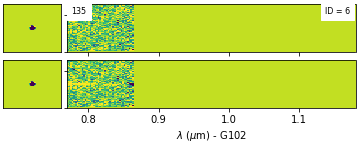

In [33]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

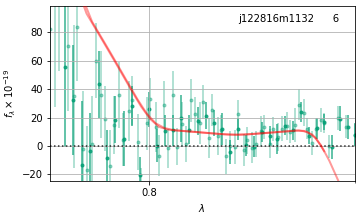

In [34]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 6


(6, 1, 7.8010711669921875)

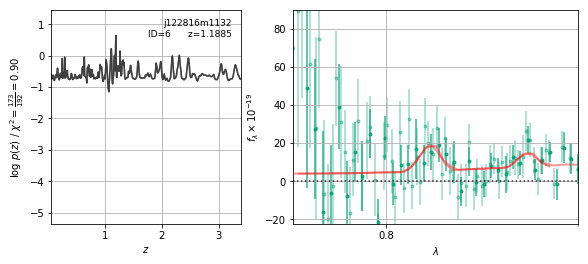

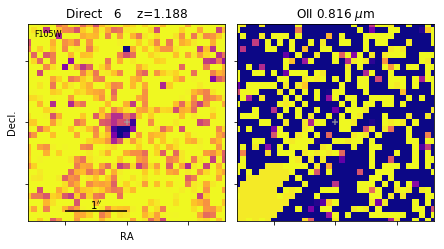

In [35]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [36]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j122816m1132_00006.log_par
j122816m1132_00006.1D.fits
j122816m1132_00006.beams.fits
j122816m1132_00006.full.png
j122816m1132_00006.stack.fits
j122816m1132_00006.stack.png
j122816m1132_00006.line.png
j122816m1132_00006.1D.png
j122816m1132_00006.full.fits


In [37]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j122816m1132_00006.1D.fits


Filename: j122816m1132_00006.1D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  G102          1 BinTableHDU     34   179R x 6C   [D, D, D, D, D, D]   


j122816m1132_00006.beams.fits


Filename: j122816m1132_00006.beams.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  REF           1 ImageHDU       244   (64, 64)   float32   
  2  SEG           1 ImageHDU       235   (64, 64)   int32   
  3  SCI           2 ImageHDU       243   (271, 64)   float32   
  4  ERR           2 ImageHDU       234   (271, 64)   float32   
  5  DQ            2 ImageHDU       234   (271, 64)   int16   
  6  CONTAM        2 ImageHDU       234   (271, 64)   float32   
  7  REF           1 ImageHDU       244   (64, 64)   float32   
  8  SEG           1 ImageHDU       235   (64, 64)   int32   
  9  SCI           2 ImageHDU       243   (271

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [38]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 40 2
j122816m1132_00040.beams.fits


True

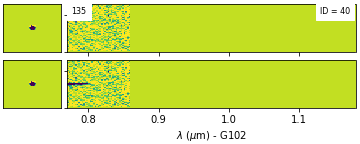

In [39]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

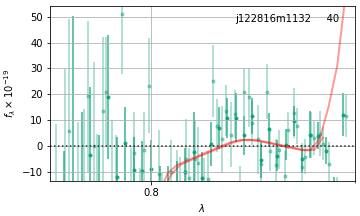

In [40]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 40


(40, 1, 5.921971082687378)

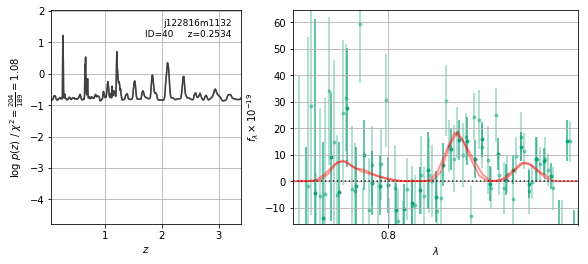

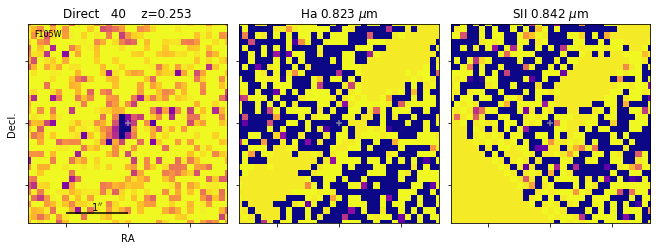

In [41]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).